In [1]:
from contextlib import contextmanager
import gc
import os
from pathlib import Path
import pickle
import time

import catboost
import faiss
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
import pandas as pd
from tqdm.auto import tqdm

from lfm import calc_embeddings, calc_scores
from metric import apk, mapk
from utils import plot_images


In [2]:
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name}] {time.time() - start_time:.3f} s')

In [3]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [4]:
# class CFG:
#     model_type = 'CatBoost'
#     # candidates
#     popular_num_items = 36
#     popular_weeks = 1
#     train_weeks = 3
#     item2item_num_items = 24
#     item2item_num_items_for_same_product_code = 12
#     cooc_weeks = 12
#     cooc_threshold = 50
#     ohe_distance_num_items = 32
#     ohe_distance_num_weeks = 1
#     # features
#     user_transaction_feature_weeks = 8
#     item_transaction_feature_weeks = 8
#     item_age_feature_weeks = 8
#     user_volume_feature_weeks = 1
#     item_volume_feature_weeks = 1
#     user_item_volume_feature_weeks = 1
#     age_volume_feature_weeks = 1


# TUNED
class CFG:
    model_type = 'CatBoost'
    # candidates
    popular_num_items = 60
    popular_weeks = 1
    train_weeks = 6
    item2item_num_items = 24
    item2item_num_items_for_same_product_code = 12
    cooc_weeks = 32
    cooc_threshold = 150
    user_cf_weeks = 8
    ohe_distance_num_items = 48
    ohe_distance_num_weeks = 20
    # features
    user_transaction_feature_weeks = 50
    item_transaction_feature_weeks = 16
    item_age_feature_weeks = 40
    user_volume_feature_weeks = 50
    item_volume_feature_weeks = 20
    user_item_volume_feature_weeks = 16
    user_category_colour_weeks = 4
    age_volume_feature_weeks = 1

In [5]:
# age==25でのアイテムボリューム以上になるような幅を各年齢に対して求める
tr = transactions[['user', 'item']].merge(users[['user', 'age']], on='user')
age_volume_threshold = len(tr.query("24 <= age <= 26"))

age_volumes = {age: len(tr.query("age == @age")) for age in range(16, 100)}

age_shifts = {}
for age in range(16, 100):
    for i in range(0, 100):
        low = age - i
        high = age + i
        age_volume = 0
        for j in range(low, high+1):
            age_volume += age_volumes.get(j, 0)
        if age_volume >= age_volume_threshold:
            age_shifts[age] = i
            break
print(age_shifts)

{16: 7, 17: 6, 18: 5, 19: 4, 20: 3, 21: 2, 22: 2, 23: 2, 24: 2, 25: 1, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 3, 33: 3, 34: 4, 35: 4, 36: 5, 37: 5, 38: 5, 39: 5, 40: 6, 41: 6, 42: 5, 43: 5, 44: 5, 45: 5, 46: 4, 47: 4, 48: 4, 49: 4, 50: 4, 51: 4, 52: 4, 53: 4, 54: 4, 55: 5, 56: 5, 57: 6, 58: 7, 59: 7, 60: 8, 61: 9, 62: 10, 63: 11, 64: 12, 65: 13, 66: 14, 67: 15, 68: 16, 69: 17, 70: 18, 71: 19, 72: 20, 73: 21, 74: 22, 75: 23, 76: 24, 77: 25, 78: 26, 79: 27, 80: 28, 81: 29, 82: 30, 83: 31, 84: 32, 85: 33, 86: 34, 87: 35, 88: 36, 89: 37, 90: 38, 91: 39, 92: 40, 93: 41, 94: 42, 95: 43, 96: 44, 97: 45, 98: 46, 99: 47}


In [6]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"create candidates (week: {week})")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            max_items_per_user: int=1234567890
        ) -> pd.DataFrame:
        tr = transactions.query("user in @target_users and @week_start <= week")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            num_items: int,
        ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'pop_rank'})

        candidates['strategy'] = 'pop'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_age_popular(
            transactions: pd.DataFrame,
            users: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            num_items: int,
        ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(users[['user', 'age']])

        pops = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            pop = tr.query("@low <= age <= @high")['item'].value_counts().index.values[:num_items]
            pops.append(pd.DataFrame({
                'age': age,
                'item': pop,
                'age_popular_rank': range(num_items),
            }))
        pops = pd.concat(pops)

        candidates = users[['user', 'age']].dropna().query("user in @target_users").reset_index(drop=True)

        candidates = candidates.merge(pops, on='age').drop('age', axis=1)

        candidates['strategy'] = 'age_pop'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_category_popular(
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            num_items: int,
            category: str,
    ) -> pd.DataFrame:
        # tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        # gr = tr.groupby('item').size().reset_index(name='volume')
        # gr = gr.merge(items[['item', category]], on='item')
        # gr[f'{category}_pop_volume_rank'] = gr.groupby(category)['volume'].rank(ascending=False)
        # gr = gr.query(f"{category}_pop_volume_rank <= @num_items")
        # candidates = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week_start}_{category}.pkl")
        # candidates = candidates.query("user in @target_users").reset_index(drop=True)
        # cols = [c for c in candidates.columns if c.endswith('_mean')]
        # candidates[category] = np.argmax(candidates[cols].values, axis=1)
        # candidates = candidates.merge(gr, on=category)
        # candidates = candidates[['user', 'item', f"{category}_pop_volume_rank"]].reset_index(drop=True)
        # candidates['strategy'] = f'{category}_pop'
        # return candidates

        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        gr = tr.groupby('item').size().reset_index(name='volume')
        gr = gr.merge(items[['item', category]], on='item')
        gr[f'{category}_pop_volume_rank'] = gr.groupby(category)['volume'].rank(ascending=False)
        gr = gr.query(f"{category}_pop_volume_rank <= @num_items")
        candidates = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week_start}_{category}.pkl")
        cols = [c for c in candidates.columns if c.endswith('_mean')]
        candidates = candidates[['user'] + cols].reset_index(drop=True)
        candidates[cols] = candidates[cols] / candidates[cols].mean()
        candidates = candidates.query("user in @target_users").reset_index(drop=True)
        candidates[category] = np.argmax(candidates[cols].values, axis=1)
        candidates = candidates.merge(gr, on=category)
        candidates = candidates[['user', 'item', f'{category}_pop_volume_rank']].reset_index(drop=True)
        candidates['strategy'] = f'{category}_pop'
        return candidates


    def create_candidates_cooc(
            transactions: pd.DataFrame,
            base_candidates: pd.DataFrame,
            week_start: int,
            num_weeks: int,
            pair_count_threshold: int,
        ) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_item_count = tr.groupby('item').size().reset_index(name='item_count')
        gr_pair_count = tr.groupby(['item', 'item_with']).size().reset_index(name='pair_count')
        item2item = gr_pair_count.merge(gr_item_count, on='item')
        item2item['ratio'] = item2item['pair_count'] / item2item['item_count']
        item2item = item2item.query("pair_count > @pair_count_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'pair_count'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"cooc_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': 'cooc_ratio', 'item_count': f'cooc_item_count'})

        candidates['strategy'] = 'cooc'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_user_cf(
        transactions: pd.DataFrame,
        target_users: np.ndarray,
        week_start: int,
        num_weeks: int,
    ) -> pd.DataFrame:
        num_common_rank_threshold = 50
        jaccard_index_rank_threshold = 35
        week_end = week_start + num_weeks
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        user2item = tr.groupby('user')['item'].agg(set).reset_index()

        # 共通のアイテムを買ってるペアを作る
        d = tr.groupby('user')['item'].agg(list).to_dict()
        row_ind = [k for k, v in d.items() for _ in range(len(v))]
        col_ind = [i for ids in d.values() for i in ids]
        X = sparse.csr_matrix(([1]*len(row_ind), (row_ind, col_ind))) # (user, item) matrix
        S = X * X.T
        x1, x2 = S.nonzero()
        user2user = (
            pd.DataFrame({
                'user': x1,
                'user_with': x2,
                'num_common': S.data})
        )
        user2user = user2user.query('user != user_with').copy()
        user2user['rank'] = user2user.groupby('user')['num_common'].rank(ascending=False)
        user2user = user2user.query('rank <= @num_common_rank_threshold').copy()

        # calc jaccard index
        user2user = (
            user2user
            .merge(user2item, on='user')
            .merge(user2item.rename(columns={'user': 'user_with', 'item': 'item_with'}), on='user_with')
        )
        user2user['usercf_jaccard_index'] = user2user.apply(lambda x: len(x['item'] & x['item_with']) / len(x['item'] | x['item_with']), axis=1)
        user2user['usercf_user_rank'] = user2user.groupby('user')['usercf_jaccard_index'].rank(ascending=False)
        user2user = user2user.query('rank <= @jaccard_index_rank_threshold')[['user', 'user_with', 'usercf_user_rank', 'usercf_jaccard_index']]

        candidates = tr.query('user in @target_users')[['user']].drop_duplicates(ignore_index=True)
        candidates = (
            candidates
            .merge(user2user[['user', 'user_with', 'usercf_user_rank', 'usercf_jaccard_index']], on='user')
            .merge(tr[['user', 'item']].rename(columns={'user': 'user_with'}), on='user_with')
            )
        candidates2 = candidates.groupby(['user', 'item']).size().reset_index(name='usercf_item_volume')
        candidates2['usercf_item_rank'] = candidates2.groupby(['user', 'item'])['usercf_item_volume'].rank(ascending=False)
        candidates = candidates.merge(candidates2, on=['user', 'item'])
        candidates = candidates.groupby(['user', 'item']).agg(
            usercf_jaccard_index=pd.NamedAgg(column='usercf_jaccard_index', aggfunc='max'),
            usercf_user_rank=pd.NamedAgg(column='usercf_user_rank', aggfunc='min'),
            usercf_rank=pd.NamedAgg(column='usercf_item_rank', aggfunc='min'),
        )
        candidates = candidates.reset_index()
        candidates['strategy'] = 'usercf'
        return candidates

    def create_candidates_same_product_code(
            items: pd.DataFrame,
            base_candidates: pd.DataFrame
        ) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"same_product_code_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = 'same_product_code'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_ohe_distance(
        transactions: pd.DataFrame,
        users: pd.DataFrame,
        items: pd.DataFrame,
        target_users: np.ndarray,
        week_start: int,
        num_weeks: int,
        num_items: int,
    ) -> pd.DataFrame:
        users_with_ohe = users[['user']].query("user in @target_users")
        cols = [c for c in items.columns if c.endswith('_idx')]
        for c in cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week_start}_{c}.pkl")
            cs = [c for c in tmp.columns if c.endswith('_mean')]
            users_with_ohe = users_with_ohe.merge(tmp[['user'] + cs], on='user')

        users_with_ohe = users_with_ohe.dropna().reset_index(drop=True)
        limited_users = users_with_ohe['user'].values

        recent_items = transactions.query("@week <= week < @week + @num_weeks")['item'].unique()
        items_with_ohe = pd.get_dummies(items[['item'] + cols], columns=cols)
        items_with_ohe = items_with_ohe.query("item in @recent_items").reset_index(drop=True)
        limited_items = items_with_ohe['item'].values

        item_cols = [c for c in items_with_ohe.columns if c != 'item']
        user_cols = [f'user_ohe_agg_{c}_mean' for c in item_cols]
        users_with_ohe = users_with_ohe[['user'] + user_cols]
        items_with_ohe = items_with_ohe[['item'] + item_cols]

        a_users = users_with_ohe.drop('user', axis=1).values.astype(np.float32)
        a_items = items_with_ohe.drop('item', axis=1).values.astype(np.float32)
        a_users = np.ascontiguousarray(a_users)
        a_items = np.ascontiguousarray(a_items)
        index = faiss.index_factory(a_items.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)
        index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index)
        index.add(a_items)
        distances, idxs = index.search(a_users, num_items)
        return pd.DataFrame({
            'user': np.repeat(limited_users, num_items),
            'item': limited_items[idxs.flatten()],
            'ohe_distance': distances.flatten(),
            'strategy': 'ohe_distance',
        })


    with timer("repurchase"):
        candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week)
    with timer("popular"):
        candidates_popular = create_candidates_popular(transactions, target_users, week, CFG.popular_weeks, CFG.popular_num_items)
    with timer("age popular"):
        candidates_age_popular = create_candidates_age_popular(transactions, users, target_users, week, 1, 12)
    with timer("item2item"):
        candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.item2item_num_items)
    with timer("item2item2"):
        candidates_item2item2 = create_candidates_repurchase('item2item2', transactions, target_users, week, CFG.item2item_num_items_for_same_product_code) 
    with timer("cooccurrence"):
        candidates_cooc = create_candidates_cooc(transactions, candidates_item2item, week, CFG.cooc_weeks, CFG.cooc_threshold)
    with timer("user-cf"):
        candidates_usercf = create_candidates_user_cf(transactions, target_users, week, CFG.user_cf_weeks)
    with timer("same_product_code"):
        candidates_same_product_code = create_candidates_same_product_code(items, candidates_item2item2)
    with timer("ohe distance"):
        candidates_ohe_distance = create_candidates_ohe_distance(transactions, users, items, target_users, week, CFG.ohe_distance_num_weeks, CFG.ohe_distance_num_items)
    # with timer("category pop"):
    #     candidates_category_pops = [
    #         create_candidates_category_popular(transactions, target_users, week, 1, 12, c)
    #         for c in ['perceived_colour_master_id_idx', 'department_no_idx',]
    #     ]


    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)


    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)
    candidates_ohe_distance = drop_common_user_item(candidates_ohe_distance, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_age_popular,
        candidates_cooc,
        candidates_usercf,
        candidates_same_product_code,
        candidates_ohe_distance,
    ]# + candidates_category_pops
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [7]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

create candidates (week: 1)


[repurchase] 9.374 s


[popular] 0.760 s


[age popular] 0.587 s


[item2item] 8.549 s


[item2item2] 8.283 s


[cooccurrence] 59.839 s


[same_product_code] 2.901 s


[ohe distance] 12.559 s


volume: 16808161


duplicates: 1.0996114956974057


            strategy   volume     ratio
0  same_product_code  4186861  0.249097
1                pop  4139040  0.246252
2         repurchase  3446562  0.205053
3       ohe_distance  2982529  0.177445
4               cooc  1228865  0.073111
5            age_pop   824304  0.049042


create candidates (week: 2)


[repurchase] 9.155 s


[popular] 0.735 s


[age popular] 0.607 s


[item2item] 8.288 s


[item2item2] 8.138 s


[cooccurrence] 59.547 s


[same_product_code] 2.901 s


[ohe distance] 12.081 s


volume: 17654247


duplicates: 1.0981821029675323


            strategy   volume     ratio
0  same_product_code  4398614  0.249153
1                pop  4321140  0.244765
2         repurchase  3637145  0.206021
3       ohe_distance  3133979  0.177520
4               cooc  1302993  0.073806
5            age_pop   860376  0.048735


create candidates (week: 3)


[repurchase] 9.091 s


[popular] 0.790 s


[age popular] 0.639 s


[item2item] 8.531 s


[item2item2] 8.412 s


[cooccurrence] 60.384 s


[same_product_code] 3.139 s


[ohe distance] 12.389 s


volume: 18593035


duplicates: 1.1016518228650536


            strategy   volume     ratio
0  same_product_code  4679508  0.251681
1                pop  4549320  0.244679
2         repurchase  3742824  0.201302
3       ohe_distance  3297031  0.177326
4               cooc  1418580  0.076296
5            age_pop   905772  0.048716


create candidates (week: 4)


[repurchase] 9.535 s


[popular] 0.851 s


[age popular] 0.654 s


[item2item] 9.116 s


[item2item2] 8.666 s


[cooccurrence] 59.118 s


[same_product_code] 3.326 s


[ohe distance] 12.370 s


volume: 19696613


duplicates: 1.1026294004157795


            strategy   volume     ratio
0  same_product_code  4998786  0.253789
1                pop  4815180  0.244467
2         repurchase  3915353  0.198783
3       ohe_distance  3495704  0.177477
4               cooc  1512886  0.076809
5            age_pop   958704  0.048674


create candidates (week: 5)


[repurchase] 8.704 s


[popular] 0.742 s


[age popular] 0.620 s


[item2item] 8.035 s


[item2item2] 8.031 s


[cooccurrence] 58.465 s


[same_product_code] 2.938 s


[ohe distance] 17.206 s


volume: 17721006


duplicates: 1.102875447558729


            strategy   volume     ratio
0  same_product_code  4486085  0.253151
1                pop  4322100  0.243897
2         repurchase  3548895  0.200265
3       ohe_distance  3156250  0.178108
4               cooc  1347096  0.076017
5            age_pop   860580  0.048563


create candidates (week: 6)


[repurchase] 8.627 s


[popular] 0.739 s


[age popular] 0.646 s


[item2item] 8.035 s


[item2item2] 8.067 s


[cooccurrence] 58.309 s


[same_product_code] 3.001 s


[ohe distance] 17.031 s


volume: 17580305


duplicates: 1.0954466413023451


            strategy   volume     ratio
0  same_product_code  4473501  0.254461
1                pop  4265640  0.242637
2         repurchase  3547521  0.201790
3       ohe_distance  3133505  0.178240
4               cooc  1310406  0.074538
5            age_pop   849732  0.048334


create candidates (week: 7)


[repurchase] 8.751 s


[popular] 0.782 s


[age popular] 0.684 s


[item2item] 8.227 s


[item2item2] 8.167 s


[cooccurrence] 58.604 s


[same_product_code] 3.095 s


[ohe distance] 16.840 s


volume: 18200322


duplicates: 1.097131227413135


            strategy   volume     ratio
0  same_product_code  4674139  0.256816
1                pop  4489980  0.246698
2         repurchase  3571089  0.196210
3       ohe_distance  3269720  0.179652
4               cooc  1301286  0.071498
5            age_pop   894108  0.049126


In [8]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"merge labels (week: {week})")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [9]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


merge labels (week: 0)


Recall: 0.15263793232519837


            strategy        y   volume    recall  hit_ratio
0                pop  16630.0  4139040  0.077809   0.004018
1         repurchase   8437.0  3446562  0.039475   0.002448
2  same_product_code   6328.0  4186861  0.029608   0.001511
3            age_pop   5301.0   824304  0.024803   0.006431
4               cooc   3321.0  1228865  0.015538   0.002702
5       ohe_distance   2264.0  2982529  0.010593   0.000759
merge labels (week: 1)


Recall: 0.14192883155631608


            strategy        y   volume    recall  hit_ratio
0                pop  14822.0  4321140  0.065034   0.003430
1         repurchase   8955.0  3637145  0.039292   0.002462
2  same_product_code   7005.0  4398614  0.030736   0.001593
3            age_pop   4816.0   860376  0.021131   0.005598
4               cooc   3651.0  1302993  0.016019   0.002802
5       ohe_distance   2410.0  3133979  0.010574   0.000769
merge labels (week: 2)


Recall: 0.14469870712467553


            strategy        y   volume    recall  hit_ratio
0                pop  16898.0  4549320  0.070978   0.003714
1         repurchase   9195.0  3742824  0.038622   0.002457
2  same_product_code   6935.0  4679508  0.029130   0.001482
3            age_pop   5809.0   905772  0.024400   0.006413
4               cooc   3965.0  1418580  0.016654   0.002795
5       ohe_distance   2531.0  3297031  0.010631   0.000768
merge labels (week: 3)


Recall: 0.14202577085260137


            strategy        y   volume    recall  hit_ratio
0                pop  18262.0  4815180  0.071567   0.003793
1         repurchase   9002.0  3915353  0.035278   0.002299
2  same_product_code   7336.0  4998786  0.028749   0.001468
3            age_pop   6073.0   958704  0.023800   0.006335
4               cooc   4429.0  1512886  0.017357   0.002928
5       ohe_distance   2593.0  3495704  0.010162   0.000742
merge labels (week: 4)


Recall: 0.13750243691107983


            strategy        y   volume    recall  hit_ratio
0                pop  13948.0  4322100  0.060427   0.003227
1         repurchase   8945.0  3548895  0.038752   0.002521
2  same_product_code   7392.0  4486085  0.032024   0.001648
3            age_pop   4770.0   860580  0.020665   0.005543
4               cooc   4576.0  1347096  0.019825   0.003397
5       ohe_distance   2155.0  3156250  0.009336   0.000683
merge labels (week: 5)


Recall: 0.12959183673469388


            strategy        y   volume    recall  hit_ratio
0                pop  11255.0  4265640  0.047457   0.002639
1         repurchase   9673.0  3547521  0.040787   0.002727
2  same_product_code   7454.0  4473501  0.031430   0.001666
3               cooc   4654.0  1310406  0.019624   0.003552
4            age_pop   3433.0   849732  0.014475   0.004040
5       ohe_distance   1940.0  3133505  0.008180   0.000619
merge labels (week: 6)


Recall: 0.11575187274576898


            strategy        y   volume    recall  hit_ratio
0                pop  11008.0  4489980  0.042418   0.002452
1         repurchase   9107.0  3571089  0.035093   0.002550
2  same_product_code   7871.0  4674139  0.030330   0.001684
3               cooc   4830.0  1301286  0.018612   0.003712
4            age_pop   3051.0   894108  0.011757   0.003412
5       ohe_distance   1790.0  3269720  0.006898   0.000547


In [10]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 16808161 -> 5979853


drop trivial queries: 17654247 -> 6139790


drop trivial queries: 18593035 -> 6607021


drop trivial queries: 19696613 -> 6959180


drop trivial queries: 17721006 -> 6029007


drop trivial queries: 17580305 -> 5649213


drop trivial queries: 18200322 -> 5703800


In [11]:
# age==25でのアイテムボリューム以上になるような幅を各年齢に対して求める
tr = transactions[['user', 'item']].merge(users[['user', 'age']], on='user')
age_volume_threshold = len(tr.query("24 <= age <= 26"))

age_volumes = {age: len(tr.query("age == @age")) for age in range(16, 100)}

age_shifts = {}
for age in range(16, 100):
    for i in range(0, 100):
        low = age - i
        high = age + i
        age_volume = 0
        for j in range(low, high+1):
            age_volume += age_volumes.get(j, 0)
        if age_volume >= age_volume_threshold:
            age_shifts[age] = i
            break
print(age_shifts)

{16: 7, 17: 6, 18: 5, 19: 4, 20: 3, 21: 2, 22: 2, 23: 2, 24: 2, 25: 1, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 3, 33: 3, 34: 4, 35: 4, 36: 5, 37: 5, 38: 5, 39: 5, 40: 6, 41: 6, 42: 5, 43: 5, 44: 5, 45: 5, 46: 4, 47: 4, 48: 4, 49: 4, 50: 4, 51: 4, 52: 4, 53: 4, 54: 4, 55: 5, 56: 5, 57: 6, 58: 7, 59: 7, 60: 8, 61: 9, 62: 10, 63: 11, 64: 12, 65: 13, 66: 14, 67: 15, 68: 16, 69: 17, 70: 18, 71: 19, 72: 20, 73: 21, 74: 22, 75: 23, 76: 24, 77: 25, 78: 26, 79: 27, 80: 28, 81: 29, 82: 30, 83: 31, 84: 32, 85: 33, 86: 34, 87: 35, 88: 36, 89: 37, 90: 38, 91: 39, 92: 40, 93: 41, 94: 42, 95: 43, 96: 44, 97: 45, 98: 46, 99: 47}


In [12]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"attach features (week: {week})")
    n_original = len(candidates)
    df = candidates.copy()

    with timer("user static fetaures"):
        # user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
        user_features = ['age']
        df = df.merge(users[['user'] + user_features], on='user')

    with timer("item stacic features"):
        item_features = [c for c in items.columns if c.endswith('idx')]
        df = df.merge(items[['item'] + item_features], on='item')

    with timer("user dynamic features (transactions)"):
        week_end = week + CFG.user_transaction_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='user', how='left')

    with timer("item dynamic features (transactions)"):
        week_end = week + CFG.item_transaction_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item dynamic features (user features)"):
        week_end = week + CFG.item_age_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
        tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
        tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item freshness features"):
        tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
        tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='item', how='left')

    with timer("item volume features"):
        week_end = week + CFG.item_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
        df = df.merge(tmp, on='item', how='left')

    with timer("user freshness features"):
        tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
        tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='user', how='left')

    with timer("user volume features"):
        week_end = week + CFG.user_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
        df = df.merge(tmp, on='user', how='left')

    with timer("user-item freshness features"):
        tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
        tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on=['item', 'user'], how='left')

    with timer("user-item volume features"):
        week_end = week + CFG.user_item_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

    with timer("item age volume features"):
        week_end = week + CFG.age_volume_feature_weeks
        tr = transactions.query("@week <= week < @week_end")[['user', 'item']].merge(users[['user', 'age']], on='user')
        item_age_volumes = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            tmp = tr.query("@low <= age <= @high").groupby('item').size().reset_index(name='age_volume')
            tmp['age_volume'] = tmp['age_volume'].rank(ascending=False)
            tmp['age'] = age
            item_age_volumes.append(tmp)
        item_age_volumes = pd.concat(item_age_volumes)
        df = df.merge(item_age_volumes, on=['item', 'age'], how='left')

    # with timer('user category normalized most frequent'):
    #     item_target_cols = [c for c in items.columns if c.endswith('_idx')]
    #     for c in item_target_cols:
    #         tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
    #         cols = [c for c in tmp.columns if c.endswith('_mean')]
    #         tmp = tmp[['user'] + cols]
    #         tmp[cols] = tmp[cols] / tmp[cols].mean()
    #         tmp[f'{c}_norm_most_freq_idx'] = np.argmax(tmp[cols].values, axis=1)
    #         df = df.merge(tmp[['user', f'{c}_norm_most_freq_idx']])

    with timer("user-category-color volume features"):
        week_end = week + CFG.user_category_colour_weeks
        for col in ['department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx']:
            pair_col = 'colour_group_code_idx'
            new_col = f'{col}-{pair_col}'
            df[new_col] = (
                df[col].astype(str) + '_' + '_' + df[pair_col].astype(str)
            )
            tmp = transactions.query("@week <= week < @week_end").merge(items[['item', col, pair_col]], on='item')
            tmp[new_col] = (
                tmp[col].astype(str) + '_' + '_' + tmp[pair_col].astype(str)
            )
            tmp = tmp.groupby(['user', new_col]).size().reset_index(name=f'user_{new_col}_volume')
            tmp[f'user_{new_col}_rank'] = tmp.groupby('user')[new_col].rank(ascending=False)
            df = df.merge(tmp, on=['user', new_col], how='left')

    with timer("ohe dot products"):
        item_target_cols = [c for c in items.columns if c.endswith('_idx')]

        items_with_ohe = pd.get_dummies(items[['item'] + item_target_cols], columns=item_target_cols)

        cols = [c for c in items_with_ohe.columns if c != 'item']
        items_with_ohe[cols] = items_with_ohe[cols] / items_with_ohe[cols].mean()

        users_with_ohe = users[['user']]
        for c in item_target_cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            assert tmp['user'].tolist() == users_with_ohe['user'].tolist()
            tmp = tmp[['user'] + [c for c in tmp.columns if c.endswith('_mean')]]
            tmp = tmp.drop('user', axis=1)
            users_with_ohe = pd.concat([users_with_ohe, tmp], axis=1)

        assert items_with_ohe['item'].tolist() == items['item'].tolist()
        assert users_with_ohe['user'].tolist() == users['user'].tolist()

        users_items = df[['user', 'item']].drop_duplicates().reset_index(drop=True)
        n_split = 10
        n_chunk = (len(users_items) + n_split - 1)// n_split
        ohe = []
        for i in range(0, len(users_items), n_chunk):
            users_items_small = users_items.iloc[i:i+n_chunk].reset_index(drop=True)
            users_small = users_items_small['user'].values
            items_small = users_items_small['item'].values

            for item_col in item_target_cols:
                i_cols = [c for c in items_with_ohe.columns if c.startswith(item_col)]
                u_cols = [f"user_ohe_agg_{c}_mean" for c in i_cols]
                users_items_small[f'{item_col}_ohe_score'] = (items_with_ohe[i_cols].values[items_small] * users_with_ohe[u_cols].values[users_small]).sum(axis=1)

            ohe_cols = [f'{col}_ohe_score' for col in item_target_cols]
            users_items_small = users_items_small[['user', 'item'] + ohe_cols]

            ohe.append(users_items_small)
        ohe = pd.concat(ohe)
        df = df.merge(ohe, on=['user', 'item'])

    with timer("lfm features"):
        seen_users = transactions.query("week >= @pretrain_week")['user'].unique()
        user_reps, _ = calc_embeddings('i_i', dataset, pretrain_week, 16)
        user_reps = user_reps.query("user in @seen_users")
        df = df.merge(user_reps, on='user', how='left')

    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

attach features (week: 1)


[user static fetaures] 1.538 s


[item stacic features] 4.061 s


[user dynamic features (transactions)] 4.904 s


[item dynamic features (transactions)] 2.764 s


[item dynamic features (user features)] 5.764 s


[item freshness features] 4.643 s


[item volume features] 3.090 s


[user freshness features] 6.202 s


[user volume features] 4.470 s


[user-item freshness features] 24.371 s


[user-item volume features] 8.217 s


[item age volume features] 5.220 s


[ohe dot products] 137.397 s


[lfm features] 6.402 s
attach features (week: 1)


[user static fetaures] 0.563 s


[item stacic features] 1.330 s


[user dynamic features (transactions)] 3.275 s


[item dynamic features (transactions)] 1.353 s


[item dynamic features (user features)] 4.209 s


[item freshness features] 2.984 s


[item volume features] 1.459 s


[user freshness features] 4.187 s


[user volume features] 2.393 s


[user-item freshness features] 21.349 s


[user-item volume features] 4.599 s


[item age volume features] 2.418 s


[ohe dot products] 66.255 s


[lfm features] 3.363 s
attach features (week: 2)


[user static fetaures] 0.591 s


[item stacic features] 1.364 s


[user dynamic features (transactions)] 3.277 s


[item dynamic features (transactions)] 1.367 s


[item dynamic features (user features)] 4.108 s


[item freshness features] 2.898 s


[item volume features] 1.456 s


[user freshness features] 4.059 s


[user volume features] 2.328 s


[user-item freshness features] 20.621 s


[user-item volume features] 4.519 s


[item age volume features] 2.387 s


[ohe dot products] 65.104 s


[lfm features] 3.379 s
attach features (week: 3)


[user static fetaures] 0.606 s


[item stacic features] 1.392 s


[user dynamic features (transactions)] 3.355 s


[item dynamic features (transactions)] 1.376 s


[item dynamic features (user features)] 4.141 s


[item freshness features] 2.911 s


[item volume features] 1.453 s


[user freshness features] 4.125 s


[user volume features] 2.393 s


[user-item freshness features] 20.619 s


[user-item volume features] 4.655 s


[item age volume features] 2.483 s


[ohe dot products] 66.382 s


[lfm features] 3.426 s
attach features (week: 4)


[user static fetaures] 0.627 s


[item stacic features] 1.482 s


[user dynamic features (transactions)] 3.281 s


[item dynamic features (transactions)] 1.435 s


[item dynamic features (user features)] 4.159 s


[item freshness features] 2.913 s


[item volume features] 1.497 s


[user freshness features] 4.170 s


[user volume features] 2.492 s


[user-item freshness features] 20.601 s


[user-item volume features] 4.649 s


[item age volume features] 2.560 s


[ohe dot products] 68.272 s


[lfm features] 3.530 s
attach features (week: 5)


[user static fetaures] 0.519 s


[item stacic features] 1.241 s


[user dynamic features (transactions)] 3.214 s


[item dynamic features (transactions)] 1.310 s


[item dynamic features (user features)] 4.089 s


[item freshness features] 2.777 s


[item volume features] 1.382 s


[user freshness features] 3.940 s


[user volume features] 2.338 s


[user-item freshness features] 20.144 s


[user-item volume features] 4.500 s


[item age volume features] 2.298 s


[ohe dot products] 63.189 s


[lfm features] 3.345 s
attach features (week: 6)


[user static fetaures] 0.511 s


[item stacic features] 1.175 s


[user dynamic features (transactions)] 3.244 s


[item dynamic features (transactions)] 1.263 s


[item dynamic features (user features)] 4.060 s


[item freshness features] 2.735 s


[item volume features] 1.344 s


[user freshness features] 3.860 s


[user volume features] 2.274 s


[user-item freshness features] 20.070 s


[user-item volume features] 4.532 s


[item age volume features] 2.331 s


[ohe dot products] 61.479 s


[lfm features] 3.218 s
attach features (week: 7)


[user static fetaures] 0.491 s


[item stacic features] 1.175 s


[user dynamic features (transactions)] 3.170 s


[item dynamic features (transactions)] 1.262 s


[item dynamic features (user features)] 3.991 s


[item freshness features] 2.722 s


[item volume features] 1.325 s


[user freshness features] 3.855 s


[user volume features] 2.266 s


[user-item freshness features] 18.704 s


[user-item volume features] 4.577 s


[item age volume features] 2.341 s


[ohe dot products] 63.696 s


[lfm features] 3.240 s


In [13]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [14]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [15]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'age_popular_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_item_count', 'cooc_ratio', 'same_product_code_item2item2_week_rank', 'same_product_code_item2item2_volume_rank', 'ohe_distance', 'age', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_day_min', 'user_volume', 'user_item_day_min', 'user_item_volume', 'age_volume', 'product_type_no_idx_ohe_score', 'product_group_name_idx_ohe_score', 'graphical_appearance_no_

In [16]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [17]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

0:	test: 0.1394402	best: 0.1394402 (0)	total: 7.14s	remaining: 9h 55m 10s


1:	test: 0.1502801	best: 0.1502801 (1)	total: 13.4s	remaining: 9h 17m 52s


2:	test: 0.1624746	best: 0.1624746 (2)	total: 19.6s	remaining: 9h 3m 58s


3:	test: 0.1556297	best: 0.1624746 (2)	total: 26s	remaining: 9h 1m 27s


4:	test: 0.1556092	best: 0.1624746 (2)	total: 32.4s	remaining: 8h 58m 40s


5:	test: 0.1568620	best: 0.1624746 (2)	total: 38.7s	remaining: 8h 56m 17s


6:	test: 0.1696915	best: 0.1696915 (6)	total: 45.6s	remaining: 9h 1m 57s


7:	test: 0.1604508	best: 0.1696915 (6)	total: 51.9s	remaining: 8h 59m 29s


8:	test: 0.1731895	best: 0.1731895 (8)	total: 58s	remaining: 8h 56m 16s


9:	test: 0.1754021	best: 0.1754021 (9)	total: 1m 4s	remaining: 8h 53m 9s


10:	test: 0.1782759	best: 0.1782759 (10)	total: 1m 10s	remaining: 8h 53m 43s


11:	test: 0.1812241	best: 0.1812241 (11)	total: 1m 17s	remaining: 8h 54m 14s


12:	test: 0.1940891	best: 0.1940891 (12)	total: 1m 23s	remaining: 8h 52m 41s


13:	test: 0.1984294	best: 0.1984294 (13)	total: 1m 29s	remaining: 8h 53m 10s


14:	test: 0.1990536	best: 0.1990536 (14)	total: 1m 36s	remaining: 8h 51m 47s


15:	test: 0.2035240	best: 0.2035240 (15)	total: 1m 42s	remaining: 8h 52m 18s


16:	test: 0.2036271	best: 0.2036271 (16)	total: 1m 49s	remaining: 8h 53m 21s


17:	test: 0.2067831	best: 0.2067831 (17)	total: 1m 55s	remaining: 8h 52m 43s


18:	test: 0.2077059	best: 0.2077059 (18)	total: 2m 1s	remaining: 8h 52m 33s


19:	test: 0.2077510	best: 0.2077510 (19)	total: 2m 8s	remaining: 8h 52m 48s


20:	test: 0.2130122	best: 0.2130122 (20)	total: 2m 14s	remaining: 8h 51m 50s


21:	test: 0.2134086	best: 0.2134086 (21)	total: 2m 20s	remaining: 8h 51m 37s


22:	test: 0.2136174	best: 0.2136174 (22)	total: 2m 27s	remaining: 8h 50m 57s


23:	test: 0.2190266	best: 0.2190266 (23)	total: 2m 33s	remaining: 8h 50m 44s


24:	test: 0.2214086	best: 0.2214086 (24)	total: 2m 39s	remaining: 8h 50m 3s


25:	test: 0.2234513	best: 0.2234513 (25)	total: 2m 45s	remaining: 8h 48m 40s


26:	test: 0.2240837	best: 0.2240837 (26)	total: 2m 52s	remaining: 8h 48m 34s


27:	test: 0.2248264	best: 0.2248264 (27)	total: 2m 58s	remaining: 8h 48m 15s


28:	test: 0.2259989	best: 0.2259989 (28)	total: 3m 4s	remaining: 8h 47m 46s


29:	test: 0.2266180	best: 0.2266180 (29)	total: 3m 11s	remaining: 8h 47m 30s


30:	test: 0.2285597	best: 0.2285597 (30)	total: 3m 17s	remaining: 8h 47m 26s


31:	test: 0.2311779	best: 0.2311779 (31)	total: 3m 23s	remaining: 8h 47m 6s


32:	test: 0.2316097	best: 0.2316097 (32)	total: 3m 29s	remaining: 8h 46m 32s


33:	test: 0.2319616	best: 0.2319616 (33)	total: 3m 36s	remaining: 8h 45m 48s


34:	test: 0.2346730	best: 0.2346730 (34)	total: 3m 42s	remaining: 8h 45m 55s


35:	test: 0.2381070	best: 0.2381070 (35)	total: 3m 48s	remaining: 8h 46m 14s


36:	test: 0.2386701	best: 0.2386701 (36)	total: 3m 55s	remaining: 8h 46m 12s


37:	test: 0.2393661	best: 0.2393661 (37)	total: 4m 1s	remaining: 8h 45m 43s


38:	test: 0.2391990	best: 0.2393661 (37)	total: 4m 8s	remaining: 8h 45m 47s


39:	test: 0.2393634	best: 0.2393661 (37)	total: 4m 14s	remaining: 8h 45m 51s


40:	test: 0.2399563	best: 0.2399563 (40)	total: 4m 20s	remaining: 8h 45m 15s


41:	test: 0.2402150	best: 0.2402150 (41)	total: 4m 26s	remaining: 8h 44m 54s


42:	test: 0.2408948	best: 0.2408948 (42)	total: 4m 33s	remaining: 8h 44m 52s


43:	test: 0.2414021	best: 0.2414021 (43)	total: 4m 39s	remaining: 8h 44m 42s


44:	test: 0.2412459	best: 0.2414021 (43)	total: 4m 45s	remaining: 8h 43m 38s


45:	test: 0.2414329	best: 0.2414329 (45)	total: 4m 51s	remaining: 8h 43m 27s


46:	test: 0.2413994	best: 0.2414329 (45)	total: 4m 57s	remaining: 8h 42m 45s


47:	test: 0.2407496	best: 0.2414329 (45)	total: 5m 3s	remaining: 8h 42m 1s


48:	test: 0.2411862	best: 0.2414329 (45)	total: 5m 10s	remaining: 8h 42m 25s


49:	test: 0.2409856	best: 0.2414329 (45)	total: 5m 16s	remaining: 8h 41m 42s


50:	test: 0.2410129	best: 0.2414329 (45)	total: 5m 22s	remaining: 8h 41m 9s


51:	test: 0.2414813	best: 0.2414813 (51)	total: 5m 28s	remaining: 8h 40m 50s


52:	test: 0.2414702	best: 0.2414813 (51)	total: 5m 34s	remaining: 8h 40m 55s


53:	test: 0.2420106	best: 0.2420106 (53)	total: 5m 40s	remaining: 8h 40m 24s


54:	test: 0.2417265	best: 0.2420106 (53)	total: 5m 46s	remaining: 8h 39m 57s


55:	test: 0.2421651	best: 0.2421651 (55)	total: 5m 53s	remaining: 8h 39m 36s


56:	test: 0.2426230	best: 0.2426230 (56)	total: 5m 59s	remaining: 8h 39m 13s


57:	test: 0.2431061	best: 0.2431061 (57)	total: 6m 5s	remaining: 8h 38m 22s


58:	test: 0.2432717	best: 0.2432717 (58)	total: 6m 11s	remaining: 8h 38m 19s


59:	test: 0.2433896	best: 0.2433896 (59)	total: 6m 17s	remaining: 8h 37m 38s


60:	test: 0.2434354	best: 0.2434354 (60)	total: 6m 23s	remaining: 8h 37m 9s


61:	test: 0.2437109	best: 0.2437109 (61)	total: 6m 29s	remaining: 8h 37m 9s


62:	test: 0.2436449	best: 0.2437109 (61)	total: 6m 35s	remaining: 8h 36m 42s


63:	test: 0.2440285	best: 0.2440285 (63)	total: 6m 41s	remaining: 8h 36m 10s


64:	test: 0.2441499	best: 0.2441499 (64)	total: 6m 47s	remaining: 8h 35m 49s


65:	test: 0.2441323	best: 0.2441499 (64)	total: 6m 53s	remaining: 8h 35m 40s


66:	test: 0.2442897	best: 0.2442897 (66)	total: 6m 59s	remaining: 8h 35m 6s


67:	test: 0.2444969	best: 0.2444969 (67)	total: 7m 5s	remaining: 8h 34m 44s


68:	test: 0.2449704	best: 0.2449704 (68)	total: 7m 11s	remaining: 8h 34m 19s


69:	test: 0.2452579	best: 0.2452579 (69)	total: 7m 17s	remaining: 8h 33m 50s


70:	test: 0.2480390	best: 0.2480390 (70)	total: 7m 24s	remaining: 8h 34m


71:	test: 0.2483210	best: 0.2483210 (71)	total: 7m 30s	remaining: 8h 33m 53s


72:	test: 0.2490396	best: 0.2490396 (72)	total: 7m 36s	remaining: 8h 33m 44s


73:	test: 0.2492626	best: 0.2492626 (73)	total: 7m 42s	remaining: 8h 33m 26s


74:	test: 0.2491838	best: 0.2492626 (73)	total: 7m 48s	remaining: 8h 32m 46s


75:	test: 0.2493782	best: 0.2493782 (75)	total: 7m 54s	remaining: 8h 32m 23s


76:	test: 0.2496182	best: 0.2496182 (76)	total: 8m	remaining: 8h 32m 14s


77:	test: 0.2499736	best: 0.2499736 (77)	total: 8m 6s	remaining: 8h 32m 5s


78:	test: 0.2500587	best: 0.2500587 (78)	total: 8m 13s	remaining: 8h 31m 51s


79:	test: 0.2503487	best: 0.2503487 (79)	total: 8m 19s	remaining: 8h 31m 39s


80:	test: 0.2508381	best: 0.2508381 (80)	total: 8m 25s	remaining: 8h 31m 25s


81:	test: 0.2510341	best: 0.2510341 (81)	total: 8m 31s	remaining: 8h 30m 58s


82:	test: 0.2526610	best: 0.2526610 (82)	total: 8m 37s	remaining: 8h 30m 38s


83:	test: 0.2528215	best: 0.2528215 (83)	total: 8m 43s	remaining: 8h 30m 42s


84:	test: 0.2530580	best: 0.2530580 (84)	total: 8m 49s	remaining: 8h 30m 30s


85:	test: 0.2531880	best: 0.2531880 (85)	total: 8m 55s	remaining: 8h 30m 5s


86:	test: 0.2532706	best: 0.2532706 (86)	total: 9m 1s	remaining: 8h 30m 3s


87:	test: 0.2535203	best: 0.2535203 (87)	total: 9m 8s	remaining: 8h 30m 41s


88:	test: 0.2536242	best: 0.2536242 (88)	total: 9m 14s	remaining: 8h 30m 19s


89:	test: 0.2533353	best: 0.2536242 (88)	total: 9m 21s	remaining: 8h 30m 29s


90:	test: 0.2534765	best: 0.2536242 (88)	total: 9m 27s	remaining: 8h 30m 30s


91:	test: 0.2537341	best: 0.2537341 (91)	total: 9m 33s	remaining: 8h 30m 14s


92:	test: 0.2536973	best: 0.2537341 (91)	total: 9m 40s	remaining: 8h 30m 30s


93:	test: 0.2538077	best: 0.2538077 (93)	total: 9m 46s	remaining: 8h 30m 7s


94:	test: 0.2536519	best: 0.2538077 (93)	total: 9m 52s	remaining: 8h 29m 53s


95:	test: 0.2541252	best: 0.2541252 (95)	total: 9m 58s	remaining: 8h 29m 57s


96:	test: 0.2540761	best: 0.2541252 (95)	total: 10m 5s	remaining: 8h 29m 54s


97:	test: 0.2544941	best: 0.2544941 (97)	total: 10m 11s	remaining: 8h 29m 37s


98:	test: 0.2545482	best: 0.2545482 (98)	total: 10m 18s	remaining: 8h 29m 59s


99:	test: 0.2546365	best: 0.2546365 (99)	total: 10m 24s	remaining: 8h 29m 50s


100:	test: 0.2546565	best: 0.2546565 (100)	total: 10m 30s	remaining: 8h 29m 49s


101:	test: 0.2546723	best: 0.2546723 (101)	total: 10m 36s	remaining: 8h 29m 33s


102:	test: 0.2552259	best: 0.2552259 (102)	total: 10m 43s	remaining: 8h 29m 40s


103:	test: 0.2554598	best: 0.2554598 (103)	total: 10m 49s	remaining: 8h 29m 18s


104:	test: 0.2556684	best: 0.2556684 (104)	total: 10m 55s	remaining: 8h 29m 1s


105:	test: 0.2559423	best: 0.2559423 (105)	total: 11m 1s	remaining: 8h 28m 53s


106:	test: 0.2562403	best: 0.2562403 (106)	total: 11m 7s	remaining: 8h 28m 30s


107:	test: 0.2567883	best: 0.2567883 (107)	total: 11m 13s	remaining: 8h 28m 21s


108:	test: 0.2568425	best: 0.2568425 (108)	total: 11m 19s	remaining: 8h 28m 22s


109:	test: 0.2569398	best: 0.2569398 (109)	total: 11m 26s	remaining: 8h 28m 24s


110:	test: 0.2573802	best: 0.2573802 (110)	total: 11m 32s	remaining: 8h 28m 25s


111:	test: 0.2575648	best: 0.2575648 (111)	total: 11m 38s	remaining: 8h 28m 3s


112:	test: 0.2576253	best: 0.2576253 (112)	total: 11m 44s	remaining: 8h 27m 45s


113:	test: 0.2576527	best: 0.2576527 (113)	total: 11m 50s	remaining: 8h 27m 33s


114:	test: 0.2577144	best: 0.2577144 (114)	total: 11m 56s	remaining: 8h 27m 10s


115:	test: 0.2578913	best: 0.2578913 (115)	total: 12m 2s	remaining: 8h 26m 41s


116:	test: 0.2580048	best: 0.2580048 (116)	total: 12m 8s	remaining: 8h 26m 58s


117:	test: 0.2580474	best: 0.2580474 (117)	total: 12m 15s	remaining: 8h 26m 49s


118:	test: 0.2584067	best: 0.2584067 (118)	total: 12m 21s	remaining: 8h 26m 53s


119:	test: 0.2585284	best: 0.2585284 (119)	total: 12m 27s	remaining: 8h 26m 57s


120:	test: 0.2584702	best: 0.2585284 (119)	total: 12m 34s	remaining: 8h 27m


121:	test: 0.2587990	best: 0.2587990 (121)	total: 12m 40s	remaining: 8h 26m 56s


122:	test: 0.2592676	best: 0.2592676 (122)	total: 12m 46s	remaining: 8h 26m 45s


123:	test: 0.2593941	best: 0.2593941 (123)	total: 12m 52s	remaining: 8h 26m 29s


124:	test: 0.2595801	best: 0.2595801 (124)	total: 12m 59s	remaining: 8h 26m 25s


125:	test: 0.2597904	best: 0.2597904 (125)	total: 13m 5s	remaining: 8h 26m 13s


126:	test: 0.2600348	best: 0.2600348 (126)	total: 13m 11s	remaining: 8h 26m 13s


127:	test: 0.2601954	best: 0.2601954 (127)	total: 13m 17s	remaining: 8h 26m 6s


128:	test: 0.2601981	best: 0.2601981 (128)	total: 13m 24s	remaining: 8h 26m 3s


129:	test: 0.2603126	best: 0.2603126 (129)	total: 13m 30s	remaining: 8h 25m 56s


130:	test: 0.2606132	best: 0.2606132 (130)	total: 13m 36s	remaining: 8h 25m 41s


131:	test: 0.2607940	best: 0.2607940 (131)	total: 13m 42s	remaining: 8h 25m 42s


132:	test: 0.2610187	best: 0.2610187 (132)	total: 13m 48s	remaining: 8h 25m 27s


133:	test: 0.2612194	best: 0.2612194 (133)	total: 13m 55s	remaining: 8h 25m 28s


134:	test: 0.2612304	best: 0.2612304 (134)	total: 14m 1s	remaining: 8h 25m 25s


135:	test: 0.2614717	best: 0.2614717 (135)	total: 14m 7s	remaining: 8h 25m 16s


136:	test: 0.2615949	best: 0.2615949 (136)	total: 14m 14s	remaining: 8h 25m 19s


137:	test: 0.2617170	best: 0.2617170 (137)	total: 14m 20s	remaining: 8h 25m 3s


138:	test: 0.2617454	best: 0.2617454 (138)	total: 14m 25s	remaining: 8h 24m 44s


139:	test: 0.2616821	best: 0.2617454 (138)	total: 14m 31s	remaining: 8h 24m 25s


140:	test: 0.2619230	best: 0.2619230 (140)	total: 14m 38s	remaining: 8h 24m 20s


141:	test: 0.2620917	best: 0.2620917 (141)	total: 14m 44s	remaining: 8h 24m 14s


142:	test: 0.2621275	best: 0.2621275 (142)	total: 14m 50s	remaining: 8h 24m 22s


143:	test: 0.2622180	best: 0.2622180 (143)	total: 14m 56s	remaining: 8h 23m 52s


144:	test: 0.2623284	best: 0.2623284 (144)	total: 15m 2s	remaining: 8h 23m 45s


145:	test: 0.2622797	best: 0.2623284 (144)	total: 15m 8s	remaining: 8h 23m 28s


146:	test: 0.2624341	best: 0.2624341 (146)	total: 15m 14s	remaining: 8h 23m 21s


147:	test: 0.2626662	best: 0.2626662 (147)	total: 15m 20s	remaining: 8h 23m 10s


148:	test: 0.2627096	best: 0.2627096 (148)	total: 15m 27s	remaining: 8h 23m 6s


149:	test: 0.2630729	best: 0.2630729 (149)	total: 15m 33s	remaining: 8h 23m 7s


150:	test: 0.2632070	best: 0.2632070 (150)	total: 15m 39s	remaining: 8h 23m 1s


151:	test: 0.2634127	best: 0.2634127 (151)	total: 15m 45s	remaining: 8h 22m 47s


152:	test: 0.2635123	best: 0.2635123 (152)	total: 15m 52s	remaining: 8h 22m 44s


153:	test: 0.2637310	best: 0.2637310 (153)	total: 15m 58s	remaining: 8h 22m 40s


154:	test: 0.2638307	best: 0.2638307 (154)	total: 16m 4s	remaining: 8h 22m 37s


155:	test: 0.2641024	best: 0.2641024 (155)	total: 16m 10s	remaining: 8h 22m 25s


156:	test: 0.2641476	best: 0.2641476 (156)	total: 16m 16s	remaining: 8h 22m 12s


157:	test: 0.2643230	best: 0.2643230 (157)	total: 16m 22s	remaining: 8h 22m 4s


158:	test: 0.2644992	best: 0.2644992 (158)	total: 16m 29s	remaining: 8h 21m 52s


159:	test: 0.2646823	best: 0.2646823 (159)	total: 16m 34s	remaining: 8h 21m 38s


160:	test: 0.2648876	best: 0.2648876 (160)	total: 16m 41s	remaining: 8h 21m 33s


161:	test: 0.2647829	best: 0.2648876 (160)	total: 16m 47s	remaining: 8h 21m 16s


162:	test: 0.2649813	best: 0.2649813 (162)	total: 16m 53s	remaining: 8h 21m 7s


163:	test: 0.2650465	best: 0.2650465 (163)	total: 16m 59s	remaining: 8h 21m 1s


164:	test: 0.2652505	best: 0.2652505 (164)	total: 17m 5s	remaining: 8h 20m 59s


165:	test: 0.2653635	best: 0.2653635 (165)	total: 17m 12s	remaining: 8h 20m 53s


166:	test: 0.2654851	best: 0.2654851 (166)	total: 17m 18s	remaining: 8h 20m 41s


167:	test: 0.2655281	best: 0.2655281 (167)	total: 17m 24s	remaining: 8h 20m 31s


168:	test: 0.2655351	best: 0.2655351 (168)	total: 17m 30s	remaining: 8h 20m 15s


169:	test: 0.2656882	best: 0.2656882 (169)	total: 17m 36s	remaining: 8h 20m 22s


170:	test: 0.2659631	best: 0.2659631 (170)	total: 17m 42s	remaining: 8h 20m 18s


171:	test: 0.2660254	best: 0.2660254 (171)	total: 17m 48s	remaining: 8h 20m 4s


172:	test: 0.2659733	best: 0.2660254 (171)	total: 17m 54s	remaining: 8h 19m 46s


173:	test: 0.2660002	best: 0.2660254 (171)	total: 18m	remaining: 8h 19m 34s


174:	test: 0.2661685	best: 0.2661685 (174)	total: 18m 6s	remaining: 8h 19m 25s


175:	test: 0.2663013	best: 0.2663013 (175)	total: 18m 12s	remaining: 8h 19m 12s


176:	test: 0.2663088	best: 0.2663088 (176)	total: 18m 19s	remaining: 8h 19m 10s


177:	test: 0.2663436	best: 0.2663436 (177)	total: 18m 25s	remaining: 8h 19m 7s


178:	test: 0.2664434	best: 0.2664434 (178)	total: 18m 31s	remaining: 8h 19m 5s


179:	test: 0.2667182	best: 0.2667182 (179)	total: 18m 38s	remaining: 8h 18m 59s


180:	test: 0.2668529	best: 0.2668529 (180)	total: 18m 44s	remaining: 8h 18m 59s


181:	test: 0.2672365	best: 0.2672365 (181)	total: 18m 50s	remaining: 8h 18m 59s


182:	test: 0.2673706	best: 0.2673706 (182)	total: 18m 57s	remaining: 8h 18m 51s


183:	test: 0.2674742	best: 0.2674742 (183)	total: 19m 3s	remaining: 8h 18m 37s


184:	test: 0.2675840	best: 0.2675840 (184)	total: 19m 9s	remaining: 8h 18m 39s


185:	test: 0.2676632	best: 0.2676632 (185)	total: 19m 15s	remaining: 8h 18m 38s


186:	test: 0.2673251	best: 0.2676632 (185)	total: 19m 22s	remaining: 8h 18m 35s


187:	test: 0.2674071	best: 0.2676632 (185)	total: 19m 28s	remaining: 8h 18m 22s


188:	test: 0.2674516	best: 0.2676632 (185)	total: 19m 34s	remaining: 8h 18m 14s


189:	test: 0.2675988	best: 0.2676632 (185)	total: 19m 40s	remaining: 8h 18m 10s


190:	test: 0.2679649	best: 0.2679649 (190)	total: 19m 47s	remaining: 8h 18m 6s


191:	test: 0.2683978	best: 0.2683978 (191)	total: 19m 53s	remaining: 8h 18m 1s


192:	test: 0.2684662	best: 0.2684662 (192)	total: 19m 59s	remaining: 8h 17m 49s


193:	test: 0.2684308	best: 0.2684662 (192)	total: 20m 5s	remaining: 8h 17m 44s


194:	test: 0.2684159	best: 0.2684662 (192)	total: 20m 11s	remaining: 8h 17m 35s


195:	test: 0.2685462	best: 0.2685462 (195)	total: 20m 17s	remaining: 8h 17m 26s


196:	test: 0.2686300	best: 0.2686300 (196)	total: 20m 24s	remaining: 8h 17m 30s


197:	test: 0.2687562	best: 0.2687562 (197)	total: 20m 30s	remaining: 8h 17m 24s


198:	test: 0.2689306	best: 0.2689306 (198)	total: 20m 37s	remaining: 8h 17m 23s


199:	test: 0.2689502	best: 0.2689502 (199)	total: 20m 43s	remaining: 8h 17m 28s


200:	test: 0.2690081	best: 0.2690081 (200)	total: 20m 49s	remaining: 8h 17m 19s


201:	test: 0.2690973	best: 0.2690973 (201)	total: 20m 55s	remaining: 8h 17m 6s


202:	test: 0.2690255	best: 0.2690973 (201)	total: 21m 1s	remaining: 8h 16m 55s


203:	test: 0.2691502	best: 0.2691502 (203)	total: 21m 8s	remaining: 8h 16m 55s


204:	test: 0.2692539	best: 0.2692539 (204)	total: 21m 14s	remaining: 8h 16m 44s


205:	test: 0.2692554	best: 0.2692554 (205)	total: 21m 20s	remaining: 8h 16m 40s


206:	test: 0.2692050	best: 0.2692554 (205)	total: 21m 26s	remaining: 8h 16m 23s


207:	test: 0.2693436	best: 0.2693436 (207)	total: 21m 32s	remaining: 8h 16m 14s


208:	test: 0.2694450	best: 0.2694450 (208)	total: 21m 38s	remaining: 8h 16m 6s


209:	test: 0.2697823	best: 0.2697823 (209)	total: 21m 45s	remaining: 8h 16m 9s


210:	test: 0.2697811	best: 0.2697823 (209)	total: 21m 51s	remaining: 8h 16m 15s


211:	test: 0.2698724	best: 0.2698724 (211)	total: 21m 57s	remaining: 8h 15m 52s


212:	test: 0.2699412	best: 0.2699412 (212)	total: 22m 3s	remaining: 8h 15m 53s


213:	test: 0.2699194	best: 0.2699412 (212)	total: 22m 10s	remaining: 8h 15m 45s


214:	test: 0.2699991	best: 0.2699991 (214)	total: 22m 16s	remaining: 8h 15m 48s


215:	test: 0.2701046	best: 0.2701046 (215)	total: 22m 22s	remaining: 8h 15m 38s


216:	test: 0.2702388	best: 0.2702388 (216)	total: 22m 28s	remaining: 8h 15m 33s


217:	test: 0.2704374	best: 0.2704374 (217)	total: 22m 35s	remaining: 8h 15m 30s


218:	test: 0.2705780	best: 0.2705780 (218)	total: 22m 41s	remaining: 8h 15m 28s


219:	test: 0.2706254	best: 0.2706254 (219)	total: 22m 47s	remaining: 8h 15m 16s


220:	test: 0.2706944	best: 0.2706944 (220)	total: 22m 53s	remaining: 8h 15m 8s


221:	test: 0.2707696	best: 0.2707696 (221)	total: 22m 59s	remaining: 8h 14m 56s


222:	test: 0.2708469	best: 0.2708469 (222)	total: 23m 5s	remaining: 8h 14m 33s


223:	test: 0.2708947	best: 0.2708947 (223)	total: 23m 11s	remaining: 8h 14m 21s


224:	test: 0.2709926	best: 0.2709926 (224)	total: 23m 17s	remaining: 8h 14m 17s


225:	test: 0.2709284	best: 0.2709926 (224)	total: 23m 23s	remaining: 8h 14m 8s


226:	test: 0.2710954	best: 0.2710954 (226)	total: 23m 29s	remaining: 8h 14m 5s


227:	test: 0.2712381	best: 0.2712381 (227)	total: 23m 36s	remaining: 8h 14m 1s


228:	test: 0.2712628	best: 0.2712628 (228)	total: 23m 42s	remaining: 8h 14m 6s


229:	test: 0.2714545	best: 0.2714545 (229)	total: 23m 49s	remaining: 8h 14m 5s


230:	test: 0.2714063	best: 0.2714545 (229)	total: 23m 55s	remaining: 8h 13m 58s


231:	test: 0.2713794	best: 0.2714545 (229)	total: 24m 2s	remaining: 8h 14m 3s


232:	test: 0.2714215	best: 0.2714545 (229)	total: 24m 8s	remaining: 8h 13m 53s


233:	test: 0.2715100	best: 0.2715100 (233)	total: 24m 14s	remaining: 8h 13m 40s


234:	test: 0.2715567	best: 0.2715567 (234)	total: 24m 20s	remaining: 8h 13m 26s


235:	test: 0.2716593	best: 0.2716593 (235)	total: 24m 26s	remaining: 8h 13m 15s


236:	test: 0.2716514	best: 0.2716593 (235)	total: 24m 32s	remaining: 8h 13m 3s


237:	test: 0.2717661	best: 0.2717661 (237)	total: 24m 38s	remaining: 8h 13m 2s


238:	test: 0.2718203	best: 0.2718203 (238)	total: 24m 44s	remaining: 8h 12m 56s


239:	test: 0.2720182	best: 0.2720182 (239)	total: 24m 51s	remaining: 8h 12m 53s


240:	test: 0.2721939	best: 0.2721939 (240)	total: 24m 57s	remaining: 8h 12m 48s


241:	test: 0.2721938	best: 0.2721939 (240)	total: 25m 2s	remaining: 8h 12m 26s


242:	test: 0.2722018	best: 0.2722018 (242)	total: 25m 9s	remaining: 8h 12m 22s


243:	test: 0.2722593	best: 0.2722593 (243)	total: 25m 15s	remaining: 8h 12m 13s


244:	test: 0.2723369	best: 0.2723369 (244)	total: 25m 20s	remaining: 8h 11m 58s


245:	test: 0.2724331	best: 0.2724331 (245)	total: 25m 26s	remaining: 8h 11m 47s


246:	test: 0.2725250	best: 0.2725250 (246)	total: 25m 32s	remaining: 8h 11m 37s


247:	test: 0.2724742	best: 0.2725250 (246)	total: 25m 38s	remaining: 8h 11m 27s


248:	test: 0.2724779	best: 0.2725250 (246)	total: 25m 45s	remaining: 8h 11m 21s


249:	test: 0.2724908	best: 0.2725250 (246)	total: 25m 51s	remaining: 8h 11m 17s


250:	test: 0.2724837	best: 0.2725250 (246)	total: 25m 57s	remaining: 8h 11m 8s


251:	test: 0.2725113	best: 0.2725250 (246)	total: 26m 3s	remaining: 8h 11m 3s


252:	test: 0.2725888	best: 0.2725888 (252)	total: 26m 9s	remaining: 8h 10m 55s


253:	test: 0.2726408	best: 0.2726408 (253)	total: 26m 15s	remaining: 8h 10m 46s


254:	test: 0.2726492	best: 0.2726492 (254)	total: 26m 21s	remaining: 8h 10m 32s


255:	test: 0.2724785	best: 0.2726492 (254)	total: 26m 27s	remaining: 8h 10m 27s


256:	test: 0.2725277	best: 0.2726492 (254)	total: 26m 34s	remaining: 8h 10m 17s


257:	test: 0.2726977	best: 0.2726977 (257)	total: 26m 40s	remaining: 8h 10m 9s


258:	test: 0.2728241	best: 0.2728241 (258)	total: 26m 46s	remaining: 8h 10m 10s


259:	test: 0.2728707	best: 0.2728707 (259)	total: 26m 53s	remaining: 8h 10m 8s


260:	test: 0.2730596	best: 0.2730596 (260)	total: 26m 59s	remaining: 8h 10m


261:	test: 0.2730469	best: 0.2730596 (260)	total: 27m 5s	remaining: 8h 10m


262:	test: 0.2731466	best: 0.2731466 (262)	total: 27m 11s	remaining: 8h 9m 50s


263:	test: 0.2731128	best: 0.2731466 (262)	total: 27m 17s	remaining: 8h 9m 38s


264:	test: 0.2731551	best: 0.2731551 (264)	total: 27m 23s	remaining: 8h 9m 29s


265:	test: 0.2733044	best: 0.2733044 (265)	total: 27m 29s	remaining: 8h 9m 19s


266:	test: 0.2734093	best: 0.2734093 (266)	total: 27m 36s	remaining: 8h 9m 17s


267:	test: 0.2734798	best: 0.2734798 (267)	total: 27m 42s	remaining: 8h 9m 11s


268:	test: 0.2736040	best: 0.2736040 (268)	total: 27m 47s	remaining: 8h 8m 52s


269:	test: 0.2735552	best: 0.2736040 (268)	total: 27m 53s	remaining: 8h 8m 43s


270:	test: 0.2737611	best: 0.2737611 (270)	total: 28m	remaining: 8h 8m 37s


271:	test: 0.2737654	best: 0.2737654 (271)	total: 28m 6s	remaining: 8h 8m 27s


272:	test: 0.2737096	best: 0.2737654 (271)	total: 28m 12s	remaining: 8h 8m 22s


273:	test: 0.2737648	best: 0.2737654 (271)	total: 28m 18s	remaining: 8h 8m 13s


274:	test: 0.2737186	best: 0.2737654 (271)	total: 28m 23s	remaining: 8h 7m 57s


275:	test: 0.2737445	best: 0.2737654 (271)	total: 28m 29s	remaining: 8h 7m 47s


276:	test: 0.2738652	best: 0.2738652 (276)	total: 28m 36s	remaining: 8h 7m 42s


277:	test: 0.2739743	best: 0.2739743 (277)	total: 28m 42s	remaining: 8h 7m 33s


278:	test: 0.2739886	best: 0.2739886 (278)	total: 28m 48s	remaining: 8h 7m 29s


279:	test: 0.2739420	best: 0.2739886 (278)	total: 28m 54s	remaining: 8h 7m 22s


280:	test: 0.2739344	best: 0.2739886 (278)	total: 29m	remaining: 8h 7m 13s


281:	test: 0.2739019	best: 0.2739886 (278)	total: 29m 7s	remaining: 8h 7m 8s


282:	test: 0.2739473	best: 0.2739886 (278)	total: 29m 13s	remaining: 8h 7m 4s


283:	test: 0.2739951	best: 0.2739951 (283)	total: 29m 19s	remaining: 8h 6m 50s


284:	test: 0.2738065	best: 0.2739951 (283)	total: 29m 25s	remaining: 8h 6m 42s


285:	test: 0.2738390	best: 0.2739951 (283)	total: 29m 31s	remaining: 8h 6m 34s


286:	test: 0.2738498	best: 0.2739951 (283)	total: 29m 37s	remaining: 8h 6m 23s


287:	test: 0.2739087	best: 0.2739951 (283)	total: 29m 43s	remaining: 8h 6m 12s


288:	test: 0.2739145	best: 0.2739951 (283)	total: 29m 48s	remaining: 8h 6m 1s


289:	test: 0.2739833	best: 0.2739951 (283)	total: 29m 55s	remaining: 8h 5m 53s


290:	test: 0.2741107	best: 0.2741107 (290)	total: 30m	remaining: 8h 5m 42s


291:	test: 0.2742838	best: 0.2742838 (291)	total: 30m 7s	remaining: 8h 5m 40s


292:	test: 0.2742857	best: 0.2742857 (292)	total: 30m 13s	remaining: 8h 5m 30s


293:	test: 0.2742695	best: 0.2742857 (292)	total: 30m 19s	remaining: 8h 5m 21s


294:	test: 0.2743684	best: 0.2743684 (294)	total: 30m 25s	remaining: 8h 5m 16s


295:	test: 0.2743349	best: 0.2743684 (294)	total: 30m 31s	remaining: 8h 5m 6s


296:	test: 0.2742735	best: 0.2743684 (294)	total: 30m 37s	remaining: 8h 4m 54s


297:	test: 0.2743344	best: 0.2743684 (294)	total: 30m 43s	remaining: 8h 4m 51s


298:	test: 0.2744322	best: 0.2744322 (298)	total: 30m 49s	remaining: 8h 4m 43s


299:	test: 0.2745110	best: 0.2745110 (299)	total: 30m 56s	remaining: 8h 4m 40s


300:	test: 0.2745263	best: 0.2745263 (300)	total: 31m 1s	remaining: 8h 4m 28s


301:	test: 0.2746348	best: 0.2746348 (301)	total: 31m 8s	remaining: 8h 4m 21s


302:	test: 0.2746261	best: 0.2746348 (301)	total: 31m 14s	remaining: 8h 4m 10s


303:	test: 0.2747123	best: 0.2747123 (303)	total: 31m 20s	remaining: 8h 4m 5s


304:	test: 0.2747391	best: 0.2747391 (304)	total: 31m 26s	remaining: 8h 4m 1s


305:	test: 0.2747618	best: 0.2747618 (305)	total: 31m 32s	remaining: 8h 3m 55s


306:	test: 0.2747878	best: 0.2747878 (306)	total: 31m 38s	remaining: 8h 3m 48s


307:	test: 0.2748753	best: 0.2748753 (307)	total: 31m 44s	remaining: 8h 3m 39s


308:	test: 0.2749731	best: 0.2749731 (308)	total: 31m 51s	remaining: 8h 3m 33s


309:	test: 0.2749435	best: 0.2749731 (308)	total: 31m 57s	remaining: 8h 3m 23s


310:	test: 0.2751402	best: 0.2751402 (310)	total: 32m 3s	remaining: 8h 3m 20s


311:	test: 0.2751037	best: 0.2751402 (310)	total: 32m 9s	remaining: 8h 3m 13s


312:	test: 0.2750562	best: 0.2751402 (310)	total: 32m 15s	remaining: 8h 3m 9s


313:	test: 0.2750494	best: 0.2751402 (310)	total: 32m 21s	remaining: 8h 2m 59s


314:	test: 0.2750611	best: 0.2751402 (310)	total: 32m 27s	remaining: 8h 2m 45s


315:	test: 0.2750751	best: 0.2751402 (310)	total: 32m 33s	remaining: 8h 2m 31s


316:	test: 0.2751371	best: 0.2751402 (310)	total: 32m 39s	remaining: 8h 2m 28s


317:	test: 0.2752659	best: 0.2752659 (317)	total: 32m 45s	remaining: 8h 2m 13s


318:	test: 0.2752540	best: 0.2752659 (317)	total: 32m 51s	remaining: 8h 2m 3s


319:	test: 0.2753067	best: 0.2753067 (319)	total: 32m 57s	remaining: 8h 1m 57s


320:	test: 0.2753655	best: 0.2753655 (320)	total: 33m 3s	remaining: 8h 1m 49s


321:	test: 0.2754233	best: 0.2754233 (321)	total: 33m 9s	remaining: 8h 1m 46s


322:	test: 0.2755214	best: 0.2755214 (322)	total: 33m 16s	remaining: 8h 1m 43s


323:	test: 0.2754991	best: 0.2755214 (322)	total: 33m 21s	remaining: 8h 1m 30s


324:	test: 0.2754995	best: 0.2755214 (322)	total: 33m 28s	remaining: 8h 1m 27s


325:	test: 0.2754792	best: 0.2755214 (322)	total: 33m 33s	remaining: 8h 1m 14s


326:	test: 0.2755312	best: 0.2755312 (326)	total: 33m 39s	remaining: 8h 56s


327:	test: 0.2755531	best: 0.2755531 (327)	total: 33m 44s	remaining: 8h 40s


328:	test: 0.2755792	best: 0.2755792 (328)	total: 33m 50s	remaining: 8h 27s


329:	test: 0.2756546	best: 0.2756546 (329)	total: 33m 56s	remaining: 8h 14s


330:	test: 0.2756542	best: 0.2756546 (329)	total: 34m 2s	remaining: 8h 6s


331:	test: 0.2756720	best: 0.2756720 (331)	total: 34m 7s	remaining: 7h 59m 54s


332:	test: 0.2757766	best: 0.2757766 (332)	total: 34m 13s	remaining: 7h 59m 43s


333:	test: 0.2757705	best: 0.2757766 (332)	total: 34m 19s	remaining: 7h 59m 35s


334:	test: 0.2757843	best: 0.2757843 (334)	total: 34m 25s	remaining: 7h 59m 20s


335:	test: 0.2758503	best: 0.2758503 (335)	total: 34m 31s	remaining: 7h 59m 17s


336:	test: 0.2759098	best: 0.2759098 (336)	total: 34m 37s	remaining: 7h 59m 2s


337:	test: 0.2759031	best: 0.2759098 (336)	total: 34m 43s	remaining: 7h 58m 53s


338:	test: 0.2758871	best: 0.2759098 (336)	total: 34m 48s	remaining: 7h 58m 41s


339:	test: 0.2759552	best: 0.2759552 (339)	total: 34m 55s	remaining: 7h 58m 38s


340:	test: 0.2760377	best: 0.2760377 (340)	total: 35m 1s	remaining: 7h 58m 32s


341:	test: 0.2760430	best: 0.2760430 (341)	total: 35m 7s	remaining: 7h 58m 23s


342:	test: 0.2760370	best: 0.2760430 (341)	total: 35m 13s	remaining: 7h 58m 12s


343:	test: 0.2760936	best: 0.2760936 (343)	total: 35m 18s	remaining: 7h 57m 58s


344:	test: 0.2761840	best: 0.2761840 (344)	total: 35m 24s	remaining: 7h 57m 49s


345:	test: 0.2761718	best: 0.2761840 (344)	total: 35m 30s	remaining: 7h 57m 40s


346:	test: 0.2762188	best: 0.2762188 (346)	total: 35m 36s	remaining: 7h 57m 28s


347:	test: 0.2762104	best: 0.2762188 (346)	total: 35m 42s	remaining: 7h 57m 15s


348:	test: 0.2762778	best: 0.2762778 (348)	total: 35m 48s	remaining: 7h 57m 7s


349:	test: 0.2762932	best: 0.2762932 (349)	total: 35m 53s	remaining: 7h 56m 51s


350:	test: 0.2763234	best: 0.2763234 (350)	total: 35m 58s	remaining: 7h 56m 32s


351:	test: 0.2763506	best: 0.2763506 (351)	total: 36m 4s	remaining: 7h 56m 16s


352:	test: 0.2763502	best: 0.2763506 (351)	total: 36m 9s	remaining: 7h 55m 59s


353:	test: 0.2763534	best: 0.2763534 (353)	total: 36m 15s	remaining: 7h 55m 45s


354:	test: 0.2763555	best: 0.2763555 (354)	total: 36m 20s	remaining: 7h 55m 33s


355:	test: 0.2764223	best: 0.2764223 (355)	total: 36m 26s	remaining: 7h 55m 21s


356:	test: 0.2763681	best: 0.2764223 (355)	total: 36m 32s	remaining: 7h 55m 10s


357:	test: 0.2764904	best: 0.2764904 (357)	total: 36m 37s	remaining: 7h 54m 58s


358:	test: 0.2765259	best: 0.2765259 (358)	total: 36m 43s	remaining: 7h 54m 46s


359:	test: 0.2766391	best: 0.2766391 (359)	total: 36m 48s	remaining: 7h 54m 30s


360:	test: 0.2766069	best: 0.2766391 (359)	total: 36m 54s	remaining: 7h 54m 23s


361:	test: 0.2766723	best: 0.2766723 (361)	total: 37m	remaining: 7h 54m 12s


362:	test: 0.2767916	best: 0.2767916 (362)	total: 37m 6s	remaining: 7h 53m 58s


363:	test: 0.2767227	best: 0.2767916 (362)	total: 37m 11s	remaining: 7h 53m 44s


364:	test: 0.2767320	best: 0.2767916 (362)	total: 37m 17s	remaining: 7h 53m 32s


365:	test: 0.2767923	best: 0.2767923 (365)	total: 37m 23s	remaining: 7h 53m 20s


366:	test: 0.2768280	best: 0.2768280 (366)	total: 37m 28s	remaining: 7h 53m 6s


367:	test: 0.2770253	best: 0.2770253 (367)	total: 37m 34s	remaining: 7h 52m 57s


368:	test: 0.2770487	best: 0.2770487 (368)	total: 37m 40s	remaining: 7h 52m 46s


369:	test: 0.2770060	best: 0.2770487 (368)	total: 37m 45s	remaining: 7h 52m 35s


370:	test: 0.2770576	best: 0.2770576 (370)	total: 37m 51s	remaining: 7h 52m 24s


371:	test: 0.2770107	best: 0.2770576 (370)	total: 37m 57s	remaining: 7h 52m 14s


372:	test: 0.2770972	best: 0.2770972 (372)	total: 38m 3s	remaining: 7h 52m 7s


373:	test: 0.2770932	best: 0.2770972 (372)	total: 38m 9s	remaining: 7h 51m 53s


374:	test: 0.2771768	best: 0.2771768 (374)	total: 38m 15s	remaining: 7h 51m 49s


375:	test: 0.2772030	best: 0.2772030 (375)	total: 38m 21s	remaining: 7h 51m 41s


376:	test: 0.2771681	best: 0.2772030 (375)	total: 38m 27s	remaining: 7h 51m 31s


377:	test: 0.2772460	best: 0.2772460 (377)	total: 38m 33s	remaining: 7h 51m 25s


378:	test: 0.2772888	best: 0.2772888 (378)	total: 38m 38s	remaining: 7h 51m 14s


379:	test: 0.2772975	best: 0.2772975 (379)	total: 38m 44s	remaining: 7h 51m


380:	test: 0.2773645	best: 0.2773645 (380)	total: 38m 50s	remaining: 7h 50m 48s


381:	test: 0.2774602	best: 0.2774602 (381)	total: 38m 55s	remaining: 7h 50m 34s


382:	test: 0.2774197	best: 0.2774602 (381)	total: 39m 1s	remaining: 7h 50m 21s


383:	test: 0.2774445	best: 0.2774602 (381)	total: 39m 6s	remaining: 7h 50m 12s


384:	test: 0.2776241	best: 0.2776241 (384)	total: 39m 12s	remaining: 7h 50m 4s


385:	test: 0.2776741	best: 0.2776741 (385)	total: 39m 18s	remaining: 7h 49m 56s


386:	test: 0.2777006	best: 0.2777006 (386)	total: 39m 24s	remaining: 7h 49m 49s


387:	test: 0.2777359	best: 0.2777359 (387)	total: 39m 30s	remaining: 7h 49m 41s


388:	test: 0.2777673	best: 0.2777673 (388)	total: 39m 36s	remaining: 7h 49m 30s


389:	test: 0.2777683	best: 0.2777683 (389)	total: 39m 42s	remaining: 7h 49m 18s


390:	test: 0.2777050	best: 0.2777683 (389)	total: 39m 47s	remaining: 7h 49m 6s


391:	test: 0.2777632	best: 0.2777683 (389)	total: 39m 53s	remaining: 7h 48m 58s


392:	test: 0.2777876	best: 0.2777876 (392)	total: 39m 59s	remaining: 7h 48m 47s


393:	test: 0.2778430	best: 0.2778430 (393)	total: 40m 5s	remaining: 7h 48m 35s


394:	test: 0.2778624	best: 0.2778624 (394)	total: 40m 10s	remaining: 7h 48m 25s


395:	test: 0.2779094	best: 0.2779094 (395)	total: 40m 16s	remaining: 7h 48m 17s


396:	test: 0.2779085	best: 0.2779094 (395)	total: 40m 22s	remaining: 7h 48m 6s


397:	test: 0.2779056	best: 0.2779094 (395)	total: 40m 28s	remaining: 7h 47m 58s


398:	test: 0.2779876	best: 0.2779876 (398)	total: 40m 34s	remaining: 7h 47m 49s


399:	test: 0.2780217	best: 0.2780217 (399)	total: 40m 40s	remaining: 7h 47m 40s


400:	test: 0.2779645	best: 0.2780217 (399)	total: 40m 45s	remaining: 7h 47m 30s


401:	test: 0.2779353	best: 0.2780217 (399)	total: 40m 51s	remaining: 7h 47m 23s


402:	test: 0.2779032	best: 0.2780217 (399)	total: 40m 57s	remaining: 7h 47m 9s


403:	test: 0.2779577	best: 0.2780217 (399)	total: 41m 3s	remaining: 7h 47m


404:	test: 0.2779171	best: 0.2780217 (399)	total: 41m 8s	remaining: 7h 46m 49s


405:	test: 0.2779898	best: 0.2780217 (399)	total: 41m 14s	remaining: 7h 46m 40s


406:	test: 0.2781247	best: 0.2781247 (406)	total: 41m 20s	remaining: 7h 46m 29s


407:	test: 0.2781643	best: 0.2781643 (407)	total: 41m 25s	remaining: 7h 46m 19s


408:	test: 0.2781832	best: 0.2781832 (408)	total: 41m 32s	remaining: 7h 46m 12s


409:	test: 0.2782386	best: 0.2782386 (409)	total: 41m 37s	remaining: 7h 45m 58s


410:	test: 0.2782453	best: 0.2782453 (410)	total: 41m 43s	remaining: 7h 45m 55s


411:	test: 0.2782401	best: 0.2782453 (410)	total: 41m 49s	remaining: 7h 45m 41s


412:	test: 0.2782984	best: 0.2782984 (412)	total: 41m 55s	remaining: 7h 45m 36s


413:	test: 0.2783268	best: 0.2783268 (413)	total: 42m 1s	remaining: 7h 45m 28s


414:	test: 0.2783428	best: 0.2783428 (414)	total: 42m 7s	remaining: 7h 45m 20s


415:	test: 0.2782573	best: 0.2783428 (414)	total: 42m 12s	remaining: 7h 45m 9s


416:	test: 0.2782576	best: 0.2783428 (414)	total: 42m 19s	remaining: 7h 45m 4s


417:	test: 0.2783540	best: 0.2783540 (417)	total: 42m 25s	remaining: 7h 44m 59s


418:	test: 0.2784201	best: 0.2784201 (418)	total: 42m 30s	remaining: 7h 44m 45s


419:	test: 0.2783558	best: 0.2784201 (418)	total: 42m 36s	remaining: 7h 44m 38s


420:	test: 0.2784228	best: 0.2784228 (420)	total: 42m 42s	remaining: 7h 44m 30s


421:	test: 0.2783608	best: 0.2784228 (420)	total: 42m 48s	remaining: 7h 44m 25s


422:	test: 0.2784660	best: 0.2784660 (422)	total: 42m 54s	remaining: 7h 44m 18s


423:	test: 0.2785758	best: 0.2785758 (423)	total: 43m	remaining: 7h 44m 8s


424:	test: 0.2786002	best: 0.2786002 (424)	total: 43m 6s	remaining: 7h 44m


425:	test: 0.2786602	best: 0.2786602 (425)	total: 43m 12s	remaining: 7h 43m 51s


426:	test: 0.2786248	best: 0.2786602 (425)	total: 43m 17s	remaining: 7h 43m 39s


427:	test: 0.2785886	best: 0.2786602 (425)	total: 43m 23s	remaining: 7h 43m 29s


428:	test: 0.2786020	best: 0.2786602 (425)	total: 43m 29s	remaining: 7h 43m 20s


429:	test: 0.2786262	best: 0.2786602 (425)	total: 43m 35s	remaining: 7h 43m 13s


430:	test: 0.2787191	best: 0.2787191 (430)	total: 43m 40s	remaining: 7h 43m 3s


431:	test: 0.2788122	best: 0.2788122 (431)	total: 43m 46s	remaining: 7h 42m 55s


432:	test: 0.2788000	best: 0.2788122 (431)	total: 43m 52s	remaining: 7h 42m 48s


433:	test: 0.2789571	best: 0.2789571 (433)	total: 43m 58s	remaining: 7h 42m 39s


434:	test: 0.2789663	best: 0.2789663 (434)	total: 44m 3s	remaining: 7h 42m 26s


435:	test: 0.2790383	best: 0.2790383 (435)	total: 44m 9s	remaining: 7h 42m 16s


436:	test: 0.2790091	best: 0.2790383 (435)	total: 44m 15s	remaining: 7h 42m 5s


437:	test: 0.2789603	best: 0.2790383 (435)	total: 44m 20s	remaining: 7h 41m 50s


438:	test: 0.2789988	best: 0.2790383 (435)	total: 44m 26s	remaining: 7h 41m 45s


439:	test: 0.2790424	best: 0.2790424 (439)	total: 44m 32s	remaining: 7h 41m 35s


440:	test: 0.2790798	best: 0.2790798 (440)	total: 44m 38s	remaining: 7h 41m 27s


441:	test: 0.2790850	best: 0.2790850 (441)	total: 44m 43s	remaining: 7h 41m 13s


442:	test: 0.2790725	best: 0.2790850 (441)	total: 44m 48s	remaining: 7h 40m 59s


443:	test: 0.2790922	best: 0.2790922 (443)	total: 44m 54s	remaining: 7h 40m 49s


444:	test: 0.2791424	best: 0.2791424 (444)	total: 45m	remaining: 7h 40m 43s


445:	test: 0.2791280	best: 0.2791424 (444)	total: 45m 6s	remaining: 7h 40m 32s


446:	test: 0.2791699	best: 0.2791699 (446)	total: 45m 12s	remaining: 7h 40m 23s


447:	test: 0.2791860	best: 0.2791860 (447)	total: 45m 17s	remaining: 7h 40m 10s


448:	test: 0.2792617	best: 0.2792617 (448)	total: 45m 23s	remaining: 7h 40m 2s


449:	test: 0.2793745	best: 0.2793745 (449)	total: 45m 28s	remaining: 7h 39m 52s


450:	test: 0.2793000	best: 0.2793745 (449)	total: 45m 34s	remaining: 7h 39m 44s


451:	test: 0.2793330	best: 0.2793745 (449)	total: 45m 40s	remaining: 7h 39m 36s


452:	test: 0.2794326	best: 0.2794326 (452)	total: 45m 46s	remaining: 7h 39m 26s


453:	test: 0.2794502	best: 0.2794502 (453)	total: 45m 52s	remaining: 7h 39m 18s


454:	test: 0.2793957	best: 0.2794502 (453)	total: 45m 57s	remaining: 7h 39m 8s


455:	test: 0.2794507	best: 0.2794507 (455)	total: 46m 3s	remaining: 7h 38m 59s


456:	test: 0.2795320	best: 0.2795320 (456)	total: 46m 9s	remaining: 7h 38m 53s


457:	test: 0.2795487	best: 0.2795487 (457)	total: 46m 15s	remaining: 7h 38m 44s


458:	test: 0.2794963	best: 0.2795487 (457)	total: 46m 21s	remaining: 7h 38m 34s


459:	test: 0.2795078	best: 0.2795487 (457)	total: 46m 26s	remaining: 7h 38m 20s


460:	test: 0.2795492	best: 0.2795492 (460)	total: 46m 31s	remaining: 7h 38m 9s


461:	test: 0.2795249	best: 0.2795492 (460)	total: 46m 37s	remaining: 7h 37m 57s


462:	test: 0.2795161	best: 0.2795492 (460)	total: 46m 43s	remaining: 7h 37m 47s


463:	test: 0.2794824	best: 0.2795492 (460)	total: 46m 48s	remaining: 7h 37m 38s


464:	test: 0.2795613	best: 0.2795613 (464)	total: 46m 54s	remaining: 7h 37m 24s


465:	test: 0.2795474	best: 0.2795613 (464)	total: 47m	remaining: 7h 37m 17s


466:	test: 0.2795299	best: 0.2795613 (464)	total: 47m 5s	remaining: 7h 37m 6s


467:	test: 0.2795793	best: 0.2795793 (467)	total: 47m 11s	remaining: 7h 36m 57s


468:	test: 0.2795662	best: 0.2795793 (467)	total: 47m 17s	remaining: 7h 36m 48s


469:	test: 0.2795148	best: 0.2795793 (467)	total: 47m 22s	remaining: 7h 36m 39s


470:	test: 0.2795217	best: 0.2795793 (467)	total: 47m 28s	remaining: 7h 36m 31s


471:	test: 0.2794843	best: 0.2795793 (467)	total: 47m 34s	remaining: 7h 36m 26s


472:	test: 0.2794396	best: 0.2795793 (467)	total: 47m 40s	remaining: 7h 36m 16s


473:	test: 0.2795221	best: 0.2795793 (467)	total: 47m 45s	remaining: 7h 36m 4s


474:	test: 0.2795899	best: 0.2795899 (474)	total: 47m 52s	remaining: 7h 36m


475:	test: 0.2795745	best: 0.2795899 (474)	total: 47m 57s	remaining: 7h 35m 47s


476:	test: 0.2795410	best: 0.2795899 (474)	total: 48m 3s	remaining: 7h 35m 42s


477:	test: 0.2795181	best: 0.2795899 (474)	total: 48m 9s	remaining: 7h 35m 32s


478:	test: 0.2796004	best: 0.2796004 (478)	total: 48m 14s	remaining: 7h 35m 21s


479:	test: 0.2796102	best: 0.2796102 (479)	total: 48m 20s	remaining: 7h 35m 9s


480:	test: 0.2796640	best: 0.2796640 (480)	total: 48m 25s	remaining: 7h 35m 1s


481:	test: 0.2796514	best: 0.2796640 (480)	total: 48m 31s	remaining: 7h 34m 50s


482:	test: 0.2797771	best: 0.2797771 (482)	total: 48m 37s	remaining: 7h 34m 41s


483:	test: 0.2797964	best: 0.2797964 (483)	total: 48m 43s	remaining: 7h 34m 33s


484:	test: 0.2798136	best: 0.2798136 (484)	total: 48m 48s	remaining: 7h 34m 22s


485:	test: 0.2797598	best: 0.2798136 (484)	total: 48m 54s	remaining: 7h 34m 15s


486:	test: 0.2797632	best: 0.2798136 (484)	total: 49m	remaining: 7h 34m 5s


487:	test: 0.2797824	best: 0.2798136 (484)	total: 49m 6s	remaining: 7h 33m 59s


488:	test: 0.2797394	best: 0.2798136 (484)	total: 49m 11s	remaining: 7h 33m 49s


489:	test: 0.2798149	best: 0.2798149 (489)	total: 49m 17s	remaining: 7h 33m 38s


490:	test: 0.2798299	best: 0.2798299 (490)	total: 49m 22s	remaining: 7h 33m 29s


491:	test: 0.2800125	best: 0.2800125 (491)	total: 49m 29s	remaining: 7h 33m 25s


492:	test: 0.2799752	best: 0.2800125 (491)	total: 49m 34s	remaining: 7h 33m 17s


493:	test: 0.2799641	best: 0.2800125 (491)	total: 49m 40s	remaining: 7h 33m 6s


494:	test: 0.2799857	best: 0.2800125 (491)	total: 49m 45s	remaining: 7h 32m 54s


495:	test: 0.2799716	best: 0.2800125 (491)	total: 49m 51s	remaining: 7h 32m 42s


496:	test: 0.2799685	best: 0.2800125 (491)	total: 49m 56s	remaining: 7h 32m 30s


497:	test: 0.2799664	best: 0.2800125 (491)	total: 50m 2s	remaining: 7h 32m 19s


498:	test: 0.2799759	best: 0.2800125 (491)	total: 50m 7s	remaining: 7h 32m 10s


499:	test: 0.2799846	best: 0.2800125 (491)	total: 50m 13s	remaining: 7h 32m 3s


500:	test: 0.2801003	best: 0.2801003 (500)	total: 50m 19s	remaining: 7h 31m 56s


501:	test: 0.2801153	best: 0.2801153 (501)	total: 50m 25s	remaining: 7h 31m 49s


502:	test: 0.2800112	best: 0.2801153 (501)	total: 50m 31s	remaining: 7h 31m 39s


503:	test: 0.2800183	best: 0.2801153 (501)	total: 50m 36s	remaining: 7h 31m 30s


504:	test: 0.2800188	best: 0.2801153 (501)	total: 50m 42s	remaining: 7h 31m 18s


505:	test: 0.2800795	best: 0.2801153 (501)	total: 50m 47s	remaining: 7h 31m 7s


506:	test: 0.2801009	best: 0.2801153 (501)	total: 50m 53s	remaining: 7h 30m 58s


507:	test: 0.2801028	best: 0.2801153 (501)	total: 50m 58s	remaining: 7h 30m 46s


508:	test: 0.2802374	best: 0.2802374 (508)	total: 51m 4s	remaining: 7h 30m 35s


509:	test: 0.2802266	best: 0.2802374 (508)	total: 51m 9s	remaining: 7h 30m 26s


510:	test: 0.2802058	best: 0.2802374 (508)	total: 51m 15s	remaining: 7h 30m 18s


511:	test: 0.2802855	best: 0.2802855 (511)	total: 51m 21s	remaining: 7h 30m 9s


512:	test: 0.2802611	best: 0.2802855 (511)	total: 51m 26s	remaining: 7h 29m 56s


513:	test: 0.2802809	best: 0.2802855 (511)	total: 51m 31s	remaining: 7h 29m 45s


514:	test: 0.2803598	best: 0.2803598 (514)	total: 51m 37s	remaining: 7h 29m 34s


515:	test: 0.2802893	best: 0.2803598 (514)	total: 51m 43s	remaining: 7h 29m 26s


516:	test: 0.2802333	best: 0.2803598 (514)	total: 51m 49s	remaining: 7h 29m 20s


517:	test: 0.2802854	best: 0.2803598 (514)	total: 51m 55s	remaining: 7h 29m 13s


518:	test: 0.2803305	best: 0.2803598 (514)	total: 52m	remaining: 7h 29m 4s


519:	test: 0.2802828	best: 0.2803598 (514)	total: 52m 6s	remaining: 7h 28m 57s


520:	test: 0.2802308	best: 0.2803598 (514)	total: 52m 12s	remaining: 7h 28m 50s


521:	test: 0.2801845	best: 0.2803598 (514)	total: 52m 17s	remaining: 7h 28m 39s


522:	test: 0.2802161	best: 0.2803598 (514)	total: 52m 23s	remaining: 7h 28m 29s


523:	test: 0.2802207	best: 0.2803598 (514)	total: 52m 29s	remaining: 7h 28m 21s


524:	test: 0.2803062	best: 0.2803598 (514)	total: 52m 35s	remaining: 7h 28m 15s


525:	test: 0.2803274	best: 0.2803598 (514)	total: 52m 41s	remaining: 7h 28m 7s


526:	test: 0.2803352	best: 0.2803598 (514)	total: 52m 46s	remaining: 7h 27m 58s


527:	test: 0.2805042	best: 0.2805042 (527)	total: 52m 52s	remaining: 7h 27m 53s


528:	test: 0.2805245	best: 0.2805245 (528)	total: 52m 58s	remaining: 7h 27m 43s


529:	test: 0.2804822	best: 0.2805245 (528)	total: 53m 3s	remaining: 7h 27m 31s


530:	test: 0.2805511	best: 0.2805511 (530)	total: 53m 9s	remaining: 7h 27m 20s


531:	test: 0.2805618	best: 0.2805618 (531)	total: 53m 14s	remaining: 7h 27m 10s


532:	test: 0.2805598	best: 0.2805618 (531)	total: 53m 20s	remaining: 7h 27m 1s


533:	test: 0.2806164	best: 0.2806164 (533)	total: 53m 26s	remaining: 7h 26m 52s


534:	test: 0.2807125	best: 0.2807125 (534)	total: 53m 32s	remaining: 7h 26m 47s


535:	test: 0.2806534	best: 0.2807125 (534)	total: 53m 37s	remaining: 7h 26m 36s


536:	test: 0.2807210	best: 0.2807210 (536)	total: 53m 43s	remaining: 7h 26m 30s


537:	test: 0.2807346	best: 0.2807346 (537)	total: 53m 49s	remaining: 7h 26m 20s


538:	test: 0.2807082	best: 0.2807346 (537)	total: 53m 54s	remaining: 7h 26m 11s


539:	test: 0.2807754	best: 0.2807754 (539)	total: 54m	remaining: 7h 26m 4s


540:	test: 0.2807441	best: 0.2807754 (539)	total: 54m 6s	remaining: 7h 25m 57s


541:	test: 0.2807688	best: 0.2807754 (539)	total: 54m 11s	remaining: 7h 25m 46s


542:	test: 0.2807131	best: 0.2807754 (539)	total: 54m 17s	remaining: 7h 25m 37s


543:	test: 0.2807086	best: 0.2807754 (539)	total: 54m 23s	remaining: 7h 25m 30s


544:	test: 0.2806973	best: 0.2807754 (539)	total: 54m 28s	remaining: 7h 25m 21s


545:	test: 0.2807620	best: 0.2807754 (539)	total: 54m 34s	remaining: 7h 25m 13s


546:	test: 0.2808351	best: 0.2808351 (546)	total: 54m 40s	remaining: 7h 25m 7s


547:	test: 0.2808238	best: 0.2808351 (546)	total: 54m 46s	remaining: 7h 24m 59s


548:	test: 0.2811465	best: 0.2811465 (548)	total: 54m 52s	remaining: 7h 24m 55s


549:	test: 0.2811386	best: 0.2811465 (548)	total: 54m 58s	remaining: 7h 24m 49s


550:	test: 0.2811087	best: 0.2811465 (548)	total: 55m 4s	remaining: 7h 24m 43s


551:	test: 0.2811211	best: 0.2811465 (548)	total: 55m 10s	remaining: 7h 24m 33s


552:	test: 0.2812323	best: 0.2812323 (552)	total: 55m 16s	remaining: 7h 24m 26s


553:	test: 0.2812188	best: 0.2812323 (552)	total: 55m 21s	remaining: 7h 24m 19s


554:	test: 0.2812343	best: 0.2812343 (554)	total: 55m 27s	remaining: 7h 24m 9s


555:	test: 0.2812318	best: 0.2812343 (554)	total: 55m 32s	remaining: 7h 23m 56s


556:	test: 0.2811807	best: 0.2812343 (554)	total: 55m 38s	remaining: 7h 23m 46s


557:	test: 0.2812711	best: 0.2812711 (557)	total: 55m 43s	remaining: 7h 23m 38s


558:	test: 0.2813127	best: 0.2813127 (558)	total: 55m 49s	remaining: 7h 23m 32s


559:	test: 0.2812789	best: 0.2813127 (558)	total: 55m 55s	remaining: 7h 23m 23s


560:	test: 0.2813369	best: 0.2813369 (560)	total: 56m 1s	remaining: 7h 23m 15s


561:	test: 0.2812289	best: 0.2813369 (560)	total: 56m 7s	remaining: 7h 23m 9s


562:	test: 0.2812765	best: 0.2813369 (560)	total: 56m 12s	remaining: 7h 23m 1s


563:	test: 0.2812748	best: 0.2813369 (560)	total: 56m 18s	remaining: 7h 22m 52s


564:	test: 0.2813317	best: 0.2813369 (560)	total: 56m 23s	remaining: 7h 22m 41s


565:	test: 0.2813351	best: 0.2813369 (560)	total: 56m 29s	remaining: 7h 22m 32s


566:	test: 0.2813629	best: 0.2813629 (566)	total: 56m 35s	remaining: 7h 22m 26s


567:	test: 0.2813901	best: 0.2813901 (567)	total: 56m 41s	remaining: 7h 22m 18s


568:	test: 0.2814839	best: 0.2814839 (568)	total: 56m 47s	remaining: 7h 22m 12s


569:	test: 0.2814700	best: 0.2814839 (568)	total: 56m 52s	remaining: 7h 22m 1s


570:	test: 0.2814579	best: 0.2814839 (568)	total: 56m 58s	remaining: 7h 21m 57s


571:	test: 0.2814609	best: 0.2814839 (568)	total: 57m 4s	remaining: 7h 21m 51s


572:	test: 0.2814762	best: 0.2814839 (568)	total: 57m 9s	remaining: 7h 21m 40s


573:	test: 0.2814710	best: 0.2814839 (568)	total: 57m 16s	remaining: 7h 21m 37s


574:	test: 0.2814798	best: 0.2814839 (568)	total: 57m 22s	remaining: 7h 21m 29s


575:	test: 0.2815465	best: 0.2815465 (575)	total: 57m 28s	remaining: 7h 21m 22s


576:	test: 0.2815572	best: 0.2815572 (576)	total: 57m 33s	remaining: 7h 21m 13s


577:	test: 0.2816061	best: 0.2816061 (577)	total: 57m 39s	remaining: 7h 21m 5s


578:	test: 0.2817334	best: 0.2817334 (578)	total: 57m 45s	remaining: 7h 21m 1s


579:	test: 0.2816755	best: 0.2817334 (578)	total: 57m 51s	remaining: 7h 20m 53s


580:	test: 0.2817659	best: 0.2817659 (580)	total: 57m 57s	remaining: 7h 20m 45s


581:	test: 0.2817628	best: 0.2817659 (580)	total: 58m 2s	remaining: 7h 20m 38s


582:	test: 0.2818362	best: 0.2818362 (582)	total: 58m 8s	remaining: 7h 20m 30s


583:	test: 0.2818594	best: 0.2818594 (583)	total: 58m 14s	remaining: 7h 20m 25s


584:	test: 0.2818331	best: 0.2818594 (583)	total: 58m 20s	remaining: 7h 20m 15s


585:	test: 0.2818074	best: 0.2818594 (583)	total: 58m 25s	remaining: 7h 20m 7s


586:	test: 0.2817881	best: 0.2818594 (583)	total: 58m 31s	remaining: 7h 20m 1s


587:	test: 0.2818297	best: 0.2818594 (583)	total: 58m 37s	remaining: 7h 19m 51s


588:	test: 0.2818876	best: 0.2818876 (588)	total: 58m 43s	remaining: 7h 19m 43s


589:	test: 0.2819429	best: 0.2819429 (589)	total: 58m 48s	remaining: 7h 19m 36s


590:	test: 0.2819334	best: 0.2819429 (589)	total: 58m 54s	remaining: 7h 19m 31s


591:	test: 0.2819455	best: 0.2819455 (591)	total: 59m	remaining: 7h 19m 21s


592:	test: 0.2819738	best: 0.2819738 (592)	total: 59m 5s	remaining: 7h 19m 11s


593:	test: 0.2820929	best: 0.2820929 (593)	total: 59m 11s	remaining: 7h 19m 4s


594:	test: 0.2821045	best: 0.2821045 (594)	total: 59m 17s	remaining: 7h 18m 55s


595:	test: 0.2820378	best: 0.2821045 (594)	total: 59m 22s	remaining: 7h 18m 46s


596:	test: 0.2820724	best: 0.2821045 (594)	total: 59m 28s	remaining: 7h 18m 37s


597:	test: 0.2820833	best: 0.2821045 (594)	total: 59m 34s	remaining: 7h 18m 29s


598:	test: 0.2820865	best: 0.2821045 (594)	total: 59m 39s	remaining: 7h 18m 20s


599:	test: 0.2821250	best: 0.2821250 (599)	total: 59m 45s	remaining: 7h 18m 12s


600:	test: 0.2821028	best: 0.2821250 (599)	total: 59m 50s	remaining: 7h 18m 3s


601:	test: 0.2820388	best: 0.2821250 (599)	total: 59m 56s	remaining: 7h 17m 55s


602:	test: 0.2821012	best: 0.2821250 (599)	total: 1h 2s	remaining: 7h 17m 46s


603:	test: 0.2821050	best: 0.2821250 (599)	total: 1h 7s	remaining: 7h 17m 37s


604:	test: 0.2821243	best: 0.2821250 (599)	total: 1h 13s	remaining: 7h 17m 28s


605:	test: 0.2821211	best: 0.2821250 (599)	total: 1h 19s	remaining: 7h 17m 24s


606:	test: 0.2820642	best: 0.2821250 (599)	total: 1h 25s	remaining: 7h 17m 18s


607:	test: 0.2820672	best: 0.2821250 (599)	total: 1h 31s	remaining: 7h 17m 11s


608:	test: 0.2820222	best: 0.2821250 (599)	total: 1h 36s	remaining: 7h 17m 1s


609:	test: 0.2821358	best: 0.2821358 (609)	total: 1h 43s	remaining: 7h 16m 58s


610:	test: 0.2821202	best: 0.2821358 (609)	total: 1h 48s	remaining: 7h 16m 51s


611:	test: 0.2821277	best: 0.2821358 (609)	total: 1h 54s	remaining: 7h 16m 42s


612:	test: 0.2821445	best: 0.2821445 (612)	total: 1h 1m	remaining: 7h 16m 33s


613:	test: 0.2821857	best: 0.2821857 (613)	total: 1h 1m 5s	remaining: 7h 16m 26s


614:	test: 0.2822126	best: 0.2822126 (614)	total: 1h 1m 11s	remaining: 7h 16m 18s


615:	test: 0.2822564	best: 0.2822564 (615)	total: 1h 1m 17s	remaining: 7h 16m 9s


616:	test: 0.2822869	best: 0.2822869 (616)	total: 1h 1m 22s	remaining: 7h 16m 2s


617:	test: 0.2823351	best: 0.2823351 (617)	total: 1h 1m 29s	remaining: 7h 15m 57s


618:	test: 0.2823132	best: 0.2823351 (617)	total: 1h 1m 34s	remaining: 7h 15m 47s


619:	test: 0.2823615	best: 0.2823615 (619)	total: 1h 1m 39s	remaining: 7h 15m 36s


620:	test: 0.2823294	best: 0.2823615 (619)	total: 1h 1m 45s	remaining: 7h 15m 31s


621:	test: 0.2823515	best: 0.2823615 (619)	total: 1h 1m 51s	remaining: 7h 15m 23s


622:	test: 0.2823809	best: 0.2823809 (622)	total: 1h 1m 56s	remaining: 7h 15m 13s


623:	test: 0.2824284	best: 0.2824284 (623)	total: 1h 2m 2s	remaining: 7h 15m 4s


624:	test: 0.2824504	best: 0.2824504 (624)	total: 1h 2m 8s	remaining: 7h 14m 57s


625:	test: 0.2824649	best: 0.2824649 (625)	total: 1h 2m 13s	remaining: 7h 14m 49s


626:	test: 0.2824498	best: 0.2824649 (625)	total: 1h 2m 19s	remaining: 7h 14m 40s


627:	test: 0.2825169	best: 0.2825169 (627)	total: 1h 2m 24s	remaining: 7h 14m 31s


628:	test: 0.2824956	best: 0.2825169 (627)	total: 1h 2m 31s	remaining: 7h 14m 26s


629:	test: 0.2824964	best: 0.2825169 (627)	total: 1h 2m 36s	remaining: 7h 14m 15s


630:	test: 0.2825034	best: 0.2825169 (627)	total: 1h 2m 42s	remaining: 7h 14m 7s


631:	test: 0.2825258	best: 0.2825258 (631)	total: 1h 2m 47s	remaining: 7h 13m 59s


632:	test: 0.2825288	best: 0.2825288 (632)	total: 1h 2m 53s	remaining: 7h 13m 53s


633:	test: 0.2825192	best: 0.2825288 (632)	total: 1h 2m 59s	remaining: 7h 13m 45s


634:	test: 0.2825425	best: 0.2825425 (634)	total: 1h 3m 4s	remaining: 7h 13m 37s


635:	test: 0.2825580	best: 0.2825580 (635)	total: 1h 3m 10s	remaining: 7h 13m 26s


636:	test: 0.2825292	best: 0.2825580 (635)	total: 1h 3m 16s	remaining: 7h 13m 20s


637:	test: 0.2824822	best: 0.2825580 (635)	total: 1h 3m 21s	remaining: 7h 13m 13s


638:	test: 0.2824766	best: 0.2825580 (635)	total: 1h 3m 27s	remaining: 7h 13m 4s


639:	test: 0.2825135	best: 0.2825580 (635)	total: 1h 3m 33s	remaining: 7h 12m 58s


640:	test: 0.2824594	best: 0.2825580 (635)	total: 1h 3m 38s	remaining: 7h 12m 49s


641:	test: 0.2824792	best: 0.2825580 (635)	total: 1h 3m 44s	remaining: 7h 12m 38s


642:	test: 0.2824975	best: 0.2825580 (635)	total: 1h 3m 49s	remaining: 7h 12m 32s


643:	test: 0.2825700	best: 0.2825700 (643)	total: 1h 3m 55s	remaining: 7h 12m 22s


644:	test: 0.2826078	best: 0.2826078 (644)	total: 1h 4m	remaining: 7h 12m 12s


645:	test: 0.2826421	best: 0.2826421 (645)	total: 1h 4m 6s	remaining: 7h 12m 6s


646:	test: 0.2826065	best: 0.2826421 (645)	total: 1h 4m 11s	remaining: 7h 11m 55s


647:	test: 0.2826070	best: 0.2826421 (645)	total: 1h 4m 17s	remaining: 7h 11m 50s


648:	test: 0.2825488	best: 0.2826421 (645)	total: 1h 4m 23s	remaining: 7h 11m 40s


649:	test: 0.2824992	best: 0.2826421 (645)	total: 1h 4m 28s	remaining: 7h 11m 31s


650:	test: 0.2824986	best: 0.2826421 (645)	total: 1h 4m 34s	remaining: 7h 11m 23s


651:	test: 0.2824895	best: 0.2826421 (645)	total: 1h 4m 39s	remaining: 7h 11m 13s


652:	test: 0.2824830	best: 0.2826421 (645)	total: 1h 4m 45s	remaining: 7h 11m 5s


653:	test: 0.2824297	best: 0.2826421 (645)	total: 1h 4m 51s	remaining: 7h 10m 57s


654:	test: 0.2824589	best: 0.2826421 (645)	total: 1h 4m 56s	remaining: 7h 10m 48s


655:	test: 0.2825051	best: 0.2826421 (645)	total: 1h 5m 2s	remaining: 7h 10m 39s


656:	test: 0.2824865	best: 0.2826421 (645)	total: 1h 5m 8s	remaining: 7h 10m 33s


657:	test: 0.2825516	best: 0.2826421 (645)	total: 1h 5m 13s	remaining: 7h 10m 26s


658:	test: 0.2825889	best: 0.2826421 (645)	total: 1h 5m 19s	remaining: 7h 10m 17s


659:	test: 0.2825797	best: 0.2826421 (645)	total: 1h 5m 24s	remaining: 7h 10m 9s


660:	test: 0.2825707	best: 0.2826421 (645)	total: 1h 5m 30s	remaining: 7h 9m 59s


661:	test: 0.2825728	best: 0.2826421 (645)	total: 1h 5m 35s	remaining: 7h 9m 51s


662:	test: 0.2825648	best: 0.2826421 (645)	total: 1h 5m 41s	remaining: 7h 9m 42s


663:	test: 0.2825588	best: 0.2826421 (645)	total: 1h 5m 46s	remaining: 7h 9m 30s


664:	test: 0.2825571	best: 0.2826421 (645)	total: 1h 5m 51s	remaining: 7h 9m 21s


665:	test: 0.2825315	best: 0.2826421 (645)	total: 1h 5m 57s	remaining: 7h 9m 12s


666:	test: 0.2825315	best: 0.2826421 (645)	total: 1h 6m 2s	remaining: 7h 9m 2s


667:	test: 0.2825588	best: 0.2826421 (645)	total: 1h 6m 8s	remaining: 7h 8m 56s


668:	test: 0.2825310	best: 0.2826421 (645)	total: 1h 6m 14s	remaining: 7h 8m 48s


669:	test: 0.2826196	best: 0.2826421 (645)	total: 1h 6m 19s	remaining: 7h 8m 38s


670:	test: 0.2826400	best: 0.2826421 (645)	total: 1h 6m 25s	remaining: 7h 8m 30s


671:	test: 0.2827422	best: 0.2827422 (671)	total: 1h 6m 31s	remaining: 7h 8m 24s


672:	test: 0.2827044	best: 0.2827422 (671)	total: 1h 6m 36s	remaining: 7h 8m 16s


673:	test: 0.2826926	best: 0.2827422 (671)	total: 1h 6m 42s	remaining: 7h 8m 10s


674:	test: 0.2826752	best: 0.2827422 (671)	total: 1h 6m 48s	remaining: 7h 8m 5s


675:	test: 0.2827068	best: 0.2827422 (671)	total: 1h 6m 54s	remaining: 7h 7m 59s


676:	test: 0.2827866	best: 0.2827866 (676)	total: 1h 7m	remaining: 7h 7m 52s


677:	test: 0.2827625	best: 0.2827866 (676)	total: 1h 7m 5s	remaining: 7h 7m 44s


678:	test: 0.2827770	best: 0.2827866 (676)	total: 1h 7m 11s	remaining: 7h 7m 37s


679:	test: 0.2828181	best: 0.2828181 (679)	total: 1h 7m 17s	remaining: 7h 7m 28s


680:	test: 0.2828668	best: 0.2828668 (680)	total: 1h 7m 23s	remaining: 7h 7m 23s


681:	test: 0.2828943	best: 0.2828943 (681)	total: 1h 7m 29s	remaining: 7h 7m 18s


682:	test: 0.2828933	best: 0.2828943 (681)	total: 1h 7m 35s	remaining: 7h 7m 11s


683:	test: 0.2828645	best: 0.2828943 (681)	total: 1h 7m 40s	remaining: 7h 7m 1s


684:	test: 0.2829110	best: 0.2829110 (684)	total: 1h 7m 46s	remaining: 7h 6m 53s


685:	test: 0.2829482	best: 0.2829482 (685)	total: 1h 7m 51s	remaining: 7h 6m 45s


686:	test: 0.2829781	best: 0.2829781 (686)	total: 1h 7m 57s	remaining: 7h 6m 40s


687:	test: 0.2830120	best: 0.2830120 (687)	total: 1h 8m 3s	remaining: 7h 6m 32s


688:	test: 0.2830499	best: 0.2830499 (688)	total: 1h 8m 9s	remaining: 7h 6m 26s


689:	test: 0.2830540	best: 0.2830540 (689)	total: 1h 8m 14s	remaining: 7h 6m 17s


690:	test: 0.2830836	best: 0.2830836 (690)	total: 1h 8m 20s	remaining: 7h 6m 10s


691:	test: 0.2830340	best: 0.2830836 (690)	total: 1h 8m 26s	remaining: 7h 6m 2s


692:	test: 0.2830732	best: 0.2830836 (690)	total: 1h 8m 31s	remaining: 7h 5m 53s


693:	test: 0.2831255	best: 0.2831255 (693)	total: 1h 8m 37s	remaining: 7h 5m 46s


694:	test: 0.2831834	best: 0.2831834 (694)	total: 1h 8m 42s	remaining: 7h 5m 38s


695:	test: 0.2831758	best: 0.2831834 (694)	total: 1h 8m 48s	remaining: 7h 5m 30s


696:	test: 0.2831121	best: 0.2831834 (694)	total: 1h 8m 54s	remaining: 7h 5m 24s


697:	test: 0.2831837	best: 0.2831837 (697)	total: 1h 9m	remaining: 7h 5m 19s


698:	test: 0.2832140	best: 0.2832140 (698)	total: 1h 9m 6s	remaining: 7h 5m 13s


699:	test: 0.2831976	best: 0.2832140 (698)	total: 1h 9m 12s	remaining: 7h 5m 8s


700:	test: 0.2831675	best: 0.2832140 (698)	total: 1h 9m 17s	remaining: 7h 4m 59s


701:	test: 0.2831218	best: 0.2832140 (698)	total: 1h 9m 23s	remaining: 7h 4m 50s


702:	test: 0.2831143	best: 0.2832140 (698)	total: 1h 9m 29s	remaining: 7h 4m 46s


703:	test: 0.2830774	best: 0.2832140 (698)	total: 1h 9m 35s	remaining: 7h 4m 39s


704:	test: 0.2831863	best: 0.2832140 (698)	total: 1h 9m 41s	remaining: 7h 4m 32s


705:	test: 0.2831767	best: 0.2832140 (698)	total: 1h 9m 46s	remaining: 7h 4m 23s


706:	test: 0.2831991	best: 0.2832140 (698)	total: 1h 9m 52s	remaining: 7h 4m 15s


707:	test: 0.2831928	best: 0.2832140 (698)	total: 1h 9m 57s	remaining: 7h 4m 8s


708:	test: 0.2831632	best: 0.2832140 (698)	total: 1h 10m 3s	remaining: 7h 3m 59s


709:	test: 0.2831710	best: 0.2832140 (698)	total: 1h 10m 9s	remaining: 7h 3m 52s


710:	test: 0.2831819	best: 0.2832140 (698)	total: 1h 10m 14s	remaining: 7h 3m 45s


711:	test: 0.2831981	best: 0.2832140 (698)	total: 1h 10m 20s	remaining: 7h 3m 40s


712:	test: 0.2832279	best: 0.2832279 (712)	total: 1h 10m 26s	remaining: 7h 3m 33s


713:	test: 0.2833114	best: 0.2833114 (713)	total: 1h 10m 32s	remaining: 7h 3m 25s


714:	test: 0.2833125	best: 0.2833125 (714)	total: 1h 10m 37s	remaining: 7h 3m 15s


715:	test: 0.2833056	best: 0.2833125 (714)	total: 1h 10m 43s	remaining: 7h 3m 7s


716:	test: 0.2833270	best: 0.2833270 (716)	total: 1h 10m 48s	remaining: 7h 2m 58s


717:	test: 0.2832813	best: 0.2833270 (716)	total: 1h 10m 53s	remaining: 7h 2m 49s


718:	test: 0.2833446	best: 0.2833446 (718)	total: 1h 10m 59s	remaining: 7h 2m 41s


719:	test: 0.2833052	best: 0.2833446 (718)	total: 1h 11m 5s	remaining: 7h 2m 33s


720:	test: 0.2833439	best: 0.2833446 (718)	total: 1h 11m 11s	remaining: 7h 2m 29s


721:	test: 0.2833569	best: 0.2833569 (721)	total: 1h 11m 16s	remaining: 7h 2m 22s


722:	test: 0.2833839	best: 0.2833839 (722)	total: 1h 11m 22s	remaining: 7h 2m 13s


723:	test: 0.2833770	best: 0.2833839 (722)	total: 1h 11m 27s	remaining: 7h 2m 3s


724:	test: 0.2833413	best: 0.2833839 (722)	total: 1h 11m 33s	remaining: 7h 1m 56s


725:	test: 0.2833345	best: 0.2833839 (722)	total: 1h 11m 38s	remaining: 7h 1m 48s


726:	test: 0.2834166	best: 0.2834166 (726)	total: 1h 11m 44s	remaining: 7h 1m 40s


727:	test: 0.2834302	best: 0.2834302 (727)	total: 1h 11m 50s	remaining: 7h 1m 34s


728:	test: 0.2834324	best: 0.2834324 (728)	total: 1h 11m 56s	remaining: 7h 1m 27s


729:	test: 0.2834483	best: 0.2834483 (729)	total: 1h 12m 1s	remaining: 7h 1m 17s


730:	test: 0.2834889	best: 0.2834889 (730)	total: 1h 12m 7s	remaining: 7h 1m 10s


731:	test: 0.2835559	best: 0.2835559 (731)	total: 1h 12m 12s	remaining: 7h 1m 3s


732:	test: 0.2835297	best: 0.2835559 (731)	total: 1h 12m 18s	remaining: 7h 57s


733:	test: 0.2835193	best: 0.2835559 (731)	total: 1h 12m 24s	remaining: 7h 49s


734:	test: 0.2835163	best: 0.2835559 (731)	total: 1h 12m 30s	remaining: 7h 43s


735:	test: 0.2835054	best: 0.2835559 (731)	total: 1h 12m 35s	remaining: 7h 35s


736:	test: 0.2835426	best: 0.2835559 (731)	total: 1h 12m 41s	remaining: 7h 28s


737:	test: 0.2836090	best: 0.2836090 (737)	total: 1h 12m 47s	remaining: 7h 21s


738:	test: 0.2836367	best: 0.2836367 (738)	total: 1h 12m 53s	remaining: 7h 14s


739:	test: 0.2836167	best: 0.2836367 (738)	total: 1h 12m 59s	remaining: 7h 9s


740:	test: 0.2836129	best: 0.2836367 (738)	total: 1h 13m 4s	remaining: 7h 2s


741:	test: 0.2836219	best: 0.2836367 (738)	total: 1h 13m 10s	remaining: 6h 59m 57s


742:	test: 0.2836140	best: 0.2836367 (738)	total: 1h 13m 16s	remaining: 6h 59m 51s


743:	test: 0.2836388	best: 0.2836388 (743)	total: 1h 13m 22s	remaining: 6h 59m 41s


744:	test: 0.2835971	best: 0.2836388 (743)	total: 1h 13m 27s	remaining: 6h 59m 32s


745:	test: 0.2836382	best: 0.2836388 (743)	total: 1h 13m 33s	remaining: 6h 59m 26s


746:	test: 0.2836391	best: 0.2836391 (746)	total: 1h 13m 39s	remaining: 6h 59m 19s


747:	test: 0.2836716	best: 0.2836716 (747)	total: 1h 13m 45s	remaining: 6h 59m 14s


748:	test: 0.2836811	best: 0.2836811 (748)	total: 1h 13m 51s	remaining: 6h 59m 8s


749:	test: 0.2836948	best: 0.2836948 (749)	total: 1h 13m 56s	remaining: 6h 58m 57s


750:	test: 0.2836718	best: 0.2836948 (749)	total: 1h 14m 2s	remaining: 6h 58m 52s


751:	test: 0.2836852	best: 0.2836948 (749)	total: 1h 14m 7s	remaining: 6h 58m 45s


752:	test: 0.2836907	best: 0.2836948 (749)	total: 1h 14m 13s	remaining: 6h 58m 37s


753:	test: 0.2837366	best: 0.2837366 (753)	total: 1h 14m 19s	remaining: 6h 58m 30s


754:	test: 0.2837440	best: 0.2837440 (754)	total: 1h 14m 25s	remaining: 6h 58m 25s


755:	test: 0.2836800	best: 0.2837440 (754)	total: 1h 14m 30s	remaining: 6h 58m 17s


756:	test: 0.2837112	best: 0.2837440 (754)	total: 1h 14m 36s	remaining: 6h 58m 9s


757:	test: 0.2837061	best: 0.2837440 (754)	total: 1h 14m 41s	remaining: 6h 58m 2s


758:	test: 0.2837745	best: 0.2837745 (758)	total: 1h 14m 47s	remaining: 6h 57m 56s


759:	test: 0.2838039	best: 0.2838039 (759)	total: 1h 14m 53s	remaining: 6h 57m 47s


760:	test: 0.2838339	best: 0.2838339 (760)	total: 1h 14m 58s	remaining: 6h 57m 38s


761:	test: 0.2838216	best: 0.2838339 (760)	total: 1h 15m 3s	remaining: 6h 57m 29s


762:	test: 0.2838185	best: 0.2838339 (760)	total: 1h 15m 9s	remaining: 6h 57m 23s


763:	test: 0.2838146	best: 0.2838339 (760)	total: 1h 15m 15s	remaining: 6h 57m 14s


764:	test: 0.2837995	best: 0.2838339 (760)	total: 1h 15m 20s	remaining: 6h 57m 7s


765:	test: 0.2838098	best: 0.2838339 (760)	total: 1h 15m 26s	remaining: 6h 57m 1s


766:	test: 0.2837818	best: 0.2838339 (760)	total: 1h 15m 32s	remaining: 6h 56m 55s


767:	test: 0.2837508	best: 0.2838339 (760)	total: 1h 15m 38s	remaining: 6h 56m 49s


768:	test: 0.2837655	best: 0.2838339 (760)	total: 1h 15m 44s	remaining: 6h 56m 41s


769:	test: 0.2837807	best: 0.2838339 (760)	total: 1h 15m 50s	remaining: 6h 56m 36s


770:	test: 0.2838097	best: 0.2838339 (760)	total: 1h 15m 55s	remaining: 6h 56m 26s


771:	test: 0.2838672	best: 0.2838672 (771)	total: 1h 16m 1s	remaining: 6h 56m 19s


772:	test: 0.2839005	best: 0.2839005 (772)	total: 1h 16m 6s	remaining: 6h 56m 11s


773:	test: 0.2838836	best: 0.2839005 (772)	total: 1h 16m 12s	remaining: 6h 56m 3s


774:	test: 0.2839022	best: 0.2839022 (774)	total: 1h 16m 17s	remaining: 6h 55m 56s


775:	test: 0.2838958	best: 0.2839022 (774)	total: 1h 16m 23s	remaining: 6h 55m 49s


776:	test: 0.2840448	best: 0.2840448 (776)	total: 1h 16m 29s	remaining: 6h 55m 44s


777:	test: 0.2840936	best: 0.2840936 (777)	total: 1h 16m 35s	remaining: 6h 55m 36s


778:	test: 0.2840622	best: 0.2840936 (777)	total: 1h 16m 40s	remaining: 6h 55m 29s


779:	test: 0.2841324	best: 0.2841324 (779)	total: 1h 16m 46s	remaining: 6h 55m 20s


780:	test: 0.2841011	best: 0.2841324 (779)	total: 1h 16m 52s	remaining: 6h 55m 14s


781:	test: 0.2841044	best: 0.2841324 (779)	total: 1h 16m 57s	remaining: 6h 55m 6s


782:	test: 0.2840842	best: 0.2841324 (779)	total: 1h 17m 3s	remaining: 6h 54m 59s


783:	test: 0.2841259	best: 0.2841324 (779)	total: 1h 17m 9s	remaining: 6h 54m 53s


784:	test: 0.2841549	best: 0.2841549 (784)	total: 1h 17m 14s	remaining: 6h 54m 45s


785:	test: 0.2841507	best: 0.2841549 (784)	total: 1h 17m 20s	remaining: 6h 54m 36s


786:	test: 0.2841199	best: 0.2841549 (784)	total: 1h 17m 26s	remaining: 6h 54m 31s


787:	test: 0.2840729	best: 0.2841549 (784)	total: 1h 17m 31s	remaining: 6h 54m 22s


788:	test: 0.2841302	best: 0.2841549 (784)	total: 1h 17m 37s	remaining: 6h 54m 16s


789:	test: 0.2841381	best: 0.2841549 (784)	total: 1h 17m 42s	remaining: 6h 54m 8s


790:	test: 0.2841183	best: 0.2841549 (784)	total: 1h 17m 48s	remaining: 6h 54m 2s


791:	test: 0.2841514	best: 0.2841549 (784)	total: 1h 17m 54s	remaining: 6h 53m 55s


792:	test: 0.2841519	best: 0.2841549 (784)	total: 1h 17m 59s	remaining: 6h 53m 47s


793:	test: 0.2841618	best: 0.2841618 (793)	total: 1h 18m 5s	remaining: 6h 53m 40s


794:	test: 0.2841725	best: 0.2841725 (794)	total: 1h 18m 11s	remaining: 6h 53m 32s


795:	test: 0.2842357	best: 0.2842357 (795)	total: 1h 18m 16s	remaining: 6h 53m 26s


796:	test: 0.2842448	best: 0.2842448 (796)	total: 1h 18m 22s	remaining: 6h 53m 19s


797:	test: 0.2841969	best: 0.2842448 (796)	total: 1h 18m 28s	remaining: 6h 53m 10s


798:	test: 0.2842218	best: 0.2842448 (796)	total: 1h 18m 33s	remaining: 6h 53m 4s


799:	test: 0.2842727	best: 0.2842727 (799)	total: 1h 18m 39s	remaining: 6h 52m 59s


800:	test: 0.2842608	best: 0.2842727 (799)	total: 1h 18m 45s	remaining: 6h 52m 51s


801:	test: 0.2842405	best: 0.2842727 (799)	total: 1h 18m 50s	remaining: 6h 52m 41s


802:	test: 0.2842610	best: 0.2842727 (799)	total: 1h 18m 56s	remaining: 6h 52m 35s


803:	test: 0.2843117	best: 0.2843117 (803)	total: 1h 19m 1s	remaining: 6h 52m 27s


804:	test: 0.2843161	best: 0.2843161 (804)	total: 1h 19m 7s	remaining: 6h 52m 19s


805:	test: 0.2843161	best: 0.2843161 (804)	total: 1h 19m 12s	remaining: 6h 52m 11s


806:	test: 0.2843557	best: 0.2843557 (806)	total: 1h 19m 18s	remaining: 6h 52m 5s


807:	test: 0.2842930	best: 0.2843557 (806)	total: 1h 19m 24s	remaining: 6h 51m 58s


808:	test: 0.2844045	best: 0.2844045 (808)	total: 1h 19m 30s	remaining: 6h 51m 50s


809:	test: 0.2844582	best: 0.2844582 (809)	total: 1h 19m 35s	remaining: 6h 51m 44s


810:	test: 0.2844292	best: 0.2844582 (809)	total: 1h 19m 41s	remaining: 6h 51m 36s


811:	test: 0.2844411	best: 0.2844582 (809)	total: 1h 19m 46s	remaining: 6h 51m 28s


812:	test: 0.2844437	best: 0.2844582 (809)	total: 1h 19m 52s	remaining: 6h 51m 20s


813:	test: 0.2844280	best: 0.2844582 (809)	total: 1h 19m 57s	remaining: 6h 51m 13s


814:	test: 0.2843891	best: 0.2844582 (809)	total: 1h 20m 3s	remaining: 6h 51m 3s


815:	test: 0.2843680	best: 0.2844582 (809)	total: 1h 20m 8s	remaining: 6h 50m 57s


816:	test: 0.2844208	best: 0.2844582 (809)	total: 1h 20m 14s	remaining: 6h 50m 49s


817:	test: 0.2843996	best: 0.2844582 (809)	total: 1h 20m 19s	remaining: 6h 50m 42s


818:	test: 0.2844517	best: 0.2844582 (809)	total: 1h 20m 26s	remaining: 6h 50m 37s


819:	test: 0.2845095	best: 0.2845095 (819)	total: 1h 20m 32s	remaining: 6h 50m 31s


820:	test: 0.2845118	best: 0.2845118 (820)	total: 1h 20m 37s	remaining: 6h 50m 25s


821:	test: 0.2845491	best: 0.2845491 (821)	total: 1h 20m 43s	remaining: 6h 50m 19s


822:	test: 0.2844946	best: 0.2845491 (821)	total: 1h 20m 49s	remaining: 6h 50m 12s


823:	test: 0.2845180	best: 0.2845491 (821)	total: 1h 20m 54s	remaining: 6h 50m 3s


824:	test: 0.2844911	best: 0.2845491 (821)	total: 1h 21m	remaining: 6h 49m 55s


825:	test: 0.2845151	best: 0.2845491 (821)	total: 1h 21m 5s	remaining: 6h 49m 48s


826:	test: 0.2845472	best: 0.2845491 (821)	total: 1h 21m 11s	remaining: 6h 49m 40s


827:	test: 0.2845497	best: 0.2845497 (827)	total: 1h 21m 17s	remaining: 6h 49m 35s


828:	test: 0.2845432	best: 0.2845497 (827)	total: 1h 21m 23s	remaining: 6h 49m 29s


829:	test: 0.2844591	best: 0.2845497 (827)	total: 1h 21m 29s	remaining: 6h 49m 23s


830:	test: 0.2844820	best: 0.2845497 (827)	total: 1h 21m 34s	remaining: 6h 49m 16s


831:	test: 0.2845055	best: 0.2845497 (827)	total: 1h 21m 40s	remaining: 6h 49m 11s


832:	test: 0.2844720	best: 0.2845497 (827)	total: 1h 21m 46s	remaining: 6h 49m 1s


833:	test: 0.2845211	best: 0.2845497 (827)	total: 1h 21m 51s	remaining: 6h 48m 54s


834:	test: 0.2845379	best: 0.2845497 (827)	total: 1h 21m 57s	remaining: 6h 48m 47s


835:	test: 0.2845201	best: 0.2845497 (827)	total: 1h 22m 2s	remaining: 6h 48m 39s


836:	test: 0.2845359	best: 0.2845497 (827)	total: 1h 22m 8s	remaining: 6h 48m 32s


837:	test: 0.2845257	best: 0.2845497 (827)	total: 1h 22m 13s	remaining: 6h 48m 24s


838:	test: 0.2845725	best: 0.2845725 (838)	total: 1h 22m 19s	remaining: 6h 48m 16s


839:	test: 0.2845880	best: 0.2845880 (839)	total: 1h 22m 24s	remaining: 6h 48m 8s


840:	test: 0.2845703	best: 0.2845880 (839)	total: 1h 22m 30s	remaining: 6h 48m 2s


841:	test: 0.2845803	best: 0.2845880 (839)	total: 1h 22m 36s	remaining: 6h 47m 55s


842:	test: 0.2845709	best: 0.2845880 (839)	total: 1h 22m 41s	remaining: 6h 47m 48s


843:	test: 0.2845089	best: 0.2845880 (839)	total: 1h 22m 48s	remaining: 6h 47m 43s


844:	test: 0.2845990	best: 0.2845990 (844)	total: 1h 22m 53s	remaining: 6h 47m 37s


845:	test: 0.2846083	best: 0.2846083 (845)	total: 1h 22m 59s	remaining: 6h 47m 30s


846:	test: 0.2846141	best: 0.2846141 (846)	total: 1h 23m 5s	remaining: 6h 47m 24s


847:	test: 0.2846019	best: 0.2846141 (846)	total: 1h 23m 10s	remaining: 6h 47m 15s


848:	test: 0.2846521	best: 0.2846521 (848)	total: 1h 23m 16s	remaining: 6h 47m 8s


849:	test: 0.2846752	best: 0.2846752 (849)	total: 1h 23m 22s	remaining: 6h 47m 2s


850:	test: 0.2847092	best: 0.2847092 (850)	total: 1h 23m 27s	remaining: 6h 46m 55s


851:	test: 0.2846329	best: 0.2847092 (850)	total: 1h 23m 33s	remaining: 6h 46m 46s


852:	test: 0.2847053	best: 0.2847092 (850)	total: 1h 23m 38s	remaining: 6h 46m 39s


853:	test: 0.2846725	best: 0.2847092 (850)	total: 1h 23m 44s	remaining: 6h 46m 32s


854:	test: 0.2847724	best: 0.2847724 (854)	total: 1h 23m 49s	remaining: 6h 46m 24s


855:	test: 0.2847559	best: 0.2847724 (854)	total: 1h 23m 56s	remaining: 6h 46m 20s


856:	test: 0.2848586	best: 0.2848586 (856)	total: 1h 24m 1s	remaining: 6h 46m 13s


857:	test: 0.2848570	best: 0.2848586 (856)	total: 1h 24m 7s	remaining: 6h 46m 7s


858:	test: 0.2847723	best: 0.2848586 (856)	total: 1h 24m 13s	remaining: 6h 46m 1s


859:	test: 0.2847791	best: 0.2848586 (856)	total: 1h 24m 19s	remaining: 6h 45m 55s


860:	test: 0.2848411	best: 0.2848586 (856)	total: 1h 24m 25s	remaining: 6h 45m 50s


861:	test: 0.2848434	best: 0.2848586 (856)	total: 1h 24m 30s	remaining: 6h 45m 42s


862:	test: 0.2848984	best: 0.2848984 (862)	total: 1h 24m 36s	remaining: 6h 45m 36s


863:	test: 0.2849257	best: 0.2849257 (863)	total: 1h 24m 42s	remaining: 6h 45m 29s


864:	test: 0.2849183	best: 0.2849257 (863)	total: 1h 24m 48s	remaining: 6h 45m 23s


865:	test: 0.2849401	best: 0.2849401 (865)	total: 1h 24m 53s	remaining: 6h 45m 15s


866:	test: 0.2850021	best: 0.2850021 (866)	total: 1h 24m 58s	remaining: 6h 45m 6s


867:	test: 0.2850520	best: 0.2850520 (867)	total: 1h 25m 4s	remaining: 6h 44m 59s


868:	test: 0.2849948	best: 0.2850520 (867)	total: 1h 25m 10s	remaining: 6h 44m 52s


869:	test: 0.2849690	best: 0.2850520 (867)	total: 1h 25m 16s	remaining: 6h 44m 46s


870:	test: 0.2850270	best: 0.2850520 (867)	total: 1h 25m 22s	remaining: 6h 44m 41s


871:	test: 0.2850785	best: 0.2850785 (871)	total: 1h 25m 27s	remaining: 6h 44m 35s


872:	test: 0.2851078	best: 0.2851078 (872)	total: 1h 25m 33s	remaining: 6h 44m 28s


873:	test: 0.2850806	best: 0.2851078 (872)	total: 1h 25m 39s	remaining: 6h 44m 21s


874:	test: 0.2851218	best: 0.2851218 (874)	total: 1h 25m 44s	remaining: 6h 44m 12s


875:	test: 0.2851364	best: 0.2851364 (875)	total: 1h 25m 50s	remaining: 6h 44m 5s


876:	test: 0.2851413	best: 0.2851413 (876)	total: 1h 25m 55s	remaining: 6h 43m 58s


877:	test: 0.2851604	best: 0.2851604 (877)	total: 1h 26m 1s	remaining: 6h 43m 52s


878:	test: 0.2851449	best: 0.2851604 (877)	total: 1h 26m 7s	remaining: 6h 43m 44s


879:	test: 0.2851493	best: 0.2851604 (877)	total: 1h 26m 12s	remaining: 6h 43m 34s


880:	test: 0.2851671	best: 0.2851671 (880)	total: 1h 26m 17s	remaining: 6h 43m 26s


881:	test: 0.2851548	best: 0.2851671 (880)	total: 1h 26m 22s	remaining: 6h 43m 18s


882:	test: 0.2851650	best: 0.2851671 (880)	total: 1h 26m 28s	remaining: 6h 43m 11s


883:	test: 0.2851596	best: 0.2851671 (880)	total: 1h 26m 34s	remaining: 6h 43m 4s


884:	test: 0.2852279	best: 0.2852279 (884)	total: 1h 26m 39s	remaining: 6h 42m 58s


885:	test: 0.2852615	best: 0.2852615 (885)	total: 1h 26m 44s	remaining: 6h 42m 48s


886:	test: 0.2852776	best: 0.2852776 (886)	total: 1h 26m 51s	remaining: 6h 42m 43s


887:	test: 0.2852889	best: 0.2852889 (887)	total: 1h 26m 57s	remaining: 6h 42m 38s


888:	test: 0.2853540	best: 0.2853540 (888)	total: 1h 27m 2s	remaining: 6h 42m 30s


889:	test: 0.2853873	best: 0.2853873 (889)	total: 1h 27m 8s	remaining: 6h 42m 23s


890:	test: 0.2853596	best: 0.2853873 (889)	total: 1h 27m 13s	remaining: 6h 42m 16s


891:	test: 0.2853142	best: 0.2853873 (889)	total: 1h 27m 19s	remaining: 6h 42m 10s


892:	test: 0.2853318	best: 0.2853873 (889)	total: 1h 27m 25s	remaining: 6h 42m 3s


893:	test: 0.2852826	best: 0.2853873 (889)	total: 1h 27m 30s	remaining: 6h 41m 56s


894:	test: 0.2853441	best: 0.2853873 (889)	total: 1h 27m 36s	remaining: 6h 41m 48s


895:	test: 0.2853393	best: 0.2853873 (889)	total: 1h 27m 41s	remaining: 6h 41m 41s


896:	test: 0.2853448	best: 0.2853873 (889)	total: 1h 27m 47s	remaining: 6h 41m 34s


897:	test: 0.2853710	best: 0.2853873 (889)	total: 1h 27m 52s	remaining: 6h 41m 25s


898:	test: 0.2854200	best: 0.2854200 (898)	total: 1h 27m 58s	remaining: 6h 41m 19s


899:	test: 0.2854788	best: 0.2854788 (899)	total: 1h 28m 4s	remaining: 6h 41m 13s


900:	test: 0.2855009	best: 0.2855009 (900)	total: 1h 28m 9s	remaining: 6h 41m 5s


901:	test: 0.2854480	best: 0.2855009 (900)	total: 1h 28m 15s	remaining: 6h 40m 58s


902:	test: 0.2854535	best: 0.2855009 (900)	total: 1h 28m 20s	remaining: 6h 40m 50s


903:	test: 0.2854490	best: 0.2855009 (900)	total: 1h 28m 26s	remaining: 6h 40m 42s


904:	test: 0.2854559	best: 0.2855009 (900)	total: 1h 28m 32s	remaining: 6h 40m 36s


905:	test: 0.2854947	best: 0.2855009 (900)	total: 1h 28m 37s	remaining: 6h 40m 28s


906:	test: 0.2855083	best: 0.2855083 (906)	total: 1h 28m 42s	remaining: 6h 40m 20s


907:	test: 0.2855418	best: 0.2855418 (907)	total: 1h 28m 48s	remaining: 6h 40m 12s


908:	test: 0.2855212	best: 0.2855418 (907)	total: 1h 28m 53s	remaining: 6h 40m 5s


909:	test: 0.2854982	best: 0.2855418 (907)	total: 1h 28m 59s	remaining: 6h 39m 57s


910:	test: 0.2854893	best: 0.2855418 (907)	total: 1h 29m 5s	remaining: 6h 39m 51s


911:	test: 0.2854918	best: 0.2855418 (907)	total: 1h 29m 11s	remaining: 6h 39m 45s


912:	test: 0.2854837	best: 0.2855418 (907)	total: 1h 29m 16s	remaining: 6h 39m 36s


913:	test: 0.2854753	best: 0.2855418 (907)	total: 1h 29m 21s	remaining: 6h 39m 29s


914:	test: 0.2854866	best: 0.2855418 (907)	total: 1h 29m 27s	remaining: 6h 39m 23s


915:	test: 0.2854782	best: 0.2855418 (907)	total: 1h 29m 33s	remaining: 6h 39m 18s


916:	test: 0.2854645	best: 0.2855418 (907)	total: 1h 29m 39s	remaining: 6h 39m 11s


917:	test: 0.2855571	best: 0.2855571 (917)	total: 1h 29m 44s	remaining: 6h 39m 3s


918:	test: 0.2855439	best: 0.2855571 (917)	total: 1h 29m 49s	remaining: 6h 38m 55s


919:	test: 0.2855297	best: 0.2855571 (917)	total: 1h 29m 55s	remaining: 6h 38m 47s


920:	test: 0.2855628	best: 0.2855628 (920)	total: 1h 30m 1s	remaining: 6h 38m 40s


921:	test: 0.2855460	best: 0.2855628 (920)	total: 1h 30m 6s	remaining: 6h 38m 32s


922:	test: 0.2855574	best: 0.2855628 (920)	total: 1h 30m 12s	remaining: 6h 38m 26s


923:	test: 0.2855709	best: 0.2855709 (923)	total: 1h 30m 17s	remaining: 6h 38m 19s


924:	test: 0.2855740	best: 0.2855740 (924)	total: 1h 30m 23s	remaining: 6h 38m 11s


925:	test: 0.2856151	best: 0.2856151 (925)	total: 1h 30m 29s	remaining: 6h 38m 5s


926:	test: 0.2855937	best: 0.2856151 (925)	total: 1h 30m 34s	remaining: 6h 37m 57s


927:	test: 0.2856167	best: 0.2856167 (927)	total: 1h 30m 39s	remaining: 6h 37m 49s


928:	test: 0.2855992	best: 0.2856167 (927)	total: 1h 30m 45s	remaining: 6h 37m 44s


929:	test: 0.2856013	best: 0.2856167 (927)	total: 1h 30m 51s	remaining: 6h 37m 39s


930:	test: 0.2856293	best: 0.2856293 (930)	total: 1h 30m 57s	remaining: 6h 37m 31s


931:	test: 0.2856146	best: 0.2856293 (930)	total: 1h 31m 2s	remaining: 6h 37m 23s


932:	test: 0.2856351	best: 0.2856351 (932)	total: 1h 31m 7s	remaining: 6h 37m 15s


933:	test: 0.2856155	best: 0.2856351 (932)	total: 1h 31m 13s	remaining: 6h 37m 9s


934:	test: 0.2856330	best: 0.2856351 (932)	total: 1h 31m 19s	remaining: 6h 37m 2s


935:	test: 0.2856077	best: 0.2856351 (932)	total: 1h 31m 25s	remaining: 6h 36m 56s


936:	test: 0.2856795	best: 0.2856795 (936)	total: 1h 31m 30s	remaining: 6h 36m 49s


937:	test: 0.2856446	best: 0.2856795 (936)	total: 1h 31m 36s	remaining: 6h 36m 42s


938:	test: 0.2856642	best: 0.2856795 (936)	total: 1h 31m 41s	remaining: 6h 36m 34s


939:	test: 0.2856670	best: 0.2856795 (936)	total: 1h 31m 47s	remaining: 6h 36m 26s


940:	test: 0.2856562	best: 0.2856795 (936)	total: 1h 31m 52s	remaining: 6h 36m 19s


941:	test: 0.2856212	best: 0.2856795 (936)	total: 1h 31m 58s	remaining: 6h 36m 12s


942:	test: 0.2855822	best: 0.2856795 (936)	total: 1h 32m 4s	remaining: 6h 36m 6s


943:	test: 0.2855536	best: 0.2856795 (936)	total: 1h 32m 9s	remaining: 6h 36m


944:	test: 0.2855994	best: 0.2856795 (936)	total: 1h 32m 15s	remaining: 6h 35m 54s


945:	test: 0.2855913	best: 0.2856795 (936)	total: 1h 32m 21s	remaining: 6h 35m 48s


946:	test: 0.2856633	best: 0.2856795 (936)	total: 1h 32m 27s	remaining: 6h 35m 41s


947:	test: 0.2856661	best: 0.2856795 (936)	total: 1h 32m 32s	remaining: 6h 35m 33s


948:	test: 0.2856351	best: 0.2856795 (936)	total: 1h 32m 38s	remaining: 6h 35m 26s


949:	test: 0.2856318	best: 0.2856795 (936)	total: 1h 32m 43s	remaining: 6h 35m 18s


950:	test: 0.2856269	best: 0.2856795 (936)	total: 1h 32m 49s	remaining: 6h 35m 11s


951:	test: 0.2857059	best: 0.2857059 (951)	total: 1h 32m 54s	remaining: 6h 35m 3s


952:	test: 0.2857558	best: 0.2857558 (952)	total: 1h 33m	remaining: 6h 34m 58s


953:	test: 0.2857188	best: 0.2857558 (952)	total: 1h 33m 5s	remaining: 6h 34m 49s


954:	test: 0.2856770	best: 0.2857558 (952)	total: 1h 33m 11s	remaining: 6h 34m 42s


955:	test: 0.2856835	best: 0.2857558 (952)	total: 1h 33m 16s	remaining: 6h 34m 35s


956:	test: 0.2856507	best: 0.2857558 (952)	total: 1h 33m 22s	remaining: 6h 34m 29s


957:	test: 0.2856839	best: 0.2857558 (952)	total: 1h 33m 28s	remaining: 6h 34m 23s


958:	test: 0.2857203	best: 0.2857558 (952)	total: 1h 33m 33s	remaining: 6h 34m 15s


959:	test: 0.2857323	best: 0.2857558 (952)	total: 1h 33m 39s	remaining: 6h 34m 8s


960:	test: 0.2857814	best: 0.2857814 (960)	total: 1h 33m 45s	remaining: 6h 34m 3s


961:	test: 0.2857897	best: 0.2857897 (961)	total: 1h 33m 50s	remaining: 6h 33m 55s


962:	test: 0.2857463	best: 0.2857897 (961)	total: 1h 33m 56s	remaining: 6h 33m 48s


963:	test: 0.2857180	best: 0.2857897 (961)	total: 1h 34m 2s	remaining: 6h 33m 41s


964:	test: 0.2856936	best: 0.2857897 (961)	total: 1h 34m 7s	remaining: 6h 33m 34s


965:	test: 0.2857194	best: 0.2857897 (961)	total: 1h 34m 13s	remaining: 6h 33m 28s


966:	test: 0.2857426	best: 0.2857897 (961)	total: 1h 34m 18s	remaining: 6h 33m 21s


967:	test: 0.2857716	best: 0.2857897 (961)	total: 1h 34m 25s	remaining: 6h 33m 17s


968:	test: 0.2857380	best: 0.2857897 (961)	total: 1h 34m 30s	remaining: 6h 33m 10s


969:	test: 0.2857677	best: 0.2857897 (961)	total: 1h 34m 36s	remaining: 6h 33m 2s


970:	test: 0.2858179	best: 0.2858179 (970)	total: 1h 34m 42s	remaining: 6h 32m 57s


971:	test: 0.2857772	best: 0.2858179 (970)	total: 1h 34m 47s	remaining: 6h 32m 49s


972:	test: 0.2858046	best: 0.2858179 (970)	total: 1h 34m 52s	remaining: 6h 32m 41s


973:	test: 0.2858155	best: 0.2858179 (970)	total: 1h 34m 58s	remaining: 6h 32m 35s


974:	test: 0.2858228	best: 0.2858228 (974)	total: 1h 35m 4s	remaining: 6h 32m 30s


975:	test: 0.2858226	best: 0.2858228 (974)	total: 1h 35m 10s	remaining: 6h 32m 23s


976:	test: 0.2858241	best: 0.2858241 (976)	total: 1h 35m 16s	remaining: 6h 32m 17s


977:	test: 0.2857569	best: 0.2858241 (976)	total: 1h 35m 22s	remaining: 6h 32m 12s


978:	test: 0.2856998	best: 0.2858241 (976)	total: 1h 35m 27s	remaining: 6h 32m 5s


979:	test: 0.2857067	best: 0.2858241 (976)	total: 1h 35m 33s	remaining: 6h 31m 58s


980:	test: 0.2857168	best: 0.2858241 (976)	total: 1h 35m 39s	remaining: 6h 31m 51s


981:	test: 0.2858218	best: 0.2858241 (976)	total: 1h 35m 44s	remaining: 6h 31m 43s


982:	test: 0.2858810	best: 0.2858810 (982)	total: 1h 35m 49s	remaining: 6h 31m 34s


983:	test: 0.2858931	best: 0.2858931 (983)	total: 1h 35m 55s	remaining: 6h 31m 29s


984:	test: 0.2859102	best: 0.2859102 (984)	total: 1h 36m 1s	remaining: 6h 31m 23s


985:	test: 0.2859191	best: 0.2859191 (985)	total: 1h 36m 7s	remaining: 6h 31m 17s


986:	test: 0.2858980	best: 0.2859191 (985)	total: 1h 36m 12s	remaining: 6h 31m 11s


987:	test: 0.2858965	best: 0.2859191 (985)	total: 1h 36m 18s	remaining: 6h 31m 3s


988:	test: 0.2859787	best: 0.2859787 (988)	total: 1h 36m 24s	remaining: 6h 30m 58s


989:	test: 0.2859736	best: 0.2859787 (988)	total: 1h 36m 29s	remaining: 6h 30m 52s


990:	test: 0.2859295	best: 0.2859787 (988)	total: 1h 36m 35s	remaining: 6h 30m 45s


991:	test: 0.2860448	best: 0.2860448 (991)	total: 1h 36m 41s	remaining: 6h 30m 38s


992:	test: 0.2860881	best: 0.2860881 (992)	total: 1h 36m 46s	remaining: 6h 30m 31s


993:	test: 0.2861166	best: 0.2861166 (993)	total: 1h 36m 52s	remaining: 6h 30m 24s


994:	test: 0.2861523	best: 0.2861523 (994)	total: 1h 36m 58s	remaining: 6h 30m 18s


995:	test: 0.2861414	best: 0.2861523 (994)	total: 1h 37m 3s	remaining: 6h 30m 12s


996:	test: 0.2861567	best: 0.2861567 (996)	total: 1h 37m 9s	remaining: 6h 30m 6s


997:	test: 0.2861783	best: 0.2861783 (997)	total: 1h 37m 15s	remaining: 6h 30m 1s


998:	test: 0.2861451	best: 0.2861783 (997)	total: 1h 37m 21s	remaining: 6h 29m 54s


999:	test: 0.2861307	best: 0.2861783 (997)	total: 1h 37m 27s	remaining: 6h 29m 48s


1000:	test: 0.2861313	best: 0.2861783 (997)	total: 1h 37m 32s	remaining: 6h 29m 41s


1001:	test: 0.2861366	best: 0.2861783 (997)	total: 1h 37m 38s	remaining: 6h 29m 35s


1002:	test: 0.2861167	best: 0.2861783 (997)	total: 1h 37m 43s	remaining: 6h 29m 27s


1003:	test: 0.2861144	best: 0.2861783 (997)	total: 1h 37m 49s	remaining: 6h 29m 20s


1004:	test: 0.2861690	best: 0.2861783 (997)	total: 1h 37m 54s	remaining: 6h 29m 13s


1005:	test: 0.2861733	best: 0.2861783 (997)	total: 1h 38m	remaining: 6h 29m 6s


1006:	test: 0.2861503	best: 0.2861783 (997)	total: 1h 38m 5s	remaining: 6h 28m 59s


1007:	test: 0.2861816	best: 0.2861816 (1007)	total: 1h 38m 11s	remaining: 6h 28m 51s


1008:	test: 0.2862251	best: 0.2862251 (1008)	total: 1h 38m 16s	remaining: 6h 28m 44s


1009:	test: 0.2862459	best: 0.2862459 (1009)	total: 1h 38m 22s	remaining: 6h 28m 38s


1010:	test: 0.2862077	best: 0.2862459 (1009)	total: 1h 38m 28s	remaining: 6h 28m 32s


1011:	test: 0.2862262	best: 0.2862459 (1009)	total: 1h 38m 34s	remaining: 6h 28m 26s


1012:	test: 0.2862230	best: 0.2862459 (1009)	total: 1h 38m 39s	remaining: 6h 28m 19s


1013:	test: 0.2862013	best: 0.2862459 (1009)	total: 1h 38m 45s	remaining: 6h 28m 12s


1014:	test: 0.2862871	best: 0.2862871 (1014)	total: 1h 38m 50s	remaining: 6h 28m 5s


1015:	test: 0.2862837	best: 0.2862871 (1014)	total: 1h 38m 56s	remaining: 6h 27m 58s


1016:	test: 0.2862961	best: 0.2862961 (1016)	total: 1h 39m 2s	remaining: 6h 27m 52s


1017:	test: 0.2862681	best: 0.2862961 (1016)	total: 1h 39m 8s	remaining: 6h 27m 47s


1018:	test: 0.2863019	best: 0.2863019 (1018)	total: 1h 39m 13s	remaining: 6h 27m 39s


1019:	test: 0.2862578	best: 0.2863019 (1018)	total: 1h 39m 19s	remaining: 6h 27m 32s


1020:	test: 0.2862562	best: 0.2863019 (1018)	total: 1h 39m 24s	remaining: 6h 27m 24s


1021:	test: 0.2862490	best: 0.2863019 (1018)	total: 1h 39m 29s	remaining: 6h 27m 17s


1022:	test: 0.2863670	best: 0.2863670 (1022)	total: 1h 39m 35s	remaining: 6h 27m 10s


1023:	test: 0.2864281	best: 0.2864281 (1023)	total: 1h 39m 40s	remaining: 6h 27m 2s


1024:	test: 0.2864557	best: 0.2864557 (1024)	total: 1h 39m 46s	remaining: 6h 26m 57s


1025:	test: 0.2865069	best: 0.2865069 (1025)	total: 1h 39m 52s	remaining: 6h 26m 51s


1026:	test: 0.2865054	best: 0.2865069 (1025)	total: 1h 39m 58s	remaining: 6h 26m 43s


1027:	test: 0.2865174	best: 0.2865174 (1027)	total: 1h 40m 3s	remaining: 6h 26m 36s


1028:	test: 0.2864355	best: 0.2865174 (1027)	total: 1h 40m 9s	remaining: 6h 26m 29s


1029:	test: 0.2864563	best: 0.2865174 (1027)	total: 1h 40m 14s	remaining: 6h 26m 23s


1030:	test: 0.2865129	best: 0.2865174 (1027)	total: 1h 40m 20s	remaining: 6h 26m 15s


1031:	test: 0.2865443	best: 0.2865443 (1031)	total: 1h 40m 25s	remaining: 6h 26m 8s


1032:	test: 0.2865908	best: 0.2865908 (1032)	total: 1h 40m 31s	remaining: 6h 26m 2s


1033:	test: 0.2866709	best: 0.2866709 (1033)	total: 1h 40m 37s	remaining: 6h 25m 56s


1034:	test: 0.2866541	best: 0.2866709 (1033)	total: 1h 40m 42s	remaining: 6h 25m 50s


1035:	test: 0.2866929	best: 0.2866929 (1035)	total: 1h 40m 48s	remaining: 6h 25m 43s


1036:	test: 0.2866946	best: 0.2866946 (1036)	total: 1h 40m 54s	remaining: 6h 25m 39s


1037:	test: 0.2866946	best: 0.2866946 (1036)	total: 1h 41m	remaining: 6h 25m 32s


1038:	test: 0.2867742	best: 0.2867742 (1038)	total: 1h 41m 5s	remaining: 6h 25m 25s


1039:	test: 0.2868020	best: 0.2868020 (1039)	total: 1h 41m 11s	remaining: 6h 25m 18s


1040:	test: 0.2867827	best: 0.2868020 (1039)	total: 1h 41m 17s	remaining: 6h 25m 13s


1041:	test: 0.2867193	best: 0.2868020 (1039)	total: 1h 41m 23s	remaining: 6h 25m 6s


1042:	test: 0.2867176	best: 0.2868020 (1039)	total: 1h 41m 28s	remaining: 6h 24m 59s


1043:	test: 0.2867136	best: 0.2868020 (1039)	total: 1h 41m 34s	remaining: 6h 24m 53s


1044:	test: 0.2867504	best: 0.2868020 (1039)	total: 1h 41m 40s	remaining: 6h 24m 47s


1045:	test: 0.2868158	best: 0.2868158 (1045)	total: 1h 41m 45s	remaining: 6h 24m 39s


1046:	test: 0.2867695	best: 0.2868158 (1045)	total: 1h 41m 51s	remaining: 6h 24m 32s


1047:	test: 0.2867938	best: 0.2868158 (1045)	total: 1h 41m 56s	remaining: 6h 24m 24s


1048:	test: 0.2868077	best: 0.2868158 (1045)	total: 1h 42m 1s	remaining: 6h 24m 17s


1049:	test: 0.2868070	best: 0.2868158 (1045)	total: 1h 42m 7s	remaining: 6h 24m 12s


1050:	test: 0.2867939	best: 0.2868158 (1045)	total: 1h 42m 13s	remaining: 6h 24m 4s


1051:	test: 0.2867418	best: 0.2868158 (1045)	total: 1h 42m 19s	remaining: 6h 23m 58s


1052:	test: 0.2868154	best: 0.2868158 (1045)	total: 1h 42m 24s	remaining: 6h 23m 52s


1053:	test: 0.2868035	best: 0.2868158 (1045)	total: 1h 42m 30s	remaining: 6h 23m 46s


1054:	test: 0.2868205	best: 0.2868205 (1054)	total: 1h 42m 36s	remaining: 6h 23m 40s


1055:	test: 0.2867786	best: 0.2868205 (1054)	total: 1h 42m 41s	remaining: 6h 23m 33s


1056:	test: 0.2867486	best: 0.2868205 (1054)	total: 1h 42m 47s	remaining: 6h 23m 26s


1057:	test: 0.2867698	best: 0.2868205 (1054)	total: 1h 42m 53s	remaining: 6h 23m 19s


1058:	test: 0.2867864	best: 0.2868205 (1054)	total: 1h 42m 58s	remaining: 6h 23m 12s


1059:	test: 0.2867436	best: 0.2868205 (1054)	total: 1h 43m 4s	remaining: 6h 23m 7s


1060:	test: 0.2867372	best: 0.2868205 (1054)	total: 1h 43m 10s	remaining: 6h 23m 1s


1061:	test: 0.2867449	best: 0.2868205 (1054)	total: 1h 43m 15s	remaining: 6h 22m 54s


1062:	test: 0.2867625	best: 0.2868205 (1054)	total: 1h 43m 21s	remaining: 6h 22m 48s


1063:	test: 0.2867781	best: 0.2868205 (1054)	total: 1h 43m 26s	remaining: 6h 22m 40s


1064:	test: 0.2867428	best: 0.2868205 (1054)	total: 1h 43m 32s	remaining: 6h 22m 32s


1065:	test: 0.2867985	best: 0.2868205 (1054)	total: 1h 43m 37s	remaining: 6h 22m 25s


1066:	test: 0.2868156	best: 0.2868205 (1054)	total: 1h 43m 43s	remaining: 6h 22m 18s


1067:	test: 0.2868345	best: 0.2868345 (1067)	total: 1h 43m 48s	remaining: 6h 22m 10s


1068:	test: 0.2868323	best: 0.2868345 (1067)	total: 1h 43m 54s	remaining: 6h 22m 5s


1069:	test: 0.2868157	best: 0.2868345 (1067)	total: 1h 43m 59s	remaining: 6h 21m 58s


1070:	test: 0.2868529	best: 0.2868529 (1070)	total: 1h 44m 5s	remaining: 6h 21m 51s


1071:	test: 0.2868329	best: 0.2868529 (1070)	total: 1h 44m 11s	remaining: 6h 21m 44s


1072:	test: 0.2868660	best: 0.2868660 (1072)	total: 1h 44m 16s	remaining: 6h 21m 38s


1073:	test: 0.2868760	best: 0.2868760 (1073)	total: 1h 44m 22s	remaining: 6h 21m 32s


1074:	test: 0.2868782	best: 0.2868782 (1074)	total: 1h 44m 27s	remaining: 6h 21m 25s


1075:	test: 0.2868616	best: 0.2868782 (1074)	total: 1h 44m 33s	remaining: 6h 21m 18s


1076:	test: 0.2868883	best: 0.2868883 (1076)	total: 1h 44m 39s	remaining: 6h 21m 12s


1077:	test: 0.2869010	best: 0.2869010 (1077)	total: 1h 44m 44s	remaining: 6h 21m 5s


1078:	test: 0.2868822	best: 0.2869010 (1077)	total: 1h 44m 50s	remaining: 6h 20m 58s


1079:	test: 0.2868914	best: 0.2869010 (1077)	total: 1h 44m 56s	remaining: 6h 20m 52s


1080:	test: 0.2869060	best: 0.2869060 (1080)	total: 1h 45m 1s	remaining: 6h 20m 45s


1081:	test: 0.2868593	best: 0.2869060 (1080)	total: 1h 45m 7s	remaining: 6h 20m 38s


1082:	test: 0.2868546	best: 0.2869060 (1080)	total: 1h 45m 12s	remaining: 6h 20m 31s


1083:	test: 0.2868632	best: 0.2869060 (1080)	total: 1h 45m 18s	remaining: 6h 20m 24s


1084:	test: 0.2868688	best: 0.2869060 (1080)	total: 1h 45m 23s	remaining: 6h 20m 18s


1085:	test: 0.2868797	best: 0.2869060 (1080)	total: 1h 45m 29s	remaining: 6h 20m 11s


1086:	test: 0.2868670	best: 0.2869060 (1080)	total: 1h 45m 35s	remaining: 6h 20m 5s


1087:	test: 0.2868584	best: 0.2869060 (1080)	total: 1h 45m 40s	remaining: 6h 19m 58s


1088:	test: 0.2868505	best: 0.2869060 (1080)	total: 1h 45m 46s	remaining: 6h 19m 51s


1089:	test: 0.2869303	best: 0.2869303 (1089)	total: 1h 45m 51s	remaining: 6h 19m 44s


1090:	test: 0.2869126	best: 0.2869303 (1089)	total: 1h 45m 57s	remaining: 6h 19m 38s


1091:	test: 0.2869083	best: 0.2869303 (1089)	total: 1h 46m 2s	remaining: 6h 19m 30s


1092:	test: 0.2869145	best: 0.2869303 (1089)	total: 1h 46m 8s	remaining: 6h 19m 23s


1093:	test: 0.2869095	best: 0.2869303 (1089)	total: 1h 46m 13s	remaining: 6h 19m 16s


1094:	test: 0.2869515	best: 0.2869515 (1094)	total: 1h 46m 19s	remaining: 6h 19m 10s


1095:	test: 0.2869505	best: 0.2869515 (1094)	total: 1h 46m 25s	remaining: 6h 19m 4s


1096:	test: 0.2869972	best: 0.2869972 (1096)	total: 1h 46m 30s	remaining: 6h 18m 57s


1097:	test: 0.2870634	best: 0.2870634 (1097)	total: 1h 46m 36s	remaining: 6h 18m 50s


1098:	test: 0.2870432	best: 0.2870634 (1097)	total: 1h 46m 42s	remaining: 6h 18m 45s


1099:	test: 0.2870704	best: 0.2870704 (1099)	total: 1h 46m 47s	remaining: 6h 18m 38s


1100:	test: 0.2870521	best: 0.2870704 (1099)	total: 1h 46m 53s	remaining: 6h 18m 32s


1101:	test: 0.2870370	best: 0.2870704 (1099)	total: 1h 46m 58s	remaining: 6h 18m 25s


1102:	test: 0.2870288	best: 0.2870704 (1099)	total: 1h 47m 4s	remaining: 6h 18m 17s


1103:	test: 0.2870158	best: 0.2870704 (1099)	total: 1h 47m 9s	remaining: 6h 18m 10s


1104:	test: 0.2869855	best: 0.2870704 (1099)	total: 1h 47m 15s	remaining: 6h 18m 4s


1105:	test: 0.2869916	best: 0.2870704 (1099)	total: 1h 47m 21s	remaining: 6h 17m 57s


1106:	test: 0.2869730	best: 0.2870704 (1099)	total: 1h 47m 26s	remaining: 6h 17m 51s


1107:	test: 0.2869576	best: 0.2870704 (1099)	total: 1h 47m 32s	remaining: 6h 17m 45s


1108:	test: 0.2869629	best: 0.2870704 (1099)	total: 1h 47m 38s	remaining: 6h 17m 39s


1109:	test: 0.2869789	best: 0.2870704 (1099)	total: 1h 47m 43s	remaining: 6h 17m 32s


1110:	test: 0.2869821	best: 0.2870704 (1099)	total: 1h 47m 49s	remaining: 6h 17m 25s


1111:	test: 0.2870062	best: 0.2870704 (1099)	total: 1h 47m 55s	remaining: 6h 17m 19s


1112:	test: 0.2869734	best: 0.2870704 (1099)	total: 1h 48m 1s	remaining: 6h 17m 14s


1113:	test: 0.2870218	best: 0.2870704 (1099)	total: 1h 48m 7s	remaining: 6h 17m 8s


1114:	test: 0.2870663	best: 0.2870704 (1099)	total: 1h 48m 13s	remaining: 6h 17m 4s


1115:	test: 0.2870960	best: 0.2870960 (1115)	total: 1h 48m 18s	remaining: 6h 16m 58s


1116:	test: 0.2871110	best: 0.2871110 (1116)	total: 1h 48m 24s	remaining: 6h 16m 52s


1117:	test: 0.2871367	best: 0.2871367 (1117)	total: 1h 48m 30s	remaining: 6h 16m 46s


1118:	test: 0.2871324	best: 0.2871367 (1117)	total: 1h 48m 35s	remaining: 6h 16m 39s


1119:	test: 0.2871335	best: 0.2871367 (1117)	total: 1h 48m 41s	remaining: 6h 16m 31s


1120:	test: 0.2871414	best: 0.2871414 (1120)	total: 1h 48m 47s	remaining: 6h 16m 26s


1121:	test: 0.2871624	best: 0.2871624 (1121)	total: 1h 48m 52s	remaining: 6h 16m 19s


1122:	test: 0.2871126	best: 0.2871624 (1121)	total: 1h 48m 58s	remaining: 6h 16m 13s


1123:	test: 0.2871014	best: 0.2871624 (1121)	total: 1h 49m 3s	remaining: 6h 16m 5s


1124:	test: 0.2870856	best: 0.2871624 (1121)	total: 1h 49m 9s	remaining: 6h 15m 58s


1125:	test: 0.2872033	best: 0.2872033 (1125)	total: 1h 49m 15s	remaining: 6h 15m 52s


1126:	test: 0.2872666	best: 0.2872666 (1126)	total: 1h 49m 20s	remaining: 6h 15m 44s


1127:	test: 0.2872408	best: 0.2872666 (1126)	total: 1h 49m 25s	remaining: 6h 15m 38s


1128:	test: 0.2872299	best: 0.2872666 (1126)	total: 1h 49m 31s	remaining: 6h 15m 30s


1129:	test: 0.2871549	best: 0.2872666 (1126)	total: 1h 49m 37s	remaining: 6h 15m 25s


1130:	test: 0.2871916	best: 0.2872666 (1126)	total: 1h 49m 43s	remaining: 6h 15m 21s


1131:	test: 0.2871810	best: 0.2872666 (1126)	total: 1h 49m 49s	remaining: 6h 15m 15s


1132:	test: 0.2871723	best: 0.2872666 (1126)	total: 1h 49m 54s	remaining: 6h 15m 8s


1133:	test: 0.2871615	best: 0.2872666 (1126)	total: 1h 50m	remaining: 6h 15m 1s


1134:	test: 0.2871678	best: 0.2872666 (1126)	total: 1h 50m 5s	remaining: 6h 14m 54s


1135:	test: 0.2871790	best: 0.2872666 (1126)	total: 1h 50m 11s	remaining: 6h 14m 48s


1136:	test: 0.2871819	best: 0.2872666 (1126)	total: 1h 50m 17s	remaining: 6h 14m 43s


1137:	test: 0.2872353	best: 0.2872666 (1126)	total: 1h 50m 23s	remaining: 6h 14m 37s


1138:	test: 0.2872178	best: 0.2872666 (1126)	total: 1h 50m 28s	remaining: 6h 14m 29s


1139:	test: 0.2872487	best: 0.2872666 (1126)	total: 1h 50m 34s	remaining: 6h 14m 23s


1140:	test: 0.2872492	best: 0.2872666 (1126)	total: 1h 50m 39s	remaining: 6h 14m 16s


1141:	test: 0.2872634	best: 0.2872666 (1126)	total: 1h 50m 45s	remaining: 6h 14m 9s


1142:	test: 0.2872681	best: 0.2872681 (1142)	total: 1h 50m 50s	remaining: 6h 14m 1s


1143:	test: 0.2873188	best: 0.2873188 (1143)	total: 1h 50m 56s	remaining: 6h 13m 55s


1144:	test: 0.2873497	best: 0.2873497 (1144)	total: 1h 51m 1s	remaining: 6h 13m 48s


1145:	test: 0.2873407	best: 0.2873497 (1144)	total: 1h 51m 7s	remaining: 6h 13m 43s


1146:	test: 0.2873555	best: 0.2873555 (1146)	total: 1h 51m 13s	remaining: 6h 13m 36s


1147:	test: 0.2873507	best: 0.2873555 (1146)	total: 1h 51m 18s	remaining: 6h 13m 30s


1148:	test: 0.2873599	best: 0.2873599 (1148)	total: 1h 51m 24s	remaining: 6h 13m 24s


1149:	test: 0.2873472	best: 0.2873599 (1148)	total: 1h 51m 30s	remaining: 6h 13m 17s


1150:	test: 0.2873619	best: 0.2873619 (1150)	total: 1h 51m 35s	remaining: 6h 13m 11s


1151:	test: 0.2874338	best: 0.2874338 (1151)	total: 1h 51m 41s	remaining: 6h 13m 3s


1152:	test: 0.2874283	best: 0.2874338 (1151)	total: 1h 51m 46s	remaining: 6h 12m 55s


1153:	test: 0.2874044	best: 0.2874338 (1151)	total: 1h 51m 51s	remaining: 6h 12m 48s


1154:	test: 0.2874373	best: 0.2874373 (1154)	total: 1h 51m 56s	remaining: 6h 12m 40s


1155:	test: 0.2874953	best: 0.2874953 (1155)	total: 1h 52m 2s	remaining: 6h 12m 34s


1156:	test: 0.2874989	best: 0.2874989 (1156)	total: 1h 52m 8s	remaining: 6h 12m 28s


1157:	test: 0.2875287	best: 0.2875287 (1157)	total: 1h 52m 13s	remaining: 6h 12m 21s


1158:	test: 0.2875204	best: 0.2875287 (1157)	total: 1h 52m 19s	remaining: 6h 12m 13s


1159:	test: 0.2875585	best: 0.2875585 (1159)	total: 1h 52m 24s	remaining: 6h 12m 6s


1160:	test: 0.2875678	best: 0.2875678 (1160)	total: 1h 52m 29s	remaining: 6h 11m 59s


1161:	test: 0.2875362	best: 0.2875678 (1160)	total: 1h 52m 34s	remaining: 6h 11m 51s


1162:	test: 0.2875859	best: 0.2875859 (1162)	total: 1h 52m 40s	remaining: 6h 11m 44s


1163:	test: 0.2875700	best: 0.2875859 (1162)	total: 1h 52m 46s	remaining: 6h 11m 37s


1164:	test: 0.2875793	best: 0.2875859 (1162)	total: 1h 52m 51s	remaining: 6h 11m 31s


1165:	test: 0.2876231	best: 0.2876231 (1165)	total: 1h 52m 57s	remaining: 6h 11m 26s


1166:	test: 0.2876031	best: 0.2876231 (1165)	total: 1h 53m 3s	remaining: 6h 11m 19s


1167:	test: 0.2876102	best: 0.2876231 (1165)	total: 1h 53m 9s	remaining: 6h 11m 15s


1168:	test: 0.2875897	best: 0.2876231 (1165)	total: 1h 53m 14s	remaining: 6h 11m 8s


1169:	test: 0.2877062	best: 0.2877062 (1169)	total: 1h 53m 20s	remaining: 6h 11m 2s


1170:	test: 0.2876748	best: 0.2877062 (1169)	total: 1h 53m 26s	remaining: 6h 10m 57s


1171:	test: 0.2876692	best: 0.2877062 (1169)	total: 1h 53m 31s	remaining: 6h 10m 48s


1172:	test: 0.2876919	best: 0.2877062 (1169)	total: 1h 53m 37s	remaining: 6h 10m 42s


1173:	test: 0.2876205	best: 0.2877062 (1169)	total: 1h 53m 43s	remaining: 6h 10m 38s


1174:	test: 0.2876252	best: 0.2877062 (1169)	total: 1h 53m 49s	remaining: 6h 10m 32s


1175:	test: 0.2876049	best: 0.2877062 (1169)	total: 1h 53m 54s	remaining: 6h 10m 25s


1176:	test: 0.2876124	best: 0.2877062 (1169)	total: 1h 54m	remaining: 6h 10m 18s


1177:	test: 0.2876164	best: 0.2877062 (1169)	total: 1h 54m 5s	remaining: 6h 10m 11s


1178:	test: 0.2877020	best: 0.2877062 (1169)	total: 1h 54m 11s	remaining: 6h 10m 5s


1179:	test: 0.2876673	best: 0.2877062 (1169)	total: 1h 54m 16s	remaining: 6h 9m 57s


1180:	test: 0.2876428	best: 0.2877062 (1169)	total: 1h 54m 22s	remaining: 6h 9m 51s


1181:	test: 0.2876449	best: 0.2877062 (1169)	total: 1h 54m 27s	remaining: 6h 9m 44s


1182:	test: 0.2876429	best: 0.2877062 (1169)	total: 1h 54m 33s	remaining: 6h 9m 38s


1183:	test: 0.2876861	best: 0.2877062 (1169)	total: 1h 54m 39s	remaining: 6h 9m 32s


1184:	test: 0.2876464	best: 0.2877062 (1169)	total: 1h 54m 45s	remaining: 6h 9m 26s


1185:	test: 0.2876520	best: 0.2877062 (1169)	total: 1h 54m 51s	remaining: 6h 9m 20s


1186:	test: 0.2876505	best: 0.2877062 (1169)	total: 1h 54m 56s	remaining: 6h 9m 13s


1187:	test: 0.2876167	best: 0.2877062 (1169)	total: 1h 55m 2s	remaining: 6h 9m 8s


1188:	test: 0.2875993	best: 0.2877062 (1169)	total: 1h 55m 8s	remaining: 6h 9m 2s


1189:	test: 0.2875886	best: 0.2877062 (1169)	total: 1h 55m 14s	remaining: 6h 8m 57s


1190:	test: 0.2875825	best: 0.2877062 (1169)	total: 1h 55m 19s	remaining: 6h 8m 50s


1191:	test: 0.2875693	best: 0.2877062 (1169)	total: 1h 55m 25s	remaining: 6h 8m 44s


1192:	test: 0.2876225	best: 0.2877062 (1169)	total: 1h 55m 30s	remaining: 6h 8m 37s


1193:	test: 0.2876349	best: 0.2877062 (1169)	total: 1h 55m 36s	remaining: 6h 8m 31s


1194:	test: 0.2877006	best: 0.2877062 (1169)	total: 1h 55m 42s	remaining: 6h 8m 24s


1195:	test: 0.2876874	best: 0.2877062 (1169)	total: 1h 55m 47s	remaining: 6h 8m 18s


1196:	test: 0.2876689	best: 0.2877062 (1169)	total: 1h 55m 53s	remaining: 6h 8m 11s


1197:	test: 0.2876699	best: 0.2877062 (1169)	total: 1h 55m 59s	remaining: 6h 8m 6s


1198:	test: 0.2876368	best: 0.2877062 (1169)	total: 1h 56m 4s	remaining: 6h 7m 59s


1199:	test: 0.2876270	best: 0.2877062 (1169)	total: 1h 56m 10s	remaining: 6h 7m 53s


1200:	test: 0.2877017	best: 0.2877062 (1169)	total: 1h 56m 16s	remaining: 6h 7m 47s


1201:	test: 0.2877343	best: 0.2877343 (1201)	total: 1h 56m 21s	remaining: 6h 7m 40s


1202:	test: 0.2876967	best: 0.2877343 (1201)	total: 1h 56m 27s	remaining: 6h 7m 35s


1203:	test: 0.2877500	best: 0.2877500 (1203)	total: 1h 56m 33s	remaining: 6h 7m 29s


1204:	test: 0.2877617	best: 0.2877617 (1204)	total: 1h 56m 38s	remaining: 6h 7m 22s


1205:	test: 0.2877698	best: 0.2877698 (1205)	total: 1h 56m 44s	remaining: 6h 7m 14s


1206:	test: 0.2877297	best: 0.2877698 (1205)	total: 1h 56m 50s	remaining: 6h 7m 10s


1207:	test: 0.2877224	best: 0.2877698 (1205)	total: 1h 56m 56s	remaining: 6h 7m 4s


1208:	test: 0.2877207	best: 0.2877698 (1205)	total: 1h 57m 1s	remaining: 6h 6m 58s


1209:	test: 0.2877789	best: 0.2877789 (1209)	total: 1h 57m 7s	remaining: 6h 6m 51s


1210:	test: 0.2877618	best: 0.2877789 (1209)	total: 1h 57m 13s	remaining: 6h 6m 46s


1211:	test: 0.2877655	best: 0.2877789 (1209)	total: 1h 57m 19s	remaining: 6h 6m 39s


1212:	test: 0.2877946	best: 0.2877946 (1212)	total: 1h 57m 24s	remaining: 6h 6m 32s


1213:	test: 0.2877581	best: 0.2877946 (1212)	total: 1h 57m 29s	remaining: 6h 6m 26s


1214:	test: 0.2877499	best: 0.2877946 (1212)	total: 1h 57m 35s	remaining: 6h 6m 18s


1215:	test: 0.2877824	best: 0.2877946 (1212)	total: 1h 57m 41s	remaining: 6h 6m 13s


1216:	test: 0.2877830	best: 0.2877946 (1212)	total: 1h 57m 46s	remaining: 6h 6m 6s


1217:	test: 0.2878223	best: 0.2878223 (1217)	total: 1h 57m 52s	remaining: 6h 6m 1s


1218:	test: 0.2878250	best: 0.2878250 (1218)	total: 1h 57m 58s	remaining: 6h 5m 55s


1219:	test: 0.2878431	best: 0.2878431 (1219)	total: 1h 58m 4s	remaining: 6h 5m 49s


1220:	test: 0.2878473	best: 0.2878473 (1220)	total: 1h 58m 9s	remaining: 6h 5m 43s


1221:	test: 0.2878599	best: 0.2878599 (1221)	total: 1h 58m 15s	remaining: 6h 5m 36s


1222:	test: 0.2878753	best: 0.2878753 (1222)	total: 1h 58m 21s	remaining: 6h 5m 30s


1223:	test: 0.2879246	best: 0.2879246 (1223)	total: 1h 58m 26s	remaining: 6h 5m 23s


1224:	test: 0.2878843	best: 0.2879246 (1223)	total: 1h 58m 31s	remaining: 6h 5m 16s


1225:	test: 0.2879113	best: 0.2879246 (1223)	total: 1h 58m 37s	remaining: 6h 5m 9s


1226:	test: 0.2878978	best: 0.2879246 (1223)	total: 1h 58m 42s	remaining: 6h 5m 2s


1227:	test: 0.2879256	best: 0.2879256 (1227)	total: 1h 58m 48s	remaining: 6h 4m 55s


1228:	test: 0.2879140	best: 0.2879256 (1227)	total: 1h 58m 54s	remaining: 6h 4m 50s


1229:	test: 0.2879707	best: 0.2879707 (1229)	total: 1h 58m 59s	remaining: 6h 4m 42s


1230:	test: 0.2879757	best: 0.2879757 (1230)	total: 1h 59m 5s	remaining: 6h 4m 37s


1231:	test: 0.2879979	best: 0.2879979 (1231)	total: 1h 59m 10s	remaining: 6h 4m 30s


1232:	test: 0.2880030	best: 0.2880030 (1232)	total: 1h 59m 16s	remaining: 6h 4m 25s


1233:	test: 0.2880239	best: 0.2880239 (1233)	total: 1h 59m 22s	remaining: 6h 4m 20s


1234:	test: 0.2880358	best: 0.2880358 (1234)	total: 1h 59m 29s	remaining: 6h 4m 15s


1235:	test: 0.2880891	best: 0.2880891 (1235)	total: 1h 59m 34s	remaining: 6h 4m 8s


1236:	test: 0.2881639	best: 0.2881639 (1236)	total: 1h 59m 40s	remaining: 6h 4m 2s


1237:	test: 0.2881486	best: 0.2881639 (1236)	total: 1h 59m 45s	remaining: 6h 3m 54s


1238:	test: 0.2881495	best: 0.2881639 (1236)	total: 1h 59m 51s	remaining: 6h 3m 49s


1239:	test: 0.2881541	best: 0.2881639 (1236)	total: 1h 59m 56s	remaining: 6h 3m 43s


1240:	test: 0.2882069	best: 0.2882069 (1240)	total: 2h 2s	remaining: 6h 3m 36s


1241:	test: 0.2881968	best: 0.2882069 (1240)	total: 2h 8s	remaining: 6h 3m 31s


1242:	test: 0.2882057	best: 0.2882069 (1240)	total: 2h 13s	remaining: 6h 3m 24s


1243:	test: 0.2881915	best: 0.2882069 (1240)	total: 2h 19s	remaining: 6h 3m 17s


1244:	test: 0.2882060	best: 0.2882069 (1240)	total: 2h 24s	remaining: 6h 3m 11s


1245:	test: 0.2881646	best: 0.2882069 (1240)	total: 2h 30s	remaining: 6h 3m 5s


1246:	test: 0.2881386	best: 0.2882069 (1240)	total: 2h 36s	remaining: 6h 3m


1247:	test: 0.2881940	best: 0.2882069 (1240)	total: 2h 42s	remaining: 6h 2m 54s


1248:	test: 0.2882107	best: 0.2882107 (1248)	total: 2h 48s	remaining: 6h 2m 48s


1249:	test: 0.2881889	best: 0.2882107 (1248)	total: 2h 54s	remaining: 6h 2m 43s


1250:	test: 0.2882159	best: 0.2882159 (1250)	total: 2h 59s	remaining: 6h 2m 36s


1251:	test: 0.2882516	best: 0.2882516 (1251)	total: 2h 1m 5s	remaining: 6h 2m 29s


1252:	test: 0.2883137	best: 0.2883137 (1252)	total: 2h 1m 11s	remaining: 6h 2m 24s


1253:	test: 0.2883422	best: 0.2883422 (1253)	total: 2h 1m 16s	remaining: 6h 2m 17s


1254:	test: 0.2883463	best: 0.2883463 (1254)	total: 2h 1m 22s	remaining: 6h 2m 11s


1255:	test: 0.2883133	best: 0.2883463 (1254)	total: 2h 1m 28s	remaining: 6h 2m 6s


1256:	test: 0.2882524	best: 0.2883463 (1254)	total: 2h 1m 34s	remaining: 6h 2m


1257:	test: 0.2882543	best: 0.2883463 (1254)	total: 2h 1m 39s	remaining: 6h 1m 52s


1258:	test: 0.2882587	best: 0.2883463 (1254)	total: 2h 1m 44s	remaining: 6h 1m 45s


1259:	test: 0.2883092	best: 0.2883463 (1254)	total: 2h 1m 50s	remaining: 6h 1m 39s


1260:	test: 0.2883215	best: 0.2883463 (1254)	total: 2h 1m 56s	remaining: 6h 1m 34s


1261:	test: 0.2883123	best: 0.2883463 (1254)	total: 2h 2m 1s	remaining: 6h 1m 27s


1262:	test: 0.2883138	best: 0.2883463 (1254)	total: 2h 2m 7s	remaining: 6h 1m 21s


1263:	test: 0.2882807	best: 0.2883463 (1254)	total: 2h 2m 13s	remaining: 6h 1m 15s


1264:	test: 0.2883456	best: 0.2883463 (1254)	total: 2h 2m 19s	remaining: 6h 1m 8s


1265:	test: 0.2883366	best: 0.2883463 (1254)	total: 2h 2m 24s	remaining: 6h 1m 2s


1266:	test: 0.2883206	best: 0.2883463 (1254)	total: 2h 2m 30s	remaining: 6h 56s


1267:	test: 0.2883229	best: 0.2883463 (1254)	total: 2h 2m 36s	remaining: 6h 50s


1268:	test: 0.2882992	best: 0.2883463 (1254)	total: 2h 2m 41s	remaining: 6h 43s


1269:	test: 0.2883964	best: 0.2883964 (1269)	total: 2h 2m 46s	remaining: 6h 36s


1270:	test: 0.2883963	best: 0.2883964 (1269)	total: 2h 2m 52s	remaining: 6h 29s


1271:	test: 0.2883615	best: 0.2883964 (1269)	total: 2h 2m 57s	remaining: 6h 22s


1272:	test: 0.2883376	best: 0.2883964 (1269)	total: 2h 3m 3s	remaining: 6h 15s


1273:	test: 0.2883517	best: 0.2883964 (1269)	total: 2h 3m 8s	remaining: 6h 8s


1274:	test: 0.2883233	best: 0.2883964 (1269)	total: 2h 3m 13s	remaining: 6h 1s


1275:	test: 0.2883350	best: 0.2883964 (1269)	total: 2h 3m 19s	remaining: 5h 59m 55s


1276:	test: 0.2883263	best: 0.2883964 (1269)	total: 2h 3m 25s	remaining: 5h 59m 49s


1277:	test: 0.2883857	best: 0.2883964 (1269)	total: 2h 3m 30s	remaining: 5h 59m 42s


1278:	test: 0.2883844	best: 0.2883964 (1269)	total: 2h 3m 35s	remaining: 5h 59m 34s


1279:	test: 0.2883719	best: 0.2883964 (1269)	total: 2h 3m 41s	remaining: 5h 59m 28s


1280:	test: 0.2883903	best: 0.2883964 (1269)	total: 2h 3m 46s	remaining: 5h 59m 20s


1281:	test: 0.2883825	best: 0.2883964 (1269)	total: 2h 3m 52s	remaining: 5h 59m 14s


1282:	test: 0.2884057	best: 0.2884057 (1282)	total: 2h 3m 57s	remaining: 5h 59m 7s


1283:	test: 0.2884271	best: 0.2884271 (1283)	total: 2h 4m 2s	remaining: 5h 59m


1284:	test: 0.2884340	best: 0.2884340 (1284)	total: 2h 4m 8s	remaining: 5h 58m 53s


1285:	test: 0.2884341	best: 0.2884341 (1285)	total: 2h 4m 14s	remaining: 5h 58m 48s


1286:	test: 0.2884032	best: 0.2884341 (1285)	total: 2h 4m 19s	remaining: 5h 58m 41s


1287:	test: 0.2884116	best: 0.2884341 (1285)	total: 2h 4m 25s	remaining: 5h 58m 34s


1288:	test: 0.2884100	best: 0.2884341 (1285)	total: 2h 4m 31s	remaining: 5h 58m 29s


1289:	test: 0.2884249	best: 0.2884341 (1285)	total: 2h 4m 36s	remaining: 5h 58m 22s


1290:	test: 0.2883974	best: 0.2884341 (1285)	total: 2h 4m 42s	remaining: 5h 58m 15s


1291:	test: 0.2884477	best: 0.2884477 (1291)	total: 2h 4m 47s	remaining: 5h 58m 8s


1292:	test: 0.2884373	best: 0.2884477 (1291)	total: 2h 4m 53s	remaining: 5h 58m 3s


1293:	test: 0.2884384	best: 0.2884477 (1291)	total: 2h 4m 59s	remaining: 5h 57m 57s


1294:	test: 0.2884712	best: 0.2884712 (1294)	total: 2h 5m 4s	remaining: 5h 57m 51s


1295:	test: 0.2884693	best: 0.2884712 (1294)	total: 2h 5m 10s	remaining: 5h 57m 44s


1296:	test: 0.2884608	best: 0.2884712 (1294)	total: 2h 5m 15s	remaining: 5h 57m 38s


1297:	test: 0.2884948	best: 0.2884948 (1297)	total: 2h 5m 21s	remaining: 5h 57m 31s


1298:	test: 0.2885125	best: 0.2885125 (1298)	total: 2h 5m 26s	remaining: 5h 57m 25s


1299:	test: 0.2885227	best: 0.2885227 (1299)	total: 2h 5m 32s	remaining: 5h 57m 18s


1300:	test: 0.2885427	best: 0.2885427 (1300)	total: 2h 5m 38s	remaining: 5h 57m 12s


1301:	test: 0.2885917	best: 0.2885917 (1301)	total: 2h 5m 43s	remaining: 5h 57m 6s


1302:	test: 0.2885846	best: 0.2885917 (1301)	total: 2h 5m 49s	remaining: 5h 56m 59s


1303:	test: 0.2886073	best: 0.2886073 (1303)	total: 2h 5m 55s	remaining: 5h 56m 54s


1304:	test: 0.2885865	best: 0.2886073 (1303)	total: 2h 6m	remaining: 5h 56m 47s


1305:	test: 0.2886031	best: 0.2886073 (1303)	total: 2h 6m 6s	remaining: 5h 56m 41s


1306:	test: 0.2886127	best: 0.2886127 (1306)	total: 2h 6m 11s	remaining: 5h 56m 34s


1307:	test: 0.2886030	best: 0.2886127 (1306)	total: 2h 6m 17s	remaining: 5h 56m 28s


1308:	test: 0.2886209	best: 0.2886209 (1308)	total: 2h 6m 23s	remaining: 5h 56m 22s


1309:	test: 0.2886273	best: 0.2886273 (1309)	total: 2h 6m 29s	remaining: 5h 56m 17s


1310:	test: 0.2886408	best: 0.2886408 (1310)	total: 2h 6m 34s	remaining: 5h 56m 9s


1311:	test: 0.2885957	best: 0.2886408 (1310)	total: 2h 6m 39s	remaining: 5h 56m 3s


1312:	test: 0.2886002	best: 0.2886408 (1310)	total: 2h 6m 45s	remaining: 5h 55m 56s


1313:	test: 0.2886164	best: 0.2886408 (1310)	total: 2h 6m 50s	remaining: 5h 55m 50s


1314:	test: 0.2886390	best: 0.2886408 (1310)	total: 2h 6m 56s	remaining: 5h 55m 43s


1315:	test: 0.2886562	best: 0.2886562 (1315)	total: 2h 7m 2s	remaining: 5h 55m 37s


1316:	test: 0.2886612	best: 0.2886612 (1316)	total: 2h 7m 8s	remaining: 5h 55m 33s


1317:	test: 0.2886708	best: 0.2886708 (1317)	total: 2h 7m 14s	remaining: 5h 55m 26s


1318:	test: 0.2886900	best: 0.2886900 (1318)	total: 2h 7m 19s	remaining: 5h 55m 20s


1319:	test: 0.2887182	best: 0.2887182 (1319)	total: 2h 7m 25s	remaining: 5h 55m 13s


1320:	test: 0.2887066	best: 0.2887182 (1319)	total: 2h 7m 30s	remaining: 5h 55m 6s


1321:	test: 0.2886574	best: 0.2887182 (1319)	total: 2h 7m 36s	remaining: 5h 55m


1322:	test: 0.2887038	best: 0.2887182 (1319)	total: 2h 7m 41s	remaining: 5h 54m 54s


1323:	test: 0.2886689	best: 0.2887182 (1319)	total: 2h 7m 47s	remaining: 5h 54m 48s


1324:	test: 0.2886734	best: 0.2887182 (1319)	total: 2h 7m 52s	remaining: 5h 54m 41s


1325:	test: 0.2886639	best: 0.2887182 (1319)	total: 2h 7m 58s	remaining: 5h 54m 34s


1326:	test: 0.2886598	best: 0.2887182 (1319)	total: 2h 8m 4s	remaining: 5h 54m 28s


1327:	test: 0.2886561	best: 0.2887182 (1319)	total: 2h 8m 9s	remaining: 5h 54m 22s


1328:	test: 0.2886686	best: 0.2887182 (1319)	total: 2h 8m 15s	remaining: 5h 54m 17s


1329:	test: 0.2886150	best: 0.2887182 (1319)	total: 2h 8m 21s	remaining: 5h 54m 10s


1330:	test: 0.2886607	best: 0.2887182 (1319)	total: 2h 8m 26s	remaining: 5h 54m 3s


1331:	test: 0.2887211	best: 0.2887211 (1331)	total: 2h 8m 31s	remaining: 5h 53m 56s


1332:	test: 0.2887451	best: 0.2887451 (1332)	total: 2h 8m 37s	remaining: 5h 53m 50s


1333:	test: 0.2887619	best: 0.2887619 (1333)	total: 2h 8m 42s	remaining: 5h 53m 43s


1334:	test: 0.2887281	best: 0.2887619 (1333)	total: 2h 8m 48s	remaining: 5h 53m 35s


1335:	test: 0.2887236	best: 0.2887619 (1333)	total: 2h 8m 53s	remaining: 5h 53m 29s


1336:	test: 0.2887529	best: 0.2887619 (1333)	total: 2h 8m 58s	remaining: 5h 53m 21s


1337:	test: 0.2887470	best: 0.2887619 (1333)	total: 2h 9m 4s	remaining: 5h 53m 15s


1338:	test: 0.2887975	best: 0.2887975 (1338)	total: 2h 9m 10s	remaining: 5h 53m 10s


1339:	test: 0.2887971	best: 0.2887975 (1338)	total: 2h 9m 15s	remaining: 5h 53m 4s


1340:	test: 0.2887977	best: 0.2887977 (1340)	total: 2h 9m 21s	remaining: 5h 52m 56s


1341:	test: 0.2887804	best: 0.2887977 (1340)	total: 2h 9m 26s	remaining: 5h 52m 49s


1342:	test: 0.2888132	best: 0.2888132 (1342)	total: 2h 9m 31s	remaining: 5h 52m 42s


1343:	test: 0.2888900	best: 0.2888900 (1343)	total: 2h 9m 37s	remaining: 5h 52m 37s


1344:	test: 0.2888984	best: 0.2888984 (1344)	total: 2h 9m 43s	remaining: 5h 52m 31s


1345:	test: 0.2888958	best: 0.2888984 (1344)	total: 2h 9m 49s	remaining: 5h 52m 24s


1346:	test: 0.2889044	best: 0.2889044 (1346)	total: 2h 9m 54s	remaining: 5h 52m 18s


1347:	test: 0.2888695	best: 0.2889044 (1346)	total: 2h 10m	remaining: 5h 52m 12s


1348:	test: 0.2888800	best: 0.2889044 (1346)	total: 2h 10m 5s	remaining: 5h 52m 6s


1349:	test: 0.2889242	best: 0.2889242 (1349)	total: 2h 10m 11s	remaining: 5h 52m


1350:	test: 0.2888983	best: 0.2889242 (1349)	total: 2h 10m 16s	remaining: 5h 51m 53s


1351:	test: 0.2889204	best: 0.2889242 (1349)	total: 2h 10m 22s	remaining: 5h 51m 47s


1352:	test: 0.2889175	best: 0.2889242 (1349)	total: 2h 10m 28s	remaining: 5h 51m 40s


1353:	test: 0.2888716	best: 0.2889242 (1349)	total: 2h 10m 33s	remaining: 5h 51m 34s


1354:	test: 0.2888376	best: 0.2889242 (1349)	total: 2h 10m 39s	remaining: 5h 51m 29s


1355:	test: 0.2888383	best: 0.2889242 (1349)	total: 2h 10m 45s	remaining: 5h 51m 23s


1356:	test: 0.2888973	best: 0.2889242 (1349)	total: 2h 10m 51s	remaining: 5h 51m 18s


1357:	test: 0.2888932	best: 0.2889242 (1349)	total: 2h 10m 57s	remaining: 5h 51m 11s


1358:	test: 0.2888836	best: 0.2889242 (1349)	total: 2h 11m 2s	remaining: 5h 51m 5s


1359:	test: 0.2888632	best: 0.2889242 (1349)	total: 2h 11m 8s	remaining: 5h 50m 59s


1360:	test: 0.2888841	best: 0.2889242 (1349)	total: 2h 11m 14s	remaining: 5h 50m 53s


1361:	test: 0.2888816	best: 0.2889242 (1349)	total: 2h 11m 19s	remaining: 5h 50m 47s


1362:	test: 0.2889026	best: 0.2889242 (1349)	total: 2h 11m 25s	remaining: 5h 50m 41s


1363:	test: 0.2889216	best: 0.2889242 (1349)	total: 2h 11m 31s	remaining: 5h 50m 35s


1364:	test: 0.2889307	best: 0.2889307 (1364)	total: 2h 11m 37s	remaining: 5h 50m 29s


1365:	test: 0.2889250	best: 0.2889307 (1364)	total: 2h 11m 43s	remaining: 5h 50m 24s


1366:	test: 0.2889076	best: 0.2889307 (1364)	total: 2h 11m 48s	remaining: 5h 50m 18s


1367:	test: 0.2889187	best: 0.2889307 (1364)	total: 2h 11m 53s	remaining: 5h 50m 11s


1368:	test: 0.2889515	best: 0.2889515 (1368)	total: 2h 11m 59s	remaining: 5h 50m 4s


1369:	test: 0.2889331	best: 0.2889515 (1368)	total: 2h 12m 5s	remaining: 5h 49m 58s


1370:	test: 0.2889183	best: 0.2889515 (1368)	total: 2h 12m 11s	remaining: 5h 49m 53s


1371:	test: 0.2889041	best: 0.2889515 (1368)	total: 2h 12m 16s	remaining: 5h 49m 47s


1372:	test: 0.2889207	best: 0.2889515 (1368)	total: 2h 12m 22s	remaining: 5h 49m 42s


1373:	test: 0.2889195	best: 0.2889515 (1368)	total: 2h 12m 28s	remaining: 5h 49m 35s


1374:	test: 0.2888810	best: 0.2889515 (1368)	total: 2h 12m 33s	remaining: 5h 49m 29s


1375:	test: 0.2889025	best: 0.2889515 (1368)	total: 2h 12m 39s	remaining: 5h 49m 22s


1376:	test: 0.2889069	best: 0.2889515 (1368)	total: 2h 12m 44s	remaining: 5h 49m 16s


1377:	test: 0.2889268	best: 0.2889515 (1368)	total: 2h 12m 50s	remaining: 5h 49m 9s


1378:	test: 0.2889228	best: 0.2889515 (1368)	total: 2h 12m 56s	remaining: 5h 49m 3s


1379:	test: 0.2889607	best: 0.2889607 (1379)	total: 2h 13m 1s	remaining: 5h 48m 57s


1380:	test: 0.2889515	best: 0.2889607 (1379)	total: 2h 13m 7s	remaining: 5h 48m 50s


1381:	test: 0.2889369	best: 0.2889607 (1379)	total: 2h 13m 13s	remaining: 5h 48m 46s


1382:	test: 0.2889850	best: 0.2889850 (1382)	total: 2h 13m 19s	remaining: 5h 48m 40s


1383:	test: 0.2889543	best: 0.2889850 (1382)	total: 2h 13m 25s	remaining: 5h 48m 35s


1384:	test: 0.2889399	best: 0.2889850 (1382)	total: 2h 13m 31s	remaining: 5h 48m 30s


1385:	test: 0.2889868	best: 0.2889868 (1385)	total: 2h 13m 37s	remaining: 5h 48m 25s


1386:	test: 0.2890033	best: 0.2890033 (1386)	total: 2h 13m 43s	remaining: 5h 48m 19s


1387:	test: 0.2890386	best: 0.2890386 (1387)	total: 2h 13m 48s	remaining: 5h 48m 12s


1388:	test: 0.2890216	best: 0.2890386 (1387)	total: 2h 13m 53s	remaining: 5h 48m 5s


1389:	test: 0.2890348	best: 0.2890386 (1387)	total: 2h 13m 59s	remaining: 5h 47m 58s


1390:	test: 0.2890655	best: 0.2890655 (1390)	total: 2h 14m 5s	remaining: 5h 47m 54s


1391:	test: 0.2890881	best: 0.2890881 (1391)	total: 2h 14m 11s	remaining: 5h 47m 48s


1392:	test: 0.2891028	best: 0.2891028 (1392)	total: 2h 14m 16s	remaining: 5h 47m 42s


1393:	test: 0.2890790	best: 0.2891028 (1392)	total: 2h 14m 22s	remaining: 5h 47m 36s


1394:	test: 0.2890655	best: 0.2891028 (1392)	total: 2h 14m 28s	remaining: 5h 47m 30s


1395:	test: 0.2890573	best: 0.2891028 (1392)	total: 2h 14m 33s	remaining: 5h 47m 23s


1396:	test: 0.2890739	best: 0.2891028 (1392)	total: 2h 14m 39s	remaining: 5h 47m 17s


1397:	test: 0.2890564	best: 0.2891028 (1392)	total: 2h 14m 45s	remaining: 5h 47m 11s


1398:	test: 0.2890080	best: 0.2891028 (1392)	total: 2h 14m 50s	remaining: 5h 47m 5s


1399:	test: 0.2889851	best: 0.2891028 (1392)	total: 2h 14m 56s	remaining: 5h 47m


1400:	test: 0.2890005	best: 0.2891028 (1392)	total: 2h 15m 2s	remaining: 5h 46m 53s


1401:	test: 0.2889757	best: 0.2891028 (1392)	total: 2h 15m 8s	remaining: 5h 46m 47s


1402:	test: 0.2889695	best: 0.2891028 (1392)	total: 2h 15m 13s	remaining: 5h 46m 41s


1403:	test: 0.2890394	best: 0.2891028 (1392)	total: 2h 15m 19s	remaining: 5h 46m 35s


1404:	test: 0.2890282	best: 0.2891028 (1392)	total: 2h 15m 25s	remaining: 5h 46m 29s


1405:	test: 0.2890214	best: 0.2891028 (1392)	total: 2h 15m 30s	remaining: 5h 46m 23s


1406:	test: 0.2889994	best: 0.2891028 (1392)	total: 2h 15m 36s	remaining: 5h 46m 16s


1407:	test: 0.2890130	best: 0.2891028 (1392)	total: 2h 15m 41s	remaining: 5h 46m 10s


1408:	test: 0.2890281	best: 0.2891028 (1392)	total: 2h 15m 47s	remaining: 5h 46m 3s


1409:	test: 0.2890567	best: 0.2891028 (1392)	total: 2h 15m 52s	remaining: 5h 45m 57s


1410:	test: 0.2890355	best: 0.2891028 (1392)	total: 2h 15m 58s	remaining: 5h 45m 51s


1411:	test: 0.2890832	best: 0.2891028 (1392)	total: 2h 16m 3s	remaining: 5h 45m 44s


1412:	test: 0.2890825	best: 0.2891028 (1392)	total: 2h 16m 8s	remaining: 5h 45m 37s


1413:	test: 0.2890505	best: 0.2891028 (1392)	total: 2h 16m 14s	remaining: 5h 45m 30s


1414:	test: 0.2890635	best: 0.2891028 (1392)	total: 2h 16m 19s	remaining: 5h 45m 24s


1415:	test: 0.2890609	best: 0.2891028 (1392)	total: 2h 16m 26s	remaining: 5h 45m 19s


1416:	test: 0.2889953	best: 0.2891028 (1392)	total: 2h 16m 31s	remaining: 5h 45m 12s


1417:	test: 0.2890172	best: 0.2891028 (1392)	total: 2h 16m 37s	remaining: 5h 45m 6s


1418:	test: 0.2890186	best: 0.2891028 (1392)	total: 2h 16m 42s	remaining: 5h 45m 1s


1419:	test: 0.2890374	best: 0.2891028 (1392)	total: 2h 16m 48s	remaining: 5h 44m 55s


1420:	test: 0.2890577	best: 0.2891028 (1392)	total: 2h 16m 54s	remaining: 5h 44m 49s


1421:	test: 0.2891179	best: 0.2891179 (1421)	total: 2h 17m	remaining: 5h 44m 43s


1422:	test: 0.2891263	best: 0.2891263 (1422)	total: 2h 17m 5s	remaining: 5h 44m 36s


1423:	test: 0.2891585	best: 0.2891585 (1423)	total: 2h 17m 11s	remaining: 5h 44m 29s


1424:	test: 0.2891187	best: 0.2891585 (1423)	total: 2h 17m 16s	remaining: 5h 44m 24s


1425:	test: 0.2891132	best: 0.2891585 (1423)	total: 2h 17m 22s	remaining: 5h 44m 17s


1426:	test: 0.2891331	best: 0.2891585 (1423)	total: 2h 17m 27s	remaining: 5h 44m 11s


1427:	test: 0.2891787	best: 0.2891787 (1427)	total: 2h 17m 33s	remaining: 5h 44m 5s


1428:	test: 0.2892028	best: 0.2892028 (1428)	total: 2h 17m 39s	remaining: 5h 43m 58s


1429:	test: 0.2892139	best: 0.2892139 (1429)	total: 2h 17m 44s	remaining: 5h 43m 52s


1430:	test: 0.2892044	best: 0.2892139 (1429)	total: 2h 17m 49s	remaining: 5h 43m 45s


1431:	test: 0.2891906	best: 0.2892139 (1429)	total: 2h 17m 55s	remaining: 5h 43m 40s


1432:	test: 0.2891693	best: 0.2892139 (1429)	total: 2h 18m 1s	remaining: 5h 43m 34s


1433:	test: 0.2891764	best: 0.2892139 (1429)	total: 2h 18m 7s	remaining: 5h 43m 27s


1434:	test: 0.2892310	best: 0.2892310 (1434)	total: 2h 18m 12s	remaining: 5h 43m 22s


1435:	test: 0.2892289	best: 0.2892310 (1434)	total: 2h 18m 18s	remaining: 5h 43m 15s


1436:	test: 0.2892123	best: 0.2892310 (1434)	total: 2h 18m 24s	remaining: 5h 43m 9s


1437:	test: 0.2892124	best: 0.2892310 (1434)	total: 2h 18m 29s	remaining: 5h 43m 2s


1438:	test: 0.2892352	best: 0.2892352 (1438)	total: 2h 18m 34s	remaining: 5h 42m 56s


1439:	test: 0.2892296	best: 0.2892352 (1438)	total: 2h 18m 40s	remaining: 5h 42m 49s


1440:	test: 0.2891858	best: 0.2892352 (1438)	total: 2h 18m 45s	remaining: 5h 42m 43s


1441:	test: 0.2892490	best: 0.2892490 (1441)	total: 2h 18m 51s	remaining: 5h 42m 36s


1442:	test: 0.2892471	best: 0.2892490 (1441)	total: 2h 18m 56s	remaining: 5h 42m 29s


1443:	test: 0.2892406	best: 0.2892490 (1441)	total: 2h 19m 1s	remaining: 5h 42m 22s


1444:	test: 0.2892299	best: 0.2892490 (1441)	total: 2h 19m 7s	remaining: 5h 42m 16s


1445:	test: 0.2892238	best: 0.2892490 (1441)	total: 2h 19m 13s	remaining: 5h 42m 10s


1446:	test: 0.2892234	best: 0.2892490 (1441)	total: 2h 19m 19s	remaining: 5h 42m 5s


1447:	test: 0.2892206	best: 0.2892490 (1441)	total: 2h 19m 25s	remaining: 5h 42m


1448:	test: 0.2892049	best: 0.2892490 (1441)	total: 2h 19m 31s	remaining: 5h 41m 54s


1449:	test: 0.2892173	best: 0.2892490 (1441)	total: 2h 19m 37s	remaining: 5h 41m 49s


1450:	test: 0.2892017	best: 0.2892490 (1441)	total: 2h 19m 42s	remaining: 5h 41m 42s


1451:	test: 0.2892816	best: 0.2892816 (1451)	total: 2h 19m 48s	remaining: 5h 41m 36s


1452:	test: 0.2892770	best: 0.2892816 (1451)	total: 2h 19m 54s	remaining: 5h 41m 31s


1453:	test: 0.2893078	best: 0.2893078 (1453)	total: 2h 20m	remaining: 5h 41m 25s


1454:	test: 0.2893031	best: 0.2893078 (1453)	total: 2h 20m 5s	remaining: 5h 41m 18s


1455:	test: 0.2893589	best: 0.2893589 (1455)	total: 2h 20m 10s	remaining: 5h 41m 12s


1456:	test: 0.2893231	best: 0.2893589 (1455)	total: 2h 20m 16s	remaining: 5h 41m 5s


1457:	test: 0.2893536	best: 0.2893589 (1455)	total: 2h 20m 21s	remaining: 5h 40m 58s


1458:	test: 0.2893409	best: 0.2893589 (1455)	total: 2h 20m 26s	remaining: 5h 40m 52s


1459:	test: 0.2893340	best: 0.2893589 (1455)	total: 2h 20m 32s	remaining: 5h 40m 46s


1460:	test: 0.2893441	best: 0.2893589 (1455)	total: 2h 20m 38s	remaining: 5h 40m 39s


1461:	test: 0.2893398	best: 0.2893589 (1455)	total: 2h 20m 44s	remaining: 5h 40m 34s


1462:	test: 0.2893477	best: 0.2893589 (1455)	total: 2h 20m 49s	remaining: 5h 40m 28s


1463:	test: 0.2893278	best: 0.2893589 (1455)	total: 2h 20m 54s	remaining: 5h 40m 21s


1464:	test: 0.2894022	best: 0.2894022 (1464)	total: 2h 21m	remaining: 5h 40m 14s


1465:	test: 0.2893927	best: 0.2894022 (1464)	total: 2h 21m 5s	remaining: 5h 40m 7s


1466:	test: 0.2894109	best: 0.2894109 (1466)	total: 2h 21m 11s	remaining: 5h 40m 1s


1467:	test: 0.2893959	best: 0.2894109 (1466)	total: 2h 21m 17s	remaining: 5h 39m 56s


1468:	test: 0.2894002	best: 0.2894109 (1466)	total: 2h 21m 22s	remaining: 5h 39m 50s


1469:	test: 0.2893810	best: 0.2894109 (1466)	total: 2h 21m 28s	remaining: 5h 39m 43s


1470:	test: 0.2894278	best: 0.2894278 (1470)	total: 2h 21m 33s	remaining: 5h 39m 36s


1471:	test: 0.2893698	best: 0.2894278 (1470)	total: 2h 21m 39s	remaining: 5h 39m 30s


1472:	test: 0.2893371	best: 0.2894278 (1470)	total: 2h 21m 44s	remaining: 5h 39m 23s


1473:	test: 0.2893713	best: 0.2894278 (1470)	total: 2h 21m 50s	remaining: 5h 39m 17s


1474:	test: 0.2893513	best: 0.2894278 (1470)	total: 2h 21m 55s	remaining: 5h 39m 10s


1475:	test: 0.2893318	best: 0.2894278 (1470)	total: 2h 22m	remaining: 5h 39m 3s


1476:	test: 0.2893403	best: 0.2894278 (1470)	total: 2h 22m 6s	remaining: 5h 38m 57s


1477:	test: 0.2893856	best: 0.2894278 (1470)	total: 2h 22m 11s	remaining: 5h 38m 51s


1478:	test: 0.2894476	best: 0.2894476 (1478)	total: 2h 22m 17s	remaining: 5h 38m 44s


1479:	test: 0.2894186	best: 0.2894476 (1478)	total: 2h 22m 22s	remaining: 5h 38m 37s


1480:	test: 0.2894035	best: 0.2894476 (1478)	total: 2h 22m 28s	remaining: 5h 38m 30s


1481:	test: 0.2894011	best: 0.2894476 (1478)	total: 2h 22m 33s	remaining: 5h 38m 24s


1482:	test: 0.2894439	best: 0.2894476 (1478)	total: 2h 22m 38s	remaining: 5h 38m 17s


1483:	test: 0.2894797	best: 0.2894797 (1483)	total: 2h 22m 44s	remaining: 5h 38m 11s


1484:	test: 0.2894795	best: 0.2894797 (1483)	total: 2h 22m 50s	remaining: 5h 38m 6s


1485:	test: 0.2895149	best: 0.2895149 (1485)	total: 2h 22m 56s	remaining: 5h 38m 1s


1486:	test: 0.2894758	best: 0.2895149 (1485)	total: 2h 23m 2s	remaining: 5h 37m 54s


1487:	test: 0.2894214	best: 0.2895149 (1485)	total: 2h 23m 7s	remaining: 5h 37m 48s


1488:	test: 0.2894452	best: 0.2895149 (1485)	total: 2h 23m 12s	remaining: 5h 37m 41s


1489:	test: 0.2894669	best: 0.2895149 (1485)	total: 2h 23m 18s	remaining: 5h 37m 35s


1490:	test: 0.2894661	best: 0.2895149 (1485)	total: 2h 23m 24s	remaining: 5h 37m 30s


1491:	test: 0.2894639	best: 0.2895149 (1485)	total: 2h 23m 30s	remaining: 5h 37m 24s


1492:	test: 0.2894605	best: 0.2895149 (1485)	total: 2h 23m 35s	remaining: 5h 37m 17s


1493:	test: 0.2894604	best: 0.2895149 (1485)	total: 2h 23m 40s	remaining: 5h 37m 10s


1494:	test: 0.2894268	best: 0.2895149 (1485)	total: 2h 23m 47s	remaining: 5h 37m 6s


1495:	test: 0.2894026	best: 0.2895149 (1485)	total: 2h 23m 52s	remaining: 5h 37m


1496:	test: 0.2893611	best: 0.2895149 (1485)	total: 2h 23m 58s	remaining: 5h 36m 54s


1497:	test: 0.2893598	best: 0.2895149 (1485)	total: 2h 24m 4s	remaining: 5h 36m 48s


1498:	test: 0.2893561	best: 0.2895149 (1485)	total: 2h 24m 9s	remaining: 5h 36m 42s


1499:	test: 0.2893650	best: 0.2895149 (1485)	total: 2h 24m 15s	remaining: 5h 36m 36s


1500:	test: 0.2893657	best: 0.2895149 (1485)	total: 2h 24m 21s	remaining: 5h 36m 30s


1501:	test: 0.2893582	best: 0.2895149 (1485)	total: 2h 24m 26s	remaining: 5h 36m 23s


1502:	test: 0.2893690	best: 0.2895149 (1485)	total: 2h 24m 32s	remaining: 5h 36m 16s


1503:	test: 0.2893544	best: 0.2895149 (1485)	total: 2h 24m 37s	remaining: 5h 36m 11s


1504:	test: 0.2893261	best: 0.2895149 (1485)	total: 2h 24m 43s	remaining: 5h 36m 5s


1505:	test: 0.2893239	best: 0.2895149 (1485)	total: 2h 24m 49s	remaining: 5h 35m 59s


1506:	test: 0.2892839	best: 0.2895149 (1485)	total: 2h 24m 54s	remaining: 5h 35m 53s


1507:	test: 0.2892885	best: 0.2895149 (1485)	total: 2h 25m	remaining: 5h 35m 46s


1508:	test: 0.2893090	best: 0.2895149 (1485)	total: 2h 25m 5s	remaining: 5h 35m 40s


1509:	test: 0.2893568	best: 0.2895149 (1485)	total: 2h 25m 11s	remaining: 5h 35m 33s


1510:	test: 0.2893547	best: 0.2895149 (1485)	total: 2h 25m 16s	remaining: 5h 35m 27s


1511:	test: 0.2893981	best: 0.2895149 (1485)	total: 2h 25m 22s	remaining: 5h 35m 21s


1512:	test: 0.2894137	best: 0.2895149 (1485)	total: 2h 25m 27s	remaining: 5h 35m 14s


1513:	test: 0.2894212	best: 0.2895149 (1485)	total: 2h 25m 33s	remaining: 5h 35m 8s


1514:	test: 0.2894472	best: 0.2895149 (1485)	total: 2h 25m 38s	remaining: 5h 35m 2s


1515:	test: 0.2894352	best: 0.2895149 (1485)	total: 2h 25m 44s	remaining: 5h 34m 56s


1516:	test: 0.2894801	best: 0.2895149 (1485)	total: 2h 25m 50s	remaining: 5h 34m 50s


1517:	test: 0.2894540	best: 0.2895149 (1485)	total: 2h 25m 55s	remaining: 5h 34m 44s


1518:	test: 0.2894614	best: 0.2895149 (1485)	total: 2h 26m 1s	remaining: 5h 34m 37s


1519:	test: 0.2895110	best: 0.2895149 (1485)	total: 2h 26m 7s	remaining: 5h 34m 32s


1520:	test: 0.2894981	best: 0.2895149 (1485)	total: 2h 26m 12s	remaining: 5h 34m 26s


1521:	test: 0.2895018	best: 0.2895149 (1485)	total: 2h 26m 18s	remaining: 5h 34m 19s


1522:	test: 0.2894875	best: 0.2895149 (1485)	total: 2h 26m 23s	remaining: 5h 34m 13s


1523:	test: 0.2895333	best: 0.2895333 (1523)	total: 2h 26m 28s	remaining: 5h 34m 5s


1524:	test: 0.2895555	best: 0.2895555 (1524)	total: 2h 26m 34s	remaining: 5h 34m


1525:	test: 0.2895014	best: 0.2895555 (1524)	total: 2h 26m 40s	remaining: 5h 33m 54s


1526:	test: 0.2895128	best: 0.2895555 (1524)	total: 2h 26m 45s	remaining: 5h 33m 47s


1527:	test: 0.2895213	best: 0.2895555 (1524)	total: 2h 26m 51s	remaining: 5h 33m 41s


1528:	test: 0.2895047	best: 0.2895555 (1524)	total: 2h 26m 57s	remaining: 5h 33m 36s


1529:	test: 0.2895127	best: 0.2895555 (1524)	total: 2h 27m 3s	remaining: 5h 33m 31s


1530:	test: 0.2895190	best: 0.2895555 (1524)	total: 2h 27m 9s	remaining: 5h 33m 25s


1531:	test: 0.2895470	best: 0.2895555 (1524)	total: 2h 27m 15s	remaining: 5h 33m 19s


1532:	test: 0.2895746	best: 0.2895746 (1532)	total: 2h 27m 20s	remaining: 5h 33m 13s


1533:	test: 0.2895804	best: 0.2895804 (1533)	total: 2h 27m 26s	remaining: 5h 33m 7s


1534:	test: 0.2896046	best: 0.2896046 (1534)	total: 2h 27m 31s	remaining: 5h 33m


1535:	test: 0.2896075	best: 0.2896075 (1535)	total: 2h 27m 37s	remaining: 5h 32m 54s


1536:	test: 0.2895845	best: 0.2896075 (1535)	total: 2h 27m 42s	remaining: 5h 32m 48s


1537:	test: 0.2896215	best: 0.2896215 (1537)	total: 2h 27m 48s	remaining: 5h 32m 43s


1538:	test: 0.2896095	best: 0.2896215 (1537)	total: 2h 27m 54s	remaining: 5h 32m 37s


1539:	test: 0.2895978	best: 0.2896215 (1537)	total: 2h 27m 59s	remaining: 5h 32m 29s


1540:	test: 0.2896461	best: 0.2896461 (1540)	total: 2h 28m 4s	remaining: 5h 32m 22s


1541:	test: 0.2896125	best: 0.2896461 (1540)	total: 2h 28m 10s	remaining: 5h 32m 17s


1542:	test: 0.2896288	best: 0.2896461 (1540)	total: 2h 28m 16s	remaining: 5h 32m 11s


1543:	test: 0.2896759	best: 0.2896759 (1543)	total: 2h 28m 21s	remaining: 5h 32m 3s


1544:	test: 0.2896911	best: 0.2896911 (1544)	total: 2h 28m 27s	remaining: 5h 31m 58s


1545:	test: 0.2897113	best: 0.2897113 (1545)	total: 2h 28m 32s	remaining: 5h 31m 52s


1546:	test: 0.2897019	best: 0.2897113 (1545)	total: 2h 28m 38s	remaining: 5h 31m 46s


1547:	test: 0.2897114	best: 0.2897114 (1547)	total: 2h 28m 44s	remaining: 5h 31m 40s


1548:	test: 0.2897235	best: 0.2897235 (1548)	total: 2h 28m 50s	remaining: 5h 31m 35s


1549:	test: 0.2897492	best: 0.2897492 (1549)	total: 2h 28m 55s	remaining: 5h 31m 28s


1550:	test: 0.2897407	best: 0.2897492 (1549)	total: 2h 29m 1s	remaining: 5h 31m 22s


1551:	test: 0.2897574	best: 0.2897574 (1551)	total: 2h 29m 7s	remaining: 5h 31m 17s


1552:	test: 0.2896955	best: 0.2897574 (1551)	total: 2h 29m 12s	remaining: 5h 31m 11s


1553:	test: 0.2896925	best: 0.2897574 (1551)	total: 2h 29m 17s	remaining: 5h 31m 3s


1554:	test: 0.2897253	best: 0.2897574 (1551)	total: 2h 29m 23s	remaining: 5h 30m 57s


1555:	test: 0.2898104	best: 0.2898104 (1555)	total: 2h 29m 28s	remaining: 5h 30m 50s


1556:	test: 0.2897955	best: 0.2898104 (1555)	total: 2h 29m 33s	remaining: 5h 30m 44s


1557:	test: 0.2897403	best: 0.2898104 (1555)	total: 2h 29m 39s	remaining: 5h 30m 38s


1558:	test: 0.2897415	best: 0.2898104 (1555)	total: 2h 29m 44s	remaining: 5h 30m 31s


1559:	test: 0.2897624	best: 0.2898104 (1555)	total: 2h 29m 50s	remaining: 5h 30m 25s


1560:	test: 0.2898240	best: 0.2898240 (1560)	total: 2h 29m 56s	remaining: 5h 30m 19s


1561:	test: 0.2898062	best: 0.2898240 (1560)	total: 2h 30m 1s	remaining: 5h 30m 12s


1562:	test: 0.2898317	best: 0.2898317 (1562)	total: 2h 30m 7s	remaining: 5h 30m 7s


1563:	test: 0.2898360	best: 0.2898360 (1563)	total: 2h 30m 13s	remaining: 5h 30m 1s


1564:	test: 0.2898286	best: 0.2898360 (1563)	total: 2h 30m 19s	remaining: 5h 29m 55s


1565:	test: 0.2898303	best: 0.2898360 (1563)	total: 2h 30m 24s	remaining: 5h 29m 49s


1566:	test: 0.2898050	best: 0.2898360 (1563)	total: 2h 30m 30s	remaining: 5h 29m 44s


1567:	test: 0.2897809	best: 0.2898360 (1563)	total: 2h 30m 35s	remaining: 5h 29m 37s


1568:	test: 0.2897968	best: 0.2898360 (1563)	total: 2h 30m 41s	remaining: 5h 29m 31s


1569:	test: 0.2898238	best: 0.2898360 (1563)	total: 2h 30m 47s	remaining: 5h 29m 25s


1570:	test: 0.2897858	best: 0.2898360 (1563)	total: 2h 30m 52s	remaining: 5h 29m 19s


1571:	test: 0.2897228	best: 0.2898360 (1563)	total: 2h 30m 58s	remaining: 5h 29m 13s


1572:	test: 0.2897289	best: 0.2898360 (1563)	total: 2h 31m 4s	remaining: 5h 29m 8s


1573:	test: 0.2897067	best: 0.2898360 (1563)	total: 2h 31m 10s	remaining: 5h 29m 2s


1574:	test: 0.2897011	best: 0.2898360 (1563)	total: 2h 31m 15s	remaining: 5h 28m 56s


1575:	test: 0.2897179	best: 0.2898360 (1563)	total: 2h 31m 21s	remaining: 5h 28m 49s


1576:	test: 0.2897333	best: 0.2898360 (1563)	total: 2h 31m 27s	remaining: 5h 28m 44s


1577:	test: 0.2897038	best: 0.2898360 (1563)	total: 2h 31m 32s	remaining: 5h 28m 37s


1578:	test: 0.2897181	best: 0.2898360 (1563)	total: 2h 31m 37s	remaining: 5h 28m 30s


1579:	test: 0.2897371	best: 0.2898360 (1563)	total: 2h 31m 43s	remaining: 5h 28m 25s


1580:	test: 0.2897657	best: 0.2898360 (1563)	total: 2h 31m 49s	remaining: 5h 28m 19s


1581:	test: 0.2897773	best: 0.2898360 (1563)	total: 2h 31m 55s	remaining: 5h 28m 13s


1582:	test: 0.2897867	best: 0.2898360 (1563)	total: 2h 32m	remaining: 5h 28m 7s


1583:	test: 0.2897819	best: 0.2898360 (1563)	total: 2h 32m 6s	remaining: 5h 28m 1s


1584:	test: 0.2897978	best: 0.2898360 (1563)	total: 2h 32m 11s	remaining: 5h 27m 55s


1585:	test: 0.2897852	best: 0.2898360 (1563)	total: 2h 32m 17s	remaining: 5h 27m 48s


1586:	test: 0.2897846	best: 0.2898360 (1563)	total: 2h 32m 22s	remaining: 5h 27m 42s


1587:	test: 0.2898016	best: 0.2898360 (1563)	total: 2h 32m 28s	remaining: 5h 27m 37s


1588:	test: 0.2897703	best: 0.2898360 (1563)	total: 2h 32m 34s	remaining: 5h 27m 31s


1589:	test: 0.2897624	best: 0.2898360 (1563)	total: 2h 32m 40s	remaining: 5h 27m 25s


1590:	test: 0.2897845	best: 0.2898360 (1563)	total: 2h 32m 45s	remaining: 5h 27m 18s


1591:	test: 0.2897764	best: 0.2898360 (1563)	total: 2h 32m 51s	remaining: 5h 27m 13s


1592:	test: 0.2897984	best: 0.2898360 (1563)	total: 2h 32m 57s	remaining: 5h 27m 7s


1593:	test: 0.2898807	best: 0.2898807 (1593)	total: 2h 33m 3s	remaining: 5h 27m 2s


1594:	test: 0.2898634	best: 0.2898807 (1593)	total: 2h 33m 8s	remaining: 5h 26m 56s


1595:	test: 0.2898924	best: 0.2898924 (1595)	total: 2h 33m 14s	remaining: 5h 26m 49s


1596:	test: 0.2898916	best: 0.2898924 (1595)	total: 2h 33m 19s	remaining: 5h 26m 43s


1597:	test: 0.2898617	best: 0.2898924 (1595)	total: 2h 33m 26s	remaining: 5h 26m 38s


1598:	test: 0.2899021	best: 0.2899021 (1598)	total: 2h 33m 31s	remaining: 5h 26m 33s


1599:	test: 0.2899143	best: 0.2899143 (1599)	total: 2h 33m 37s	remaining: 5h 26m 26s


1600:	test: 0.2898919	best: 0.2899143 (1599)	total: 2h 33m 43s	remaining: 5h 26m 21s


1601:	test: 0.2899091	best: 0.2899143 (1599)	total: 2h 33m 48s	remaining: 5h 26m 14s


1602:	test: 0.2899112	best: 0.2899143 (1599)	total: 2h 33m 54s	remaining: 5h 26m 8s


1603:	test: 0.2899228	best: 0.2899228 (1603)	total: 2h 33m 59s	remaining: 5h 26m 2s


1604:	test: 0.2899215	best: 0.2899228 (1603)	total: 2h 34m 5s	remaining: 5h 25m 55s


1605:	test: 0.2899092	best: 0.2899228 (1603)	total: 2h 34m 10s	remaining: 5h 25m 49s


1606:	test: 0.2899832	best: 0.2899832 (1606)	total: 2h 34m 16s	remaining: 5h 25m 43s


1607:	test: 0.2899304	best: 0.2899832 (1606)	total: 2h 34m 21s	remaining: 5h 25m 37s


1608:	test: 0.2899257	best: 0.2899832 (1606)	total: 2h 34m 27s	remaining: 5h 25m 31s


1609:	test: 0.2899238	best: 0.2899832 (1606)	total: 2h 34m 32s	remaining: 5h 25m 24s


1610:	test: 0.2899722	best: 0.2899832 (1606)	total: 2h 34m 38s	remaining: 5h 25m 19s


1611:	test: 0.2899919	best: 0.2899919 (1611)	total: 2h 34m 44s	remaining: 5h 25m 13s


1612:	test: 0.2900006	best: 0.2900006 (1612)	total: 2h 34m 50s	remaining: 5h 25m 7s


1613:	test: 0.2900096	best: 0.2900096 (1613)	total: 2h 34m 55s	remaining: 5h 25m 1s


1614:	test: 0.2900971	best: 0.2900971 (1614)	total: 2h 35m 1s	remaining: 5h 24m 55s


1615:	test: 0.2900928	best: 0.2900971 (1614)	total: 2h 35m 7s	remaining: 5h 24m 49s


1616:	test: 0.2901138	best: 0.2901138 (1616)	total: 2h 35m 13s	remaining: 5h 24m 44s


1617:	test: 0.2901198	best: 0.2901198 (1617)	total: 2h 35m 18s	remaining: 5h 24m 38s


1618:	test: 0.2901113	best: 0.2901198 (1617)	total: 2h 35m 24s	remaining: 5h 24m 32s


1619:	test: 0.2900865	best: 0.2901198 (1617)	total: 2h 35m 29s	remaining: 5h 24m 25s


1620:	test: 0.2901062	best: 0.2901198 (1617)	total: 2h 35m 34s	remaining: 5h 24m 18s


1621:	test: 0.2900860	best: 0.2901198 (1617)	total: 2h 35m 40s	remaining: 5h 24m 12s


1622:	test: 0.2900800	best: 0.2901198 (1617)	total: 2h 35m 45s	remaining: 5h 24m 5s


1623:	test: 0.2901107	best: 0.2901198 (1617)	total: 2h 35m 51s	remaining: 5h 23m 59s


1624:	test: 0.2900926	best: 0.2901198 (1617)	total: 2h 35m 56s	remaining: 5h 23m 52s


1625:	test: 0.2900734	best: 0.2901198 (1617)	total: 2h 36m 2s	remaining: 5h 23m 47s


1626:	test: 0.2901268	best: 0.2901268 (1626)	total: 2h 36m 7s	remaining: 5h 23m 40s


1627:	test: 0.2901435	best: 0.2901435 (1627)	total: 2h 36m 13s	remaining: 5h 23m 34s


1628:	test: 0.2901514	best: 0.2901514 (1628)	total: 2h 36m 18s	remaining: 5h 23m 27s


1629:	test: 0.2901578	best: 0.2901578 (1629)	total: 2h 36m 24s	remaining: 5h 23m 22s


1630:	test: 0.2901231	best: 0.2901578 (1629)	total: 2h 36m 29s	remaining: 5h 23m 15s


1631:	test: 0.2901054	best: 0.2901578 (1629)	total: 2h 36m 35s	remaining: 5h 23m 9s


1632:	test: 0.2900963	best: 0.2901578 (1629)	total: 2h 36m 40s	remaining: 5h 23m 2s


1633:	test: 0.2901697	best: 0.2901697 (1633)	total: 2h 36m 46s	remaining: 5h 22m 57s


1634:	test: 0.2901894	best: 0.2901894 (1634)	total: 2h 36m 52s	remaining: 5h 22m 50s


1635:	test: 0.2901491	best: 0.2901894 (1634)	total: 2h 36m 57s	remaining: 5h 22m 44s


1636:	test: 0.2901651	best: 0.2901894 (1634)	total: 2h 37m 3s	remaining: 5h 22m 38s


1637:	test: 0.2901700	best: 0.2901894 (1634)	total: 2h 37m 8s	remaining: 5h 22m 31s


1638:	test: 0.2901616	best: 0.2901894 (1634)	total: 2h 37m 13s	remaining: 5h 22m 24s


1639:	test: 0.2901268	best: 0.2901894 (1634)	total: 2h 37m 18s	remaining: 5h 22m 18s


1640:	test: 0.2901582	best: 0.2901894 (1634)	total: 2h 37m 24s	remaining: 5h 22m 11s


1641:	test: 0.2901655	best: 0.2901894 (1634)	total: 2h 37m 29s	remaining: 5h 22m 4s


1642:	test: 0.2902026	best: 0.2902026 (1642)	total: 2h 37m 34s	remaining: 5h 21m 58s


1643:	test: 0.2902148	best: 0.2902148 (1643)	total: 2h 37m 40s	remaining: 5h 21m 51s


1644:	test: 0.2902554	best: 0.2902554 (1644)	total: 2h 37m 45s	remaining: 5h 21m 45s


1645:	test: 0.2902656	best: 0.2902656 (1645)	total: 2h 37m 51s	remaining: 5h 21m 40s


1646:	test: 0.2902965	best: 0.2902965 (1646)	total: 2h 37m 57s	remaining: 5h 21m 34s


1647:	test: 0.2903288	best: 0.2903288 (1647)	total: 2h 38m 3s	remaining: 5h 21m 28s


1648:	test: 0.2903574	best: 0.2903574 (1648)	total: 2h 38m 8s	remaining: 5h 21m 22s


1649:	test: 0.2903634	best: 0.2903634 (1649)	total: 2h 38m 13s	remaining: 5h 21m 15s


1650:	test: 0.2903059	best: 0.2903634 (1649)	total: 2h 38m 19s	remaining: 5h 21m 9s


1651:	test: 0.2903325	best: 0.2903634 (1649)	total: 2h 38m 25s	remaining: 5h 21m 3s


1652:	test: 0.2903305	best: 0.2903634 (1649)	total: 2h 38m 30s	remaining: 5h 20m 57s


1653:	test: 0.2903360	best: 0.2903634 (1649)	total: 2h 38m 36s	remaining: 5h 20m 51s


1654:	test: 0.2903538	best: 0.2903634 (1649)	total: 2h 38m 41s	remaining: 5h 20m 45s


1655:	test: 0.2903012	best: 0.2903634 (1649)	total: 2h 38m 47s	remaining: 5h 20m 39s


1656:	test: 0.2903062	best: 0.2903634 (1649)	total: 2h 38m 53s	remaining: 5h 20m 33s


1657:	test: 0.2903209	best: 0.2903634 (1649)	total: 2h 38m 58s	remaining: 5h 20m 27s


1658:	test: 0.2903090	best: 0.2903634 (1649)	total: 2h 39m 4s	remaining: 5h 20m 21s


1659:	test: 0.2902917	best: 0.2903634 (1649)	total: 2h 39m 10s	remaining: 5h 20m 16s


1660:	test: 0.2902719	best: 0.2903634 (1649)	total: 2h 39m 15s	remaining: 5h 20m 9s


1661:	test: 0.2903061	best: 0.2903634 (1649)	total: 2h 39m 21s	remaining: 5h 20m 3s


1662:	test: 0.2903129	best: 0.2903634 (1649)	total: 2h 39m 26s	remaining: 5h 19m 57s


1663:	test: 0.2903053	best: 0.2903634 (1649)	total: 2h 39m 32s	remaining: 5h 19m 50s


1664:	test: 0.2902559	best: 0.2903634 (1649)	total: 2h 39m 37s	remaining: 5h 19m 44s


1665:	test: 0.2902528	best: 0.2903634 (1649)	total: 2h 39m 43s	remaining: 5h 19m 38s


1666:	test: 0.2902739	best: 0.2903634 (1649)	total: 2h 39m 48s	remaining: 5h 19m 31s


1667:	test: 0.2902863	best: 0.2903634 (1649)	total: 2h 39m 54s	remaining: 5h 19m 25s


1668:	test: 0.2902482	best: 0.2903634 (1649)	total: 2h 39m 59s	remaining: 5h 19m 19s


1669:	test: 0.2902922	best: 0.2903634 (1649)	total: 2h 40m 5s	remaining: 5h 19m 13s


1670:	test: 0.2903151	best: 0.2903634 (1649)	total: 2h 40m 10s	remaining: 5h 19m 6s


1671:	test: 0.2903088	best: 0.2903634 (1649)	total: 2h 40m 16s	remaining: 5h 19m


1672:	test: 0.2902843	best: 0.2903634 (1649)	total: 2h 40m 22s	remaining: 5h 18m 54s


1673:	test: 0.2902977	best: 0.2903634 (1649)	total: 2h 40m 27s	remaining: 5h 18m 48s


1674:	test: 0.2902857	best: 0.2903634 (1649)	total: 2h 40m 33s	remaining: 5h 18m 43s


1675:	test: 0.2902766	best: 0.2903634 (1649)	total: 2h 40m 38s	remaining: 5h 18m 36s


1676:	test: 0.2902853	best: 0.2903634 (1649)	total: 2h 40m 44s	remaining: 5h 18m 29s


1677:	test: 0.2902917	best: 0.2903634 (1649)	total: 2h 40m 49s	remaining: 5h 18m 23s


1678:	test: 0.2902905	best: 0.2903634 (1649)	total: 2h 40m 55s	remaining: 5h 18m 17s


1679:	test: 0.2902401	best: 0.2903634 (1649)	total: 2h 41m	remaining: 5h 18m 11s


1680:	test: 0.2902470	best: 0.2903634 (1649)	total: 2h 41m 6s	remaining: 5h 18m 5s


1681:	test: 0.2902672	best: 0.2903634 (1649)	total: 2h 41m 12s	remaining: 5h 18m


1682:	test: 0.2903290	best: 0.2903634 (1649)	total: 2h 41m 18s	remaining: 5h 17m 55s


1683:	test: 0.2903200	best: 0.2903634 (1649)	total: 2h 41m 23s	remaining: 5h 17m 48s


1684:	test: 0.2903029	best: 0.2903634 (1649)	total: 2h 41m 29s	remaining: 5h 17m 42s


1685:	test: 0.2903080	best: 0.2903634 (1649)	total: 2h 41m 35s	remaining: 5h 17m 37s


1686:	test: 0.2902359	best: 0.2903634 (1649)	total: 2h 41m 41s	remaining: 5h 17m 31s


1687:	test: 0.2902752	best: 0.2903634 (1649)	total: 2h 41m 46s	remaining: 5h 17m 25s


1688:	test: 0.2902888	best: 0.2903634 (1649)	total: 2h 41m 53s	remaining: 5h 17m 21s


1689:	test: 0.2902944	best: 0.2903634 (1649)	total: 2h 41m 58s	remaining: 5h 17m 15s


1690:	test: 0.2903197	best: 0.2903634 (1649)	total: 2h 42m 5s	remaining: 5h 17m 10s


1691:	test: 0.2903349	best: 0.2903634 (1649)	total: 2h 42m 10s	remaining: 5h 17m 4s


1692:	test: 0.2903387	best: 0.2903634 (1649)	total: 2h 42m 16s	remaining: 5h 16m 58s


1693:	test: 0.2903103	best: 0.2903634 (1649)	total: 2h 42m 21s	remaining: 5h 16m 51s


1694:	test: 0.2902930	best: 0.2903634 (1649)	total: 2h 42m 27s	remaining: 5h 16m 45s


1695:	test: 0.2903161	best: 0.2903634 (1649)	total: 2h 42m 32s	remaining: 5h 16m 39s


1696:	test: 0.2903299	best: 0.2903634 (1649)	total: 2h 42m 38s	remaining: 5h 16m 33s


1697:	test: 0.2903224	best: 0.2903634 (1649)	total: 2h 42m 43s	remaining: 5h 16m 26s


1698:	test: 0.2903417	best: 0.2903634 (1649)	total: 2h 42m 48s	remaining: 5h 16m 19s


1699:	test: 0.2903482	best: 0.2903634 (1649)	total: 2h 42m 54s	remaining: 5h 16m 13s


1700:	test: 0.2904010	best: 0.2904010 (1700)	total: 2h 42m 59s	remaining: 5h 16m 6s


1701:	test: 0.2904070	best: 0.2904070 (1701)	total: 2h 43m 4s	remaining: 5h 15m 59s


1702:	test: 0.2904288	best: 0.2904288 (1702)	total: 2h 43m 10s	remaining: 5h 15m 54s


1703:	test: 0.2904150	best: 0.2904288 (1702)	total: 2h 43m 16s	remaining: 5h 15m 48s


1704:	test: 0.2904249	best: 0.2904288 (1702)	total: 2h 43m 21s	remaining: 5h 15m 42s


1705:	test: 0.2904049	best: 0.2904288 (1702)	total: 2h 43m 27s	remaining: 5h 15m 37s


1706:	test: 0.2904044	best: 0.2904288 (1702)	total: 2h 43m 33s	remaining: 5h 15m 31s


1707:	test: 0.2904039	best: 0.2904288 (1702)	total: 2h 43m 39s	remaining: 5h 15m 25s


1708:	test: 0.2903998	best: 0.2904288 (1702)	total: 2h 43m 44s	remaining: 5h 15m 18s


1709:	test: 0.2903783	best: 0.2904288 (1702)	total: 2h 43m 50s	remaining: 5h 15m 12s


1710:	test: 0.2903825	best: 0.2904288 (1702)	total: 2h 43m 55s	remaining: 5h 15m 6s


1711:	test: 0.2903712	best: 0.2904288 (1702)	total: 2h 44m	remaining: 5h 14m 59s


1712:	test: 0.2903843	best: 0.2904288 (1702)	total: 2h 44m 6s	remaining: 5h 14m 54s


1713:	test: 0.2904004	best: 0.2904288 (1702)	total: 2h 44m 12s	remaining: 5h 14m 48s


1714:	test: 0.2903834	best: 0.2904288 (1702)	total: 2h 44m 17s	remaining: 5h 14m 42s


1715:	test: 0.2904319	best: 0.2904319 (1715)	total: 2h 44m 23s	remaining: 5h 14m 36s


1716:	test: 0.2904216	best: 0.2904319 (1715)	total: 2h 44m 28s	remaining: 5h 14m 29s


1717:	test: 0.2904223	best: 0.2904319 (1715)	total: 2h 44m 34s	remaining: 5h 14m 23s


1718:	test: 0.2904017	best: 0.2904319 (1715)	total: 2h 44m 40s	remaining: 5h 14m 18s


1719:	test: 0.2904203	best: 0.2904319 (1715)	total: 2h 44m 45s	remaining: 5h 14m 12s


1720:	test: 0.2904477	best: 0.2904477 (1720)	total: 2h 44m 51s	remaining: 5h 14m 6s


1721:	test: 0.2904893	best: 0.2904893 (1721)	total: 2h 44m 57s	remaining: 5h 14m


1722:	test: 0.2904637	best: 0.2904893 (1721)	total: 2h 45m 2s	remaining: 5h 13m 53s


1723:	test: 0.2904648	best: 0.2904893 (1721)	total: 2h 45m 7s	remaining: 5h 13m 47s


1724:	test: 0.2904477	best: 0.2904893 (1721)	total: 2h 45m 13s	remaining: 5h 13m 41s


1725:	test: 0.2904293	best: 0.2904893 (1721)	total: 2h 45m 19s	remaining: 5h 13m 35s


1726:	test: 0.2904352	best: 0.2904893 (1721)	total: 2h 45m 25s	remaining: 5h 13m 30s


1727:	test: 0.2904043	best: 0.2904893 (1721)	total: 2h 45m 31s	remaining: 5h 13m 24s


1728:	test: 0.2904190	best: 0.2904893 (1721)	total: 2h 45m 36s	remaining: 5h 13m 18s


1729:	test: 0.2904614	best: 0.2904893 (1721)	total: 2h 45m 42s	remaining: 5h 13m 12s


1730:	test: 0.2904604	best: 0.2904893 (1721)	total: 2h 45m 47s	remaining: 5h 13m 5s


1731:	test: 0.2904930	best: 0.2904930 (1731)	total: 2h 45m 53s	remaining: 5h 12m 59s


1732:	test: 0.2904787	best: 0.2904930 (1731)	total: 2h 45m 58s	remaining: 5h 12m 53s


1733:	test: 0.2904426	best: 0.2904930 (1731)	total: 2h 46m 4s	remaining: 5h 12m 47s


1734:	test: 0.2904816	best: 0.2904930 (1731)	total: 2h 46m 10s	remaining: 5h 12m 42s


1735:	test: 0.2904851	best: 0.2904930 (1731)	total: 2h 46m 15s	remaining: 5h 12m 35s


1736:	test: 0.2904873	best: 0.2904930 (1731)	total: 2h 46m 21s	remaining: 5h 12m 30s


1737:	test: 0.2905310	best: 0.2905310 (1737)	total: 2h 46m 27s	remaining: 5h 12m 24s


1738:	test: 0.2905330	best: 0.2905330 (1738)	total: 2h 46m 32s	remaining: 5h 12m 18s


1739:	test: 0.2905113	best: 0.2905330 (1738)	total: 2h 46m 38s	remaining: 5h 12m 12s


1740:	test: 0.2905088	best: 0.2905330 (1738)	total: 2h 46m 44s	remaining: 5h 12m 7s


1741:	test: 0.2904711	best: 0.2905330 (1738)	total: 2h 46m 50s	remaining: 5h 12m 2s


1742:	test: 0.2904783	best: 0.2905330 (1738)	total: 2h 46m 56s	remaining: 5h 11m 56s


1743:	test: 0.2905081	best: 0.2905330 (1738)	total: 2h 47m 2s	remaining: 5h 11m 51s


1744:	test: 0.2905214	best: 0.2905330 (1738)	total: 2h 47m 7s	remaining: 5h 11m 44s


1745:	test: 0.2905178	best: 0.2905330 (1738)	total: 2h 47m 12s	remaining: 5h 11m 37s


1746:	test: 0.2905901	best: 0.2905901 (1746)	total: 2h 47m 18s	remaining: 5h 11m 31s


1747:	test: 0.2905676	best: 0.2905901 (1746)	total: 2h 47m 24s	remaining: 5h 11m 26s


1748:	test: 0.2905960	best: 0.2905960 (1748)	total: 2h 47m 29s	remaining: 5h 11m 20s


1749:	test: 0.2906201	best: 0.2906201 (1749)	total: 2h 47m 35s	remaining: 5h 11m 14s


1750:	test: 0.2906634	best: 0.2906634 (1750)	total: 2h 47m 41s	remaining: 5h 11m 8s


1751:	test: 0.2906219	best: 0.2906634 (1750)	total: 2h 47m 46s	remaining: 5h 11m 2s


1752:	test: 0.2906252	best: 0.2906634 (1750)	total: 2h 47m 52s	remaining: 5h 10m 56s


1753:	test: 0.2906284	best: 0.2906634 (1750)	total: 2h 47m 58s	remaining: 5h 10m 51s


1754:	test: 0.2905850	best: 0.2906634 (1750)	total: 2h 48m 4s	remaining: 5h 10m 45s


1755:	test: 0.2906376	best: 0.2906634 (1750)	total: 2h 48m 9s	remaining: 5h 10m 38s


1756:	test: 0.2905978	best: 0.2906634 (1750)	total: 2h 48m 15s	remaining: 5h 10m 33s


1757:	test: 0.2906341	best: 0.2906634 (1750)	total: 2h 48m 20s	remaining: 5h 10m 27s


1758:	test: 0.2906596	best: 0.2906634 (1750)	total: 2h 48m 26s	remaining: 5h 10m 21s


1759:	test: 0.2906655	best: 0.2906655 (1759)	total: 2h 48m 32s	remaining: 5h 10m 15s


1760:	test: 0.2906336	best: 0.2906655 (1759)	total: 2h 48m 38s	remaining: 5h 10m 10s


1761:	test: 0.2906355	best: 0.2906655 (1759)	total: 2h 48m 43s	remaining: 5h 10m 3s


1762:	test: 0.2906348	best: 0.2906655 (1759)	total: 2h 48m 48s	remaining: 5h 9m 57s


1763:	test: 0.2906254	best: 0.2906655 (1759)	total: 2h 48m 54s	remaining: 5h 9m 51s


1764:	test: 0.2906069	best: 0.2906655 (1759)	total: 2h 49m	remaining: 5h 9m 45s


1765:	test: 0.2906017	best: 0.2906655 (1759)	total: 2h 49m 6s	remaining: 5h 9m 39s


1766:	test: 0.2905644	best: 0.2906655 (1759)	total: 2h 49m 11s	remaining: 5h 9m 34s


1767:	test: 0.2905757	best: 0.2906655 (1759)	total: 2h 49m 17s	remaining: 5h 9m 27s


1768:	test: 0.2905819	best: 0.2906655 (1759)	total: 2h 49m 22s	remaining: 5h 9m 21s


1769:	test: 0.2905772	best: 0.2906655 (1759)	total: 2h 49m 27s	remaining: 5h 9m 14s


1770:	test: 0.2905799	best: 0.2906655 (1759)	total: 2h 49m 33s	remaining: 5h 9m 8s


1771:	test: 0.2906297	best: 0.2906655 (1759)	total: 2h 49m 39s	remaining: 5h 9m 2s


1772:	test: 0.2906432	best: 0.2906655 (1759)	total: 2h 49m 44s	remaining: 5h 8m 56s


1773:	test: 0.2906473	best: 0.2906655 (1759)	total: 2h 49m 50s	remaining: 5h 8m 51s


1774:	test: 0.2907359	best: 0.2907359 (1774)	total: 2h 49m 56s	remaining: 5h 8m 46s


1775:	test: 0.2907824	best: 0.2907824 (1775)	total: 2h 50m 2s	remaining: 5h 8m 40s


1776:	test: 0.2907639	best: 0.2907824 (1775)	total: 2h 50m 8s	remaining: 5h 8m 35s


1777:	test: 0.2907927	best: 0.2907927 (1777)	total: 2h 50m 13s	remaining: 5h 8m 29s


1778:	test: 0.2908304	best: 0.2908304 (1778)	total: 2h 50m 20s	remaining: 5h 8m 24s


1779:	test: 0.2908827	best: 0.2908827 (1779)	total: 2h 50m 25s	remaining: 5h 8m 18s


1780:	test: 0.2908737	best: 0.2908827 (1779)	total: 2h 50m 31s	remaining: 5h 8m 11s


1781:	test: 0.2908162	best: 0.2908827 (1779)	total: 2h 50m 36s	remaining: 5h 8m 5s


1782:	test: 0.2908174	best: 0.2908827 (1779)	total: 2h 50m 42s	remaining: 5h 7m 59s


1783:	test: 0.2908052	best: 0.2908827 (1779)	total: 2h 50m 47s	remaining: 5h 7m 53s


1784:	test: 0.2908007	best: 0.2908827 (1779)	total: 2h 50m 53s	remaining: 5h 7m 47s


1785:	test: 0.2908064	best: 0.2908827 (1779)	total: 2h 50m 59s	remaining: 5h 7m 41s


1786:	test: 0.2908256	best: 0.2908827 (1779)	total: 2h 51m 4s	remaining: 5h 7m 35s


1787:	test: 0.2908389	best: 0.2908827 (1779)	total: 2h 51m 10s	remaining: 5h 7m 29s


1788:	test: 0.2908207	best: 0.2908827 (1779)	total: 2h 51m 15s	remaining: 5h 7m 23s


1789:	test: 0.2907730	best: 0.2908827 (1779)	total: 2h 51m 21s	remaining: 5h 7m 17s


1790:	test: 0.2907802	best: 0.2908827 (1779)	total: 2h 51m 26s	remaining: 5h 7m 11s


1791:	test: 0.2908180	best: 0.2908827 (1779)	total: 2h 51m 32s	remaining: 5h 7m 4s


1792:	test: 0.2908226	best: 0.2908827 (1779)	total: 2h 51m 37s	remaining: 5h 6m 58s


1793:	test: 0.2908720	best: 0.2908827 (1779)	total: 2h 51m 43s	remaining: 5h 6m 52s


1794:	test: 0.2909075	best: 0.2909075 (1794)	total: 2h 51m 49s	remaining: 5h 6m 47s


1795:	test: 0.2909197	best: 0.2909197 (1795)	total: 2h 51m 54s	remaining: 5h 6m 41s


1796:	test: 0.2909284	best: 0.2909284 (1796)	total: 2h 52m	remaining: 5h 6m 35s


1797:	test: 0.2909287	best: 0.2909287 (1797)	total: 2h 52m 5s	remaining: 5h 6m 29s


1798:	test: 0.2909007	best: 0.2909287 (1797)	total: 2h 52m 11s	remaining: 5h 6m 22s


1799:	test: 0.2909121	best: 0.2909287 (1797)	total: 2h 52m 16s	remaining: 5h 6m 16s


1800:	test: 0.2909180	best: 0.2909287 (1797)	total: 2h 52m 22s	remaining: 5h 6m 10s


1801:	test: 0.2909319	best: 0.2909319 (1801)	total: 2h 52m 28s	remaining: 5h 6m 4s


1802:	test: 0.2909185	best: 0.2909319 (1801)	total: 2h 52m 33s	remaining: 5h 5m 58s


1803:	test: 0.2909536	best: 0.2909536 (1803)	total: 2h 52m 39s	remaining: 5h 5m 53s


1804:	test: 0.2909028	best: 0.2909536 (1803)	total: 2h 52m 45s	remaining: 5h 5m 47s


1805:	test: 0.2909088	best: 0.2909536 (1803)	total: 2h 52m 50s	remaining: 5h 5m 40s


1806:	test: 0.2908854	best: 0.2909536 (1803)	total: 2h 52m 56s	remaining: 5h 5m 35s


1807:	test: 0.2908870	best: 0.2909536 (1803)	total: 2h 53m 1s	remaining: 5h 5m 29s


1808:	test: 0.2909327	best: 0.2909536 (1803)	total: 2h 53m 7s	remaining: 5h 5m 23s


1809:	test: 0.2909050	best: 0.2909536 (1803)	total: 2h 53m 13s	remaining: 5h 5m 16s


1810:	test: 0.2908989	best: 0.2909536 (1803)	total: 2h 53m 18s	remaining: 5h 5m 11s


1811:	test: 0.2909436	best: 0.2909536 (1803)	total: 2h 53m 25s	remaining: 5h 5m 6s


1812:	test: 0.2909790	best: 0.2909790 (1812)	total: 2h 53m 30s	remaining: 5h 4m 59s


1813:	test: 0.2910152	best: 0.2910152 (1813)	total: 2h 53m 36s	remaining: 5h 4m 54s


1814:	test: 0.2910034	best: 0.2910152 (1813)	total: 2h 53m 41s	remaining: 5h 4m 47s


1815:	test: 0.2910135	best: 0.2910152 (1813)	total: 2h 53m 46s	remaining: 5h 4m 40s


1816:	test: 0.2910163	best: 0.2910163 (1816)	total: 2h 53m 51s	remaining: 5h 4m 34s


1817:	test: 0.2910435	best: 0.2910435 (1817)	total: 2h 53m 57s	remaining: 5h 4m 28s


1818:	test: 0.2909775	best: 0.2910435 (1817)	total: 2h 54m 2s	remaining: 5h 4m 22s


1819:	test: 0.2909766	best: 0.2910435 (1817)	total: 2h 54m 8s	remaining: 5h 4m 16s


1820:	test: 0.2909937	best: 0.2910435 (1817)	total: 2h 54m 13s	remaining: 5h 4m 9s


1821:	test: 0.2909895	best: 0.2910435 (1817)	total: 2h 54m 19s	remaining: 5h 4m 3s


1822:	test: 0.2909545	best: 0.2910435 (1817)	total: 2h 54m 25s	remaining: 5h 3m 57s


1823:	test: 0.2909372	best: 0.2910435 (1817)	total: 2h 54m 30s	remaining: 5h 3m 51s


1824:	test: 0.2909715	best: 0.2910435 (1817)	total: 2h 54m 36s	remaining: 5h 3m 45s


1825:	test: 0.2909860	best: 0.2910435 (1817)	total: 2h 54m 41s	remaining: 5h 3m 39s


1826:	test: 0.2909513	best: 0.2910435 (1817)	total: 2h 54m 48s	remaining: 5h 3m 34s


1827:	test: 0.2909569	best: 0.2910435 (1817)	total: 2h 54m 54s	remaining: 5h 3m 30s


1828:	test: 0.2909019	best: 0.2910435 (1817)	total: 2h 55m	remaining: 5h 3m 24s


1829:	test: 0.2909392	best: 0.2910435 (1817)	total: 2h 55m 5s	remaining: 5h 3m 18s


1830:	test: 0.2909014	best: 0.2910435 (1817)	total: 2h 55m 11s	remaining: 5h 3m 12s


1831:	test: 0.2909010	best: 0.2910435 (1817)	total: 2h 55m 17s	remaining: 5h 3m 7s


1832:	test: 0.2909178	best: 0.2910435 (1817)	total: 2h 55m 23s	remaining: 5h 3m 1s


1833:	test: 0.2909570	best: 0.2910435 (1817)	total: 2h 55m 28s	remaining: 5h 2m 55s


1834:	test: 0.2910009	best: 0.2910435 (1817)	total: 2h 55m 34s	remaining: 5h 2m 49s


1835:	test: 0.2909701	best: 0.2910435 (1817)	total: 2h 55m 39s	remaining: 5h 2m 43s


1836:	test: 0.2910032	best: 0.2910435 (1817)	total: 2h 55m 45s	remaining: 5h 2m 37s


1837:	test: 0.2910349	best: 0.2910435 (1817)	total: 2h 55m 51s	remaining: 5h 2m 31s


1838:	test: 0.2910225	best: 0.2910435 (1817)	total: 2h 55m 57s	remaining: 5h 2m 26s


1839:	test: 0.2910033	best: 0.2910435 (1817)	total: 2h 56m 2s	remaining: 5h 2m 19s


1840:	test: 0.2909863	best: 0.2910435 (1817)	total: 2h 56m 8s	remaining: 5h 2m 14s


1841:	test: 0.2909776	best: 0.2910435 (1817)	total: 2h 56m 13s	remaining: 5h 2m 8s


1842:	test: 0.2910027	best: 0.2910435 (1817)	total: 2h 56m 19s	remaining: 5h 2m 1s


1843:	test: 0.2910309	best: 0.2910435 (1817)	total: 2h 56m 24s	remaining: 5h 1m 55s


1844:	test: 0.2910869	best: 0.2910869 (1844)	total: 2h 56m 30s	remaining: 5h 1m 49s


1845:	test: 0.2910587	best: 0.2910869 (1844)	total: 2h 56m 35s	remaining: 5h 1m 42s


1846:	test: 0.2910631	best: 0.2910869 (1844)	total: 2h 56m 41s	remaining: 5h 1m 37s


1847:	test: 0.2910477	best: 0.2910869 (1844)	total: 2h 56m 46s	remaining: 5h 1m 30s


1848:	test: 0.2910490	best: 0.2910869 (1844)	total: 2h 56m 52s	remaining: 5h 1m 25s


1849:	test: 0.2910546	best: 0.2910869 (1844)	total: 2h 56m 57s	remaining: 5h 1m 18s


1850:	test: 0.2909973	best: 0.2910869 (1844)	total: 2h 57m 2s	remaining: 5h 1m 12s


1851:	test: 0.2910094	best: 0.2910869 (1844)	total: 2h 57m 8s	remaining: 5h 1m 5s


1852:	test: 0.2910368	best: 0.2910869 (1844)	total: 2h 57m 14s	remaining: 5h 1m


1853:	test: 0.2910481	best: 0.2910869 (1844)	total: 2h 57m 19s	remaining: 5h 54s


1854:	test: 0.2910675	best: 0.2910869 (1844)	total: 2h 57m 26s	remaining: 5h 49s


1855:	test: 0.2910950	best: 0.2910950 (1855)	total: 2h 57m 31s	remaining: 5h 43s


1856:	test: 0.2910858	best: 0.2910950 (1855)	total: 2h 57m 37s	remaining: 5h 37s


1857:	test: 0.2910565	best: 0.2910950 (1855)	total: 2h 57m 43s	remaining: 5h 32s


1858:	test: 0.2910930	best: 0.2910950 (1855)	total: 2h 57m 48s	remaining: 5h 26s


1859:	test: 0.2911173	best: 0.2911173 (1859)	total: 2h 57m 54s	remaining: 5h 21s


1860:	test: 0.2911592	best: 0.2911592 (1860)	total: 2h 58m	remaining: 5h 15s


1861:	test: 0.2911264	best: 0.2911592 (1860)	total: 2h 58m 6s	remaining: 5h 9s


1862:	test: 0.2911183	best: 0.2911592 (1860)	total: 2h 58m 11s	remaining: 5h 3s


1863:	test: 0.2911248	best: 0.2911592 (1860)	total: 2h 58m 16s	remaining: 4h 59m 56s


1864:	test: 0.2911360	best: 0.2911592 (1860)	total: 2h 58m 22s	remaining: 4h 59m 50s


1865:	test: 0.2911629	best: 0.2911629 (1865)	total: 2h 58m 28s	remaining: 4h 59m 45s


1866:	test: 0.2911652	best: 0.2911652 (1866)	total: 2h 58m 33s	remaining: 4h 59m 39s


1867:	test: 0.2911726	best: 0.2911726 (1867)	total: 2h 58m 39s	remaining: 4h 59m 33s


1868:	test: 0.2912366	best: 0.2912366 (1868)	total: 2h 58m 45s	remaining: 4h 59m 27s


1869:	test: 0.2912744	best: 0.2912744 (1869)	total: 2h 58m 50s	remaining: 4h 59m 21s


1870:	test: 0.2913280	best: 0.2913280 (1870)	total: 2h 58m 56s	remaining: 4h 59m 14s


1871:	test: 0.2912946	best: 0.2913280 (1870)	total: 2h 59m 2s	remaining: 4h 59m 9s


1872:	test: 0.2912890	best: 0.2913280 (1870)	total: 2h 59m 7s	remaining: 4h 59m 3s


1873:	test: 0.2912856	best: 0.2913280 (1870)	total: 2h 59m 13s	remaining: 4h 58m 57s


1874:	test: 0.2912330	best: 0.2913280 (1870)	total: 2h 59m 18s	remaining: 4h 58m 51s


1875:	test: 0.2912458	best: 0.2913280 (1870)	total: 2h 59m 23s	remaining: 4h 58m 44s


1876:	test: 0.2912570	best: 0.2913280 (1870)	total: 2h 59m 29s	remaining: 4h 58m 38s


1877:	test: 0.2912572	best: 0.2913280 (1870)	total: 2h 59m 34s	remaining: 4h 58m 31s


1878:	test: 0.2912617	best: 0.2913280 (1870)	total: 2h 59m 39s	remaining: 4h 58m 25s


1879:	test: 0.2912920	best: 0.2913280 (1870)	total: 2h 59m 45s	remaining: 4h 58m 19s


1880:	test: 0.2912943	best: 0.2913280 (1870)	total: 2h 59m 50s	remaining: 4h 58m 12s


1881:	test: 0.2912976	best: 0.2913280 (1870)	total: 2h 59m 56s	remaining: 4h 58m 6s


1882:	test: 0.2912741	best: 0.2913280 (1870)	total: 3h 1s	remaining: 4h 58m


1883:	test: 0.2912692	best: 0.2913280 (1870)	total: 3h 7s	remaining: 4h 57m 55s


1884:	test: 0.2912837	best: 0.2913280 (1870)	total: 3h 13s	remaining: 4h 57m 48s


1885:	test: 0.2912781	best: 0.2913280 (1870)	total: 3h 18s	remaining: 4h 57m 42s


1886:	test: 0.2913093	best: 0.2913280 (1870)	total: 3h 23s	remaining: 4h 57m 36s


1887:	test: 0.2913288	best: 0.2913288 (1887)	total: 3h 29s	remaining: 4h 57m 30s


1888:	test: 0.2913662	best: 0.2913662 (1888)	total: 3h 34s	remaining: 4h 57m 24s


1889:	test: 0.2913573	best: 0.2913662 (1888)	total: 3h 40s	remaining: 4h 57m 18s


1890:	test: 0.2913198	best: 0.2913662 (1888)	total: 3h 46s	remaining: 4h 57m 12s


1891:	test: 0.2913571	best: 0.2913662 (1888)	total: 3h 51s	remaining: 4h 57m 5s


1892:	test: 0.2913381	best: 0.2913662 (1888)	total: 3h 56s	remaining: 4h 56m 59s


1893:	test: 0.2913063	best: 0.2913662 (1888)	total: 3h 1m 2s	remaining: 4h 56m 54s


1894:	test: 0.2913104	best: 0.2913662 (1888)	total: 3h 1m 8s	remaining: 4h 56m 47s


1895:	test: 0.2913407	best: 0.2913662 (1888)	total: 3h 1m 13s	remaining: 4h 56m 41s


1896:	test: 0.2913684	best: 0.2913684 (1896)	total: 3h 1m 18s	remaining: 4h 56m 34s


1897:	test: 0.2913683	best: 0.2913684 (1896)	total: 3h 1m 24s	remaining: 4h 56m 28s


1898:	test: 0.2913513	best: 0.2913684 (1896)	total: 3h 1m 29s	remaining: 4h 56m 22s


1899:	test: 0.2913622	best: 0.2913684 (1896)	total: 3h 1m 35s	remaining: 4h 56m 17s


1900:	test: 0.2913468	best: 0.2913684 (1896)	total: 3h 1m 41s	remaining: 4h 56m 10s


1901:	test: 0.2913597	best: 0.2913684 (1896)	total: 3h 1m 46s	remaining: 4h 56m 4s


1902:	test: 0.2913632	best: 0.2913684 (1896)	total: 3h 1m 51s	remaining: 4h 55m 58s


1903:	test: 0.2913029	best: 0.2913684 (1896)	total: 3h 1m 57s	remaining: 4h 55m 52s


1904:	test: 0.2912937	best: 0.2913684 (1896)	total: 3h 2m 3s	remaining: 4h 55m 46s


1905:	test: 0.2913022	best: 0.2913684 (1896)	total: 3h 2m 8s	remaining: 4h 55m 40s


1906:	test: 0.2912855	best: 0.2913684 (1896)	total: 3h 2m 14s	remaining: 4h 55m 34s


1907:	test: 0.2913178	best: 0.2913684 (1896)	total: 3h 2m 20s	remaining: 4h 55m 28s


1908:	test: 0.2913182	best: 0.2913684 (1896)	total: 3h 2m 25s	remaining: 4h 55m 22s


1909:	test: 0.2913050	best: 0.2913684 (1896)	total: 3h 2m 31s	remaining: 4h 55m 17s


1910:	test: 0.2912879	best: 0.2913684 (1896)	total: 3h 2m 37s	remaining: 4h 55m 11s


1911:	test: 0.2912973	best: 0.2913684 (1896)	total: 3h 2m 42s	remaining: 4h 55m 5s


1912:	test: 0.2913263	best: 0.2913684 (1896)	total: 3h 2m 48s	remaining: 4h 54m 59s


1913:	test: 0.2913093	best: 0.2913684 (1896)	total: 3h 2m 54s	remaining: 4h 54m 54s


1914:	test: 0.2912829	best: 0.2913684 (1896)	total: 3h 3m	remaining: 4h 54m 48s


1915:	test: 0.2913078	best: 0.2913684 (1896)	total: 3h 3m 5s	remaining: 4h 54m 42s


1916:	test: 0.2912994	best: 0.2913684 (1896)	total: 3h 3m 10s	remaining: 4h 54m 35s


1917:	test: 0.2913365	best: 0.2913684 (1896)	total: 3h 3m 16s	remaining: 4h 54m 29s


1918:	test: 0.2913797	best: 0.2913797 (1918)	total: 3h 3m 21s	remaining: 4h 54m 23s


1919:	test: 0.2913608	best: 0.2913797 (1918)	total: 3h 3m 27s	remaining: 4h 54m 17s


1920:	test: 0.2913180	best: 0.2913797 (1918)	total: 3h 3m 33s	remaining: 4h 54m 12s


1921:	test: 0.2913371	best: 0.2913797 (1918)	total: 3h 3m 39s	remaining: 4h 54m 6s


1922:	test: 0.2913633	best: 0.2913797 (1918)	total: 3h 3m 44s	remaining: 4h 54m


1923:	test: 0.2913649	best: 0.2913797 (1918)	total: 3h 3m 50s	remaining: 4h 53m 54s


1924:	test: 0.2913824	best: 0.2913824 (1924)	total: 3h 3m 56s	remaining: 4h 53m 49s


1925:	test: 0.2914466	best: 0.2914466 (1925)	total: 3h 4m 1s	remaining: 4h 53m 42s


1926:	test: 0.2914409	best: 0.2914466 (1925)	total: 3h 4m 6s	remaining: 4h 53m 36s


1927:	test: 0.2914113	best: 0.2914466 (1925)	total: 3h 4m 12s	remaining: 4h 53m 31s


1928:	test: 0.2914498	best: 0.2914498 (1928)	total: 3h 4m 18s	remaining: 4h 53m 26s


1929:	test: 0.2914095	best: 0.2914498 (1928)	total: 3h 4m 24s	remaining: 4h 53m 20s


1930:	test: 0.2913471	best: 0.2914498 (1928)	total: 3h 4m 30s	remaining: 4h 53m 14s


1931:	test: 0.2913441	best: 0.2914498 (1928)	total: 3h 4m 36s	remaining: 4h 53m 8s


1932:	test: 0.2913985	best: 0.2914498 (1928)	total: 3h 4m 41s	remaining: 4h 53m 2s


1933:	test: 0.2913560	best: 0.2914498 (1928)	total: 3h 4m 47s	remaining: 4h 52m 56s


1934:	test: 0.2913527	best: 0.2914498 (1928)	total: 3h 4m 52s	remaining: 4h 52m 50s


1935:	test: 0.2913692	best: 0.2914498 (1928)	total: 3h 4m 58s	remaining: 4h 52m 44s


1936:	test: 0.2914083	best: 0.2914498 (1928)	total: 3h 5m 3s	remaining: 4h 52m 38s


1937:	test: 0.2914002	best: 0.2914498 (1928)	total: 3h 5m 9s	remaining: 4h 52m 32s


1938:	test: 0.2914333	best: 0.2914498 (1928)	total: 3h 5m 15s	remaining: 4h 52m 26s


1939:	test: 0.2914625	best: 0.2914625 (1939)	total: 3h 5m 20s	remaining: 4h 52m 20s


1940:	test: 0.2914067	best: 0.2914625 (1939)	total: 3h 5m 26s	remaining: 4h 52m 15s


1941:	test: 0.2914466	best: 0.2914625 (1939)	total: 3h 5m 32s	remaining: 4h 52m 9s


1942:	test: 0.2914684	best: 0.2914684 (1942)	total: 3h 5m 37s	remaining: 4h 52m 3s


1943:	test: 0.2914838	best: 0.2914838 (1943)	total: 3h 5m 43s	remaining: 4h 51m 57s


1944:	test: 0.2914788	best: 0.2914838 (1943)	total: 3h 5m 49s	remaining: 4h 51m 51s


1945:	test: 0.2914217	best: 0.2914838 (1943)	total: 3h 5m 54s	remaining: 4h 51m 46s


1946:	test: 0.2914986	best: 0.2914986 (1946)	total: 3h 6m	remaining: 4h 51m 39s


1947:	test: 0.2915661	best: 0.2915661 (1947)	total: 3h 6m 5s	remaining: 4h 51m 33s


1948:	test: 0.2915503	best: 0.2915661 (1947)	total: 3h 6m 10s	remaining: 4h 51m 27s


1949:	test: 0.2915645	best: 0.2915661 (1947)	total: 3h 6m 15s	remaining: 4h 51m 20s


1950:	test: 0.2915755	best: 0.2915755 (1950)	total: 3h 6m 21s	remaining: 4h 51m 14s


1951:	test: 0.2915918	best: 0.2915918 (1951)	total: 3h 6m 26s	remaining: 4h 51m 7s


1952:	test: 0.2915786	best: 0.2915918 (1951)	total: 3h 6m 32s	remaining: 4h 51m 1s


1953:	test: 0.2916095	best: 0.2916095 (1953)	total: 3h 6m 37s	remaining: 4h 50m 55s


1954:	test: 0.2915747	best: 0.2916095 (1953)	total: 3h 6m 43s	remaining: 4h 50m 49s


1955:	test: 0.2915625	best: 0.2916095 (1953)	total: 3h 6m 48s	remaining: 4h 50m 43s


1956:	test: 0.2915761	best: 0.2916095 (1953)	total: 3h 6m 53s	remaining: 4h 50m 36s


1957:	test: 0.2915914	best: 0.2916095 (1953)	total: 3h 6m 59s	remaining: 4h 50m 30s


1958:	test: 0.2916100	best: 0.2916100 (1958)	total: 3h 7m 5s	remaining: 4h 50m 24s


1959:	test: 0.2916086	best: 0.2916100 (1958)	total: 3h 7m 10s	remaining: 4h 50m 18s


1960:	test: 0.2915545	best: 0.2916100 (1958)	total: 3h 7m 16s	remaining: 4h 50m 13s


1961:	test: 0.2915624	best: 0.2916100 (1958)	total: 3h 7m 22s	remaining: 4h 50m 7s


1962:	test: 0.2915729	best: 0.2916100 (1958)	total: 3h 7m 27s	remaining: 4h 50m 1s


1963:	test: 0.2916028	best: 0.2916100 (1958)	total: 3h 7m 33s	remaining: 4h 49m 55s


1964:	test: 0.2915925	best: 0.2916100 (1958)	total: 3h 7m 38s	remaining: 4h 49m 49s


1965:	test: 0.2915416	best: 0.2916100 (1958)	total: 3h 7m 44s	remaining: 4h 49m 43s


1966:	test: 0.2915973	best: 0.2916100 (1958)	total: 3h 7m 50s	remaining: 4h 49m 37s


1967:	test: 0.2916143	best: 0.2916143 (1967)	total: 3h 7m 55s	remaining: 4h 49m 31s


1968:	test: 0.2916013	best: 0.2916143 (1967)	total: 3h 8m	remaining: 4h 49m 25s


1969:	test: 0.2916266	best: 0.2916266 (1969)	total: 3h 8m 6s	remaining: 4h 49m 19s


1970:	test: 0.2916250	best: 0.2916266 (1969)	total: 3h 8m 12s	remaining: 4h 49m 14s


1971:	test: 0.2917092	best: 0.2917092 (1971)	total: 3h 8m 18s	remaining: 4h 49m 8s


1972:	test: 0.2916377	best: 0.2917092 (1971)	total: 3h 8m 24s	remaining: 4h 49m 2s


1973:	test: 0.2916713	best: 0.2917092 (1971)	total: 3h 8m 29s	remaining: 4h 48m 56s


1974:	test: 0.2916907	best: 0.2917092 (1971)	total: 3h 8m 34s	remaining: 4h 48m 50s


1975:	test: 0.2916649	best: 0.2917092 (1971)	total: 3h 8m 41s	remaining: 4h 48m 45s


1976:	test: 0.2916721	best: 0.2917092 (1971)	total: 3h 8m 46s	remaining: 4h 48m 39s


1977:	test: 0.2916793	best: 0.2917092 (1971)	total: 3h 8m 52s	remaining: 4h 48m 33s


1978:	test: 0.2916990	best: 0.2917092 (1971)	total: 3h 8m 58s	remaining: 4h 48m 28s


1979:	test: 0.2917628	best: 0.2917628 (1979)	total: 3h 9m 4s	remaining: 4h 48m 22s


1980:	test: 0.2917754	best: 0.2917754 (1980)	total: 3h 9m 9s	remaining: 4h 48m 16s


1981:	test: 0.2917812	best: 0.2917812 (1981)	total: 3h 9m 14s	remaining: 4h 48m 9s


1982:	test: 0.2917536	best: 0.2917812 (1981)	total: 3h 9m 20s	remaining: 4h 48m 3s


1983:	test: 0.2917379	best: 0.2917812 (1981)	total: 3h 9m 25s	remaining: 4h 47m 57s


1984:	test: 0.2917155	best: 0.2917812 (1981)	total: 3h 9m 30s	remaining: 4h 47m 51s


1985:	test: 0.2917347	best: 0.2917812 (1981)	total: 3h 9m 36s	remaining: 4h 47m 45s


1986:	test: 0.2916998	best: 0.2917812 (1981)	total: 3h 9m 42s	remaining: 4h 47m 39s


1987:	test: 0.2917039	best: 0.2917812 (1981)	total: 3h 9m 47s	remaining: 4h 47m 33s


1988:	test: 0.2916930	best: 0.2917812 (1981)	total: 3h 9m 52s	remaining: 4h 47m 26s


1989:	test: 0.2917167	best: 0.2917812 (1981)	total: 3h 9m 58s	remaining: 4h 47m 21s


1990:	test: 0.2917246	best: 0.2917812 (1981)	total: 3h 10m 4s	remaining: 4h 47m 15s


1991:	test: 0.2917083	best: 0.2917812 (1981)	total: 3h 10m 9s	remaining: 4h 47m 8s


1992:	test: 0.2916961	best: 0.2917812 (1981)	total: 3h 10m 15s	remaining: 4h 47m 3s


1993:	test: 0.2916471	best: 0.2917812 (1981)	total: 3h 10m 20s	remaining: 4h 46m 57s


1994:	test: 0.2916765	best: 0.2917812 (1981)	total: 3h 10m 26s	remaining: 4h 46m 51s


1995:	test: 0.2916801	best: 0.2917812 (1981)	total: 3h 10m 32s	remaining: 4h 46m 45s


1996:	test: 0.2916914	best: 0.2917812 (1981)	total: 3h 10m 37s	remaining: 4h 46m 39s


1997:	test: 0.2916898	best: 0.2917812 (1981)	total: 3h 10m 43s	remaining: 4h 46m 33s


1998:	test: 0.2917128	best: 0.2917812 (1981)	total: 3h 10m 48s	remaining: 4h 46m 27s


1999:	test: 0.2917005	best: 0.2917812 (1981)	total: 3h 10m 54s	remaining: 4h 46m 21s


2000:	test: 0.2916829	best: 0.2917812 (1981)	total: 3h 10m 59s	remaining: 4h 46m 14s


2001:	test: 0.2916827	best: 0.2917812 (1981)	total: 3h 11m 5s	remaining: 4h 46m 8s


2002:	test: 0.2916706	best: 0.2917812 (1981)	total: 3h 11m 10s	remaining: 4h 46m 2s


2003:	test: 0.2916589	best: 0.2917812 (1981)	total: 3h 11m 15s	remaining: 4h 45m 56s


2004:	test: 0.2916607	best: 0.2917812 (1981)	total: 3h 11m 20s	remaining: 4h 45m 49s


2005:	test: 0.2916992	best: 0.2917812 (1981)	total: 3h 11m 26s	remaining: 4h 45m 44s


2006:	test: 0.2916811	best: 0.2917812 (1981)	total: 3h 11m 32s	remaining: 4h 45m 38s


2007:	test: 0.2916844	best: 0.2917812 (1981)	total: 3h 11m 37s	remaining: 4h 45m 32s


2008:	test: 0.2916965	best: 0.2917812 (1981)	total: 3h 11m 43s	remaining: 4h 45m 26s


2009:	test: 0.2917416	best: 0.2917812 (1981)	total: 3h 11m 48s	remaining: 4h 45m 20s


2010:	test: 0.2917274	best: 0.2917812 (1981)	total: 3h 11m 54s	remaining: 4h 45m 14s


2011:	test: 0.2916933	best: 0.2917812 (1981)	total: 3h 12m	remaining: 4h 45m 8s


2012:	test: 0.2916704	best: 0.2917812 (1981)	total: 3h 12m 6s	remaining: 4h 45m 3s


2013:	test: 0.2917059	best: 0.2917812 (1981)	total: 3h 12m 11s	remaining: 4h 44m 57s


2014:	test: 0.2916784	best: 0.2917812 (1981)	total: 3h 12m 17s	remaining: 4h 44m 51s


2015:	test: 0.2916547	best: 0.2917812 (1981)	total: 3h 12m 22s	remaining: 4h 44m 44s


2016:	test: 0.2916714	best: 0.2917812 (1981)	total: 3h 12m 28s	remaining: 4h 44m 39s


2017:	test: 0.2917313	best: 0.2917812 (1981)	total: 3h 12m 34s	remaining: 4h 44m 33s


2018:	test: 0.2916912	best: 0.2917812 (1981)	total: 3h 12m 39s	remaining: 4h 44m 27s


2019:	test: 0.2917284	best: 0.2917812 (1981)	total: 3h 12m 45s	remaining: 4h 44m 21s


2020:	test: 0.2917141	best: 0.2917812 (1981)	total: 3h 12m 51s	remaining: 4h 44m 16s


2021:	test: 0.2917095	best: 0.2917812 (1981)	total: 3h 12m 56s	remaining: 4h 44m 10s


2022:	test: 0.2917205	best: 0.2917812 (1981)	total: 3h 13m 1s	remaining: 4h 44m 3s


2023:	test: 0.2917253	best: 0.2917812 (1981)	total: 3h 13m 7s	remaining: 4h 43m 57s


2024:	test: 0.2917209	best: 0.2917812 (1981)	total: 3h 13m 12s	remaining: 4h 43m 51s


2025:	test: 0.2917238	best: 0.2917812 (1981)	total: 3h 13m 18s	remaining: 4h 43m 46s


2026:	test: 0.2917278	best: 0.2917812 (1981)	total: 3h 13m 24s	remaining: 4h 43m 40s


2027:	test: 0.2917463	best: 0.2917812 (1981)	total: 3h 13m 29s	remaining: 4h 43m 34s


2028:	test: 0.2917185	best: 0.2917812 (1981)	total: 3h 13m 35s	remaining: 4h 43m 28s


2029:	test: 0.2917233	best: 0.2917812 (1981)	total: 3h 13m 41s	remaining: 4h 43m 22s


2030:	test: 0.2917579	best: 0.2917812 (1981)	total: 3h 13m 46s	remaining: 4h 43m 16s


2031:	test: 0.2917123	best: 0.2917812 (1981)	total: 3h 13m 52s	remaining: 4h 43m 10s


2032:	test: 0.2916999	best: 0.2917812 (1981)	total: 3h 13m 58s	remaining: 4h 43m 4s


2033:	test: 0.2917522	best: 0.2917812 (1981)	total: 3h 14m 3s	remaining: 4h 42m 59s


2034:	test: 0.2917631	best: 0.2917812 (1981)	total: 3h 14m 9s	remaining: 4h 42m 52s


2035:	test: 0.2917337	best: 0.2917812 (1981)	total: 3h 14m 14s	remaining: 4h 42m 47s


2036:	test: 0.2917557	best: 0.2917812 (1981)	total: 3h 14m 20s	remaining: 4h 42m 41s


2037:	test: 0.2917359	best: 0.2917812 (1981)	total: 3h 14m 26s	remaining: 4h 42m 35s


2038:	test: 0.2917452	best: 0.2917812 (1981)	total: 3h 14m 32s	remaining: 4h 42m 30s


2039:	test: 0.2917595	best: 0.2917812 (1981)	total: 3h 14m 38s	remaining: 4h 42m 24s


2040:	test: 0.2917553	best: 0.2917812 (1981)	total: 3h 14m 43s	remaining: 4h 42m 18s


2041:	test: 0.2917327	best: 0.2917812 (1981)	total: 3h 14m 48s	remaining: 4h 42m 12s


2042:	test: 0.2917647	best: 0.2917812 (1981)	total: 3h 14m 54s	remaining: 4h 42m 6s


2043:	test: 0.2917927	best: 0.2917927 (2043)	total: 3h 15m	remaining: 4h 42m


2044:	test: 0.2917761	best: 0.2917927 (2043)	total: 3h 15m 5s	remaining: 4h 41m 54s


2045:	test: 0.2917844	best: 0.2917927 (2043)	total: 3h 15m 11s	remaining: 4h 41m 48s


2046:	test: 0.2918015	best: 0.2918015 (2046)	total: 3h 15m 16s	remaining: 4h 41m 42s


2047:	test: 0.2918241	best: 0.2918241 (2047)	total: 3h 15m 22s	remaining: 4h 41m 36s


2048:	test: 0.2917855	best: 0.2918241 (2047)	total: 3h 15m 27s	remaining: 4h 41m 30s


2049:	test: 0.2917994	best: 0.2918241 (2047)	total: 3h 15m 33s	remaining: 4h 41m 24s


2050:	test: 0.2918408	best: 0.2918408 (2050)	total: 3h 15m 38s	remaining: 4h 41m 18s


2051:	test: 0.2918405	best: 0.2918408 (2050)	total: 3h 15m 44s	remaining: 4h 41m 12s


2052:	test: 0.2918209	best: 0.2918408 (2050)	total: 3h 15m 49s	remaining: 4h 41m 6s


2053:	test: 0.2917914	best: 0.2918408 (2050)	total: 3h 15m 55s	remaining: 4h 40m 59s


2054:	test: 0.2917413	best: 0.2918408 (2050)	total: 3h 16m	remaining: 4h 40m 53s


2055:	test: 0.2917320	best: 0.2918408 (2050)	total: 3h 16m 6s	remaining: 4h 40m 48s


2056:	test: 0.2917504	best: 0.2918408 (2050)	total: 3h 16m 11s	remaining: 4h 40m 42s


2057:	test: 0.2917835	best: 0.2918408 (2050)	total: 3h 16m 17s	remaining: 4h 40m 35s


2058:	test: 0.2917861	best: 0.2918408 (2050)	total: 3h 16m 22s	remaining: 4h 40m 29s


2059:	test: 0.2918101	best: 0.2918408 (2050)	total: 3h 16m 28s	remaining: 4h 40m 24s


2060:	test: 0.2918352	best: 0.2918408 (2050)	total: 3h 16m 33s	remaining: 4h 40m 17s


2061:	test: 0.2918368	best: 0.2918408 (2050)	total: 3h 16m 39s	remaining: 4h 40m 11s


2062:	test: 0.2918456	best: 0.2918456 (2062)	total: 3h 16m 44s	remaining: 4h 40m 5s


2063:	test: 0.2918495	best: 0.2918495 (2063)	total: 3h 16m 50s	remaining: 4h 39m 59s


2064:	test: 0.2918457	best: 0.2918495 (2063)	total: 3h 16m 56s	remaining: 4h 39m 54s


2065:	test: 0.2918648	best: 0.2918648 (2065)	total: 3h 17m 1s	remaining: 4h 39m 48s


2066:	test: 0.2918918	best: 0.2918918 (2066)	total: 3h 17m 7s	remaining: 4h 39m 42s


2067:	test: 0.2918948	best: 0.2918948 (2067)	total: 3h 17m 12s	remaining: 4h 39m 36s


2068:	test: 0.2918793	best: 0.2918948 (2067)	total: 3h 17m 18s	remaining: 4h 39m 30s


2069:	test: 0.2918920	best: 0.2918948 (2067)	total: 3h 17m 24s	remaining: 4h 39m 24s


2070:	test: 0.2919166	best: 0.2919166 (2070)	total: 3h 17m 29s	remaining: 4h 39m 18s


2071:	test: 0.2919393	best: 0.2919393 (2071)	total: 3h 17m 35s	remaining: 4h 39m 12s


2072:	test: 0.2919486	best: 0.2919486 (2072)	total: 3h 17m 40s	remaining: 4h 39m 7s


2073:	test: 0.2919910	best: 0.2919910 (2073)	total: 3h 17m 46s	remaining: 4h 39m 1s


2074:	test: 0.2919823	best: 0.2919910 (2073)	total: 3h 17m 52s	remaining: 4h 38m 55s


2075:	test: 0.2919710	best: 0.2919910 (2073)	total: 3h 17m 57s	remaining: 4h 38m 49s


2076:	test: 0.2919744	best: 0.2919910 (2073)	total: 3h 18m 3s	remaining: 4h 38m 43s


2077:	test: 0.2919708	best: 0.2919910 (2073)	total: 3h 18m 8s	remaining: 4h 38m 37s


2078:	test: 0.2919856	best: 0.2919910 (2073)	total: 3h 18m 14s	remaining: 4h 38m 31s


2079:	test: 0.2919642	best: 0.2919910 (2073)	total: 3h 18m 20s	remaining: 4h 38m 25s


2080:	test: 0.2919657	best: 0.2919910 (2073)	total: 3h 18m 25s	remaining: 4h 38m 19s


2081:	test: 0.2919705	best: 0.2919910 (2073)	total: 3h 18m 31s	remaining: 4h 38m 13s


2082:	test: 0.2919243	best: 0.2919910 (2073)	total: 3h 18m 36s	remaining: 4h 38m 8s


2083:	test: 0.2919352	best: 0.2919910 (2073)	total: 3h 18m 42s	remaining: 4h 38m 2s


2084:	test: 0.2919117	best: 0.2919910 (2073)	total: 3h 18m 47s	remaining: 4h 37m 56s


2085:	test: 0.2919338	best: 0.2919910 (2073)	total: 3h 18m 53s	remaining: 4h 37m 49s


2086:	test: 0.2919484	best: 0.2919910 (2073)	total: 3h 18m 58s	remaining: 4h 37m 43s


2087:	test: 0.2919509	best: 0.2919910 (2073)	total: 3h 19m 3s	remaining: 4h 37m 37s


2088:	test: 0.2919856	best: 0.2919910 (2073)	total: 3h 19m 9s	remaining: 4h 37m 31s


2089:	test: 0.2919999	best: 0.2919999 (2089)	total: 3h 19m 15s	remaining: 4h 37m 25s


2090:	test: 0.2919921	best: 0.2919999 (2089)	total: 3h 19m 20s	remaining: 4h 37m 19s


2091:	test: 0.2920450	best: 0.2920450 (2091)	total: 3h 19m 25s	remaining: 4h 37m 13s


2092:	test: 0.2919576	best: 0.2920450 (2091)	total: 3h 19m 31s	remaining: 4h 37m 7s


2093:	test: 0.2919255	best: 0.2920450 (2091)	total: 3h 19m 37s	remaining: 4h 37m 1s


2094:	test: 0.2919298	best: 0.2920450 (2091)	total: 3h 19m 42s	remaining: 4h 36m 55s


2095:	test: 0.2919289	best: 0.2920450 (2091)	total: 3h 19m 48s	remaining: 4h 36m 50s


2096:	test: 0.2919414	best: 0.2920450 (2091)	total: 3h 19m 54s	remaining: 4h 36m 44s


2097:	test: 0.2919309	best: 0.2920450 (2091)	total: 3h 19m 59s	remaining: 4h 36m 38s


2098:	test: 0.2918991	best: 0.2920450 (2091)	total: 3h 20m 4s	remaining: 4h 36m 31s


2099:	test: 0.2918856	best: 0.2920450 (2091)	total: 3h 20m 9s	remaining: 4h 36m 25s


2100:	test: 0.2919070	best: 0.2920450 (2091)	total: 3h 20m 15s	remaining: 4h 36m 19s


2101:	test: 0.2919515	best: 0.2920450 (2091)	total: 3h 20m 20s	remaining: 4h 36m 13s


2102:	test: 0.2919642	best: 0.2920450 (2091)	total: 3h 20m 26s	remaining: 4h 36m 6s


2103:	test: 0.2919680	best: 0.2920450 (2091)	total: 3h 20m 31s	remaining: 4h 36m


2104:	test: 0.2919429	best: 0.2920450 (2091)	total: 3h 20m 36s	remaining: 4h 35m 54s


2105:	test: 0.2919688	best: 0.2920450 (2091)	total: 3h 20m 42s	remaining: 4h 35m 48s


2106:	test: 0.2919709	best: 0.2920450 (2091)	total: 3h 20m 48s	remaining: 4h 35m 42s


2107:	test: 0.2919754	best: 0.2920450 (2091)	total: 3h 20m 53s	remaining: 4h 35m 36s


2108:	test: 0.2919639	best: 0.2920450 (2091)	total: 3h 20m 58s	remaining: 4h 35m 30s


2109:	test: 0.2919804	best: 0.2920450 (2091)	total: 3h 21m 4s	remaining: 4h 35m 23s


2110:	test: 0.2919571	best: 0.2920450 (2091)	total: 3h 21m 10s	remaining: 4h 35m 18s


2111:	test: 0.2919545	best: 0.2920450 (2091)	total: 3h 21m 15s	remaining: 4h 35m 12s


2112:	test: 0.2919644	best: 0.2920450 (2091)	total: 3h 21m 20s	remaining: 4h 35m 6s


2113:	test: 0.2919884	best: 0.2920450 (2091)	total: 3h 21m 26s	remaining: 4h 35m


2114:	test: 0.2920102	best: 0.2920450 (2091)	total: 3h 21m 31s	remaining: 4h 34m 54s


2115:	test: 0.2919772	best: 0.2920450 (2091)	total: 3h 21m 37s	remaining: 4h 34m 48s


2116:	test: 0.2919758	best: 0.2920450 (2091)	total: 3h 21m 42s	remaining: 4h 34m 42s


2117:	test: 0.2919560	best: 0.2920450 (2091)	total: 3h 21m 48s	remaining: 4h 34m 36s


2118:	test: 0.2919061	best: 0.2920450 (2091)	total: 3h 21m 54s	remaining: 4h 34m 30s


2119:	test: 0.2919256	best: 0.2920450 (2091)	total: 3h 21m 59s	remaining: 4h 34m 24s


2120:	test: 0.2919497	best: 0.2920450 (2091)	total: 3h 22m 5s	remaining: 4h 34m 19s


2121:	test: 0.2919637	best: 0.2920450 (2091)	total: 3h 22m 11s	remaining: 4h 34m 12s


2122:	test: 0.2919694	best: 0.2920450 (2091)	total: 3h 22m 16s	remaining: 4h 34m 7s


2123:	test: 0.2919911	best: 0.2920450 (2091)	total: 3h 22m 22s	remaining: 4h 34m 1s


2124:	test: 0.2919684	best: 0.2920450 (2091)	total: 3h 22m 27s	remaining: 4h 33m 55s


2125:	test: 0.2919739	best: 0.2920450 (2091)	total: 3h 22m 33s	remaining: 4h 33m 48s


2126:	test: 0.2919388	best: 0.2920450 (2091)	total: 3h 22m 38s	remaining: 4h 33m 43s


2127:	test: 0.2919668	best: 0.2920450 (2091)	total: 3h 22m 44s	remaining: 4h 33m 37s


2128:	test: 0.2919473	best: 0.2920450 (2091)	total: 3h 22m 49s	remaining: 4h 33m 31s


2129:	test: 0.2919877	best: 0.2920450 (2091)	total: 3h 22m 55s	remaining: 4h 33m 24s


2130:	test: 0.2919533	best: 0.2920450 (2091)	total: 3h 23m	remaining: 4h 33m 19s


2131:	test: 0.2919517	best: 0.2920450 (2091)	total: 3h 23m 6s	remaining: 4h 33m 13s


2132:	test: 0.2919715	best: 0.2920450 (2091)	total: 3h 23m 11s	remaining: 4h 33m 7s


2133:	test: 0.2919551	best: 0.2920450 (2091)	total: 3h 23m 17s	remaining: 4h 33m 1s


2134:	test: 0.2919921	best: 0.2920450 (2091)	total: 3h 23m 23s	remaining: 4h 32m 56s


2135:	test: 0.2920169	best: 0.2920450 (2091)	total: 3h 23m 29s	remaining: 4h 32m 50s


2136:	test: 0.2920122	best: 0.2920450 (2091)	total: 3h 23m 35s	remaining: 4h 32m 45s


2137:	test: 0.2919829	best: 0.2920450 (2091)	total: 3h 23m 41s	remaining: 4h 32m 39s


2138:	test: 0.2920315	best: 0.2920450 (2091)	total: 3h 23m 46s	remaining: 4h 32m 33s


2139:	test: 0.2920367	best: 0.2920450 (2091)	total: 3h 23m 52s	remaining: 4h 32m 27s


2140:	test: 0.2920324	best: 0.2920450 (2091)	total: 3h 23m 57s	remaining: 4h 32m 21s


2141:	test: 0.2920307	best: 0.2920450 (2091)	total: 3h 24m 3s	remaining: 4h 32m 15s


2142:	test: 0.2920277	best: 0.2920450 (2091)	total: 3h 24m 8s	remaining: 4h 32m 9s


2143:	test: 0.2920131	best: 0.2920450 (2091)	total: 3h 24m 14s	remaining: 4h 32m 3s


2144:	test: 0.2920044	best: 0.2920450 (2091)	total: 3h 24m 19s	remaining: 4h 31m 57s


2145:	test: 0.2919857	best: 0.2920450 (2091)	total: 3h 24m 25s	remaining: 4h 31m 52s


2146:	test: 0.2919941	best: 0.2920450 (2091)	total: 3h 24m 31s	remaining: 4h 31m 46s


2147:	test: 0.2920298	best: 0.2920450 (2091)	total: 3h 24m 36s	remaining: 4h 31m 40s


2148:	test: 0.2920531	best: 0.2920531 (2148)	total: 3h 24m 42s	remaining: 4h 31m 34s


2149:	test: 0.2920081	best: 0.2920531 (2148)	total: 3h 24m 47s	remaining: 4h 31m 28s


2150:	test: 0.2920496	best: 0.2920531 (2148)	total: 3h 24m 53s	remaining: 4h 31m 22s


2151:	test: 0.2920865	best: 0.2920865 (2151)	total: 3h 24m 58s	remaining: 4h 31m 16s


2152:	test: 0.2920937	best: 0.2920937 (2152)	total: 3h 25m 4s	remaining: 4h 31m 10s


2153:	test: 0.2921034	best: 0.2921034 (2153)	total: 3h 25m 10s	remaining: 4h 31m 4s


2154:	test: 0.2921013	best: 0.2921034 (2153)	total: 3h 25m 16s	remaining: 4h 31m


2155:	test: 0.2921042	best: 0.2921042 (2155)	total: 3h 25m 22s	remaining: 4h 30m 54s


2156:	test: 0.2921388	best: 0.2921388 (2156)	total: 3h 25m 27s	remaining: 4h 30m 48s


2157:	test: 0.2921409	best: 0.2921409 (2157)	total: 3h 25m 32s	remaining: 4h 30m 42s


2158:	test: 0.2921376	best: 0.2921409 (2157)	total: 3h 25m 38s	remaining: 4h 30m 35s


2159:	test: 0.2921480	best: 0.2921480 (2159)	total: 3h 25m 43s	remaining: 4h 30m 29s


2160:	test: 0.2921284	best: 0.2921480 (2159)	total: 3h 25m 49s	remaining: 4h 30m 24s


2161:	test: 0.2921802	best: 0.2921802 (2161)	total: 3h 25m 54s	remaining: 4h 30m 17s


2162:	test: 0.2921982	best: 0.2921982 (2162)	total: 3h 26m	remaining: 4h 30m 12s


2163:	test: 0.2921758	best: 0.2921982 (2162)	total: 3h 26m 6s	remaining: 4h 30m 6s


2164:	test: 0.2921706	best: 0.2921982 (2162)	total: 3h 26m 12s	remaining: 4h 30m


2165:	test: 0.2922016	best: 0.2922016 (2165)	total: 3h 26m 17s	remaining: 4h 29m 54s


2166:	test: 0.2921479	best: 0.2922016 (2165)	total: 3h 26m 23s	remaining: 4h 29m 49s


2167:	test: 0.2921432	best: 0.2922016 (2165)	total: 3h 26m 28s	remaining: 4h 29m 43s


2168:	test: 0.2921688	best: 0.2922016 (2165)	total: 3h 26m 34s	remaining: 4h 29m 37s


2169:	test: 0.2921264	best: 0.2922016 (2165)	total: 3h 26m 39s	remaining: 4h 29m 31s


2170:	test: 0.2921534	best: 0.2922016 (2165)	total: 3h 26m 45s	remaining: 4h 29m 25s


2171:	test: 0.2921908	best: 0.2922016 (2165)	total: 3h 26m 50s	remaining: 4h 29m 18s


2172:	test: 0.2922153	best: 0.2922153 (2172)	total: 3h 26m 56s	remaining: 4h 29m 13s


2173:	test: 0.2921901	best: 0.2922153 (2172)	total: 3h 27m 2s	remaining: 4h 29m 7s


2174:	test: 0.2921804	best: 0.2922153 (2172)	total: 3h 27m 7s	remaining: 4h 29m 2s


2175:	test: 0.2921603	best: 0.2922153 (2172)	total: 3h 27m 13s	remaining: 4h 28m 56s


2176:	test: 0.2921780	best: 0.2922153 (2172)	total: 3h 27m 19s	remaining: 4h 28m 50s


2177:	test: 0.2921995	best: 0.2922153 (2172)	total: 3h 27m 24s	remaining: 4h 28m 44s


2178:	test: 0.2922397	best: 0.2922397 (2178)	total: 3h 27m 30s	remaining: 4h 28m 38s


2179:	test: 0.2922467	best: 0.2922467 (2179)	total: 3h 27m 35s	remaining: 4h 28m 32s


2180:	test: 0.2922948	best: 0.2922948 (2180)	total: 3h 27m 41s	remaining: 4h 28m 26s


2181:	test: 0.2922584	best: 0.2922948 (2180)	total: 3h 27m 46s	remaining: 4h 28m 20s


2182:	test: 0.2922575	best: 0.2922948 (2180)	total: 3h 27m 52s	remaining: 4h 28m 14s


2183:	test: 0.2922596	best: 0.2922948 (2180)	total: 3h 27m 57s	remaining: 4h 28m 7s


2184:	test: 0.2922921	best: 0.2922948 (2180)	total: 3h 28m 2s	remaining: 4h 28m 1s


2185:	test: 0.2922930	best: 0.2922948 (2180)	total: 3h 28m 8s	remaining: 4h 27m 55s


2186:	test: 0.2922872	best: 0.2922948 (2180)	total: 3h 28m 13s	remaining: 4h 27m 49s


2187:	test: 0.2922507	best: 0.2922948 (2180)	total: 3h 28m 19s	remaining: 4h 27m 43s


2188:	test: 0.2922596	best: 0.2922948 (2180)	total: 3h 28m 24s	remaining: 4h 27m 37s


2189:	test: 0.2922746	best: 0.2922948 (2180)	total: 3h 28m 30s	remaining: 4h 27m 31s


2190:	test: 0.2922836	best: 0.2922948 (2180)	total: 3h 28m 35s	remaining: 4h 27m 25s


2191:	test: 0.2922646	best: 0.2922948 (2180)	total: 3h 28m 41s	remaining: 4h 27m 20s


2192:	test: 0.2922613	best: 0.2922948 (2180)	total: 3h 28m 47s	remaining: 4h 27m 14s


2193:	test: 0.2922350	best: 0.2922948 (2180)	total: 3h 28m 52s	remaining: 4h 27m 8s


2194:	test: 0.2922605	best: 0.2922948 (2180)	total: 3h 28m 58s	remaining: 4h 27m 3s


2195:	test: 0.2922138	best: 0.2922948 (2180)	total: 3h 29m 4s	remaining: 4h 26m 57s


2196:	test: 0.2922446	best: 0.2922948 (2180)	total: 3h 29m 9s	remaining: 4h 26m 51s


2197:	test: 0.2922397	best: 0.2922948 (2180)	total: 3h 29m 15s	remaining: 4h 26m 45s


2198:	test: 0.2922010	best: 0.2922948 (2180)	total: 3h 29m 21s	remaining: 4h 26m 40s


2199:	test: 0.2922266	best: 0.2922948 (2180)	total: 3h 29m 27s	remaining: 4h 26m 34s


2200:	test: 0.2922194	best: 0.2922948 (2180)	total: 3h 29m 32s	remaining: 4h 26m 28s


2201:	test: 0.2922767	best: 0.2922948 (2180)	total: 3h 29m 37s	remaining: 4h 26m 22s


2202:	test: 0.2923135	best: 0.2923135 (2202)	total: 3h 29m 43s	remaining: 4h 26m 16s


2203:	test: 0.2923563	best: 0.2923563 (2203)	total: 3h 29m 48s	remaining: 4h 26m 10s


2204:	test: 0.2923561	best: 0.2923563 (2203)	total: 3h 29m 54s	remaining: 4h 26m 4s


2205:	test: 0.2923319	best: 0.2923563 (2203)	total: 3h 30m	remaining: 4h 25m 58s


2206:	test: 0.2923646	best: 0.2923646 (2206)	total: 3h 30m 6s	remaining: 4h 25m 53s


2207:	test: 0.2923067	best: 0.2923646 (2206)	total: 3h 30m 11s	remaining: 4h 25m 47s


2208:	test: 0.2923331	best: 0.2923646 (2206)	total: 3h 30m 17s	remaining: 4h 25m 41s


2209:	test: 0.2923372	best: 0.2923646 (2206)	total: 3h 30m 22s	remaining: 4h 25m 35s


2210:	test: 0.2923608	best: 0.2923646 (2206)	total: 3h 30m 28s	remaining: 4h 25m 29s


2211:	test: 0.2924339	best: 0.2924339 (2211)	total: 3h 30m 34s	remaining: 4h 25m 24s


2212:	test: 0.2924334	best: 0.2924339 (2211)	total: 3h 30m 39s	remaining: 4h 25m 17s


2213:	test: 0.2924892	best: 0.2924892 (2213)	total: 3h 30m 45s	remaining: 4h 25m 12s


2214:	test: 0.2924620	best: 0.2924892 (2213)	total: 3h 30m 50s	remaining: 4h 25m 5s


2215:	test: 0.2924286	best: 0.2924892 (2213)	total: 3h 30m 56s	remaining: 4h 25m


2216:	test: 0.2923764	best: 0.2924892 (2213)	total: 3h 31m 2s	remaining: 4h 24m 55s


2217:	test: 0.2924085	best: 0.2924892 (2213)	total: 3h 31m 7s	remaining: 4h 24m 49s


2218:	test: 0.2923830	best: 0.2924892 (2213)	total: 3h 31m 13s	remaining: 4h 24m 43s


2219:	test: 0.2923921	best: 0.2924892 (2213)	total: 3h 31m 19s	remaining: 4h 24m 37s


2220:	test: 0.2924151	best: 0.2924892 (2213)	total: 3h 31m 24s	remaining: 4h 24m 31s


2221:	test: 0.2924142	best: 0.2924892 (2213)	total: 3h 31m 30s	remaining: 4h 24m 26s


2222:	test: 0.2924580	best: 0.2924892 (2213)	total: 3h 31m 36s	remaining: 4h 24m 20s


2223:	test: 0.2924872	best: 0.2924892 (2213)	total: 3h 31m 42s	remaining: 4h 24m 14s


2224:	test: 0.2924871	best: 0.2924892 (2213)	total: 3h 31m 47s	remaining: 4h 24m 8s


2225:	test: 0.2924527	best: 0.2924892 (2213)	total: 3h 31m 53s	remaining: 4h 24m 3s


2226:	test: 0.2924514	best: 0.2924892 (2213)	total: 3h 31m 58s	remaining: 4h 23m 57s


2227:	test: 0.2924607	best: 0.2924892 (2213)	total: 3h 32m 4s	remaining: 4h 23m 51s


2228:	test: 0.2924636	best: 0.2924892 (2213)	total: 3h 32m 10s	remaining: 4h 23m 45s


2229:	test: 0.2924923	best: 0.2924923 (2229)	total: 3h 32m 15s	remaining: 4h 23m 39s


2230:	test: 0.2925132	best: 0.2925132 (2230)	total: 3h 32m 21s	remaining: 4h 23m 33s


2231:	test: 0.2925707	best: 0.2925707 (2231)	total: 3h 32m 26s	remaining: 4h 23m 27s


2232:	test: 0.2925741	best: 0.2925741 (2232)	total: 3h 32m 31s	remaining: 4h 23m 21s


2233:	test: 0.2925322	best: 0.2925741 (2232)	total: 3h 32m 37s	remaining: 4h 23m 15s


2234:	test: 0.2925425	best: 0.2925741 (2232)	total: 3h 32m 42s	remaining: 4h 23m 9s


2235:	test: 0.2925796	best: 0.2925796 (2235)	total: 3h 32m 48s	remaining: 4h 23m 3s


2236:	test: 0.2925823	best: 0.2925823 (2236)	total: 3h 32m 54s	remaining: 4h 22m 58s


2237:	test: 0.2926167	best: 0.2926167 (2237)	total: 3h 33m	remaining: 4h 22m 52s


2238:	test: 0.2925946	best: 0.2926167 (2237)	total: 3h 33m 5s	remaining: 4h 22m 46s


2239:	test: 0.2925922	best: 0.2926167 (2237)	total: 3h 33m 11s	remaining: 4h 22m 40s


2240:	test: 0.2925667	best: 0.2926167 (2237)	total: 3h 33m 16s	remaining: 4h 22m 34s


2241:	test: 0.2925541	best: 0.2926167 (2237)	total: 3h 33m 22s	remaining: 4h 22m 28s


2242:	test: 0.2925567	best: 0.2926167 (2237)	total: 3h 33m 27s	remaining: 4h 22m 22s


2243:	test: 0.2925441	best: 0.2926167 (2237)	total: 3h 33m 33s	remaining: 4h 22m 16s


2244:	test: 0.2925113	best: 0.2926167 (2237)	total: 3h 33m 38s	remaining: 4h 22m 10s


2245:	test: 0.2925313	best: 0.2926167 (2237)	total: 3h 33m 44s	remaining: 4h 22m 4s


2246:	test: 0.2925250	best: 0.2926167 (2237)	total: 3h 33m 49s	remaining: 4h 21m 58s


2247:	test: 0.2925249	best: 0.2926167 (2237)	total: 3h 33m 54s	remaining: 4h 21m 52s


2248:	test: 0.2925505	best: 0.2926167 (2237)	total: 3h 34m	remaining: 4h 21m 46s


2249:	test: 0.2925376	best: 0.2926167 (2237)	total: 3h 34m 5s	remaining: 4h 21m 40s


2250:	test: 0.2925126	best: 0.2926167 (2237)	total: 3h 34m 11s	remaining: 4h 21m 34s


2251:	test: 0.2925123	best: 0.2926167 (2237)	total: 3h 34m 16s	remaining: 4h 21m 28s


2252:	test: 0.2925216	best: 0.2926167 (2237)	total: 3h 34m 21s	remaining: 4h 21m 21s


2253:	test: 0.2925214	best: 0.2926167 (2237)	total: 3h 34m 27s	remaining: 4h 21m 16s


2254:	test: 0.2925411	best: 0.2926167 (2237)	total: 3h 34m 33s	remaining: 4h 21m 10s


2255:	test: 0.2926306	best: 0.2926306 (2255)	total: 3h 34m 38s	remaining: 4h 21m 4s


2256:	test: 0.2926311	best: 0.2926311 (2256)	total: 3h 34m 44s	remaining: 4h 20m 58s


2257:	test: 0.2926347	best: 0.2926347 (2257)	total: 3h 34m 49s	remaining: 4h 20m 52s


2258:	test: 0.2926355	best: 0.2926355 (2258)	total: 3h 34m 54s	remaining: 4h 20m 46s


2259:	test: 0.2926204	best: 0.2926355 (2258)	total: 3h 35m	remaining: 4h 20m 40s


2260:	test: 0.2926100	best: 0.2926355 (2258)	total: 3h 35m 6s	remaining: 4h 20m 34s


2261:	test: 0.2926054	best: 0.2926355 (2258)	total: 3h 35m 11s	remaining: 4h 20m 28s


2262:	test: 0.2926226	best: 0.2926355 (2258)	total: 3h 35m 17s	remaining: 4h 20m 22s


2263:	test: 0.2926086	best: 0.2926355 (2258)	total: 3h 35m 23s	remaining: 4h 20m 17s


2264:	test: 0.2925861	best: 0.2926355 (2258)	total: 3h 35m 28s	remaining: 4h 20m 11s


2265:	test: 0.2925396	best: 0.2926355 (2258)	total: 3h 35m 34s	remaining: 4h 20m 5s


2266:	test: 0.2925803	best: 0.2926355 (2258)	total: 3h 35m 40s	remaining: 4h 20m


2267:	test: 0.2926152	best: 0.2926355 (2258)	total: 3h 35m 45s	remaining: 4h 19m 54s


2268:	test: 0.2925862	best: 0.2926355 (2258)	total: 3h 35m 51s	remaining: 4h 19m 48s


2269:	test: 0.2926118	best: 0.2926355 (2258)	total: 3h 35m 57s	remaining: 4h 19m 42s


2270:	test: 0.2926154	best: 0.2926355 (2258)	total: 3h 36m 2s	remaining: 4h 19m 36s


2271:	test: 0.2925986	best: 0.2926355 (2258)	total: 3h 36m 8s	remaining: 4h 19m 31s


2272:	test: 0.2926300	best: 0.2926355 (2258)	total: 3h 36m 14s	remaining: 4h 19m 25s


2273:	test: 0.2926571	best: 0.2926571 (2273)	total: 3h 36m 20s	remaining: 4h 19m 20s


2274:	test: 0.2926397	best: 0.2926571 (2273)	total: 3h 36m 25s	remaining: 4h 19m 14s


2275:	test: 0.2926138	best: 0.2926571 (2273)	total: 3h 36m 31s	remaining: 4h 19m 8s


2276:	test: 0.2926004	best: 0.2926571 (2273)	total: 3h 36m 36s	remaining: 4h 19m 1s


2277:	test: 0.2926050	best: 0.2926571 (2273)	total: 3h 36m 41s	remaining: 4h 18m 55s


2278:	test: 0.2926076	best: 0.2926571 (2273)	total: 3h 36m 47s	remaining: 4h 18m 50s


2279:	test: 0.2926342	best: 0.2926571 (2273)	total: 3h 36m 53s	remaining: 4h 18m 44s


2280:	test: 0.2926019	best: 0.2926571 (2273)	total: 3h 36m 59s	remaining: 4h 18m 39s


2281:	test: 0.2925942	best: 0.2926571 (2273)	total: 3h 37m 5s	remaining: 4h 18m 33s


2282:	test: 0.2926101	best: 0.2926571 (2273)	total: 3h 37m 10s	remaining: 4h 18m 27s


2283:	test: 0.2926543	best: 0.2926571 (2273)	total: 3h 37m 15s	remaining: 4h 18m 21s


2284:	test: 0.2926118	best: 0.2926571 (2273)	total: 3h 37m 21s	remaining: 4h 18m 15s


2285:	test: 0.2926284	best: 0.2926571 (2273)	total: 3h 37m 26s	remaining: 4h 18m 9s


2286:	test: 0.2926335	best: 0.2926571 (2273)	total: 3h 37m 33s	remaining: 4h 18m 4s


2287:	test: 0.2926085	best: 0.2926571 (2273)	total: 3h 37m 38s	remaining: 4h 17m 58s


2288:	test: 0.2926161	best: 0.2926571 (2273)	total: 3h 37m 44s	remaining: 4h 17m 52s


2289:	test: 0.2926648	best: 0.2926648 (2289)	total: 3h 37m 49s	remaining: 4h 17m 47s


2290:	test: 0.2926720	best: 0.2926720 (2290)	total: 3h 37m 55s	remaining: 4h 17m 41s


2291:	test: 0.2926749	best: 0.2926749 (2291)	total: 3h 38m 1s	remaining: 4h 17m 35s


2292:	test: 0.2926121	best: 0.2926749 (2291)	total: 3h 38m 6s	remaining: 4h 17m 29s


2293:	test: 0.2926283	best: 0.2926749 (2291)	total: 3h 38m 11s	remaining: 4h 17m 23s


2294:	test: 0.2925952	best: 0.2926749 (2291)	total: 3h 38m 17s	remaining: 4h 17m 16s


2295:	test: 0.2926022	best: 0.2926749 (2291)	total: 3h 38m 22s	remaining: 4h 17m 10s


2296:	test: 0.2926275	best: 0.2926749 (2291)	total: 3h 38m 27s	remaining: 4h 17m 4s


2297:	test: 0.2926298	best: 0.2926749 (2291)	total: 3h 38m 33s	remaining: 4h 16m 58s


2298:	test: 0.2926433	best: 0.2926749 (2291)	total: 3h 38m 39s	remaining: 4h 16m 53s


2299:	test: 0.2926697	best: 0.2926749 (2291)	total: 3h 38m 45s	remaining: 4h 16m 47s


2300:	test: 0.2926324	best: 0.2926749 (2291)	total: 3h 38m 51s	remaining: 4h 16m 42s


2301:	test: 0.2926351	best: 0.2926749 (2291)	total: 3h 38m 57s	remaining: 4h 16m 36s


2302:	test: 0.2926255	best: 0.2926749 (2291)	total: 3h 39m 2s	remaining: 4h 16m 30s


2303:	test: 0.2926319	best: 0.2926749 (2291)	total: 3h 39m 8s	remaining: 4h 16m 25s


2304:	test: 0.2926236	best: 0.2926749 (2291)	total: 3h 39m 13s	remaining: 4h 16m 19s


2305:	test: 0.2926518	best: 0.2926749 (2291)	total: 3h 39m 19s	remaining: 4h 16m 13s


2306:	test: 0.2926279	best: 0.2926749 (2291)	total: 3h 39m 25s	remaining: 4h 16m 7s


2307:	test: 0.2926037	best: 0.2926749 (2291)	total: 3h 39m 30s	remaining: 4h 16m 2s


2308:	test: 0.2926299	best: 0.2926749 (2291)	total: 3h 39m 36s	remaining: 4h 15m 56s


2309:	test: 0.2925933	best: 0.2926749 (2291)	total: 3h 39m 41s	remaining: 4h 15m 50s


2310:	test: 0.2925994	best: 0.2926749 (2291)	total: 3h 39m 47s	remaining: 4h 15m 44s


2311:	test: 0.2926114	best: 0.2926749 (2291)	total: 3h 39m 52s	remaining: 4h 15m 38s


2312:	test: 0.2926721	best: 0.2926749 (2291)	total: 3h 39m 57s	remaining: 4h 15m 31s


2313:	test: 0.2926770	best: 0.2926770 (2313)	total: 3h 40m 3s	remaining: 4h 15m 25s


2314:	test: 0.2926883	best: 0.2926883 (2314)	total: 3h 40m 8s	remaining: 4h 15m 19s


2315:	test: 0.2926903	best: 0.2926903 (2315)	total: 3h 40m 14s	remaining: 4h 15m 14s


2316:	test: 0.2926927	best: 0.2926927 (2316)	total: 3h 40m 20s	remaining: 4h 15m 8s


2317:	test: 0.2927065	best: 0.2927065 (2317)	total: 3h 40m 26s	remaining: 4h 15m 3s


2318:	test: 0.2926806	best: 0.2927065 (2317)	total: 3h 40m 32s	remaining: 4h 14m 57s


2319:	test: 0.2926954	best: 0.2927065 (2317)	total: 3h 40m 37s	remaining: 4h 14m 51s


2320:	test: 0.2926896	best: 0.2927065 (2317)	total: 3h 40m 43s	remaining: 4h 14m 46s


2321:	test: 0.2926746	best: 0.2927065 (2317)	total: 3h 40m 49s	remaining: 4h 14m 40s


2322:	test: 0.2927114	best: 0.2927114 (2322)	total: 3h 40m 54s	remaining: 4h 14m 34s


2323:	test: 0.2927249	best: 0.2927249 (2323)	total: 3h 41m	remaining: 4h 14m 28s


2324:	test: 0.2927257	best: 0.2927257 (2324)	total: 3h 41m 5s	remaining: 4h 14m 22s


2325:	test: 0.2927315	best: 0.2927315 (2325)	total: 3h 41m 11s	remaining: 4h 14m 16s


2326:	test: 0.2927158	best: 0.2927315 (2325)	total: 3h 41m 16s	remaining: 4h 14m 11s


2327:	test: 0.2927218	best: 0.2927315 (2325)	total: 3h 41m 22s	remaining: 4h 14m 4s


2328:	test: 0.2927519	best: 0.2927519 (2328)	total: 3h 41m 27s	remaining: 4h 13m 59s


2329:	test: 0.2927409	best: 0.2927519 (2328)	total: 3h 41m 33s	remaining: 4h 13m 52s


2330:	test: 0.2927384	best: 0.2927519 (2328)	total: 3h 41m 38s	remaining: 4h 13m 46s


2331:	test: 0.2928090	best: 0.2928090 (2331)	total: 3h 41m 44s	remaining: 4h 13m 40s


2332:	test: 0.2928100	best: 0.2928100 (2332)	total: 3h 41m 49s	remaining: 4h 13m 35s


2333:	test: 0.2928021	best: 0.2928100 (2332)	total: 3h 41m 55s	remaining: 4h 13m 29s


2334:	test: 0.2928021	best: 0.2928100 (2332)	total: 3h 42m 1s	remaining: 4h 13m 23s


2335:	test: 0.2927439	best: 0.2928100 (2332)	total: 3h 42m 6s	remaining: 4h 13m 18s


2336:	test: 0.2927517	best: 0.2928100 (2332)	total: 3h 42m 12s	remaining: 4h 13m 12s


2337:	test: 0.2927605	best: 0.2928100 (2332)	total: 3h 42m 17s	remaining: 4h 13m 6s


2338:	test: 0.2927640	best: 0.2928100 (2332)	total: 3h 42m 23s	remaining: 4h 13m


2339:	test: 0.2927903	best: 0.2928100 (2332)	total: 3h 42m 29s	remaining: 4h 12m 55s


2340:	test: 0.2927587	best: 0.2928100 (2332)	total: 3h 42m 35s	remaining: 4h 12m 49s


2341:	test: 0.2927638	best: 0.2928100 (2332)	total: 3h 42m 40s	remaining: 4h 12m 43s


2342:	test: 0.2927934	best: 0.2928100 (2332)	total: 3h 42m 46s	remaining: 4h 12m 37s


2343:	test: 0.2928011	best: 0.2928100 (2332)	total: 3h 42m 52s	remaining: 4h 12m 32s


2344:	test: 0.2928028	best: 0.2928100 (2332)	total: 3h 42m 58s	remaining: 4h 12m 27s


2345:	test: 0.2927909	best: 0.2928100 (2332)	total: 3h 43m 3s	remaining: 4h 12m 20s


2346:	test: 0.2927826	best: 0.2928100 (2332)	total: 3h 43m 9s	remaining: 4h 12m 14s


2347:	test: 0.2927360	best: 0.2928100 (2332)	total: 3h 43m 14s	remaining: 4h 12m 8s


2348:	test: 0.2927410	best: 0.2928100 (2332)	total: 3h 43m 20s	remaining: 4h 12m 2s


2349:	test: 0.2927032	best: 0.2928100 (2332)	total: 3h 43m 25s	remaining: 4h 11m 57s


2350:	test: 0.2927183	best: 0.2928100 (2332)	total: 3h 43m 31s	remaining: 4h 11m 51s


2351:	test: 0.2927165	best: 0.2928100 (2332)	total: 3h 43m 36s	remaining: 4h 11m 45s


2352:	test: 0.2927498	best: 0.2928100 (2332)	total: 3h 43m 42s	remaining: 4h 11m 39s


2353:	test: 0.2927279	best: 0.2928100 (2332)	total: 3h 43m 47s	remaining: 4h 11m 33s


2354:	test: 0.2927456	best: 0.2928100 (2332)	total: 3h 43m 53s	remaining: 4h 11m 27s


2355:	test: 0.2927621	best: 0.2928100 (2332)	total: 3h 43m 59s	remaining: 4h 11m 21s


2356:	test: 0.2927693	best: 0.2928100 (2332)	total: 3h 44m 4s	remaining: 4h 11m 16s


2357:	test: 0.2927761	best: 0.2928100 (2332)	total: 3h 44m 10s	remaining: 4h 11m 10s


2358:	test: 0.2927732	best: 0.2928100 (2332)	total: 3h 44m 15s	remaining: 4h 11m 4s


2359:	test: 0.2927632	best: 0.2928100 (2332)	total: 3h 44m 21s	remaining: 4h 10m 58s


2360:	test: 0.2927718	best: 0.2928100 (2332)	total: 3h 44m 27s	remaining: 4h 10m 52s


2361:	test: 0.2927701	best: 0.2928100 (2332)	total: 3h 44m 32s	remaining: 4h 10m 46s


2362:	test: 0.2927721	best: 0.2928100 (2332)	total: 3h 44m 38s	remaining: 4h 10m 41s


2363:	test: 0.2927799	best: 0.2928100 (2332)	total: 3h 44m 43s	remaining: 4h 10m 34s


2364:	test: 0.2927693	best: 0.2928100 (2332)	total: 3h 44m 48s	remaining: 4h 10m 28s


2365:	test: 0.2927605	best: 0.2928100 (2332)	total: 3h 44m 53s	remaining: 4h 10m 22s


2366:	test: 0.2927543	best: 0.2928100 (2332)	total: 3h 44m 59s	remaining: 4h 10m 16s


2367:	test: 0.2927492	best: 0.2928100 (2332)	total: 3h 45m 4s	remaining: 4h 10m 10s


2368:	test: 0.2928266	best: 0.2928266 (2368)	total: 3h 45m 10s	remaining: 4h 10m 4s


2369:	test: 0.2928716	best: 0.2928716 (2369)	total: 3h 45m 16s	remaining: 4h 9m 59s


2370:	test: 0.2928769	best: 0.2928769 (2370)	total: 3h 45m 21s	remaining: 4h 9m 52s


2371:	test: 0.2928406	best: 0.2928769 (2370)	total: 3h 45m 27s	remaining: 4h 9m 47s


2372:	test: 0.2928433	best: 0.2928769 (2370)	total: 3h 45m 32s	remaining: 4h 9m 41s


2373:	test: 0.2928318	best: 0.2928769 (2370)	total: 3h 45m 38s	remaining: 4h 9m 35s


2374:	test: 0.2928372	best: 0.2928769 (2370)	total: 3h 45m 44s	remaining: 4h 9m 29s


2375:	test: 0.2928453	best: 0.2928769 (2370)	total: 3h 45m 49s	remaining: 4h 9m 24s


2376:	test: 0.2928237	best: 0.2928769 (2370)	total: 3h 45m 55s	remaining: 4h 9m 18s


2377:	test: 0.2928354	best: 0.2928769 (2370)	total: 3h 46m 1s	remaining: 4h 9m 13s


2378:	test: 0.2928650	best: 0.2928769 (2370)	total: 3h 46m 7s	remaining: 4h 9m 7s


2379:	test: 0.2928415	best: 0.2928769 (2370)	total: 3h 46m 12s	remaining: 4h 9m 1s


2380:	test: 0.2928250	best: 0.2928769 (2370)	total: 3h 46m 17s	remaining: 4h 8m 55s


2381:	test: 0.2928190	best: 0.2928769 (2370)	total: 3h 46m 23s	remaining: 4h 8m 49s


2382:	test: 0.2928148	best: 0.2928769 (2370)	total: 3h 46m 29s	remaining: 4h 8m 43s


2383:	test: 0.2928330	best: 0.2928769 (2370)	total: 3h 46m 35s	remaining: 4h 8m 38s


2384:	test: 0.2928108	best: 0.2928769 (2370)	total: 3h 46m 41s	remaining: 4h 8m 33s


2385:	test: 0.2927987	best: 0.2928769 (2370)	total: 3h 46m 47s	remaining: 4h 8m 27s


2386:	test: 0.2927552	best: 0.2928769 (2370)	total: 3h 46m 52s	remaining: 4h 8m 21s


2387:	test: 0.2927854	best: 0.2928769 (2370)	total: 3h 46m 58s	remaining: 4h 8m 15s


2388:	test: 0.2928001	best: 0.2928769 (2370)	total: 3h 47m 4s	remaining: 4h 8m 10s


2389:	test: 0.2927810	best: 0.2928769 (2370)	total: 3h 47m 10s	remaining: 4h 8m 4s


2390:	test: 0.2928060	best: 0.2928769 (2370)	total: 3h 47m 15s	remaining: 4h 7m 58s


2391:	test: 0.2928007	best: 0.2928769 (2370)	total: 3h 47m 20s	remaining: 4h 7m 52s


2392:	test: 0.2927896	best: 0.2928769 (2370)	total: 3h 47m 26s	remaining: 4h 7m 46s


2393:	test: 0.2928192	best: 0.2928769 (2370)	total: 3h 47m 31s	remaining: 4h 7m 40s


2394:	test: 0.2928204	best: 0.2928769 (2370)	total: 3h 47m 37s	remaining: 4h 7m 34s


2395:	test: 0.2927821	best: 0.2928769 (2370)	total: 3h 47m 43s	remaining: 4h 7m 29s


2396:	test: 0.2927740	best: 0.2928769 (2370)	total: 3h 47m 48s	remaining: 4h 7m 23s


2397:	test: 0.2927512	best: 0.2928769 (2370)	total: 3h 47m 54s	remaining: 4h 7m 17s


2398:	test: 0.2927796	best: 0.2928769 (2370)	total: 3h 47m 59s	remaining: 4h 7m 11s


2399:	test: 0.2927548	best: 0.2928769 (2370)	total: 3h 48m 5s	remaining: 4h 7m 5s


2400:	test: 0.2927592	best: 0.2928769 (2370)	total: 3h 48m 10s	remaining: 4h 6m 59s


2401:	test: 0.2927799	best: 0.2928769 (2370)	total: 3h 48m 16s	remaining: 4h 6m 53s


2402:	test: 0.2927871	best: 0.2928769 (2370)	total: 3h 48m 21s	remaining: 4h 6m 47s


2403:	test: 0.2928091	best: 0.2928769 (2370)	total: 3h 48m 27s	remaining: 4h 6m 42s


2404:	test: 0.2928106	best: 0.2928769 (2370)	total: 3h 48m 32s	remaining: 4h 6m 36s


2405:	test: 0.2928202	best: 0.2928769 (2370)	total: 3h 48m 38s	remaining: 4h 6m 30s


2406:	test: 0.2928008	best: 0.2928769 (2370)	total: 3h 48m 44s	remaining: 4h 6m 24s


2407:	test: 0.2927938	best: 0.2928769 (2370)	total: 3h 48m 49s	remaining: 4h 6m 18s


2408:	test: 0.2927636	best: 0.2928769 (2370)	total: 3h 48m 55s	remaining: 4h 6m 12s


2409:	test: 0.2927820	best: 0.2928769 (2370)	total: 3h 49m	remaining: 4h 6m 7s


2410:	test: 0.2927714	best: 0.2928769 (2370)	total: 3h 49m 6s	remaining: 4h 6m 1s


2411:	test: 0.2927560	best: 0.2928769 (2370)	total: 3h 49m 12s	remaining: 4h 5m 55s


2412:	test: 0.2927497	best: 0.2928769 (2370)	total: 3h 49m 17s	remaining: 4h 5m 49s


2413:	test: 0.2927802	best: 0.2928769 (2370)	total: 3h 49m 23s	remaining: 4h 5m 44s


2414:	test: 0.2928007	best: 0.2928769 (2370)	total: 3h 49m 29s	remaining: 4h 5m 38s


2415:	test: 0.2928055	best: 0.2928769 (2370)	total: 3h 49m 34s	remaining: 4h 5m 32s


2416:	test: 0.2927745	best: 0.2928769 (2370)	total: 3h 49m 40s	remaining: 4h 5m 27s


2417:	test: 0.2927847	best: 0.2928769 (2370)	total: 3h 49m 46s	remaining: 4h 5m 21s


2418:	test: 0.2927765	best: 0.2928769 (2370)	total: 3h 49m 51s	remaining: 4h 5m 15s


2419:	test: 0.2928005	best: 0.2928769 (2370)	total: 3h 49m 57s	remaining: 4h 5m 9s


2420:	test: 0.2928162	best: 0.2928769 (2370)	total: 3h 50m 2s	remaining: 4h 5m 3s


2421:	test: 0.2928058	best: 0.2928769 (2370)	total: 3h 50m 8s	remaining: 4h 4m 58s


2422:	test: 0.2927998	best: 0.2928769 (2370)	total: 3h 50m 13s	remaining: 4h 4m 51s


2423:	test: 0.2928110	best: 0.2928769 (2370)	total: 3h 50m 19s	remaining: 4h 4m 46s


2424:	test: 0.2927841	best: 0.2928769 (2370)	total: 3h 50m 25s	remaining: 4h 4m 40s


2425:	test: 0.2928015	best: 0.2928769 (2370)	total: 3h 50m 31s	remaining: 4h 4m 34s


2426:	test: 0.2928146	best: 0.2928769 (2370)	total: 3h 50m 36s	remaining: 4h 4m 29s


2427:	test: 0.2928706	best: 0.2928769 (2370)	total: 3h 50m 42s	remaining: 4h 4m 23s


2428:	test: 0.2928883	best: 0.2928883 (2428)	total: 3h 50m 47s	remaining: 4h 4m 17s


2429:	test: 0.2928574	best: 0.2928883 (2428)	total: 3h 50m 53s	remaining: 4h 4m 11s


2430:	test: 0.2928324	best: 0.2928883 (2428)	total: 3h 50m 58s	remaining: 4h 4m 5s


2431:	test: 0.2928333	best: 0.2928883 (2428)	total: 3h 51m 4s	remaining: 4h 3m 59s


2432:	test: 0.2928287	best: 0.2928883 (2428)	total: 3h 51m 9s	remaining: 4h 3m 53s


2433:	test: 0.2928207	best: 0.2928883 (2428)	total: 3h 51m 14s	remaining: 4h 3m 47s


2434:	test: 0.2928318	best: 0.2928883 (2428)	total: 3h 51m 20s	remaining: 4h 3m 41s


2435:	test: 0.2928198	best: 0.2928883 (2428)	total: 3h 51m 25s	remaining: 4h 3m 35s


2436:	test: 0.2927995	best: 0.2928883 (2428)	total: 3h 51m 31s	remaining: 4h 3m 29s


2437:	test: 0.2927902	best: 0.2928883 (2428)	total: 3h 51m 37s	remaining: 4h 3m 23s


2438:	test: 0.2927834	best: 0.2928883 (2428)	total: 3h 51m 42s	remaining: 4h 3m 18s


2439:	test: 0.2928073	best: 0.2928883 (2428)	total: 3h 51m 48s	remaining: 4h 3m 12s


2440:	test: 0.2928202	best: 0.2928883 (2428)	total: 3h 51m 53s	remaining: 4h 3m 6s


2441:	test: 0.2928883	best: 0.2928883 (2428)	total: 3h 51m 59s	remaining: 4h 3m


2442:	test: 0.2928665	best: 0.2928883 (2428)	total: 3h 52m 4s	remaining: 4h 2m 54s


2443:	test: 0.2928792	best: 0.2928883 (2428)	total: 3h 52m 9s	remaining: 4h 2m 48s


2444:	test: 0.2929037	best: 0.2929037 (2444)	total: 3h 52m 15s	remaining: 4h 2m 42s


2445:	test: 0.2929078	best: 0.2929078 (2445)	total: 3h 52m 21s	remaining: 4h 2m 36s


2446:	test: 0.2929759	best: 0.2929759 (2446)	total: 3h 52m 26s	remaining: 4h 2m 30s


2447:	test: 0.2929706	best: 0.2929759 (2446)	total: 3h 52m 32s	remaining: 4h 2m 25s


2448:	test: 0.2930135	best: 0.2930135 (2448)	total: 3h 52m 38s	remaining: 4h 2m 20s


2449:	test: 0.2929944	best: 0.2930135 (2448)	total: 3h 52m 43s	remaining: 4h 2m 13s


2450:	test: 0.2929942	best: 0.2930135 (2448)	total: 3h 52m 49s	remaining: 4h 2m 8s


2451:	test: 0.2929913	best: 0.2930135 (2448)	total: 3h 52m 55s	remaining: 4h 2m 2s


2452:	test: 0.2929739	best: 0.2930135 (2448)	total: 3h 53m	remaining: 4h 1m 56s


2453:	test: 0.2930441	best: 0.2930441 (2453)	total: 3h 53m 6s	remaining: 4h 1m 50s


2454:	test: 0.2930236	best: 0.2930441 (2453)	total: 3h 53m 11s	remaining: 4h 1m 44s


2455:	test: 0.2930389	best: 0.2930441 (2453)	total: 3h 53m 17s	remaining: 4h 1m 38s


2456:	test: 0.2930402	best: 0.2930441 (2453)	total: 3h 53m 22s	remaining: 4h 1m 32s


2457:	test: 0.2930428	best: 0.2930441 (2453)	total: 3h 53m 28s	remaining: 4h 1m 27s


2458:	test: 0.2930733	best: 0.2930733 (2458)	total: 3h 53m 34s	remaining: 4h 1m 21s


2459:	test: 0.2930615	best: 0.2930733 (2458)	total: 3h 53m 40s	remaining: 4h 1m 16s


2460:	test: 0.2930620	best: 0.2930733 (2458)	total: 3h 53m 45s	remaining: 4h 1m 9s


2461:	test: 0.2930468	best: 0.2930733 (2458)	total: 3h 53m 51s	remaining: 4h 1m 4s


2462:	test: 0.2930658	best: 0.2930733 (2458)	total: 3h 53m 57s	remaining: 4h 58s


2463:	test: 0.2930287	best: 0.2930733 (2458)	total: 3h 54m 2s	remaining: 4h 52s


2464:	test: 0.2930051	best: 0.2930733 (2458)	total: 3h 54m 8s	remaining: 4h 47s


2465:	test: 0.2930005	best: 0.2930733 (2458)	total: 3h 54m 13s	remaining: 4h 41s


2466:	test: 0.2929934	best: 0.2930733 (2458)	total: 3h 54m 19s	remaining: 4h 35s


2467:	test: 0.2930079	best: 0.2930733 (2458)	total: 3h 54m 24s	remaining: 4h 29s


2468:	test: 0.2930358	best: 0.2930733 (2458)	total: 3h 54m 30s	remaining: 4h 23s


2469:	test: 0.2930177	best: 0.2930733 (2458)	total: 3h 54m 35s	remaining: 4h 17s


2470:	test: 0.2930113	best: 0.2930733 (2458)	total: 3h 54m 41s	remaining: 4h 12s


2471:	test: 0.2930101	best: 0.2930733 (2458)	total: 3h 54m 47s	remaining: 4h 6s


2472:	test: 0.2930020	best: 0.2930733 (2458)	total: 3h 54m 52s	remaining: 4h


2473:	test: 0.2929839	best: 0.2930733 (2458)	total: 3h 54m 57s	remaining: 3h 59m 53s


2474:	test: 0.2930035	best: 0.2930733 (2458)	total: 3h 55m 2s	remaining: 3h 59m 47s


2475:	test: 0.2929918	best: 0.2930733 (2458)	total: 3h 55m 8s	remaining: 3h 59m 41s


2476:	test: 0.2929891	best: 0.2930733 (2458)	total: 3h 55m 14s	remaining: 3h 59m 36s


2477:	test: 0.2929512	best: 0.2930733 (2458)	total: 3h 55m 19s	remaining: 3h 59m 30s


2478:	test: 0.2930385	best: 0.2930733 (2458)	total: 3h 55m 25s	remaining: 3h 59m 24s


2479:	test: 0.2930306	best: 0.2930733 (2458)	total: 3h 55m 31s	remaining: 3h 59m 19s


2480:	test: 0.2930370	best: 0.2930733 (2458)	total: 3h 55m 36s	remaining: 3h 59m 12s


2481:	test: 0.2930716	best: 0.2930733 (2458)	total: 3h 55m 41s	remaining: 3h 59m 7s


2482:	test: 0.2930704	best: 0.2930733 (2458)	total: 3h 55m 47s	remaining: 3h 59m


2483:	test: 0.2930549	best: 0.2930733 (2458)	total: 3h 55m 52s	remaining: 3h 58m 54s


2484:	test: 0.2930612	best: 0.2930733 (2458)	total: 3h 55m 58s	remaining: 3h 58m 49s


2485:	test: 0.2930506	best: 0.2930733 (2458)	total: 3h 56m 3s	remaining: 3h 58m 43s


2486:	test: 0.2930983	best: 0.2930983 (2486)	total: 3h 56m 8s	remaining: 3h 58m 37s


2487:	test: 0.2930898	best: 0.2930983 (2486)	total: 3h 56m 14s	remaining: 3h 58m 30s


2488:	test: 0.2930857	best: 0.2930983 (2486)	total: 3h 56m 19s	remaining: 3h 58m 25s


2489:	test: 0.2930941	best: 0.2930983 (2486)	total: 3h 56m 25s	remaining: 3h 58m 19s


2490:	test: 0.2931099	best: 0.2931099 (2490)	total: 3h 56m 31s	remaining: 3h 58m 13s


2491:	test: 0.2931310	best: 0.2931310 (2491)	total: 3h 56m 36s	remaining: 3h 58m 7s


2492:	test: 0.2931227	best: 0.2931310 (2491)	total: 3h 56m 42s	remaining: 3h 58m 2s


2493:	test: 0.2931104	best: 0.2931310 (2491)	total: 3h 56m 47s	remaining: 3h 57m 55s


2494:	test: 0.2931176	best: 0.2931310 (2491)	total: 3h 56m 52s	remaining: 3h 57m 49s


2495:	test: 0.2930839	best: 0.2931310 (2491)	total: 3h 56m 58s	remaining: 3h 57m 43s


2496:	test: 0.2931097	best: 0.2931310 (2491)	total: 3h 57m 3s	remaining: 3h 57m 37s


2497:	test: 0.2931311	best: 0.2931311 (2497)	total: 3h 57m 8s	remaining: 3h 57m 31s


2498:	test: 0.2931029	best: 0.2931311 (2497)	total: 3h 57m 14s	remaining: 3h 57m 25s


2499:	test: 0.2930958	best: 0.2931311 (2497)	total: 3h 57m 19s	remaining: 3h 57m 19s


2500:	test: 0.2930912	best: 0.2931311 (2497)	total: 3h 57m 25s	remaining: 3h 57m 13s


2501:	test: 0.2930874	best: 0.2931311 (2497)	total: 3h 57m 30s	remaining: 3h 57m 8s


2502:	test: 0.2930460	best: 0.2931311 (2497)	total: 3h 57m 36s	remaining: 3h 57m 2s


2503:	test: 0.2930590	best: 0.2931311 (2497)	total: 3h 57m 42s	remaining: 3h 56m 56s


2504:	test: 0.2930607	best: 0.2931311 (2497)	total: 3h 57m 47s	remaining: 3h 56m 50s


2505:	test: 0.2930812	best: 0.2931311 (2497)	total: 3h 57m 53s	remaining: 3h 56m 44s


2506:	test: 0.2930437	best: 0.2931311 (2497)	total: 3h 57m 58s	remaining: 3h 56m 39s


2507:	test: 0.2930347	best: 0.2931311 (2497)	total: 3h 58m 4s	remaining: 3h 56m 33s


2508:	test: 0.2930229	best: 0.2931311 (2497)	total: 3h 58m 10s	remaining: 3h 56m 27s


2509:	test: 0.2930416	best: 0.2931311 (2497)	total: 3h 58m 15s	remaining: 3h 56m 21s


2510:	test: 0.2930276	best: 0.2931311 (2497)	total: 3h 58m 21s	remaining: 3h 56m 15s


2511:	test: 0.2930562	best: 0.2931311 (2497)	total: 3h 58m 26s	remaining: 3h 56m 9s


2512:	test: 0.2930528	best: 0.2931311 (2497)	total: 3h 58m 32s	remaining: 3h 56m 4s


2513:	test: 0.2930199	best: 0.2931311 (2497)	total: 3h 58m 37s	remaining: 3h 55m 58s


2514:	test: 0.2930091	best: 0.2931311 (2497)	total: 3h 58m 43s	remaining: 3h 55m 52s


2515:	test: 0.2930170	best: 0.2931311 (2497)	total: 3h 58m 49s	remaining: 3h 55m 46s


2516:	test: 0.2930418	best: 0.2931311 (2497)	total: 3h 58m 54s	remaining: 3h 55m 40s


2517:	test: 0.2930509	best: 0.2931311 (2497)	total: 3h 58m 59s	remaining: 3h 55m 34s


2518:	test: 0.2929964	best: 0.2931311 (2497)	total: 3h 59m 5s	remaining: 3h 55m 28s


2519:	test: 0.2929961	best: 0.2931311 (2497)	total: 3h 59m 10s	remaining: 3h 55m 23s


2520:	test: 0.2929803	best: 0.2931311 (2497)	total: 3h 59m 16s	remaining: 3h 55m 17s


2521:	test: 0.2929973	best: 0.2931311 (2497)	total: 3h 59m 22s	remaining: 3h 55m 11s


2522:	test: 0.2929800	best: 0.2931311 (2497)	total: 3h 59m 28s	remaining: 3h 55m 6s


2523:	test: 0.2929778	best: 0.2931311 (2497)	total: 3h 59m 33s	remaining: 3h 55m


2524:	test: 0.2929534	best: 0.2931311 (2497)	total: 3h 59m 38s	remaining: 3h 54m 54s


2525:	test: 0.2929657	best: 0.2931311 (2497)	total: 3h 59m 44s	remaining: 3h 54m 48s


2526:	test: 0.2929888	best: 0.2931311 (2497)	total: 3h 59m 50s	remaining: 3h 54m 42s


2527:	test: 0.2929821	best: 0.2931311 (2497)	total: 3h 59m 55s	remaining: 3h 54m 36s


2528:	test: 0.2930121	best: 0.2931311 (2497)	total: 4h	remaining: 3h 54m 30s


2529:	test: 0.2930289	best: 0.2931311 (2497)	total: 4h 6s	remaining: 3h 54m 25s


2530:	test: 0.2930251	best: 0.2931311 (2497)	total: 4h 12s	remaining: 3h 54m 19s


2531:	test: 0.2930068	best: 0.2931311 (2497)	total: 4h 19s	remaining: 3h 54m 14s


2532:	test: 0.2929819	best: 0.2931311 (2497)	total: 4h 24s	remaining: 3h 54m 8s


2533:	test: 0.2930131	best: 0.2931311 (2497)	total: 4h 30s	remaining: 3h 54m 3s


2534:	test: 0.2930065	best: 0.2931311 (2497)	total: 4h 35s	remaining: 3h 53m 56s


2535:	test: 0.2930077	best: 0.2931311 (2497)	total: 4h 41s	remaining: 3h 53m 51s


2536:	test: 0.2930108	best: 0.2931311 (2497)	total: 4h 46s	remaining: 3h 53m 45s


2537:	test: 0.2929927	best: 0.2931311 (2497)	total: 4h 52s	remaining: 3h 53m 39s


2538:	test: 0.2929968	best: 0.2931311 (2497)	total: 4h 58s	remaining: 3h 53m 34s


2539:	test: 0.2930061	best: 0.2931311 (2497)	total: 4h 1m 3s	remaining: 3h 53m 28s


2540:	test: 0.2929815	best: 0.2931311 (2497)	total: 4h 1m 9s	remaining: 3h 53m 22s


2541:	test: 0.2930034	best: 0.2931311 (2497)	total: 4h 1m 14s	remaining: 3h 53m 16s


2542:	test: 0.2929885	best: 0.2931311 (2497)	total: 4h 1m 20s	remaining: 3h 53m 10s


2543:	test: 0.2929893	best: 0.2931311 (2497)	total: 4h 1m 26s	remaining: 3h 53m 5s


2544:	test: 0.2929903	best: 0.2931311 (2497)	total: 4h 1m 31s	remaining: 3h 52m 58s


2545:	test: 0.2930119	best: 0.2931311 (2497)	total: 4h 1m 36s	remaining: 3h 52m 52s


2546:	test: 0.2930554	best: 0.2931311 (2497)	total: 4h 1m 42s	remaining: 3h 52m 47s


2547:	test: 0.2930147	best: 0.2931311 (2497)	total: 4h 1m 48s	remaining: 3h 52m 41s


2548:	test: 0.2930116	best: 0.2931311 (2497)	total: 4h 1m 53s	remaining: 3h 52m 35s


2549:	test: 0.2930499	best: 0.2931311 (2497)	total: 4h 1m 59s	remaining: 3h 52m 29s


2550:	test: 0.2931143	best: 0.2931311 (2497)	total: 4h 2m 4s	remaining: 3h 52m 24s


2551:	test: 0.2931138	best: 0.2931311 (2497)	total: 4h 2m 10s	remaining: 3h 52m 18s


2552:	test: 0.2931322	best: 0.2931322 (2552)	total: 4h 2m 16s	remaining: 3h 52m 12s


2553:	test: 0.2931364	best: 0.2931364 (2553)	total: 4h 2m 21s	remaining: 3h 52m 6s


2554:	test: 0.2931214	best: 0.2931364 (2553)	total: 4h 2m 27s	remaining: 3h 52m


2555:	test: 0.2931285	best: 0.2931364 (2553)	total: 4h 2m 32s	remaining: 3h 51m 54s


2556:	test: 0.2931192	best: 0.2931364 (2553)	total: 4h 2m 37s	remaining: 3h 51m 48s


2557:	test: 0.2931434	best: 0.2931434 (2557)	total: 4h 2m 43s	remaining: 3h 51m 43s


2558:	test: 0.2931212	best: 0.2931434 (2557)	total: 4h 2m 49s	remaining: 3h 51m 37s


2559:	test: 0.2931248	best: 0.2931434 (2557)	total: 4h 2m 54s	remaining: 3h 51m 31s


2560:	test: 0.2931457	best: 0.2931457 (2560)	total: 4h 3m	remaining: 3h 51m 25s


2561:	test: 0.2931320	best: 0.2931457 (2560)	total: 4h 3m 5s	remaining: 3h 51m 19s


2562:	test: 0.2931310	best: 0.2931457 (2560)	total: 4h 3m 11s	remaining: 3h 51m 13s


2563:	test: 0.2931091	best: 0.2931457 (2560)	total: 4h 3m 17s	remaining: 3h 51m 8s


2564:	test: 0.2931425	best: 0.2931457 (2560)	total: 4h 3m 22s	remaining: 3h 51m 2s


2565:	test: 0.2931795	best: 0.2931795 (2565)	total: 4h 3m 28s	remaining: 3h 50m 57s


2566:	test: 0.2932020	best: 0.2932020 (2566)	total: 4h 3m 34s	remaining: 3h 50m 51s


2567:	test: 0.2932082	best: 0.2932082 (2567)	total: 4h 3m 39s	remaining: 3h 50m 45s


2568:	test: 0.2931933	best: 0.2932082 (2567)	total: 4h 3m 44s	remaining: 3h 50m 39s


2569:	test: 0.2931904	best: 0.2932082 (2567)	total: 4h 3m 49s	remaining: 3h 50m 33s


2570:	test: 0.2932025	best: 0.2932082 (2567)	total: 4h 3m 55s	remaining: 3h 50m 27s


2571:	test: 0.2931929	best: 0.2932082 (2567)	total: 4h 4m	remaining: 3h 50m 21s


2572:	test: 0.2931957	best: 0.2932082 (2567)	total: 4h 4m 6s	remaining: 3h 50m 15s


2573:	test: 0.2931710	best: 0.2932082 (2567)	total: 4h 4m 11s	remaining: 3h 50m 9s


2574:	test: 0.2931746	best: 0.2932082 (2567)	total: 4h 4m 17s	remaining: 3h 50m 3s


2575:	test: 0.2931799	best: 0.2932082 (2567)	total: 4h 4m 22s	remaining: 3h 49m 57s


2576:	test: 0.2931891	best: 0.2932082 (2567)	total: 4h 4m 28s	remaining: 3h 49m 51s


2577:	test: 0.2931384	best: 0.2932082 (2567)	total: 4h 4m 33s	remaining: 3h 49m 45s


2578:	test: 0.2931648	best: 0.2932082 (2567)	total: 4h 4m 38s	remaining: 3h 49m 39s


2579:	test: 0.2931711	best: 0.2932082 (2567)	total: 4h 4m 44s	remaining: 3h 49m 34s


2580:	test: 0.2931480	best: 0.2932082 (2567)	total: 4h 4m 50s	remaining: 3h 49m 28s


2581:	test: 0.2931489	best: 0.2932082 (2567)	total: 4h 4m 56s	remaining: 3h 49m 22s


2582:	test: 0.2931324	best: 0.2932082 (2567)	total: 4h 5m 1s	remaining: 3h 49m 17s


2583:	test: 0.2930966	best: 0.2932082 (2567)	total: 4h 5m 7s	remaining: 3h 49m 11s


2584:	test: 0.2931149	best: 0.2932082 (2567)	total: 4h 5m 13s	remaining: 3h 49m 5s


2585:	test: 0.2931190	best: 0.2932082 (2567)	total: 4h 5m 18s	remaining: 3h 48m 59s


2586:	test: 0.2931121	best: 0.2932082 (2567)	total: 4h 5m 24s	remaining: 3h 48m 54s


2587:	test: 0.2931100	best: 0.2932082 (2567)	total: 4h 5m 30s	remaining: 3h 48m 48s


2588:	test: 0.2931088	best: 0.2932082 (2567)	total: 4h 5m 36s	remaining: 3h 48m 42s


2589:	test: 0.2931043	best: 0.2932082 (2567)	total: 4h 5m 41s	remaining: 3h 48m 37s


2590:	test: 0.2930899	best: 0.2932082 (2567)	total: 4h 5m 47s	remaining: 3h 48m 31s


2591:	test: 0.2930875	best: 0.2932082 (2567)	total: 4h 5m 52s	remaining: 3h 48m 25s


2592:	test: 0.2931184	best: 0.2932082 (2567)	total: 4h 5m 58s	remaining: 3h 48m 19s


2593:	test: 0.2930773	best: 0.2932082 (2567)	total: 4h 6m 4s	remaining: 3h 48m 14s


2594:	test: 0.2930636	best: 0.2932082 (2567)	total: 4h 6m 9s	remaining: 3h 48m 8s


2595:	test: 0.2930795	best: 0.2932082 (2567)	total: 4h 6m 15s	remaining: 3h 48m 2s


2596:	test: 0.2930878	best: 0.2932082 (2567)	total: 4h 6m 20s	remaining: 3h 47m 56s


2597:	test: 0.2931037	best: 0.2932082 (2567)	total: 4h 6m 26s	remaining: 3h 47m 50s


2598:	test: 0.2930745	best: 0.2932082 (2567)	total: 4h 6m 32s	remaining: 3h 47m 45s


2599:	test: 0.2931088	best: 0.2932082 (2567)	total: 4h 6m 37s	remaining: 3h 47m 39s


2600:	test: 0.2931047	best: 0.2932082 (2567)	total: 4h 6m 42s	remaining: 3h 47m 33s


2601:	test: 0.2930475	best: 0.2932082 (2567)	total: 4h 6m 48s	remaining: 3h 47m 27s


2602:	test: 0.2930683	best: 0.2932082 (2567)	total: 4h 6m 53s	remaining: 3h 47m 21s


2603:	test: 0.2930953	best: 0.2932082 (2567)	total: 4h 6m 59s	remaining: 3h 47m 15s


2604:	test: 0.2930832	best: 0.2932082 (2567)	total: 4h 7m 5s	remaining: 3h 47m 10s


2605:	test: 0.2930649	best: 0.2932082 (2567)	total: 4h 7m 10s	remaining: 3h 47m 4s


2606:	test: 0.2930880	best: 0.2932082 (2567)	total: 4h 7m 16s	remaining: 3h 46m 58s


2607:	test: 0.2930930	best: 0.2932082 (2567)	total: 4h 7m 22s	remaining: 3h 46m 52s


2608:	test: 0.2930738	best: 0.2932082 (2567)	total: 4h 7m 27s	remaining: 3h 46m 47s


2609:	test: 0.2930804	best: 0.2932082 (2567)	total: 4h 7m 32s	remaining: 3h 46m 41s


2610:	test: 0.2930950	best: 0.2932082 (2567)	total: 4h 7m 38s	remaining: 3h 46m 35s


2611:	test: 0.2930821	best: 0.2932082 (2567)	total: 4h 7m 44s	remaining: 3h 46m 29s


2612:	test: 0.2931035	best: 0.2932082 (2567)	total: 4h 7m 49s	remaining: 3h 46m 23s


2613:	test: 0.2930957	best: 0.2932082 (2567)	total: 4h 7m 55s	remaining: 3h 46m 18s


2614:	test: 0.2931042	best: 0.2932082 (2567)	total: 4h 8m	remaining: 3h 46m 11s


2615:	test: 0.2931283	best: 0.2932082 (2567)	total: 4h 8m 5s	remaining: 3h 46m 5s


2616:	test: 0.2931295	best: 0.2932082 (2567)	total: 4h 8m 11s	remaining: 3h 46m


2617:	test: 0.2931292	best: 0.2932082 (2567)	total: 4h 8m 17s	remaining: 3h 45m 54s


2618:	test: 0.2931226	best: 0.2932082 (2567)	total: 4h 8m 22s	remaining: 3h 45m 48s


2619:	test: 0.2931298	best: 0.2932082 (2567)	total: 4h 8m 28s	remaining: 3h 45m 42s


2620:	test: 0.2931311	best: 0.2932082 (2567)	total: 4h 8m 34s	remaining: 3h 45m 37s


2621:	test: 0.2931581	best: 0.2932082 (2567)	total: 4h 8m 39s	remaining: 3h 45m 31s


2622:	test: 0.2930817	best: 0.2932082 (2567)	total: 4h 8m 45s	remaining: 3h 45m 25s


2623:	test: 0.2931175	best: 0.2932082 (2567)	total: 4h 8m 51s	remaining: 3h 45m 20s


2624:	test: 0.2931248	best: 0.2932082 (2567)	total: 4h 8m 57s	remaining: 3h 45m 14s


2625:	test: 0.2931264	best: 0.2932082 (2567)	total: 4h 9m 3s	remaining: 3h 45m 9s


2626:	test: 0.2931142	best: 0.2932082 (2567)	total: 4h 9m 8s	remaining: 3h 45m 3s


2627:	test: 0.2931565	best: 0.2932082 (2567)	total: 4h 9m 14s	remaining: 3h 44m 57s


2628:	test: 0.2931452	best: 0.2932082 (2567)	total: 4h 9m 19s	remaining: 3h 44m 51s


2629:	test: 0.2931526	best: 0.2932082 (2567)	total: 4h 9m 25s	remaining: 3h 44m 46s


2630:	test: 0.2931777	best: 0.2932082 (2567)	total: 4h 9m 31s	remaining: 3h 44m 40s


2631:	test: 0.2931971	best: 0.2932082 (2567)	total: 4h 9m 36s	remaining: 3h 44m 34s


2632:	test: 0.2931927	best: 0.2932082 (2567)	total: 4h 9m 42s	remaining: 3h 44m 28s


2633:	test: 0.2931779	best: 0.2932082 (2567)	total: 4h 9m 48s	remaining: 3h 44m 23s


2634:	test: 0.2931837	best: 0.2932082 (2567)	total: 4h 9m 53s	remaining: 3h 44m 17s


2635:	test: 0.2931458	best: 0.2932082 (2567)	total: 4h 9m 59s	remaining: 3h 44m 11s


2636:	test: 0.2931644	best: 0.2932082 (2567)	total: 4h 10m 4s	remaining: 3h 44m 5s


2637:	test: 0.2931712	best: 0.2932082 (2567)	total: 4h 10m 10s	remaining: 3h 43m 59s


2638:	test: 0.2931753	best: 0.2932082 (2567)	total: 4h 10m 16s	remaining: 3h 43m 54s


2639:	test: 0.2931658	best: 0.2932082 (2567)	total: 4h 10m 21s	remaining: 3h 43m 48s


2640:	test: 0.2931854	best: 0.2932082 (2567)	total: 4h 10m 26s	remaining: 3h 43m 42s


2641:	test: 0.2932131	best: 0.2932131 (2641)	total: 4h 10m 32s	remaining: 3h 43m 36s


2642:	test: 0.2932317	best: 0.2932317 (2642)	total: 4h 10m 38s	remaining: 3h 43m 30s


2643:	test: 0.2932487	best: 0.2932487 (2643)	total: 4h 10m 43s	remaining: 3h 43m 24s


2644:	test: 0.2932304	best: 0.2932487 (2643)	total: 4h 10m 49s	remaining: 3h 43m 19s


2645:	test: 0.2932435	best: 0.2932487 (2643)	total: 4h 10m 54s	remaining: 3h 43m 12s


2646:	test: 0.2932137	best: 0.2932487 (2643)	total: 4h 10m 59s	remaining: 3h 43m 7s


2647:	test: 0.2932484	best: 0.2932487 (2643)	total: 4h 11m 4s	remaining: 3h 43m


2648:	test: 0.2932572	best: 0.2932572 (2648)	total: 4h 11m 10s	remaining: 3h 42m 54s


2649:	test: 0.2932104	best: 0.2932572 (2648)	total: 4h 11m 15s	remaining: 3h 42m 49s


2650:	test: 0.2932252	best: 0.2932572 (2648)	total: 4h 11m 21s	remaining: 3h 42m 43s


2651:	test: 0.2932345	best: 0.2932572 (2648)	total: 4h 11m 26s	remaining: 3h 42m 37s


2652:	test: 0.2932408	best: 0.2932572 (2648)	total: 4h 11m 32s	remaining: 3h 42m 31s


2653:	test: 0.2932243	best: 0.2932572 (2648)	total: 4h 11m 37s	remaining: 3h 42m 25s


2654:	test: 0.2932487	best: 0.2932572 (2648)	total: 4h 11m 42s	remaining: 3h 42m 19s


2655:	test: 0.2932453	best: 0.2932572 (2648)	total: 4h 11m 48s	remaining: 3h 42m 13s


2656:	test: 0.2932705	best: 0.2932705 (2656)	total: 4h 11m 53s	remaining: 3h 42m 7s


2657:	test: 0.2932350	best: 0.2932705 (2656)	total: 4h 11m 59s	remaining: 3h 42m 2s


2658:	test: 0.2932341	best: 0.2932705 (2656)	total: 4h 12m 5s	remaining: 3h 41m 56s


2659:	test: 0.2932337	best: 0.2932705 (2656)	total: 4h 12m 10s	remaining: 3h 41m 50s


2660:	test: 0.2932310	best: 0.2932705 (2656)	total: 4h 12m 16s	remaining: 3h 41m 44s


2661:	test: 0.2932212	best: 0.2932705 (2656)	total: 4h 12m 21s	remaining: 3h 41m 38s


2662:	test: 0.2932352	best: 0.2932705 (2656)	total: 4h 12m 27s	remaining: 3h 41m 33s


2663:	test: 0.2932342	best: 0.2932705 (2656)	total: 4h 12m 32s	remaining: 3h 41m 27s


2664:	test: 0.2932225	best: 0.2932705 (2656)	total: 4h 12m 38s	remaining: 3h 41m 21s


2665:	test: 0.2932495	best: 0.2932705 (2656)	total: 4h 12m 44s	remaining: 3h 41m 15s


2666:	test: 0.2932519	best: 0.2932705 (2656)	total: 4h 12m 50s	remaining: 3h 41m 10s


2667:	test: 0.2932353	best: 0.2932705 (2656)	total: 4h 12m 55s	remaining: 3h 41m 4s


2668:	test: 0.2932561	best: 0.2932705 (2656)	total: 4h 13m 1s	remaining: 3h 40m 59s


2669:	test: 0.2932398	best: 0.2932705 (2656)	total: 4h 13m 7s	remaining: 3h 40m 53s


2670:	test: 0.2932343	best: 0.2932705 (2656)	total: 4h 13m 12s	remaining: 3h 40m 47s


2671:	test: 0.2932640	best: 0.2932705 (2656)	total: 4h 13m 17s	remaining: 3h 40m 41s


2672:	test: 0.2932170	best: 0.2932705 (2656)	total: 4h 13m 23s	remaining: 3h 40m 35s


2673:	test: 0.2932446	best: 0.2932705 (2656)	total: 4h 13m 29s	remaining: 3h 40m 30s


2674:	test: 0.2932744	best: 0.2932744 (2674)	total: 4h 13m 35s	remaining: 3h 40m 24s


2675:	test: 0.2932736	best: 0.2932744 (2674)	total: 4h 13m 40s	remaining: 3h 40m 18s


2676:	test: 0.2932900	best: 0.2932900 (2676)	total: 4h 13m 46s	remaining: 3h 40m 12s


2677:	test: 0.2932924	best: 0.2932924 (2677)	total: 4h 13m 51s	remaining: 3h 40m 6s


2678:	test: 0.2932650	best: 0.2932924 (2677)	total: 4h 13m 57s	remaining: 3h 40m


2679:	test: 0.2932621	best: 0.2932924 (2677)	total: 4h 14m 2s	remaining: 3h 39m 55s


2680:	test: 0.2932443	best: 0.2932924 (2677)	total: 4h 14m 8s	remaining: 3h 39m 49s


2681:	test: 0.2932559	best: 0.2932924 (2677)	total: 4h 14m 13s	remaining: 3h 39m 43s


2682:	test: 0.2932368	best: 0.2932924 (2677)	total: 4h 14m 19s	remaining: 3h 39m 37s


2683:	test: 0.2932249	best: 0.2932924 (2677)	total: 4h 14m 24s	remaining: 3h 39m 31s


2684:	test: 0.2932458	best: 0.2932924 (2677)	total: 4h 14m 29s	remaining: 3h 39m 25s


2685:	test: 0.2932199	best: 0.2932924 (2677)	total: 4h 14m 35s	remaining: 3h 39m 20s


2686:	test: 0.2932468	best: 0.2932924 (2677)	total: 4h 14m 41s	remaining: 3h 39m 14s


2687:	test: 0.2932461	best: 0.2932924 (2677)	total: 4h 14m 46s	remaining: 3h 39m 8s


2688:	test: 0.2932607	best: 0.2932924 (2677)	total: 4h 14m 51s	remaining: 3h 39m 2s


2689:	test: 0.2932784	best: 0.2932924 (2677)	total: 4h 14m 57s	remaining: 3h 38m 56s


2690:	test: 0.2933369	best: 0.2933369 (2690)	total: 4h 15m 3s	remaining: 3h 38m 50s


2691:	test: 0.2933262	best: 0.2933369 (2690)	total: 4h 15m 8s	remaining: 3h 38m 44s


2692:	test: 0.2933575	best: 0.2933575 (2692)	total: 4h 15m 14s	remaining: 3h 38m 39s


2693:	test: 0.2933463	best: 0.2933575 (2692)	total: 4h 15m 19s	remaining: 3h 38m 33s


2694:	test: 0.2932920	best: 0.2933575 (2692)	total: 4h 15m 25s	remaining: 3h 38m 27s


2695:	test: 0.2933240	best: 0.2933575 (2692)	total: 4h 15m 31s	remaining: 3h 38m 21s


2696:	test: 0.2933324	best: 0.2933575 (2692)	total: 4h 15m 36s	remaining: 3h 38m 16s


2697:	test: 0.2933110	best: 0.2933575 (2692)	total: 4h 15m 42s	remaining: 3h 38m 10s


2698:	test: 0.2933459	best: 0.2933575 (2692)	total: 4h 15m 48s	remaining: 3h 38m 5s


2699:	test: 0.2933309	best: 0.2933575 (2692)	total: 4h 15m 53s	remaining: 3h 37m 59s


2700:	test: 0.2933522	best: 0.2933575 (2692)	total: 4h 15m 59s	remaining: 3h 37m 53s


2701:	test: 0.2933221	best: 0.2933575 (2692)	total: 4h 16m 4s	remaining: 3h 37m 47s


2702:	test: 0.2933095	best: 0.2933575 (2692)	total: 4h 16m 10s	remaining: 3h 37m 41s


2703:	test: 0.2933165	best: 0.2933575 (2692)	total: 4h 16m 15s	remaining: 3h 37m 35s


2704:	test: 0.2933696	best: 0.2933696 (2704)	total: 4h 16m 21s	remaining: 3h 37m 29s


2705:	test: 0.2933542	best: 0.2933696 (2704)	total: 4h 16m 26s	remaining: 3h 37m 23s


2706:	test: 0.2933389	best: 0.2933696 (2704)	total: 4h 16m 31s	remaining: 3h 37m 17s


2707:	test: 0.2933290	best: 0.2933696 (2704)	total: 4h 16m 37s	remaining: 3h 37m 11s


2708:	test: 0.2933502	best: 0.2933696 (2704)	total: 4h 16m 42s	remaining: 3h 37m 5s


2709:	test: 0.2933654	best: 0.2933696 (2704)	total: 4h 16m 48s	remaining: 3h 37m


2710:	test: 0.2933670	best: 0.2933696 (2704)	total: 4h 16m 53s	remaining: 3h 36m 54s


2711:	test: 0.2933721	best: 0.2933721 (2711)	total: 4h 16m 59s	remaining: 3h 36m 48s


2712:	test: 0.2933708	best: 0.2933721 (2711)	total: 4h 17m 4s	remaining: 3h 36m 42s


2713:	test: 0.2933594	best: 0.2933721 (2711)	total: 4h 17m 10s	remaining: 3h 36m 37s


2714:	test: 0.2933554	best: 0.2933721 (2711)	total: 4h 17m 15s	remaining: 3h 36m 31s


2715:	test: 0.2933470	best: 0.2933721 (2711)	total: 4h 17m 22s	remaining: 3h 36m 25s


2716:	test: 0.2933495	best: 0.2933721 (2711)	total: 4h 17m 27s	remaining: 3h 36m 20s


2717:	test: 0.2933724	best: 0.2933724 (2717)	total: 4h 17m 33s	remaining: 3h 36m 14s


2718:	test: 0.2933733	best: 0.2933733 (2718)	total: 4h 17m 38s	remaining: 3h 36m 8s


2719:	test: 0.2933828	best: 0.2933828 (2719)	total: 4h 17m 44s	remaining: 3h 36m 2s


2720:	test: 0.2933840	best: 0.2933840 (2720)	total: 4h 17m 50s	remaining: 3h 35m 57s


2721:	test: 0.2933745	best: 0.2933840 (2720)	total: 4h 17m 55s	remaining: 3h 35m 51s


2722:	test: 0.2933661	best: 0.2933840 (2720)	total: 4h 18m 1s	remaining: 3h 35m 45s


2723:	test: 0.2933602	best: 0.2933840 (2720)	total: 4h 18m 7s	remaining: 3h 35m 40s


2724:	test: 0.2933354	best: 0.2933840 (2720)	total: 4h 18m 12s	remaining: 3h 35m 34s


2725:	test: 0.2933542	best: 0.2933840 (2720)	total: 4h 18m 17s	remaining: 3h 35m 28s


2726:	test: 0.2933193	best: 0.2933840 (2720)	total: 4h 18m 23s	remaining: 3h 35m 22s


2727:	test: 0.2933405	best: 0.2933840 (2720)	total: 4h 18m 28s	remaining: 3h 35m 16s


2728:	test: 0.2933576	best: 0.2933840 (2720)	total: 4h 18m 34s	remaining: 3h 35m 11s


2729:	test: 0.2933673	best: 0.2933840 (2720)	total: 4h 18m 40s	remaining: 3h 35m 5s


2730:	test: 0.2933632	best: 0.2933840 (2720)	total: 4h 18m 46s	remaining: 3h 34m 59s


2731:	test: 0.2933755	best: 0.2933840 (2720)	total: 4h 18m 52s	remaining: 3h 34m 54s


2732:	test: 0.2933667	best: 0.2933840 (2720)	total: 4h 18m 57s	remaining: 3h 34m 48s


2733:	test: 0.2933708	best: 0.2933840 (2720)	total: 4h 19m 3s	remaining: 3h 34m 42s


2734:	test: 0.2934229	best: 0.2934229 (2734)	total: 4h 19m 8s	remaining: 3h 34m 36s


2735:	test: 0.2934012	best: 0.2934229 (2734)	total: 4h 19m 14s	remaining: 3h 34m 31s


2736:	test: 0.2934221	best: 0.2934229 (2734)	total: 4h 19m 19s	remaining: 3h 34m 25s


2737:	test: 0.2934185	best: 0.2934229 (2734)	total: 4h 19m 25s	remaining: 3h 34m 19s


2738:	test: 0.2934045	best: 0.2934229 (2734)	total: 4h 19m 31s	remaining: 3h 34m 14s


2739:	test: 0.2933487	best: 0.2934229 (2734)	total: 4h 19m 37s	remaining: 3h 34m 8s


2740:	test: 0.2933455	best: 0.2934229 (2734)	total: 4h 19m 42s	remaining: 3h 34m 2s


2741:	test: 0.2933361	best: 0.2934229 (2734)	total: 4h 19m 47s	remaining: 3h 33m 56s


2742:	test: 0.2933237	best: 0.2934229 (2734)	total: 4h 19m 53s	remaining: 3h 33m 50s


2743:	test: 0.2933291	best: 0.2934229 (2734)	total: 4h 19m 58s	remaining: 3h 33m 44s


2744:	test: 0.2933443	best: 0.2934229 (2734)	total: 4h 20m 4s	remaining: 3h 33m 38s


2745:	test: 0.2933265	best: 0.2934229 (2734)	total: 4h 20m 9s	remaining: 3h 33m 32s


2746:	test: 0.2933265	best: 0.2934229 (2734)	total: 4h 20m 14s	remaining: 3h 33m 26s


2747:	test: 0.2933238	best: 0.2934229 (2734)	total: 4h 20m 20s	remaining: 3h 33m 21s


2748:	test: 0.2933247	best: 0.2934229 (2734)	total: 4h 20m 26s	remaining: 3h 33m 15s


2749:	test: 0.2933295	best: 0.2934229 (2734)	total: 4h 20m 32s	remaining: 3h 33m 10s


2750:	test: 0.2933183	best: 0.2934229 (2734)	total: 4h 20m 38s	remaining: 3h 33m 4s


2751:	test: 0.2933307	best: 0.2934229 (2734)	total: 4h 20m 44s	remaining: 3h 32m 59s


2752:	test: 0.2933554	best: 0.2934229 (2734)	total: 4h 20m 50s	remaining: 3h 32m 53s


2753:	test: 0.2933406	best: 0.2934229 (2734)	total: 4h 20m 55s	remaining: 3h 32m 48s


2754:	test: 0.2933329	best: 0.2934229 (2734)	total: 4h 21m 1s	remaining: 3h 32m 42s


2755:	test: 0.2933427	best: 0.2934229 (2734)	total: 4h 21m 7s	remaining: 3h 32m 36s


2756:	test: 0.2933428	best: 0.2934229 (2734)	total: 4h 21m 12s	remaining: 3h 32m 30s


2757:	test: 0.2933442	best: 0.2934229 (2734)	total: 4h 21m 18s	remaining: 3h 32m 24s


2758:	test: 0.2933342	best: 0.2934229 (2734)	total: 4h 21m 24s	remaining: 3h 32m 19s


2759:	test: 0.2933799	best: 0.2934229 (2734)	total: 4h 21m 29s	remaining: 3h 32m 13s


2760:	test: 0.2933952	best: 0.2934229 (2734)	total: 4h 21m 35s	remaining: 3h 32m 7s


2761:	test: 0.2933977	best: 0.2934229 (2734)	total: 4h 21m 40s	remaining: 3h 32m 1s


2762:	test: 0.2933872	best: 0.2934229 (2734)	total: 4h 21m 45s	remaining: 3h 31m 55s


2763:	test: 0.2933808	best: 0.2934229 (2734)	total: 4h 21m 51s	remaining: 3h 31m 49s


2764:	test: 0.2934223	best: 0.2934229 (2734)	total: 4h 21m 57s	remaining: 3h 31m 44s


2765:	test: 0.2934270	best: 0.2934270 (2765)	total: 4h 22m 2s	remaining: 3h 31m 38s


2766:	test: 0.2934446	best: 0.2934446 (2766)	total: 4h 22m 8s	remaining: 3h 31m 32s


2767:	test: 0.2934424	best: 0.2934446 (2766)	total: 4h 22m 13s	remaining: 3h 31m 27s


2768:	test: 0.2934264	best: 0.2934446 (2766)	total: 4h 22m 19s	remaining: 3h 31m 21s


2769:	test: 0.2934322	best: 0.2934446 (2766)	total: 4h 22m 24s	remaining: 3h 31m 15s


2770:	test: 0.2934329	best: 0.2934446 (2766)	total: 4h 22m 30s	remaining: 3h 31m 9s


2771:	test: 0.2934421	best: 0.2934446 (2766)	total: 4h 22m 35s	remaining: 3h 31m 3s


2772:	test: 0.2934317	best: 0.2934446 (2766)	total: 4h 22m 41s	remaining: 3h 30m 57s


2773:	test: 0.2934311	best: 0.2934446 (2766)	total: 4h 22m 46s	remaining: 3h 30m 51s


2774:	test: 0.2934189	best: 0.2934446 (2766)	total: 4h 22m 52s	remaining: 3h 30m 46s


2775:	test: 0.2933937	best: 0.2934446 (2766)	total: 4h 22m 58s	remaining: 3h 30m 40s


2776:	test: 0.2933487	best: 0.2934446 (2766)	total: 4h 23m 3s	remaining: 3h 30m 34s


2777:	test: 0.2933841	best: 0.2934446 (2766)	total: 4h 23m 9s	remaining: 3h 30m 29s


2778:	test: 0.2933749	best: 0.2934446 (2766)	total: 4h 23m 15s	remaining: 3h 30m 23s


2779:	test: 0.2933644	best: 0.2934446 (2766)	total: 4h 23m 21s	remaining: 3h 30m 18s


2780:	test: 0.2933531	best: 0.2934446 (2766)	total: 4h 23m 27s	remaining: 3h 30m 12s


2781:	test: 0.2933523	best: 0.2934446 (2766)	total: 4h 23m 32s	remaining: 3h 30m 6s


2782:	test: 0.2933554	best: 0.2934446 (2766)	total: 4h 23m 38s	remaining: 3h 30m 1s


2783:	test: 0.2934017	best: 0.2934446 (2766)	total: 4h 23m 44s	remaining: 3h 29m 55s


2784:	test: 0.2934333	best: 0.2934446 (2766)	total: 4h 23m 49s	remaining: 3h 29m 50s


2785:	test: 0.2934292	best: 0.2934446 (2766)	total: 4h 23m 55s	remaining: 3h 29m 44s


2786:	test: 0.2933771	best: 0.2934446 (2766)	total: 4h 24m 1s	remaining: 3h 29m 38s


2787:	test: 0.2933791	best: 0.2934446 (2766)	total: 4h 24m 7s	remaining: 3h 29m 33s


2788:	test: 0.2933885	best: 0.2934446 (2766)	total: 4h 24m 12s	remaining: 3h 29m 27s


2789:	test: 0.2933805	best: 0.2934446 (2766)	total: 4h 24m 17s	remaining: 3h 29m 21s


2790:	test: 0.2934066	best: 0.2934446 (2766)	total: 4h 24m 23s	remaining: 3h 29m 15s


2791:	test: 0.2934273	best: 0.2934446 (2766)	total: 4h 24m 28s	remaining: 3h 29m 9s


2792:	test: 0.2934136	best: 0.2934446 (2766)	total: 4h 24m 35s	remaining: 3h 29m 4s


2793:	test: 0.2934160	best: 0.2934446 (2766)	total: 4h 24m 40s	remaining: 3h 28m 58s


2794:	test: 0.2934414	best: 0.2934446 (2766)	total: 4h 24m 46s	remaining: 3h 28m 52s


2795:	test: 0.2934339	best: 0.2934446 (2766)	total: 4h 24m 51s	remaining: 3h 28m 46s


2796:	test: 0.2934809	best: 0.2934809 (2796)	total: 4h 24m 56s	remaining: 3h 28m 40s


2797:	test: 0.2934864	best: 0.2934864 (2797)	total: 4h 25m 2s	remaining: 3h 28m 35s


2798:	test: 0.2934792	best: 0.2934864 (2797)	total: 4h 25m 7s	remaining: 3h 28m 29s


2799:	test: 0.2934768	best: 0.2934864 (2797)	total: 4h 25m 13s	remaining: 3h 28m 23s


2800:	test: 0.2934802	best: 0.2934864 (2797)	total: 4h 25m 19s	remaining: 3h 28m 17s


2801:	test: 0.2934830	best: 0.2934864 (2797)	total: 4h 25m 24s	remaining: 3h 28m 11s


2802:	test: 0.2935672	best: 0.2935672 (2802)	total: 4h 25m 29s	remaining: 3h 28m 5s


2803:	test: 0.2935974	best: 0.2935974 (2803)	total: 4h 25m 35s	remaining: 3h 27m 59s


2804:	test: 0.2935934	best: 0.2935974 (2803)	total: 4h 25m 40s	remaining: 3h 27m 53s


2805:	test: 0.2935888	best: 0.2935974 (2803)	total: 4h 25m 45s	remaining: 3h 27m 47s


2806:	test: 0.2936071	best: 0.2936071 (2806)	total: 4h 25m 51s	remaining: 3h 27m 41s


2807:	test: 0.2936346	best: 0.2936346 (2807)	total: 4h 25m 56s	remaining: 3h 27m 36s


2808:	test: 0.2936298	best: 0.2936346 (2807)	total: 4h 26m 2s	remaining: 3h 27m 30s


2809:	test: 0.2936052	best: 0.2936346 (2807)	total: 4h 26m 7s	remaining: 3h 27m 24s


2810:	test: 0.2935994	best: 0.2936346 (2807)	total: 4h 26m 13s	remaining: 3h 27m 18s


2811:	test: 0.2936190	best: 0.2936346 (2807)	total: 4h 26m 18s	remaining: 3h 27m 12s


2812:	test: 0.2935938	best: 0.2936346 (2807)	total: 4h 26m 23s	remaining: 3h 27m 6s


2813:	test: 0.2935940	best: 0.2936346 (2807)	total: 4h 26m 29s	remaining: 3h 27m 1s


2814:	test: 0.2936045	best: 0.2936346 (2807)	total: 4h 26m 35s	remaining: 3h 26m 55s


2815:	test: 0.2935899	best: 0.2936346 (2807)	total: 4h 26m 40s	remaining: 3h 26m 49s


2816:	test: 0.2935779	best: 0.2936346 (2807)	total: 4h 26m 46s	remaining: 3h 26m 44s


2817:	test: 0.2935958	best: 0.2936346 (2807)	total: 4h 26m 51s	remaining: 3h 26m 38s


2818:	test: 0.2936086	best: 0.2936346 (2807)	total: 4h 26m 57s	remaining: 3h 26m 32s


2819:	test: 0.2936107	best: 0.2936346 (2807)	total: 4h 27m 3s	remaining: 3h 26m 26s


2820:	test: 0.2936120	best: 0.2936346 (2807)	total: 4h 27m 8s	remaining: 3h 26m 21s


2821:	test: 0.2936028	best: 0.2936346 (2807)	total: 4h 27m 14s	remaining: 3h 26m 15s


2822:	test: 0.2936071	best: 0.2936346 (2807)	total: 4h 27m 20s	remaining: 3h 26m 9s


2823:	test: 0.2935803	best: 0.2936346 (2807)	total: 4h 27m 25s	remaining: 3h 26m 3s


2824:	test: 0.2935761	best: 0.2936346 (2807)	total: 4h 27m 31s	remaining: 3h 25m 57s


2825:	test: 0.2935938	best: 0.2936346 (2807)	total: 4h 27m 36s	remaining: 3h 25m 51s


2826:	test: 0.2936332	best: 0.2936346 (2807)	total: 4h 27m 42s	remaining: 3h 25m 46s


2827:	test: 0.2936581	best: 0.2936581 (2827)	total: 4h 27m 48s	remaining: 3h 25m 40s


2828:	test: 0.2936724	best: 0.2936724 (2828)	total: 4h 27m 53s	remaining: 3h 25m 35s


2829:	test: 0.2936317	best: 0.2936724 (2828)	total: 4h 27m 59s	remaining: 3h 25m 29s


2830:	test: 0.2936730	best: 0.2936730 (2830)	total: 4h 28m 4s	remaining: 3h 25m 23s


2831:	test: 0.2936656	best: 0.2936730 (2830)	total: 4h 28m 10s	remaining: 3h 25m 17s


2832:	test: 0.2936656	best: 0.2936730 (2830)	total: 4h 28m 15s	remaining: 3h 25m 11s


2833:	test: 0.2936606	best: 0.2936730 (2830)	total: 4h 28m 21s	remaining: 3h 25m 6s


2834:	test: 0.2936398	best: 0.2936730 (2830)	total: 4h 28m 26s	remaining: 3h 25m


2835:	test: 0.2936399	best: 0.2936730 (2830)	total: 4h 28m 32s	remaining: 3h 24m 54s


2836:	test: 0.2936542	best: 0.2936730 (2830)	total: 4h 28m 38s	remaining: 3h 24m 49s


2837:	test: 0.2936354	best: 0.2936730 (2830)	total: 4h 28m 43s	remaining: 3h 24m 43s


2838:	test: 0.2936363	best: 0.2936730 (2830)	total: 4h 28m 49s	remaining: 3h 24m 37s


2839:	test: 0.2936509	best: 0.2936730 (2830)	total: 4h 28m 54s	remaining: 3h 24m 31s


2840:	test: 0.2937021	best: 0.2937021 (2840)	total: 4h 29m	remaining: 3h 24m 25s


2841:	test: 0.2936719	best: 0.2937021 (2840)	total: 4h 29m 6s	remaining: 3h 24m 20s


2842:	test: 0.2936941	best: 0.2937021 (2840)	total: 4h 29m 11s	remaining: 3h 24m 14s


2843:	test: 0.2936928	best: 0.2937021 (2840)	total: 4h 29m 17s	remaining: 3h 24m 8s


2844:	test: 0.2936900	best: 0.2937021 (2840)	total: 4h 29m 23s	remaining: 3h 24m 3s


2845:	test: 0.2936943	best: 0.2937021 (2840)	total: 4h 29m 29s	remaining: 3h 23m 57s


2846:	test: 0.2936268	best: 0.2937021 (2840)	total: 4h 29m 35s	remaining: 3h 23m 52s


2847:	test: 0.2936391	best: 0.2937021 (2840)	total: 4h 29m 40s	remaining: 3h 23m 46s


2848:	test: 0.2936786	best: 0.2937021 (2840)	total: 4h 29m 46s	remaining: 3h 23m 40s


2849:	test: 0.2936621	best: 0.2937021 (2840)	total: 4h 29m 52s	remaining: 3h 23m 35s


2850:	test: 0.2936652	best: 0.2937021 (2840)	total: 4h 29m 57s	remaining: 3h 23m 29s


2851:	test: 0.2936540	best: 0.2937021 (2840)	total: 4h 30m 3s	remaining: 3h 23m 23s


2852:	test: 0.2936453	best: 0.2937021 (2840)	total: 4h 30m 9s	remaining: 3h 23m 18s


2853:	test: 0.2936762	best: 0.2937021 (2840)	total: 4h 30m 15s	remaining: 3h 23m 12s


2854:	test: 0.2936667	best: 0.2937021 (2840)	total: 4h 30m 20s	remaining: 3h 23m 6s


2855:	test: 0.2936746	best: 0.2937021 (2840)	total: 4h 30m 26s	remaining: 3h 23m 1s


2856:	test: 0.2936731	best: 0.2937021 (2840)	total: 4h 30m 32s	remaining: 3h 22m 55s


2857:	test: 0.2936692	best: 0.2937021 (2840)	total: 4h 30m 37s	remaining: 3h 22m 49s


2858:	test: 0.2936514	best: 0.2937021 (2840)	total: 4h 30m 43s	remaining: 3h 22m 44s


2859:	test: 0.2936481	best: 0.2937021 (2840)	total: 4h 30m 49s	remaining: 3h 22m 38s


2860:	test: 0.2936922	best: 0.2937021 (2840)	total: 4h 30m 54s	remaining: 3h 22m 32s


2861:	test: 0.2936528	best: 0.2937021 (2840)	total: 4h 31m	remaining: 3h 22m 27s


2862:	test: 0.2936582	best: 0.2937021 (2840)	total: 4h 31m 6s	remaining: 3h 22m 21s


2863:	test: 0.2936696	best: 0.2937021 (2840)	total: 4h 31m 11s	remaining: 3h 22m 15s


2864:	test: 0.2936760	best: 0.2937021 (2840)	total: 4h 31m 16s	remaining: 3h 22m 9s


2865:	test: 0.2937094	best: 0.2937094 (2865)	total: 4h 31m 22s	remaining: 3h 22m 3s


2866:	test: 0.2937188	best: 0.2937188 (2866)	total: 4h 31m 27s	remaining: 3h 21m 57s


2867:	test: 0.2937309	best: 0.2937309 (2867)	total: 4h 31m 33s	remaining: 3h 21m 52s


2868:	test: 0.2937348	best: 0.2937348 (2868)	total: 4h 31m 39s	remaining: 3h 21m 46s


2869:	test: 0.2937281	best: 0.2937348 (2868)	total: 4h 31m 44s	remaining: 3h 21m 40s


2870:	test: 0.2937031	best: 0.2937348 (2868)	total: 4h 31m 50s	remaining: 3h 21m 35s


2871:	test: 0.2936978	best: 0.2937348 (2868)	total: 4h 31m 55s	remaining: 3h 21m 29s


2872:	test: 0.2937122	best: 0.2937348 (2868)	total: 4h 32m 1s	remaining: 3h 21m 23s


2873:	test: 0.2937103	best: 0.2937348 (2868)	total: 4h 32m 6s	remaining: 3h 21m 17s


2874:	test: 0.2937549	best: 0.2937549 (2874)	total: 4h 32m 12s	remaining: 3h 21m 11s


2875:	test: 0.2937547	best: 0.2937549 (2874)	total: 4h 32m 17s	remaining: 3h 21m 5s


2876:	test: 0.2937402	best: 0.2937549 (2874)	total: 4h 32m 23s	remaining: 3h 21m


2877:	test: 0.2937242	best: 0.2937549 (2874)	total: 4h 32m 29s	remaining: 3h 20m 54s


2878:	test: 0.2936967	best: 0.2937549 (2874)	total: 4h 32m 34s	remaining: 3h 20m 48s


2879:	test: 0.2936973	best: 0.2937549 (2874)	total: 4h 32m 40s	remaining: 3h 20m 43s


2880:	test: 0.2936444	best: 0.2937549 (2874)	total: 4h 32m 46s	remaining: 3h 20m 37s


2881:	test: 0.2936541	best: 0.2937549 (2874)	total: 4h 32m 51s	remaining: 3h 20m 31s


2882:	test: 0.2936433	best: 0.2937549 (2874)	total: 4h 32m 57s	remaining: 3h 20m 25s


2883:	test: 0.2936606	best: 0.2937549 (2874)	total: 4h 33m 2s	remaining: 3h 20m 19s


2884:	test: 0.2936389	best: 0.2937549 (2874)	total: 4h 33m 7s	remaining: 3h 20m 13s


2885:	test: 0.2936794	best: 0.2937549 (2874)	total: 4h 33m 12s	remaining: 3h 20m 7s


2886:	test: 0.2936972	best: 0.2937549 (2874)	total: 4h 33m 17s	remaining: 3h 20m 1s


2887:	test: 0.2937291	best: 0.2937549 (2874)	total: 4h 33m 23s	remaining: 3h 19m 55s


2888:	test: 0.2937355	best: 0.2937549 (2874)	total: 4h 33m 28s	remaining: 3h 19m 50s


2889:	test: 0.2937780	best: 0.2937780 (2889)	total: 4h 33m 34s	remaining: 3h 19m 44s


2890:	test: 0.2937675	best: 0.2937780 (2889)	total: 4h 33m 40s	remaining: 3h 19m 38s


2891:	test: 0.2937497	best: 0.2937780 (2889)	total: 4h 33m 46s	remaining: 3h 19m 33s


2892:	test: 0.2937704	best: 0.2937780 (2889)	total: 4h 33m 51s	remaining: 3h 19m 27s


2893:	test: 0.2937745	best: 0.2937780 (2889)	total: 4h 33m 57s	remaining: 3h 19m 21s


2894:	test: 0.2937307	best: 0.2937780 (2889)	total: 4h 34m 3s	remaining: 3h 19m 16s


2895:	test: 0.2937161	best: 0.2937780 (2889)	total: 4h 34m 9s	remaining: 3h 19m 11s


2896:	test: 0.2937232	best: 0.2937780 (2889)	total: 4h 34m 15s	remaining: 3h 19m 5s


2897:	test: 0.2937179	best: 0.2937780 (2889)	total: 4h 34m 21s	remaining: 3h 18m 59s


2898:	test: 0.2937241	best: 0.2937780 (2889)	total: 4h 34m 26s	remaining: 3h 18m 53s


2899:	test: 0.2937428	best: 0.2937780 (2889)	total: 4h 34m 31s	remaining: 3h 18m 47s


2900:	test: 0.2937545	best: 0.2937780 (2889)	total: 4h 34m 37s	remaining: 3h 18m 42s


2901:	test: 0.2937760	best: 0.2937780 (2889)	total: 4h 34m 43s	remaining: 3h 18m 36s


2902:	test: 0.2938106	best: 0.2938106 (2902)	total: 4h 34m 48s	remaining: 3h 18m 30s


2903:	test: 0.2938184	best: 0.2938184 (2903)	total: 4h 34m 53s	remaining: 3h 18m 24s


2904:	test: 0.2938078	best: 0.2938184 (2903)	total: 4h 34m 59s	remaining: 3h 18m 19s


2905:	test: 0.2938193	best: 0.2938193 (2905)	total: 4h 35m 5s	remaining: 3h 18m 13s


2906:	test: 0.2938398	best: 0.2938398 (2906)	total: 4h 35m 10s	remaining: 3h 18m 7s


2907:	test: 0.2938760	best: 0.2938760 (2907)	total: 4h 35m 15s	remaining: 3h 18m 1s


2908:	test: 0.2939043	best: 0.2939043 (2908)	total: 4h 35m 21s	remaining: 3h 17m 55s


2909:	test: 0.2938383	best: 0.2939043 (2908)	total: 4h 35m 27s	remaining: 3h 17m 50s


2910:	test: 0.2938554	best: 0.2939043 (2908)	total: 4h 35m 32s	remaining: 3h 17m 44s


2911:	test: 0.2938536	best: 0.2939043 (2908)	total: 4h 35m 38s	remaining: 3h 17m 38s


2912:	test: 0.2938509	best: 0.2939043 (2908)	total: 4h 35m 44s	remaining: 3h 17m 32s


2913:	test: 0.2938762	best: 0.2939043 (2908)	total: 4h 35m 49s	remaining: 3h 17m 27s


2914:	test: 0.2938806	best: 0.2939043 (2908)	total: 4h 35m 55s	remaining: 3h 17m 21s


2915:	test: 0.2938762	best: 0.2939043 (2908)	total: 4h 36m	remaining: 3h 17m 15s


2916:	test: 0.2938941	best: 0.2939043 (2908)	total: 4h 36m 6s	remaining: 3h 17m 9s


2917:	test: 0.2938768	best: 0.2939043 (2908)	total: 4h 36m 11s	remaining: 3h 17m 3s


2918:	test: 0.2938885	best: 0.2939043 (2908)	total: 4h 36m 17s	remaining: 3h 16m 58s


2919:	test: 0.2938817	best: 0.2939043 (2908)	total: 4h 36m 22s	remaining: 3h 16m 52s


2920:	test: 0.2938576	best: 0.2939043 (2908)	total: 4h 36m 27s	remaining: 3h 16m 46s


2921:	test: 0.2938849	best: 0.2939043 (2908)	total: 4h 36m 33s	remaining: 3h 16m 40s


2922:	test: 0.2938867	best: 0.2939043 (2908)	total: 4h 36m 38s	remaining: 3h 16m 34s


2923:	test: 0.2938844	best: 0.2939043 (2908)	total: 4h 36m 43s	remaining: 3h 16m 28s


2924:	test: 0.2938569	best: 0.2939043 (2908)	total: 4h 36m 49s	remaining: 3h 16m 22s


2925:	test: 0.2939021	best: 0.2939043 (2908)	total: 4h 36m 54s	remaining: 3h 16m 16s


2926:	test: 0.2939382	best: 0.2939382 (2926)	total: 4h 37m	remaining: 3h 16m 10s


2927:	test: 0.2939036	best: 0.2939382 (2926)	total: 4h 37m 5s	remaining: 3h 16m 5s


2928:	test: 0.2939413	best: 0.2939413 (2928)	total: 4h 37m 11s	remaining: 3h 15m 59s


2929:	test: 0.2939221	best: 0.2939413 (2928)	total: 4h 37m 17s	remaining: 3h 15m 54s


2930:	test: 0.2939447	best: 0.2939447 (2930)	total: 4h 37m 23s	remaining: 3h 15m 48s


2931:	test: 0.2939643	best: 0.2939643 (2931)	total: 4h 37m 28s	remaining: 3h 15m 42s


2932:	test: 0.2939363	best: 0.2939643 (2931)	total: 4h 37m 34s	remaining: 3h 15m 36s


2933:	test: 0.2939455	best: 0.2939643 (2931)	total: 4h 37m 39s	remaining: 3h 15m 31s


2934:	test: 0.2939398	best: 0.2939643 (2931)	total: 4h 37m 45s	remaining: 3h 15m 25s


2935:	test: 0.2939407	best: 0.2939643 (2931)	total: 4h 37m 50s	remaining: 3h 15m 19s


2936:	test: 0.2939559	best: 0.2939643 (2931)	total: 4h 37m 56s	remaining: 3h 15m 13s


2937:	test: 0.2939793	best: 0.2939793 (2937)	total: 4h 38m 1s	remaining: 3h 15m 7s


2938:	test: 0.2939938	best: 0.2939938 (2938)	total: 4h 38m 7s	remaining: 3h 15m 2s


2939:	test: 0.2939580	best: 0.2939938 (2938)	total: 4h 38m 13s	remaining: 3h 14m 56s


2940:	test: 0.2940003	best: 0.2940003 (2940)	total: 4h 38m 18s	remaining: 3h 14m 50s


2941:	test: 0.2939884	best: 0.2940003 (2940)	total: 4h 38m 24s	remaining: 3h 14m 45s


2942:	test: 0.2939680	best: 0.2940003 (2940)	total: 4h 38m 29s	remaining: 3h 14m 39s


2943:	test: 0.2939796	best: 0.2940003 (2940)	total: 4h 38m 35s	remaining: 3h 14m 33s


2944:	test: 0.2939988	best: 0.2940003 (2940)	total: 4h 38m 40s	remaining: 3h 14m 27s


2945:	test: 0.2939905	best: 0.2940003 (2940)	total: 4h 38m 46s	remaining: 3h 14m 21s


2946:	test: 0.2940321	best: 0.2940321 (2946)	total: 4h 38m 52s	remaining: 3h 14m 16s


2947:	test: 0.2940153	best: 0.2940321 (2946)	total: 4h 38m 57s	remaining: 3h 14m 10s


2948:	test: 0.2940105	best: 0.2940321 (2946)	total: 4h 39m 2s	remaining: 3h 14m 4s


2949:	test: 0.2939823	best: 0.2940321 (2946)	total: 4h 39m 8s	remaining: 3h 13m 58s


2950:	test: 0.2940065	best: 0.2940321 (2946)	total: 4h 39m 13s	remaining: 3h 13m 52s


2951:	test: 0.2940189	best: 0.2940321 (2946)	total: 4h 39m 18s	remaining: 3h 13m 46s


2952:	test: 0.2939868	best: 0.2940321 (2946)	total: 4h 39m 24s	remaining: 3h 13m 41s


2953:	test: 0.2939787	best: 0.2940321 (2946)	total: 4h 39m 29s	remaining: 3h 13m 34s


2954:	test: 0.2940397	best: 0.2940397 (2954)	total: 4h 39m 35s	remaining: 3h 13m 29s


2955:	test: 0.2940337	best: 0.2940397 (2954)	total: 4h 39m 40s	remaining: 3h 13m 23s


2956:	test: 0.2940333	best: 0.2940397 (2954)	total: 4h 39m 46s	remaining: 3h 13m 17s


2957:	test: 0.2940303	best: 0.2940397 (2954)	total: 4h 39m 51s	remaining: 3h 13m 11s


2958:	test: 0.2940740	best: 0.2940740 (2958)	total: 4h 39m 56s	remaining: 3h 13m 5s


2959:	test: 0.2940524	best: 0.2940740 (2958)	total: 4h 40m 2s	remaining: 3h 12m 59s


2960:	test: 0.2940806	best: 0.2940806 (2960)	total: 4h 40m 8s	remaining: 3h 12m 54s


2961:	test: 0.2940482	best: 0.2940806 (2960)	total: 4h 40m 13s	remaining: 3h 12m 48s


2962:	test: 0.2940305	best: 0.2940806 (2960)	total: 4h 40m 18s	remaining: 3h 12m 42s


2963:	test: 0.2939933	best: 0.2940806 (2960)	total: 4h 40m 24s	remaining: 3h 12m 36s


2964:	test: 0.2940050	best: 0.2940806 (2960)	total: 4h 40m 29s	remaining: 3h 12m 31s


2965:	test: 0.2940152	best: 0.2940806 (2960)	total: 4h 40m 35s	remaining: 3h 12m 25s


2966:	test: 0.2940637	best: 0.2940806 (2960)	total: 4h 40m 41s	remaining: 3h 12m 19s


2967:	test: 0.2940632	best: 0.2940806 (2960)	total: 4h 40m 46s	remaining: 3h 12m 13s


2968:	test: 0.2940467	best: 0.2940806 (2960)	total: 4h 40m 52s	remaining: 3h 12m 8s


2969:	test: 0.2940587	best: 0.2940806 (2960)	total: 4h 40m 58s	remaining: 3h 12m 2s


2970:	test: 0.2939631	best: 0.2940806 (2960)	total: 4h 41m 3s	remaining: 3h 11m 56s


2971:	test: 0.2939870	best: 0.2940806 (2960)	total: 4h 41m 9s	remaining: 3h 11m 51s


2972:	test: 0.2939941	best: 0.2940806 (2960)	total: 4h 41m 14s	remaining: 3h 11m 45s


2973:	test: 0.2939890	best: 0.2940806 (2960)	total: 4h 41m 19s	remaining: 3h 11m 39s


2974:	test: 0.2939857	best: 0.2940806 (2960)	total: 4h 41m 25s	remaining: 3h 11m 33s


2975:	test: 0.2939971	best: 0.2940806 (2960)	total: 4h 41m 30s	remaining: 3h 11m 27s


2976:	test: 0.2939913	best: 0.2940806 (2960)	total: 4h 41m 35s	remaining: 3h 11m 21s


2977:	test: 0.2939739	best: 0.2940806 (2960)	total: 4h 41m 41s	remaining: 3h 11m 15s


2978:	test: 0.2940076	best: 0.2940806 (2960)	total: 4h 41m 47s	remaining: 3h 11m 10s


2979:	test: 0.2940200	best: 0.2940806 (2960)	total: 4h 41m 53s	remaining: 3h 11m 4s


2980:	test: 0.2940148	best: 0.2940806 (2960)	total: 4h 41m 58s	remaining: 3h 10m 58s


2981:	test: 0.2940350	best: 0.2940806 (2960)	total: 4h 42m 3s	remaining: 3h 10m 52s


2982:	test: 0.2940387	best: 0.2940806 (2960)	total: 4h 42m 9s	remaining: 3h 10m 46s


2983:	test: 0.2940237	best: 0.2940806 (2960)	total: 4h 42m 14s	remaining: 3h 10m 41s


2984:	test: 0.2940278	best: 0.2940806 (2960)	total: 4h 42m 19s	remaining: 3h 10m 35s


2985:	test: 0.2940207	best: 0.2940806 (2960)	total: 4h 42m 25s	remaining: 3h 10m 29s


2986:	test: 0.2940386	best: 0.2940806 (2960)	total: 4h 42m 30s	remaining: 3h 10m 23s


2987:	test: 0.2940306	best: 0.2940806 (2960)	total: 4h 42m 35s	remaining: 3h 10m 17s


2988:	test: 0.2940423	best: 0.2940806 (2960)	total: 4h 42m 41s	remaining: 3h 10m 11s


2989:	test: 0.2940384	best: 0.2940806 (2960)	total: 4h 42m 47s	remaining: 3h 10m 6s


2990:	test: 0.2940633	best: 0.2940806 (2960)	total: 4h 42m 52s	remaining: 3h 10m


2991:	test: 0.2940505	best: 0.2940806 (2960)	total: 4h 42m 58s	remaining: 3h 9m 54s


2992:	test: 0.2939967	best: 0.2940806 (2960)	total: 4h 43m 4s	remaining: 3h 9m 49s


2993:	test: 0.2939708	best: 0.2940806 (2960)	total: 4h 43m 10s	remaining: 3h 9m 43s


2994:	test: 0.2940179	best: 0.2940806 (2960)	total: 4h 43m 15s	remaining: 3h 9m 37s


2995:	test: 0.2940150	best: 0.2940806 (2960)	total: 4h 43m 20s	remaining: 3h 9m 31s


2996:	test: 0.2940134	best: 0.2940806 (2960)	total: 4h 43m 26s	remaining: 3h 9m 26s


2997:	test: 0.2940805	best: 0.2940806 (2960)	total: 4h 43m 32s	remaining: 3h 9m 20s


2998:	test: 0.2940797	best: 0.2940806 (2960)	total: 4h 43m 37s	remaining: 3h 9m 14s


2999:	test: 0.2940551	best: 0.2940806 (2960)	total: 4h 43m 43s	remaining: 3h 9m 8s


3000:	test: 0.2940208	best: 0.2940806 (2960)	total: 4h 43m 48s	remaining: 3h 9m 2s


3001:	test: 0.2940541	best: 0.2940806 (2960)	total: 4h 43m 53s	remaining: 3h 8m 56s


3002:	test: 0.2940846	best: 0.2940846 (3002)	total: 4h 43m 58s	remaining: 3h 8m 50s


3003:	test: 0.2941127	best: 0.2941127 (3003)	total: 4h 44m 4s	remaining: 3h 8m 45s


3004:	test: 0.2940912	best: 0.2941127 (3003)	total: 4h 44m 10s	remaining: 3h 8m 39s


3005:	test: 0.2940224	best: 0.2941127 (3003)	total: 4h 44m 16s	remaining: 3h 8m 34s


3006:	test: 0.2940135	best: 0.2941127 (3003)	total: 4h 44m 21s	remaining: 3h 8m 28s


3007:	test: 0.2940193	best: 0.2941127 (3003)	total: 4h 44m 26s	remaining: 3h 8m 22s


3008:	test: 0.2939983	best: 0.2941127 (3003)	total: 4h 44m 32s	remaining: 3h 8m 16s


3009:	test: 0.2939955	best: 0.2941127 (3003)	total: 4h 44m 37s	remaining: 3h 8m 10s


3010:	test: 0.2940003	best: 0.2941127 (3003)	total: 4h 44m 43s	remaining: 3h 8m 5s


3011:	test: 0.2939858	best: 0.2941127 (3003)	total: 4h 44m 49s	remaining: 3h 7m 59s


3012:	test: 0.2939912	best: 0.2941127 (3003)	total: 4h 44m 55s	remaining: 3h 7m 53s


3013:	test: 0.2940045	best: 0.2941127 (3003)	total: 4h 45m	remaining: 3h 7m 48s


3014:	test: 0.2940454	best: 0.2941127 (3003)	total: 4h 45m 6s	remaining: 3h 7m 42s


3015:	test: 0.2940535	best: 0.2941127 (3003)	total: 4h 45m 11s	remaining: 3h 7m 36s


3016:	test: 0.2940961	best: 0.2941127 (3003)	total: 4h 45m 17s	remaining: 3h 7m 30s


3017:	test: 0.2940778	best: 0.2941127 (3003)	total: 4h 45m 23s	remaining: 3h 7m 25s


3018:	test: 0.2940741	best: 0.2941127 (3003)	total: 4h 45m 28s	remaining: 3h 7m 19s


3019:	test: 0.2940743	best: 0.2941127 (3003)	total: 4h 45m 34s	remaining: 3h 7m 13s


3020:	test: 0.2941075	best: 0.2941127 (3003)	total: 4h 45m 40s	remaining: 3h 7m 8s


3021:	test: 0.2941012	best: 0.2941127 (3003)	total: 4h 45m 45s	remaining: 3h 7m 2s


3022:	test: 0.2941179	best: 0.2941179 (3022)	total: 4h 45m 51s	remaining: 3h 6m 56s


3023:	test: 0.2941414	best: 0.2941414 (3023)	total: 4h 45m 56s	remaining: 3h 6m 50s


3024:	test: 0.2941147	best: 0.2941414 (3023)	total: 4h 46m 2s	remaining: 3h 6m 45s


3025:	test: 0.2941314	best: 0.2941414 (3023)	total: 4h 46m 8s	remaining: 3h 6m 39s


3026:	test: 0.2941772	best: 0.2941772 (3026)	total: 4h 46m 13s	remaining: 3h 6m 33s


3027:	test: 0.2941598	best: 0.2941772 (3026)	total: 4h 46m 18s	remaining: 3h 6m 27s


3028:	test: 0.2941436	best: 0.2941772 (3026)	total: 4h 46m 24s	remaining: 3h 6m 22s


3029:	test: 0.2941723	best: 0.2941772 (3026)	total: 4h 46m 30s	remaining: 3h 6m 16s


3030:	test: 0.2941451	best: 0.2941772 (3026)	total: 4h 46m 35s	remaining: 3h 6m 10s


3031:	test: 0.2941414	best: 0.2941772 (3026)	total: 4h 46m 41s	remaining: 3h 6m 5s


3032:	test: 0.2941352	best: 0.2941772 (3026)	total: 4h 46m 46s	remaining: 3h 5m 59s


3033:	test: 0.2941146	best: 0.2941772 (3026)	total: 4h 46m 52s	remaining: 3h 5m 53s


3034:	test: 0.2941139	best: 0.2941772 (3026)	total: 4h 46m 57s	remaining: 3h 5m 47s


3035:	test: 0.2941361	best: 0.2941772 (3026)	total: 4h 47m 2s	remaining: 3h 5m 41s


3036:	test: 0.2941487	best: 0.2941772 (3026)	total: 4h 47m 8s	remaining: 3h 5m 35s


3037:	test: 0.2941435	best: 0.2941772 (3026)	total: 4h 47m 13s	remaining: 3h 5m 29s


3038:	test: 0.2941125	best: 0.2941772 (3026)	total: 4h 47m 19s	remaining: 3h 5m 24s


3039:	test: 0.2941108	best: 0.2941772 (3026)	total: 4h 47m 24s	remaining: 3h 5m 18s


3040:	test: 0.2941373	best: 0.2941772 (3026)	total: 4h 47m 30s	remaining: 3h 5m 12s


3041:	test: 0.2941671	best: 0.2941772 (3026)	total: 4h 47m 36s	remaining: 3h 5m 6s


3042:	test: 0.2941335	best: 0.2941772 (3026)	total: 4h 47m 41s	remaining: 3h 5m 1s


3043:	test: 0.2941348	best: 0.2941772 (3026)	total: 4h 47m 47s	remaining: 3h 4m 55s


3044:	test: 0.2941471	best: 0.2941772 (3026)	total: 4h 47m 53s	remaining: 3h 4m 50s


3045:	test: 0.2941939	best: 0.2941939 (3045)	total: 4h 47m 58s	remaining: 3h 4m 44s


3046:	test: 0.2941648	best: 0.2941939 (3045)	total: 4h 48m 4s	remaining: 3h 4m 38s


3047:	test: 0.2941400	best: 0.2941939 (3045)	total: 4h 48m 10s	remaining: 3h 4m 33s


3048:	test: 0.2941576	best: 0.2941939 (3045)	total: 4h 48m 16s	remaining: 3h 4m 27s


3049:	test: 0.2941541	best: 0.2941939 (3045)	total: 4h 48m 21s	remaining: 3h 4m 21s


3050:	test: 0.2941843	best: 0.2941939 (3045)	total: 4h 48m 26s	remaining: 3h 4m 15s


3051:	test: 0.2941622	best: 0.2941939 (3045)	total: 4h 48m 32s	remaining: 3h 4m 10s


3052:	test: 0.2941730	best: 0.2941939 (3045)	total: 4h 48m 38s	remaining: 3h 4m 4s


3053:	test: 0.2941905	best: 0.2941939 (3045)	total: 4h 48m 43s	remaining: 3h 3m 58s


3054:	test: 0.2941827	best: 0.2941939 (3045)	total: 4h 48m 49s	remaining: 3h 3m 53s


3055:	test: 0.2941890	best: 0.2941939 (3045)	total: 4h 48m 55s	remaining: 3h 3m 47s


3056:	test: 0.2941974	best: 0.2941974 (3056)	total: 4h 49m	remaining: 3h 3m 41s


3057:	test: 0.2941709	best: 0.2941974 (3056)	total: 4h 49m 5s	remaining: 3h 3m 35s


3058:	test: 0.2941905	best: 0.2941974 (3056)	total: 4h 49m 11s	remaining: 3h 3m 29s


3059:	test: 0.2942082	best: 0.2942082 (3059)	total: 4h 49m 16s	remaining: 3h 3m 24s


3060:	test: 0.2941875	best: 0.2942082 (3059)	total: 4h 49m 22s	remaining: 3h 3m 18s


3061:	test: 0.2942103	best: 0.2942103 (3061)	total: 4h 49m 28s	remaining: 3h 3m 12s


3062:	test: 0.2942222	best: 0.2942222 (3062)	total: 4h 49m 33s	remaining: 3h 3m 6s


3063:	test: 0.2942428	best: 0.2942428 (3063)	total: 4h 49m 39s	remaining: 3h 3m 1s


3064:	test: 0.2942777	best: 0.2942777 (3064)	total: 4h 49m 45s	remaining: 3h 2m 55s


3065:	test: 0.2942730	best: 0.2942777 (3064)	total: 4h 49m 50s	remaining: 3h 2m 49s


3066:	test: 0.2942266	best: 0.2942777 (3064)	total: 4h 49m 55s	remaining: 3h 2m 43s


3067:	test: 0.2942276	best: 0.2942777 (3064)	total: 4h 50m 1s	remaining: 3h 2m 38s


3068:	test: 0.2942090	best: 0.2942777 (3064)	total: 4h 50m 7s	remaining: 3h 2m 32s


3069:	test: 0.2942067	best: 0.2942777 (3064)	total: 4h 50m 12s	remaining: 3h 2m 26s


3070:	test: 0.2942016	best: 0.2942777 (3064)	total: 4h 50m 18s	remaining: 3h 2m 21s


3071:	test: 0.2942001	best: 0.2942777 (3064)	total: 4h 50m 23s	remaining: 3h 2m 14s


3072:	test: 0.2941680	best: 0.2942777 (3064)	total: 4h 50m 28s	remaining: 3h 2m 9s


3073:	test: 0.2941686	best: 0.2942777 (3064)	total: 4h 50m 34s	remaining: 3h 2m 3s


3074:	test: 0.2942364	best: 0.2942777 (3064)	total: 4h 50m 39s	remaining: 3h 1m 57s


3075:	test: 0.2941725	best: 0.2942777 (3064)	total: 4h 50m 45s	remaining: 3h 1m 51s


3076:	test: 0.2941514	best: 0.2942777 (3064)	total: 4h 50m 50s	remaining: 3h 1m 46s


3077:	test: 0.2941892	best: 0.2942777 (3064)	total: 4h 50m 56s	remaining: 3h 1m 40s


3078:	test: 0.2942176	best: 0.2942777 (3064)	total: 4h 51m 2s	remaining: 3h 1m 34s


3079:	test: 0.2942222	best: 0.2942777 (3064)	total: 4h 51m 7s	remaining: 3h 1m 28s


3080:	test: 0.2942056	best: 0.2942777 (3064)	total: 4h 51m 12s	remaining: 3h 1m 22s


3081:	test: 0.2941977	best: 0.2942777 (3064)	total: 4h 51m 18s	remaining: 3h 1m 17s


3082:	test: 0.2941935	best: 0.2942777 (3064)	total: 4h 51m 23s	remaining: 3h 1m 11s


3083:	test: 0.2942092	best: 0.2942777 (3064)	total: 4h 51m 28s	remaining: 3h 1m 5s


3084:	test: 0.2942311	best: 0.2942777 (3064)	total: 4h 51m 34s	remaining: 3h 59s


3085:	test: 0.2942442	best: 0.2942777 (3064)	total: 4h 51m 40s	remaining: 3h 54s


3086:	test: 0.2942260	best: 0.2942777 (3064)	total: 4h 51m 45s	remaining: 3h 48s


3087:	test: 0.2942601	best: 0.2942777 (3064)	total: 4h 51m 51s	remaining: 3h 42s


3088:	test: 0.2942477	best: 0.2942777 (3064)	total: 4h 51m 56s	remaining: 3h 36s


3089:	test: 0.2942572	best: 0.2942777 (3064)	total: 4h 52m 2s	remaining: 3h 30s


3090:	test: 0.2942891	best: 0.2942891 (3090)	total: 4h 52m 7s	remaining: 3h 25s


3091:	test: 0.2942876	best: 0.2942891 (3090)	total: 4h 52m 13s	remaining: 3h 19s


3092:	test: 0.2942963	best: 0.2942963 (3092)	total: 4h 52m 18s	remaining: 3h 13s


3093:	test: 0.2943081	best: 0.2943081 (3093)	total: 4h 52m 24s	remaining: 3h 8s


3094:	test: 0.2943229	best: 0.2943229 (3094)	total: 4h 52m 30s	remaining: 3h 2s


3095:	test: 0.2943034	best: 0.2943229 (3094)	total: 4h 52m 36s	remaining: 2h 59m 56s


3096:	test: 0.2943059	best: 0.2943229 (3094)	total: 4h 52m 41s	remaining: 2h 59m 51s


3097:	test: 0.2943150	best: 0.2943229 (3094)	total: 4h 52m 47s	remaining: 2h 59m 45s


3098:	test: 0.2942944	best: 0.2943229 (3094)	total: 4h 52m 53s	remaining: 2h 59m 39s


3099:	test: 0.2942972	best: 0.2943229 (3094)	total: 4h 52m 58s	remaining: 2h 59m 33s


3100:	test: 0.2942842	best: 0.2943229 (3094)	total: 4h 53m 4s	remaining: 2h 59m 28s


3101:	test: 0.2942481	best: 0.2943229 (3094)	total: 4h 53m 10s	remaining: 2h 59m 22s


3102:	test: 0.2942634	best: 0.2943229 (3094)	total: 4h 53m 15s	remaining: 2h 59m 16s


3103:	test: 0.2942934	best: 0.2943229 (3094)	total: 4h 53m 20s	remaining: 2h 59m 11s


3104:	test: 0.2942947	best: 0.2943229 (3094)	total: 4h 53m 26s	remaining: 2h 59m 5s


3105:	test: 0.2942820	best: 0.2943229 (3094)	total: 4h 53m 31s	remaining: 2h 58m 59s


3106:	test: 0.2942777	best: 0.2943229 (3094)	total: 4h 53m 36s	remaining: 2h 58m 53s


3107:	test: 0.2942661	best: 0.2943229 (3094)	total: 4h 53m 42s	remaining: 2h 58m 47s


3108:	test: 0.2942593	best: 0.2943229 (3094)	total: 4h 53m 48s	remaining: 2h 58m 42s


3109:	test: 0.2942466	best: 0.2943229 (3094)	total: 4h 53m 53s	remaining: 2h 58m 36s


3110:	test: 0.2942853	best: 0.2943229 (3094)	total: 4h 53m 59s	remaining: 2h 58m 30s


3111:	test: 0.2942778	best: 0.2943229 (3094)	total: 4h 54m 5s	remaining: 2h 58m 25s


3112:	test: 0.2943325	best: 0.2943325 (3112)	total: 4h 54m 10s	remaining: 2h 58m 19s


3113:	test: 0.2943486	best: 0.2943486 (3113)	total: 4h 54m 16s	remaining: 2h 58m 13s


3114:	test: 0.2943699	best: 0.2943699 (3114)	total: 4h 54m 22s	remaining: 2h 58m 8s


3115:	test: 0.2943719	best: 0.2943719 (3115)	total: 4h 54m 27s	remaining: 2h 58m 2s


3116:	test: 0.2943699	best: 0.2943719 (3115)	total: 4h 54m 33s	remaining: 2h 57m 56s


3117:	test: 0.2943668	best: 0.2943719 (3115)	total: 4h 54m 38s	remaining: 2h 57m 50s


3118:	test: 0.2943538	best: 0.2943719 (3115)	total: 4h 54m 43s	remaining: 2h 57m 44s


3119:	test: 0.2943499	best: 0.2943719 (3115)	total: 4h 54m 49s	remaining: 2h 57m 39s


3120:	test: 0.2943023	best: 0.2943719 (3115)	total: 4h 54m 55s	remaining: 2h 57m 33s


3121:	test: 0.2942906	best: 0.2943719 (3115)	total: 4h 55m 1s	remaining: 2h 57m 27s


3122:	test: 0.2942638	best: 0.2943719 (3115)	total: 4h 55m 6s	remaining: 2h 57m 21s


3123:	test: 0.2942578	best: 0.2943719 (3115)	total: 4h 55m 11s	remaining: 2h 57m 16s


3124:	test: 0.2942689	best: 0.2943719 (3115)	total: 4h 55m 17s	remaining: 2h 57m 10s


3125:	test: 0.2942595	best: 0.2943719 (3115)	total: 4h 55m 22s	remaining: 2h 57m 4s


3126:	test: 0.2942807	best: 0.2943719 (3115)	total: 4h 55m 28s	remaining: 2h 56m 58s


3127:	test: 0.2942669	best: 0.2943719 (3115)	total: 4h 55m 33s	remaining: 2h 56m 52s


3128:	test: 0.2942699	best: 0.2943719 (3115)	total: 4h 55m 38s	remaining: 2h 56m 47s


3129:	test: 0.2942764	best: 0.2943719 (3115)	total: 4h 55m 44s	remaining: 2h 56m 41s


3130:	test: 0.2942716	best: 0.2943719 (3115)	total: 4h 55m 49s	remaining: 2h 56m 35s


3131:	test: 0.2942726	best: 0.2943719 (3115)	total: 4h 55m 54s	remaining: 2h 56m 29s


3132:	test: 0.2942979	best: 0.2943719 (3115)	total: 4h 56m	remaining: 2h 56m 23s


3133:	test: 0.2943118	best: 0.2943719 (3115)	total: 4h 56m 6s	remaining: 2h 56m 18s


3134:	test: 0.2943342	best: 0.2943719 (3115)	total: 4h 56m 11s	remaining: 2h 56m 12s


3135:	test: 0.2943636	best: 0.2943719 (3115)	total: 4h 56m 16s	remaining: 2h 56m 6s


3136:	test: 0.2943898	best: 0.2943898 (3136)	total: 4h 56m 22s	remaining: 2h 56m


3137:	test: 0.2943574	best: 0.2943898 (3136)	total: 4h 56m 27s	remaining: 2h 55m 54s


3138:	test: 0.2943593	best: 0.2943898 (3136)	total: 4h 56m 33s	remaining: 2h 55m 49s


3139:	test: 0.2943943	best: 0.2943943 (3139)	total: 4h 56m 38s	remaining: 2h 55m 43s


3140:	test: 0.2943702	best: 0.2943943 (3139)	total: 4h 56m 44s	remaining: 2h 55m 37s


3141:	test: 0.2943508	best: 0.2943943 (3139)	total: 4h 56m 50s	remaining: 2h 55m 32s


3142:	test: 0.2943513	best: 0.2943943 (3139)	total: 4h 56m 56s	remaining: 2h 55m 26s


3143:	test: 0.2943510	best: 0.2943943 (3139)	total: 4h 57m 2s	remaining: 2h 55m 21s


3144:	test: 0.2943721	best: 0.2943943 (3139)	total: 4h 57m 8s	remaining: 2h 55m 15s


3145:	test: 0.2943596	best: 0.2943943 (3139)	total: 4h 57m 14s	remaining: 2h 55m 9s


3146:	test: 0.2943624	best: 0.2943943 (3139)	total: 4h 57m 19s	remaining: 2h 55m 4s


3147:	test: 0.2943612	best: 0.2943943 (3139)	total: 4h 57m 25s	remaining: 2h 54m 58s


3148:	test: 0.2943720	best: 0.2943943 (3139)	total: 4h 57m 30s	remaining: 2h 54m 52s


3149:	test: 0.2943778	best: 0.2943943 (3139)	total: 4h 57m 36s	remaining: 2h 54m 46s


3150:	test: 0.2943981	best: 0.2943981 (3150)	total: 4h 57m 41s	remaining: 2h 54m 41s


3151:	test: 0.2944044	best: 0.2944044 (3151)	total: 4h 57m 47s	remaining: 2h 54m 35s


3152:	test: 0.2944184	best: 0.2944184 (3152)	total: 4h 57m 53s	remaining: 2h 54m 29s


3153:	test: 0.2944043	best: 0.2944184 (3152)	total: 4h 57m 58s	remaining: 2h 54m 24s


3154:	test: 0.2944142	best: 0.2944184 (3152)	total: 4h 58m 4s	remaining: 2h 54m 18s


3155:	test: 0.2943543	best: 0.2944184 (3152)	total: 4h 58m 9s	remaining: 2h 54m 12s


3156:	test: 0.2943646	best: 0.2944184 (3152)	total: 4h 58m 15s	remaining: 2h 54m 7s


3157:	test: 0.2943770	best: 0.2944184 (3152)	total: 4h 58m 21s	remaining: 2h 54m 1s


3158:	test: 0.2944071	best: 0.2944184 (3152)	total: 4h 58m 26s	remaining: 2h 53m 55s


3159:	test: 0.2944102	best: 0.2944184 (3152)	total: 4h 58m 32s	remaining: 2h 53m 49s


3160:	test: 0.2944563	best: 0.2944563 (3160)	total: 4h 58m 38s	remaining: 2h 53m 44s


3161:	test: 0.2944729	best: 0.2944729 (3161)	total: 4h 58m 43s	remaining: 2h 53m 38s


3162:	test: 0.2944429	best: 0.2944729 (3161)	total: 4h 58m 49s	remaining: 2h 53m 32s


3163:	test: 0.2944493	best: 0.2944729 (3161)	total: 4h 58m 54s	remaining: 2h 53m 27s


3164:	test: 0.2944730	best: 0.2944730 (3164)	total: 4h 59m	remaining: 2h 53m 21s


3165:	test: 0.2944942	best: 0.2944942 (3165)	total: 4h 59m 6s	remaining: 2h 53m 15s


3166:	test: 0.2944901	best: 0.2944942 (3165)	total: 4h 59m 11s	remaining: 2h 53m 10s


3167:	test: 0.2945061	best: 0.2945061 (3167)	total: 4h 59m 17s	remaining: 2h 53m 4s


3168:	test: 0.2944879	best: 0.2945061 (3167)	total: 4h 59m 23s	remaining: 2h 52m 58s


3169:	test: 0.2945094	best: 0.2945094 (3169)	total: 4h 59m 28s	remaining: 2h 52m 53s


3170:	test: 0.2944896	best: 0.2945094 (3169)	total: 4h 59m 34s	remaining: 2h 52m 47s


3171:	test: 0.2945012	best: 0.2945094 (3169)	total: 4h 59m 39s	remaining: 2h 52m 41s


3172:	test: 0.2944791	best: 0.2945094 (3169)	total: 4h 59m 44s	remaining: 2h 52m 35s


3173:	test: 0.2945048	best: 0.2945094 (3169)	total: 4h 59m 50s	remaining: 2h 52m 29s


3174:	test: 0.2944929	best: 0.2945094 (3169)	total: 4h 59m 55s	remaining: 2h 52m 24s


3175:	test: 0.2944705	best: 0.2945094 (3169)	total: 5h 1s	remaining: 2h 52m 18s


3176:	test: 0.2944390	best: 0.2945094 (3169)	total: 5h 6s	remaining: 2h 52m 12s


3177:	test: 0.2944592	best: 0.2945094 (3169)	total: 5h 12s	remaining: 2h 52m 6s


3178:	test: 0.2944703	best: 0.2945094 (3169)	total: 5h 17s	remaining: 2h 52m 1s


3179:	test: 0.2943956	best: 0.2945094 (3169)	total: 5h 23s	remaining: 2h 51m 55s


3180:	test: 0.2944113	best: 0.2945094 (3169)	total: 5h 29s	remaining: 2h 51m 49s


3181:	test: 0.2944376	best: 0.2945094 (3169)	total: 5h 34s	remaining: 2h 51m 44s


3182:	test: 0.2944353	best: 0.2945094 (3169)	total: 5h 40s	remaining: 2h 51m 38s


3183:	test: 0.2944313	best: 0.2945094 (3169)	total: 5h 45s	remaining: 2h 51m 32s


3184:	test: 0.2944353	best: 0.2945094 (3169)	total: 5h 50s	remaining: 2h 51m 26s


3185:	test: 0.2944379	best: 0.2945094 (3169)	total: 5h 56s	remaining: 2h 51m 21s


3186:	test: 0.2944399	best: 0.2945094 (3169)	total: 5h 1m 2s	remaining: 2h 51m 15s


3187:	test: 0.2944069	best: 0.2945094 (3169)	total: 5h 1m 8s	remaining: 2h 51m 9s


3188:	test: 0.2944062	best: 0.2945094 (3169)	total: 5h 1m 13s	remaining: 2h 51m 3s


3189:	test: 0.2944121	best: 0.2945094 (3169)	total: 5h 1m 18s	remaining: 2h 50m 57s


3190:	test: 0.2944082	best: 0.2945094 (3169)	total: 5h 1m 24s	remaining: 2h 50m 52s


3191:	test: 0.2943980	best: 0.2945094 (3169)	total: 5h 1m 29s	remaining: 2h 50m 46s


3192:	test: 0.2943839	best: 0.2945094 (3169)	total: 5h 1m 35s	remaining: 2h 50m 40s


3193:	test: 0.2943849	best: 0.2945094 (3169)	total: 5h 1m 40s	remaining: 2h 50m 34s


3194:	test: 0.2944095	best: 0.2945094 (3169)	total: 5h 1m 46s	remaining: 2h 50m 28s


3195:	test: 0.2944335	best: 0.2945094 (3169)	total: 5h 1m 51s	remaining: 2h 50m 23s


3196:	test: 0.2944400	best: 0.2945094 (3169)	total: 5h 1m 56s	remaining: 2h 50m 17s


3197:	test: 0.2944212	best: 0.2945094 (3169)	total: 5h 2m 2s	remaining: 2h 50m 11s


3198:	test: 0.2943888	best: 0.2945094 (3169)	total: 5h 2m 7s	remaining: 2h 50m 5s


3199:	test: 0.2943938	best: 0.2945094 (3169)	total: 5h 2m 13s	remaining: 2h 49m 59s


3200:	test: 0.2943644	best: 0.2945094 (3169)	total: 5h 2m 18s	remaining: 2h 49m 54s


3201:	test: 0.2944021	best: 0.2945094 (3169)	total: 5h 2m 24s	remaining: 2h 49m 48s


3202:	test: 0.2943953	best: 0.2945094 (3169)	total: 5h 2m 30s	remaining: 2h 49m 42s


3203:	test: 0.2943528	best: 0.2945094 (3169)	total: 5h 2m 35s	remaining: 2h 49m 37s


3204:	test: 0.2943497	best: 0.2945094 (3169)	total: 5h 2m 41s	remaining: 2h 49m 31s


3205:	test: 0.2943257	best: 0.2945094 (3169)	total: 5h 2m 46s	remaining: 2h 49m 25s


3206:	test: 0.2943228	best: 0.2945094 (3169)	total: 5h 2m 52s	remaining: 2h 49m 20s


3207:	test: 0.2943186	best: 0.2945094 (3169)	total: 5h 2m 58s	remaining: 2h 49m 14s


3208:	test: 0.2943296	best: 0.2945094 (3169)	total: 5h 3m 4s	remaining: 2h 49m 8s


3209:	test: 0.2943758	best: 0.2945094 (3169)	total: 5h 3m 9s	remaining: 2h 49m 3s


3210:	test: 0.2943721	best: 0.2945094 (3169)	total: 5h 3m 14s	remaining: 2h 48m 57s


3211:	test: 0.2943838	best: 0.2945094 (3169)	total: 5h 3m 20s	remaining: 2h 48m 51s


3212:	test: 0.2943969	best: 0.2945094 (3169)	total: 5h 3m 25s	remaining: 2h 48m 45s


3213:	test: 0.2943970	best: 0.2945094 (3169)	total: 5h 3m 31s	remaining: 2h 48m 39s


3214:	test: 0.2944353	best: 0.2945094 (3169)	total: 5h 3m 36s	remaining: 2h 48m 33s


3215:	test: 0.2944436	best: 0.2945094 (3169)	total: 5h 3m 41s	remaining: 2h 48m 27s


3216:	test: 0.2944305	best: 0.2945094 (3169)	total: 5h 3m 47s	remaining: 2h 48m 22s


3217:	test: 0.2944372	best: 0.2945094 (3169)	total: 5h 3m 53s	remaining: 2h 48m 16s


3218:	test: 0.2944230	best: 0.2945094 (3169)	total: 5h 3m 58s	remaining: 2h 48m 10s


3219:	test: 0.2944299	best: 0.2945094 (3169)	total: 5h 4m 3s	remaining: 2h 48m 5s


3220:	test: 0.2944207	best: 0.2945094 (3169)	total: 5h 4m 9s	remaining: 2h 47m 59s


3221:	test: 0.2944079	best: 0.2945094 (3169)	total: 5h 4m 15s	remaining: 2h 47m 53s


3222:	test: 0.2944051	best: 0.2945094 (3169)	total: 5h 4m 20s	remaining: 2h 47m 48s


3223:	test: 0.2944560	best: 0.2945094 (3169)	total: 5h 4m 26s	remaining: 2h 47m 42s


3224:	test: 0.2944543	best: 0.2945094 (3169)	total: 5h 4m 32s	remaining: 2h 47m 36s


3225:	test: 0.2944887	best: 0.2945094 (3169)	total: 5h 4m 37s	remaining: 2h 47m 31s


3226:	test: 0.2944345	best: 0.2945094 (3169)	total: 5h 4m 43s	remaining: 2h 47m 25s


3227:	test: 0.2944101	best: 0.2945094 (3169)	total: 5h 4m 48s	remaining: 2h 47m 19s


3228:	test: 0.2943941	best: 0.2945094 (3169)	total: 5h 4m 54s	remaining: 2h 47m 13s


3229:	test: 0.2945715	best: 0.2945715 (3229)	total: 5h 4m 59s	remaining: 2h 47m 8s


3230:	test: 0.2946027	best: 0.2946027 (3230)	total: 5h 5m 5s	remaining: 2h 47m 2s


3231:	test: 0.2946025	best: 0.2946027 (3230)	total: 5h 5m 11s	remaining: 2h 46m 56s


3232:	test: 0.2946073	best: 0.2946073 (3232)	total: 5h 5m 16s	remaining: 2h 46m 50s


3233:	test: 0.2946092	best: 0.2946092 (3233)	total: 5h 5m 22s	remaining: 2h 46m 45s


3234:	test: 0.2946488	best: 0.2946488 (3234)	total: 5h 5m 27s	remaining: 2h 46m 39s


3235:	test: 0.2946497	best: 0.2946497 (3235)	total: 5h 5m 33s	remaining: 2h 46m 33s


3236:	test: 0.2946539	best: 0.2946539 (3236)	total: 5h 5m 39s	remaining: 2h 46m 28s


3237:	test: 0.2946273	best: 0.2946539 (3236)	total: 5h 5m 44s	remaining: 2h 46m 22s


3238:	test: 0.2946323	best: 0.2946539 (3236)	total: 5h 5m 50s	remaining: 2h 46m 16s


3239:	test: 0.2946674	best: 0.2946674 (3239)	total: 5h 5m 56s	remaining: 2h 46m 11s


3240:	test: 0.2946857	best: 0.2946857 (3240)	total: 5h 6m 2s	remaining: 2h 46m 5s


3241:	test: 0.2946844	best: 0.2946857 (3240)	total: 5h 6m 8s	remaining: 2h 46m


3242:	test: 0.2946829	best: 0.2946857 (3240)	total: 5h 6m 13s	remaining: 2h 45m 54s


3243:	test: 0.2946785	best: 0.2946857 (3240)	total: 5h 6m 19s	remaining: 2h 45m 48s


3244:	test: 0.2946661	best: 0.2946857 (3240)	total: 5h 6m 25s	remaining: 2h 45m 43s


3245:	test: 0.2946690	best: 0.2946857 (3240)	total: 5h 6m 30s	remaining: 2h 45m 37s


3246:	test: 0.2946602	best: 0.2946857 (3240)	total: 5h 6m 36s	remaining: 2h 45m 31s


3247:	test: 0.2946554	best: 0.2946857 (3240)	total: 5h 6m 41s	remaining: 2h 45m 25s


3248:	test: 0.2946443	best: 0.2946857 (3240)	total: 5h 6m 46s	remaining: 2h 45m 20s


3249:	test: 0.2946827	best: 0.2946857 (3240)	total: 5h 6m 53s	remaining: 2h 45m 14s


3250:	test: 0.2946411	best: 0.2946857 (3240)	total: 5h 6m 58s	remaining: 2h 45m 9s


3251:	test: 0.2946258	best: 0.2946857 (3240)	total: 5h 7m 4s	remaining: 2h 45m 3s


3252:	test: 0.2946393	best: 0.2946857 (3240)	total: 5h 7m 9s	remaining: 2h 44m 57s


3253:	test: 0.2946108	best: 0.2946857 (3240)	total: 5h 7m 16s	remaining: 2h 44m 52s


3254:	test: 0.2946102	best: 0.2946857 (3240)	total: 5h 7m 21s	remaining: 2h 44m 46s


3255:	test: 0.2946239	best: 0.2946857 (3240)	total: 5h 7m 26s	remaining: 2h 44m 40s


3256:	test: 0.2946303	best: 0.2946857 (3240)	total: 5h 7m 32s	remaining: 2h 44m 34s


3257:	test: 0.2946442	best: 0.2946857 (3240)	total: 5h 7m 37s	remaining: 2h 44m 29s


3258:	test: 0.2946507	best: 0.2946857 (3240)	total: 5h 7m 43s	remaining: 2h 44m 23s


3259:	test: 0.2946500	best: 0.2946857 (3240)	total: 5h 7m 48s	remaining: 2h 44m 17s


3260:	test: 0.2946594	best: 0.2946857 (3240)	total: 5h 7m 54s	remaining: 2h 44m 12s


3261:	test: 0.2946386	best: 0.2946857 (3240)	total: 5h 8m	remaining: 2h 44m 6s


3262:	test: 0.2946430	best: 0.2946857 (3240)	total: 5h 8m 5s	remaining: 2h 44m


3263:	test: 0.2946251	best: 0.2946857 (3240)	total: 5h 8m 10s	remaining: 2h 43m 54s


3264:	test: 0.2945915	best: 0.2946857 (3240)	total: 5h 8m 16s	remaining: 2h 43m 49s


3265:	test: 0.2945841	best: 0.2946857 (3240)	total: 5h 8m 22s	remaining: 2h 43m 43s


3266:	test: 0.2945540	best: 0.2946857 (3240)	total: 5h 8m 27s	remaining: 2h 43m 37s


3267:	test: 0.2945715	best: 0.2946857 (3240)	total: 5h 8m 33s	remaining: 2h 43m 31s


3268:	test: 0.2945960	best: 0.2946857 (3240)	total: 5h 8m 38s	remaining: 2h 43m 25s


3269:	test: 0.2945885	best: 0.2946857 (3240)	total: 5h 8m 43s	remaining: 2h 43m 20s


3270:	test: 0.2945775	best: 0.2946857 (3240)	total: 5h 8m 50s	remaining: 2h 43m 14s


3271:	test: 0.2945635	best: 0.2946857 (3240)	total: 5h 8m 55s	remaining: 2h 43m 8s


3272:	test: 0.2945644	best: 0.2946857 (3240)	total: 5h 9m 1s	remaining: 2h 43m 3s


3273:	test: 0.2945777	best: 0.2946857 (3240)	total: 5h 9m 6s	remaining: 2h 42m 57s


3274:	test: 0.2945687	best: 0.2946857 (3240)	total: 5h 9m 11s	remaining: 2h 42m 51s


3275:	test: 0.2945865	best: 0.2946857 (3240)	total: 5h 9m 17s	remaining: 2h 42m 46s


3276:	test: 0.2946015	best: 0.2946857 (3240)	total: 5h 9m 23s	remaining: 2h 42m 40s


3277:	test: 0.2946043	best: 0.2946857 (3240)	total: 5h 9m 28s	remaining: 2h 42m 34s


3278:	test: 0.2946149	best: 0.2946857 (3240)	total: 5h 9m 33s	remaining: 2h 42m 28s


3279:	test: 0.2945911	best: 0.2946857 (3240)	total: 5h 9m 39s	remaining: 2h 42m 23s


3280:	test: 0.2945822	best: 0.2946857 (3240)	total: 5h 9m 45s	remaining: 2h 42m 17s


3281:	test: 0.2945910	best: 0.2946857 (3240)	total: 5h 9m 51s	remaining: 2h 42m 11s


3282:	test: 0.2945894	best: 0.2946857 (3240)	total: 5h 9m 56s	remaining: 2h 42m 6s


3283:	test: 0.2945922	best: 0.2946857 (3240)	total: 5h 10m 2s	remaining: 2h 42m


3284:	test: 0.2946225	best: 0.2946857 (3240)	total: 5h 10m 7s	remaining: 2h 41m 54s


3285:	test: 0.2946299	best: 0.2946857 (3240)	total: 5h 10m 13s	remaining: 2h 41m 48s


3286:	test: 0.2946425	best: 0.2946857 (3240)	total: 5h 10m 18s	remaining: 2h 41m 43s


3287:	test: 0.2946914	best: 0.2946914 (3287)	total: 5h 10m 24s	remaining: 2h 41m 37s


3288:	test: 0.2946717	best: 0.2946914 (3287)	total: 5h 10m 30s	remaining: 2h 41m 31s


3289:	test: 0.2946657	best: 0.2946914 (3287)	total: 5h 10m 36s	remaining: 2h 41m 26s


3290:	test: 0.2946900	best: 0.2946914 (3287)	total: 5h 10m 42s	remaining: 2h 41m 20s


3291:	test: 0.2946943	best: 0.2946943 (3291)	total: 5h 10m 47s	remaining: 2h 41m 14s


3292:	test: 0.2946832	best: 0.2946943 (3291)	total: 5h 10m 52s	remaining: 2h 41m 9s


3293:	test: 0.2946737	best: 0.2946943 (3291)	total: 5h 10m 58s	remaining: 2h 41m 3s


3294:	test: 0.2947161	best: 0.2947161 (3294)	total: 5h 11m 3s	remaining: 2h 40m 57s


3295:	test: 0.2947413	best: 0.2947413 (3295)	total: 5h 11m 9s	remaining: 2h 40m 51s


3296:	test: 0.2947482	best: 0.2947482 (3296)	total: 5h 11m 14s	remaining: 2h 40m 46s


3297:	test: 0.2947890	best: 0.2947890 (3297)	total: 5h 11m 20s	remaining: 2h 40m 40s


3298:	test: 0.2947878	best: 0.2947890 (3297)	total: 5h 11m 25s	remaining: 2h 40m 34s


3299:	test: 0.2947928	best: 0.2947928 (3299)	total: 5h 11m 31s	remaining: 2h 40m 28s


3300:	test: 0.2947896	best: 0.2947928 (3299)	total: 5h 11m 37s	remaining: 2h 40m 23s


3301:	test: 0.2947600	best: 0.2947928 (3299)	total: 5h 11m 42s	remaining: 2h 40m 17s


3302:	test: 0.2947508	best: 0.2947928 (3299)	total: 5h 11m 48s	remaining: 2h 40m 11s


3303:	test: 0.2947950	best: 0.2947950 (3303)	total: 5h 11m 54s	remaining: 2h 40m 6s


3304:	test: 0.2947786	best: 0.2947950 (3303)	total: 5h 11m 59s	remaining: 2h 40m


3305:	test: 0.2947490	best: 0.2947950 (3303)	total: 5h 12m 5s	remaining: 2h 39m 55s


3306:	test: 0.2947282	best: 0.2947950 (3303)	total: 5h 12m 11s	remaining: 2h 39m 49s


3307:	test: 0.2947386	best: 0.2947950 (3303)	total: 5h 12m 16s	remaining: 2h 39m 43s


3308:	test: 0.2947353	best: 0.2947950 (3303)	total: 5h 12m 22s	remaining: 2h 39m 38s


3309:	test: 0.2947374	best: 0.2947950 (3303)	total: 5h 12m 28s	remaining: 2h 39m 32s


3310:	test: 0.2947389	best: 0.2947950 (3303)	total: 5h 12m 33s	remaining: 2h 39m 26s


3311:	test: 0.2947550	best: 0.2947950 (3303)	total: 5h 12m 39s	remaining: 2h 39m 20s


3312:	test: 0.2947991	best: 0.2947991 (3312)	total: 5h 12m 44s	remaining: 2h 39m 14s


3313:	test: 0.2947919	best: 0.2947991 (3312)	total: 5h 12m 50s	remaining: 2h 39m 9s


3314:	test: 0.2947713	best: 0.2947991 (3312)	total: 5h 12m 55s	remaining: 2h 39m 3s


3315:	test: 0.2947909	best: 0.2947991 (3312)	total: 5h 13m	remaining: 2h 38m 57s


3316:	test: 0.2947774	best: 0.2947991 (3312)	total: 5h 13m 6s	remaining: 2h 38m 52s


3317:	test: 0.2947760	best: 0.2947991 (3312)	total: 5h 13m 12s	remaining: 2h 38m 46s


3318:	test: 0.2947717	best: 0.2947991 (3312)	total: 5h 13m 18s	remaining: 2h 38m 40s


3319:	test: 0.2947905	best: 0.2947991 (3312)	total: 5h 13m 23s	remaining: 2h 38m 35s


3320:	test: 0.2948426	best: 0.2948426 (3320)	total: 5h 13m 28s	remaining: 2h 38m 29s


3321:	test: 0.2948405	best: 0.2948426 (3320)	total: 5h 13m 34s	remaining: 2h 38m 23s


3322:	test: 0.2948561	best: 0.2948561 (3322)	total: 5h 13m 39s	remaining: 2h 38m 17s


3323:	test: 0.2948327	best: 0.2948561 (3322)	total: 5h 13m 44s	remaining: 2h 38m 11s


3324:	test: 0.2948444	best: 0.2948561 (3322)	total: 5h 13m 50s	remaining: 2h 38m 6s


3325:	test: 0.2948644	best: 0.2948644 (3325)	total: 5h 13m 56s	remaining: 2h 38m


3326:	test: 0.2948305	best: 0.2948644 (3325)	total: 5h 14m 1s	remaining: 2h 37m 54s


3327:	test: 0.2948329	best: 0.2948644 (3325)	total: 5h 14m 6s	remaining: 2h 37m 48s


3328:	test: 0.2948627	best: 0.2948644 (3325)	total: 5h 14m 12s	remaining: 2h 37m 42s


3329:	test: 0.2948784	best: 0.2948784 (3329)	total: 5h 14m 17s	remaining: 2h 37m 37s


3330:	test: 0.2948609	best: 0.2948784 (3329)	total: 5h 14m 23s	remaining: 2h 37m 31s


3331:	test: 0.2948069	best: 0.2948784 (3329)	total: 5h 14m 28s	remaining: 2h 37m 25s


3332:	test: 0.2948589	best: 0.2948784 (3329)	total: 5h 14m 34s	remaining: 2h 37m 20s


3333:	test: 0.2948594	best: 0.2948784 (3329)	total: 5h 14m 40s	remaining: 2h 37m 14s


3334:	test: 0.2947760	best: 0.2948784 (3329)	total: 5h 14m 46s	remaining: 2h 37m 8s


3335:	test: 0.2948054	best: 0.2948784 (3329)	total: 5h 14m 51s	remaining: 2h 37m 3s


3336:	test: 0.2948237	best: 0.2948784 (3329)	total: 5h 14m 57s	remaining: 2h 36m 57s


3337:	test: 0.2948409	best: 0.2948784 (3329)	total: 5h 15m 3s	remaining: 2h 36m 51s


3338:	test: 0.2948091	best: 0.2948784 (3329)	total: 5h 15m 8s	remaining: 2h 36m 46s


3339:	test: 0.2947789	best: 0.2948784 (3329)	total: 5h 15m 13s	remaining: 2h 36m 40s


3340:	test: 0.2948061	best: 0.2948784 (3329)	total: 5h 15m 19s	remaining: 2h 36m 34s


3341:	test: 0.2947776	best: 0.2948784 (3329)	total: 5h 15m 25s	remaining: 2h 36m 28s


3342:	test: 0.2947997	best: 0.2948784 (3329)	total: 5h 15m 30s	remaining: 2h 36m 23s


3343:	test: 0.2947900	best: 0.2948784 (3329)	total: 5h 15m 35s	remaining: 2h 36m 17s


3344:	test: 0.2947944	best: 0.2948784 (3329)	total: 5h 15m 41s	remaining: 2h 36m 11s


3345:	test: 0.2948036	best: 0.2948784 (3329)	total: 5h 15m 46s	remaining: 2h 36m 5s


3346:	test: 0.2948270	best: 0.2948784 (3329)	total: 5h 15m 52s	remaining: 2h 36m


3347:	test: 0.2948312	best: 0.2948784 (3329)	total: 5h 15m 58s	remaining: 2h 35m 54s


3348:	test: 0.2948465	best: 0.2948784 (3329)	total: 5h 16m 4s	remaining: 2h 35m 49s


3349:	test: 0.2948405	best: 0.2948784 (3329)	total: 5h 16m 9s	remaining: 2h 35m 43s


3350:	test: 0.2948504	best: 0.2948784 (3329)	total: 5h 16m 15s	remaining: 2h 35m 37s


3351:	test: 0.2948421	best: 0.2948784 (3329)	total: 5h 16m 20s	remaining: 2h 35m 31s


3352:	test: 0.2947352	best: 0.2948784 (3329)	total: 5h 16m 25s	remaining: 2h 35m 25s


3353:	test: 0.2947237	best: 0.2948784 (3329)	total: 5h 16m 31s	remaining: 2h 35m 20s


3354:	test: 0.2946937	best: 0.2948784 (3329)	total: 5h 16m 36s	remaining: 2h 35m 14s


3355:	test: 0.2946975	best: 0.2948784 (3329)	total: 5h 16m 42s	remaining: 2h 35m 8s


3356:	test: 0.2947105	best: 0.2948784 (3329)	total: 5h 16m 47s	remaining: 2h 35m 2s


3357:	test: 0.2947127	best: 0.2948784 (3329)	total: 5h 16m 53s	remaining: 2h 34m 57s


3358:	test: 0.2946864	best: 0.2948784 (3329)	total: 5h 16m 58s	remaining: 2h 34m 51s


3359:	test: 0.2947171	best: 0.2948784 (3329)	total: 5h 17m 4s	remaining: 2h 34m 45s


3360:	test: 0.2947496	best: 0.2948784 (3329)	total: 5h 17m 10s	remaining: 2h 34m 40s


3361:	test: 0.2947650	best: 0.2948784 (3329)	total: 5h 17m 16s	remaining: 2h 34m 34s


3362:	test: 0.2947634	best: 0.2948784 (3329)	total: 5h 17m 22s	remaining: 2h 34m 29s


3363:	test: 0.2947702	best: 0.2948784 (3329)	total: 5h 17m 27s	remaining: 2h 34m 23s


3364:	test: 0.2947768	best: 0.2948784 (3329)	total: 5h 17m 33s	remaining: 2h 34m 17s


3365:	test: 0.2947480	best: 0.2948784 (3329)	total: 5h 17m 39s	remaining: 2h 34m 12s


3366:	test: 0.2947529	best: 0.2948784 (3329)	total: 5h 17m 44s	remaining: 2h 34m 6s


3367:	test: 0.2947313	best: 0.2948784 (3329)	total: 5h 17m 50s	remaining: 2h 34m


3368:	test: 0.2947287	best: 0.2948784 (3329)	total: 5h 17m 55s	remaining: 2h 33m 54s


3369:	test: 0.2947414	best: 0.2948784 (3329)	total: 5h 18m 1s	remaining: 2h 33m 49s


3370:	test: 0.2947157	best: 0.2948784 (3329)	total: 5h 18m 7s	remaining: 2h 33m 43s


3371:	test: 0.2947252	best: 0.2948784 (3329)	total: 5h 18m 12s	remaining: 2h 33m 37s


3372:	test: 0.2947272	best: 0.2948784 (3329)	total: 5h 18m 17s	remaining: 2h 33m 31s


3373:	test: 0.2946979	best: 0.2948784 (3329)	total: 5h 18m 23s	remaining: 2h 33m 26s


3374:	test: 0.2947016	best: 0.2948784 (3329)	total: 5h 18m 28s	remaining: 2h 33m 20s


3375:	test: 0.2947066	best: 0.2948784 (3329)	total: 5h 18m 33s	remaining: 2h 33m 14s


3376:	test: 0.2947212	best: 0.2948784 (3329)	total: 5h 18m 39s	remaining: 2h 33m 8s


3377:	test: 0.2947185	best: 0.2948784 (3329)	total: 5h 18m 44s	remaining: 2h 33m 2s


3378:	test: 0.2947310	best: 0.2948784 (3329)	total: 5h 18m 49s	remaining: 2h 32m 57s


3379:	test: 0.2947458	best: 0.2948784 (3329)	total: 5h 18m 55s	remaining: 2h 32m 51s


3380:	test: 0.2947704	best: 0.2948784 (3329)	total: 5h 19m 1s	remaining: 2h 32m 45s


3381:	test: 0.2947395	best: 0.2948784 (3329)	total: 5h 19m 6s	remaining: 2h 32m 40s


3382:	test: 0.2947713	best: 0.2948784 (3329)	total: 5h 19m 12s	remaining: 2h 32m 34s


3383:	test: 0.2947872	best: 0.2948784 (3329)	total: 5h 19m 17s	remaining: 2h 32m 28s


3384:	test: 0.2947720	best: 0.2948784 (3329)	total: 5h 19m 23s	remaining: 2h 32m 22s


3385:	test: 0.2947610	best: 0.2948784 (3329)	total: 5h 19m 28s	remaining: 2h 32m 17s


3386:	test: 0.2947670	best: 0.2948784 (3329)	total: 5h 19m 34s	remaining: 2h 32m 11s


3387:	test: 0.2947521	best: 0.2948784 (3329)	total: 5h 19m 40s	remaining: 2h 32m 5s


3388:	test: 0.2947413	best: 0.2948784 (3329)	total: 5h 19m 45s	remaining: 2h 32m


3389:	test: 0.2947553	best: 0.2948784 (3329)	total: 5h 19m 51s	remaining: 2h 31m 54s


3390:	test: 0.2947808	best: 0.2948784 (3329)	total: 5h 19m 56s	remaining: 2h 31m 48s


3391:	test: 0.2947506	best: 0.2948784 (3329)	total: 5h 20m 2s	remaining: 2h 31m 43s


3392:	test: 0.2947907	best: 0.2948784 (3329)	total: 5h 20m 8s	remaining: 2h 31m 37s


3393:	test: 0.2947791	best: 0.2948784 (3329)	total: 5h 20m 13s	remaining: 2h 31m 31s


3394:	test: 0.2947762	best: 0.2948784 (3329)	total: 5h 20m 19s	remaining: 2h 31m 25s


3395:	test: 0.2947704	best: 0.2948784 (3329)	total: 5h 20m 24s	remaining: 2h 31m 20s


3396:	test: 0.2947849	best: 0.2948784 (3329)	total: 5h 20m 29s	remaining: 2h 31m 14s


3397:	test: 0.2948041	best: 0.2948784 (3329)	total: 5h 20m 35s	remaining: 2h 31m 8s


3398:	test: 0.2948250	best: 0.2948784 (3329)	total: 5h 20m 40s	remaining: 2h 31m 2s


3399:	test: 0.2948352	best: 0.2948784 (3329)	total: 5h 20m 46s	remaining: 2h 30m 57s


3400:	test: 0.2948339	best: 0.2948784 (3329)	total: 5h 20m 51s	remaining: 2h 30m 51s


3401:	test: 0.2948389	best: 0.2948784 (3329)	total: 5h 20m 57s	remaining: 2h 30m 45s


3402:	test: 0.2948441	best: 0.2948784 (3329)	total: 5h 21m 3s	remaining: 2h 30m 40s


3403:	test: 0.2948514	best: 0.2948784 (3329)	total: 5h 21m 8s	remaining: 2h 30m 34s


3404:	test: 0.2948392	best: 0.2948784 (3329)	total: 5h 21m 14s	remaining: 2h 30m 28s


3405:	test: 0.2948316	best: 0.2948784 (3329)	total: 5h 21m 19s	remaining: 2h 30m 22s


3406:	test: 0.2948769	best: 0.2948784 (3329)	total: 5h 21m 25s	remaining: 2h 30m 17s


3407:	test: 0.2948209	best: 0.2948784 (3329)	total: 5h 21m 30s	remaining: 2h 30m 11s


3408:	test: 0.2948195	best: 0.2948784 (3329)	total: 5h 21m 36s	remaining: 2h 30m 5s


3409:	test: 0.2947743	best: 0.2948784 (3329)	total: 5h 21m 42s	remaining: 2h 30m


3410:	test: 0.2947790	best: 0.2948784 (3329)	total: 5h 21m 47s	remaining: 2h 29m 54s


3411:	test: 0.2947743	best: 0.2948784 (3329)	total: 5h 21m 52s	remaining: 2h 29m 48s


3412:	test: 0.2947884	best: 0.2948784 (3329)	total: 5h 21m 58s	remaining: 2h 29m 42s


3413:	test: 0.2947862	best: 0.2948784 (3329)	total: 5h 22m 3s	remaining: 2h 29m 37s


3414:	test: 0.2947709	best: 0.2948784 (3329)	total: 5h 22m 9s	remaining: 2h 29m 31s


3415:	test: 0.2947556	best: 0.2948784 (3329)	total: 5h 22m 14s	remaining: 2h 29m 25s


3416:	test: 0.2947445	best: 0.2948784 (3329)	total: 5h 22m 20s	remaining: 2h 29m 19s


3417:	test: 0.2947556	best: 0.2948784 (3329)	total: 5h 22m 26s	remaining: 2h 29m 14s


3418:	test: 0.2947356	best: 0.2948784 (3329)	total: 5h 22m 31s	remaining: 2h 29m 8s


3419:	test: 0.2947104	best: 0.2948784 (3329)	total: 5h 22m 36s	remaining: 2h 29m 2s


3420:	test: 0.2947303	best: 0.2948784 (3329)	total: 5h 22m 42s	remaining: 2h 28m 56s


3421:	test: 0.2947612	best: 0.2948784 (3329)	total: 5h 22m 47s	remaining: 2h 28m 51s


3422:	test: 0.2947214	best: 0.2948784 (3329)	total: 5h 22m 53s	remaining: 2h 28m 45s


3423:	test: 0.2947236	best: 0.2948784 (3329)	total: 5h 22m 58s	remaining: 2h 28m 39s


3424:	test: 0.2947137	best: 0.2948784 (3329)	total: 5h 23m 4s	remaining: 2h 28m 33s


3425:	test: 0.2947299	best: 0.2948784 (3329)	total: 5h 23m 9s	remaining: 2h 28m 28s


3426:	test: 0.2947473	best: 0.2948784 (3329)	total: 5h 23m 15s	remaining: 2h 28m 22s


3427:	test: 0.2947694	best: 0.2948784 (3329)	total: 5h 23m 21s	remaining: 2h 28m 16s


3428:	test: 0.2947775	best: 0.2948784 (3329)	total: 5h 23m 26s	remaining: 2h 28m 11s


3429:	test: 0.2947793	best: 0.2948784 (3329)	total: 5h 23m 32s	remaining: 2h 28m 5s


3430:	test: 0.2947754	best: 0.2948784 (3329)	total: 5h 23m 37s	remaining: 2h 27m 59s


3431:	test: 0.2947852	best: 0.2948784 (3329)	total: 5h 23m 43s	remaining: 2h 27m 54s


3432:	test: 0.2947922	best: 0.2948784 (3329)	total: 5h 23m 49s	remaining: 2h 27m 48s


3433:	test: 0.2948130	best: 0.2948784 (3329)	total: 5h 23m 55s	remaining: 2h 27m 42s


3434:	test: 0.2948343	best: 0.2948784 (3329)	total: 5h 24m	remaining: 2h 27m 37s


3435:	test: 0.2948391	best: 0.2948784 (3329)	total: 5h 24m 6s	remaining: 2h 27m 31s


3436:	test: 0.2948181	best: 0.2948784 (3329)	total: 5h 24m 11s	remaining: 2h 27m 25s


3437:	test: 0.2948137	best: 0.2948784 (3329)	total: 5h 24m 17s	remaining: 2h 27m 20s


3438:	test: 0.2948043	best: 0.2948784 (3329)	total: 5h 24m 23s	remaining: 2h 27m 14s


3439:	test: 0.2948128	best: 0.2948784 (3329)	total: 5h 24m 28s	remaining: 2h 27m 8s


3440:	test: 0.2948532	best: 0.2948784 (3329)	total: 5h 24m 34s	remaining: 2h 27m 3s


3441:	test: 0.2948516	best: 0.2948784 (3329)	total: 5h 24m 40s	remaining: 2h 26m 57s


3442:	test: 0.2948530	best: 0.2948784 (3329)	total: 5h 24m 45s	remaining: 2h 26m 51s


3443:	test: 0.2948678	best: 0.2948784 (3329)	total: 5h 24m 51s	remaining: 2h 26m 46s


3444:	test: 0.2948752	best: 0.2948784 (3329)	total: 5h 24m 56s	remaining: 2h 26m 40s


3445:	test: 0.2948823	best: 0.2948823 (3445)	total: 5h 25m 1s	remaining: 2h 26m 34s


3446:	test: 0.2948704	best: 0.2948823 (3445)	total: 5h 25m 7s	remaining: 2h 26m 28s


3447:	test: 0.2948650	best: 0.2948823 (3445)	total: 5h 25m 13s	remaining: 2h 26m 23s


3448:	test: 0.2948654	best: 0.2948823 (3445)	total: 5h 25m 19s	remaining: 2h 26m 17s


3449:	test: 0.2948798	best: 0.2948823 (3445)	total: 5h 25m 24s	remaining: 2h 26m 11s


3450:	test: 0.2948714	best: 0.2948823 (3445)	total: 5h 25m 30s	remaining: 2h 26m 6s


3451:	test: 0.2948922	best: 0.2948922 (3451)	total: 5h 25m 35s	remaining: 2h 26m


3452:	test: 0.2948854	best: 0.2948922 (3451)	total: 5h 25m 41s	remaining: 2h 25m 54s


3453:	test: 0.2949030	best: 0.2949030 (3453)	total: 5h 25m 47s	remaining: 2h 25m 49s


3454:	test: 0.2948414	best: 0.2949030 (3453)	total: 5h 25m 52s	remaining: 2h 25m 43s


3455:	test: 0.2948543	best: 0.2949030 (3453)	total: 5h 25m 57s	remaining: 2h 25m 37s


3456:	test: 0.2948099	best: 0.2949030 (3453)	total: 5h 26m 3s	remaining: 2h 25m 31s


3457:	test: 0.2948088	best: 0.2949030 (3453)	total: 5h 26m 8s	remaining: 2h 25m 26s


3458:	test: 0.2947938	best: 0.2949030 (3453)	total: 5h 26m 14s	remaining: 2h 25m 20s


3459:	test: 0.2948116	best: 0.2949030 (3453)	total: 5h 26m 20s	remaining: 2h 25m 15s


3460:	test: 0.2948260	best: 0.2949030 (3453)	total: 5h 26m 26s	remaining: 2h 25m 9s


3461:	test: 0.2948017	best: 0.2949030 (3453)	total: 5h 26m 31s	remaining: 2h 25m 3s


3462:	test: 0.2947992	best: 0.2949030 (3453)	total: 5h 26m 37s	remaining: 2h 24m 58s


3463:	test: 0.2947808	best: 0.2949030 (3453)	total: 5h 26m 43s	remaining: 2h 24m 52s


3464:	test: 0.2947656	best: 0.2949030 (3453)	total: 5h 26m 49s	remaining: 2h 24m 47s


3465:	test: 0.2947353	best: 0.2949030 (3453)	total: 5h 26m 55s	remaining: 2h 24m 41s


3466:	test: 0.2947377	best: 0.2949030 (3453)	total: 5h 27m	remaining: 2h 24m 35s


3467:	test: 0.2947520	best: 0.2949030 (3453)	total: 5h 27m 6s	remaining: 2h 24m 30s


3468:	test: 0.2947424	best: 0.2949030 (3453)	total: 5h 27m 12s	remaining: 2h 24m 24s


3469:	test: 0.2947552	best: 0.2949030 (3453)	total: 5h 27m 18s	remaining: 2h 24m 18s


3470:	test: 0.2948153	best: 0.2949030 (3453)	total: 5h 27m 23s	remaining: 2h 24m 13s


3471:	test: 0.2948656	best: 0.2949030 (3453)	total: 5h 27m 29s	remaining: 2h 24m 7s


3472:	test: 0.2948813	best: 0.2949030 (3453)	total: 5h 27m 34s	remaining: 2h 24m 1s


3473:	test: 0.2948912	best: 0.2949030 (3453)	total: 5h 27m 40s	remaining: 2h 23m 56s


3474:	test: 0.2948916	best: 0.2949030 (3453)	total: 5h 27m 46s	remaining: 2h 23m 50s


3475:	test: 0.2949127	best: 0.2949127 (3475)	total: 5h 27m 51s	remaining: 2h 23m 44s


3476:	test: 0.2949268	best: 0.2949268 (3476)	total: 5h 27m 57s	remaining: 2h 23m 39s


3477:	test: 0.2948611	best: 0.2949268 (3476)	total: 5h 28m 3s	remaining: 2h 23m 33s


3478:	test: 0.2948722	best: 0.2949268 (3476)	total: 5h 28m 8s	remaining: 2h 23m 27s


3479:	test: 0.2948631	best: 0.2949268 (3476)	total: 5h 28m 14s	remaining: 2h 23m 22s


3480:	test: 0.2948545	best: 0.2949268 (3476)	total: 5h 28m 20s	remaining: 2h 23m 16s


3481:	test: 0.2948623	best: 0.2949268 (3476)	total: 5h 28m 25s	remaining: 2h 23m 10s


3482:	test: 0.2948602	best: 0.2949268 (3476)	total: 5h 28m 30s	remaining: 2h 23m 4s


3483:	test: 0.2948765	best: 0.2949268 (3476)	total: 5h 28m 36s	remaining: 2h 22m 59s


3484:	test: 0.2948845	best: 0.2949268 (3476)	total: 5h 28m 42s	remaining: 2h 22m 53s


3485:	test: 0.2948558	best: 0.2949268 (3476)	total: 5h 28m 47s	remaining: 2h 22m 47s


3486:	test: 0.2948712	best: 0.2949268 (3476)	total: 5h 28m 52s	remaining: 2h 22m 42s


3487:	test: 0.2948629	best: 0.2949268 (3476)	total: 5h 28m 58s	remaining: 2h 22m 36s


3488:	test: 0.2948390	best: 0.2949268 (3476)	total: 5h 29m 4s	remaining: 2h 22m 30s


3489:	test: 0.2948526	best: 0.2949268 (3476)	total: 5h 29m 9s	remaining: 2h 22m 24s


3490:	test: 0.2948920	best: 0.2949268 (3476)	total: 5h 29m 15s	remaining: 2h 22m 19s


3491:	test: 0.2948850	best: 0.2949268 (3476)	total: 5h 29m 20s	remaining: 2h 22m 13s


3492:	test: 0.2948878	best: 0.2949268 (3476)	total: 5h 29m 26s	remaining: 2h 22m 8s


3493:	test: 0.2948836	best: 0.2949268 (3476)	total: 5h 29m 32s	remaining: 2h 22m 2s


3494:	test: 0.2948659	best: 0.2949268 (3476)	total: 5h 29m 38s	remaining: 2h 21m 56s


3495:	test: 0.2948632	best: 0.2949268 (3476)	total: 5h 29m 43s	remaining: 2h 21m 51s


3496:	test: 0.2948954	best: 0.2949268 (3476)	total: 5h 29m 49s	remaining: 2h 21m 45s


3497:	test: 0.2948950	best: 0.2949268 (3476)	total: 5h 29m 55s	remaining: 2h 21m 39s


3498:	test: 0.2949247	best: 0.2949268 (3476)	total: 5h 30m	remaining: 2h 21m 34s


3499:	test: 0.2949481	best: 0.2949481 (3499)	total: 5h 30m 6s	remaining: 2h 21m 28s


3500:	test: 0.2949791	best: 0.2949791 (3500)	total: 5h 30m 11s	remaining: 2h 21m 22s


3501:	test: 0.2949511	best: 0.2949791 (3500)	total: 5h 30m 16s	remaining: 2h 21m 16s


3502:	test: 0.2949674	best: 0.2949791 (3500)	total: 5h 30m 22s	remaining: 2h 21m 11s


3503:	test: 0.2949540	best: 0.2949791 (3500)	total: 5h 30m 27s	remaining: 2h 21m 5s


3504:	test: 0.2949642	best: 0.2949791 (3500)	total: 5h 30m 33s	remaining: 2h 20m 59s


3505:	test: 0.2949623	best: 0.2949791 (3500)	total: 5h 30m 38s	remaining: 2h 20m 53s


3506:	test: 0.2949705	best: 0.2949791 (3500)	total: 5h 30m 44s	remaining: 2h 20m 48s


3507:	test: 0.2949525	best: 0.2949791 (3500)	total: 5h 30m 49s	remaining: 2h 20m 42s


3508:	test: 0.2949584	best: 0.2949791 (3500)	total: 5h 30m 54s	remaining: 2h 20m 36s


3509:	test: 0.2949668	best: 0.2949791 (3500)	total: 5h 31m	remaining: 2h 20m 30s


3510:	test: 0.2949955	best: 0.2949955 (3510)	total: 5h 31m 6s	remaining: 2h 20m 25s


3511:	test: 0.2950081	best: 0.2950081 (3511)	total: 5h 31m 11s	remaining: 2h 20m 19s


3512:	test: 0.2950081	best: 0.2950081 (3511)	total: 5h 31m 16s	remaining: 2h 20m 13s


3513:	test: 0.2950022	best: 0.2950081 (3511)	total: 5h 31m 22s	remaining: 2h 20m 7s


3514:	test: 0.2950226	best: 0.2950226 (3514)	total: 5h 31m 27s	remaining: 2h 20m 1s


3515:	test: 0.2949852	best: 0.2950226 (3514)	total: 5h 31m 33s	remaining: 2h 19m 56s


3516:	test: 0.2950095	best: 0.2950226 (3514)	total: 5h 31m 38s	remaining: 2h 19m 50s


3517:	test: 0.2950189	best: 0.2950226 (3514)	total: 5h 31m 44s	remaining: 2h 19m 44s


3518:	test: 0.2950174	best: 0.2950226 (3514)	total: 5h 31m 50s	remaining: 2h 19m 39s


3519:	test: 0.2950250	best: 0.2950250 (3519)	total: 5h 31m 55s	remaining: 2h 19m 33s


3520:	test: 0.2950273	best: 0.2950273 (3520)	total: 5h 32m 1s	remaining: 2h 19m 27s


3521:	test: 0.2950487	best: 0.2950487 (3521)	total: 5h 32m 6s	remaining: 2h 19m 22s


3522:	test: 0.2950625	best: 0.2950625 (3522)	total: 5h 32m 12s	remaining: 2h 19m 16s


3523:	test: 0.2950724	best: 0.2950724 (3523)	total: 5h 32m 18s	remaining: 2h 19m 10s


3524:	test: 0.2950459	best: 0.2950724 (3523)	total: 5h 32m 24s	remaining: 2h 19m 5s


3525:	test: 0.2950482	best: 0.2950724 (3523)	total: 5h 32m 29s	remaining: 2h 18m 59s


3526:	test: 0.2950409	best: 0.2950724 (3523)	total: 5h 32m 35s	remaining: 2h 18m 54s


3527:	test: 0.2950376	best: 0.2950724 (3523)	total: 5h 32m 41s	remaining: 2h 18m 48s


3528:	test: 0.2950495	best: 0.2950724 (3523)	total: 5h 32m 46s	remaining: 2h 18m 42s


3529:	test: 0.2950469	best: 0.2950724 (3523)	total: 5h 32m 51s	remaining: 2h 18m 36s


3530:	test: 0.2950420	best: 0.2950724 (3523)	total: 5h 32m 57s	remaining: 2h 18m 31s


3531:	test: 0.2950701	best: 0.2950724 (3523)	total: 5h 33m 2s	remaining: 2h 18m 25s


3532:	test: 0.2950190	best: 0.2950724 (3523)	total: 5h 33m 9s	remaining: 2h 18m 19s


3533:	test: 0.2950280	best: 0.2950724 (3523)	total: 5h 33m 14s	remaining: 2h 18m 14s


3534:	test: 0.2950457	best: 0.2950724 (3523)	total: 5h 33m 20s	remaining: 2h 18m 8s


3535:	test: 0.2950577	best: 0.2950724 (3523)	total: 5h 33m 26s	remaining: 2h 18m 3s


3536:	test: 0.2950821	best: 0.2950821 (3536)	total: 5h 33m 31s	remaining: 2h 17m 57s


3537:	test: 0.2951057	best: 0.2951057 (3537)	total: 5h 33m 37s	remaining: 2h 17m 51s


3538:	test: 0.2950722	best: 0.2951057 (3537)	total: 5h 33m 42s	remaining: 2h 17m 46s


3539:	test: 0.2950791	best: 0.2951057 (3537)	total: 5h 33m 48s	remaining: 2h 17m 40s


3540:	test: 0.2951059	best: 0.2951059 (3540)	total: 5h 33m 54s	remaining: 2h 17m 34s


3541:	test: 0.2951039	best: 0.2951059 (3540)	total: 5h 33m 59s	remaining: 2h 17m 29s


3542:	test: 0.2950784	best: 0.2951059 (3540)	total: 5h 34m 5s	remaining: 2h 17m 23s


3543:	test: 0.2950786	best: 0.2951059 (3540)	total: 5h 34m 11s	remaining: 2h 17m 17s


3544:	test: 0.2950478	best: 0.2951059 (3540)	total: 5h 34m 17s	remaining: 2h 17m 12s


3545:	test: 0.2950626	best: 0.2951059 (3540)	total: 5h 34m 23s	remaining: 2h 17m 6s


3546:	test: 0.2950283	best: 0.2951059 (3540)	total: 5h 34m 29s	remaining: 2h 17m 1s


3547:	test: 0.2950199	best: 0.2951059 (3540)	total: 5h 34m 35s	remaining: 2h 16m 55s


3548:	test: 0.2950501	best: 0.2951059 (3540)	total: 5h 34m 40s	remaining: 2h 16m 49s


3549:	test: 0.2950316	best: 0.2951059 (3540)	total: 5h 34m 46s	remaining: 2h 16m 44s


3550:	test: 0.2950433	best: 0.2951059 (3540)	total: 5h 34m 50s	remaining: 2h 16m 38s


3551:	test: 0.2950423	best: 0.2951059 (3540)	total: 5h 34m 56s	remaining: 2h 16m 32s


3552:	test: 0.2950662	best: 0.2951059 (3540)	total: 5h 35m 1s	remaining: 2h 16m 26s


3553:	test: 0.2950131	best: 0.2951059 (3540)	total: 5h 35m 7s	remaining: 2h 16m 20s


3554:	test: 0.2950311	best: 0.2951059 (3540)	total: 5h 35m 12s	remaining: 2h 16m 15s


3555:	test: 0.2950082	best: 0.2951059 (3540)	total: 5h 35m 18s	remaining: 2h 16m 9s


3556:	test: 0.2950101	best: 0.2951059 (3540)	total: 5h 35m 24s	remaining: 2h 16m 4s


3557:	test: 0.2950675	best: 0.2951059 (3540)	total: 5h 35m 29s	remaining: 2h 15m 58s


3558:	test: 0.2950550	best: 0.2951059 (3540)	total: 5h 35m 35s	remaining: 2h 15m 52s


3559:	test: 0.2950465	best: 0.2951059 (3540)	total: 5h 35m 41s	remaining: 2h 15m 46s


3560:	test: 0.2950476	best: 0.2951059 (3540)	total: 5h 35m 46s	remaining: 2h 15m 41s


3561:	test: 0.2950717	best: 0.2951059 (3540)	total: 5h 35m 52s	remaining: 2h 15m 35s


3562:	test: 0.2950925	best: 0.2951059 (3540)	total: 5h 35m 57s	remaining: 2h 15m 29s


3563:	test: 0.2950991	best: 0.2951059 (3540)	total: 5h 36m 2s	remaining: 2h 15m 23s


3564:	test: 0.2951049	best: 0.2951059 (3540)	total: 5h 36m 7s	remaining: 2h 15m 18s


3565:	test: 0.2950960	best: 0.2951059 (3540)	total: 5h 36m 13s	remaining: 2h 15m 12s


3566:	test: 0.2950920	best: 0.2951059 (3540)	total: 5h 36m 18s	remaining: 2h 15m 6s


3567:	test: 0.2950886	best: 0.2951059 (3540)	total: 5h 36m 24s	remaining: 2h 15m 1s


3568:	test: 0.2951054	best: 0.2951059 (3540)	total: 5h 36m 30s	remaining: 2h 14m 55s


3569:	test: 0.2950909	best: 0.2951059 (3540)	total: 5h 36m 36s	remaining: 2h 14m 49s


3570:	test: 0.2950757	best: 0.2951059 (3540)	total: 5h 36m 42s	remaining: 2h 14m 44s


3571:	test: 0.2950881	best: 0.2951059 (3540)	total: 5h 36m 47s	remaining: 2h 14m 38s


3572:	test: 0.2950903	best: 0.2951059 (3540)	total: 5h 36m 52s	remaining: 2h 14m 32s


3573:	test: 0.2950957	best: 0.2951059 (3540)	total: 5h 36m 58s	remaining: 2h 14m 26s


3574:	test: 0.2950810	best: 0.2951059 (3540)	total: 5h 37m 3s	remaining: 2h 14m 21s


3575:	test: 0.2950843	best: 0.2951059 (3540)	total: 5h 37m 10s	remaining: 2h 14m 15s


3576:	test: 0.2951134	best: 0.2951134 (3576)	total: 5h 37m 15s	remaining: 2h 14m 10s


3577:	test: 0.2951192	best: 0.2951192 (3577)	total: 5h 37m 20s	remaining: 2h 14m 4s


3578:	test: 0.2951330	best: 0.2951330 (3578)	total: 5h 37m 26s	remaining: 2h 13m 58s


3579:	test: 0.2951272	best: 0.2951330 (3578)	total: 5h 37m 31s	remaining: 2h 13m 52s


3580:	test: 0.2951094	best: 0.2951330 (3578)	total: 5h 37m 37s	remaining: 2h 13m 47s


3581:	test: 0.2951129	best: 0.2951330 (3578)	total: 5h 37m 43s	remaining: 2h 13m 41s


3582:	test: 0.2951009	best: 0.2951330 (3578)	total: 5h 37m 49s	remaining: 2h 13m 35s


3583:	test: 0.2951044	best: 0.2951330 (3578)	total: 5h 37m 54s	remaining: 2h 13m 30s


3584:	test: 0.2951083	best: 0.2951330 (3578)	total: 5h 37m 59s	remaining: 2h 13m 24s


3585:	test: 0.2951497	best: 0.2951497 (3585)	total: 5h 38m 5s	remaining: 2h 13m 18s


3586:	test: 0.2951534	best: 0.2951534 (3586)	total: 5h 38m 10s	remaining: 2h 13m 12s


3587:	test: 0.2951483	best: 0.2951534 (3586)	total: 5h 38m 15s	remaining: 2h 13m 6s


3588:	test: 0.2951535	best: 0.2951535 (3588)	total: 5h 38m 21s	remaining: 2h 13m 1s


3589:	test: 0.2951898	best: 0.2951898 (3589)	total: 5h 38m 27s	remaining: 2h 12m 55s


3590:	test: 0.2951676	best: 0.2951898 (3589)	total: 5h 38m 33s	remaining: 2h 12m 50s


3591:	test: 0.2951498	best: 0.2951898 (3589)	total: 5h 38m 38s	remaining: 2h 12m 44s


3592:	test: 0.2951845	best: 0.2951898 (3589)	total: 5h 38m 44s	remaining: 2h 12m 38s


3593:	test: 0.2951680	best: 0.2951898 (3589)	total: 5h 38m 50s	remaining: 2h 12m 33s


3594:	test: 0.2951708	best: 0.2951898 (3589)	total: 5h 38m 55s	remaining: 2h 12m 27s


3595:	test: 0.2951655	best: 0.2951898 (3589)	total: 5h 39m	remaining: 2h 12m 21s


3596:	test: 0.2951206	best: 0.2951898 (3589)	total: 5h 39m 6s	remaining: 2h 12m 16s


3597:	test: 0.2951496	best: 0.2951898 (3589)	total: 5h 39m 12s	remaining: 2h 12m 10s


3598:	test: 0.2951457	best: 0.2951898 (3589)	total: 5h 39m 18s	remaining: 2h 12m 4s


3599:	test: 0.2951505	best: 0.2951898 (3589)	total: 5h 39m 24s	remaining: 2h 11m 59s


3600:	test: 0.2951687	best: 0.2951898 (3589)	total: 5h 39m 29s	remaining: 2h 11m 53s


3601:	test: 0.2951570	best: 0.2951898 (3589)	total: 5h 39m 35s	remaining: 2h 11m 47s


3602:	test: 0.2951599	best: 0.2951898 (3589)	total: 5h 39m 41s	remaining: 2h 11m 42s


3603:	test: 0.2951651	best: 0.2951898 (3589)	total: 5h 39m 46s	remaining: 2h 11m 36s


3604:	test: 0.2951470	best: 0.2951898 (3589)	total: 5h 39m 51s	remaining: 2h 11m 30s


3605:	test: 0.2951282	best: 0.2951898 (3589)	total: 5h 39m 57s	remaining: 2h 11m 25s


3606:	test: 0.2951120	best: 0.2951898 (3589)	total: 5h 40m 3s	remaining: 2h 11m 19s


3607:	test: 0.2951330	best: 0.2951898 (3589)	total: 5h 40m 8s	remaining: 2h 11m 13s


3608:	test: 0.2951261	best: 0.2951898 (3589)	total: 5h 40m 14s	remaining: 2h 11m 8s


3609:	test: 0.2951190	best: 0.2951898 (3589)	total: 5h 40m 20s	remaining: 2h 11m 2s


3610:	test: 0.2950901	best: 0.2951898 (3589)	total: 5h 40m 25s	remaining: 2h 10m 56s


3611:	test: 0.2951594	best: 0.2951898 (3589)	total: 5h 40m 31s	remaining: 2h 10m 51s


3612:	test: 0.2951750	best: 0.2951898 (3589)	total: 5h 40m 37s	remaining: 2h 10m 45s


3613:	test: 0.2951683	best: 0.2951898 (3589)	total: 5h 40m 42s	remaining: 2h 10m 40s


3614:	test: 0.2951692	best: 0.2951898 (3589)	total: 5h 40m 48s	remaining: 2h 10m 34s


3615:	test: 0.2951472	best: 0.2951898 (3589)	total: 5h 40m 53s	remaining: 2h 10m 28s


3616:	test: 0.2951451	best: 0.2951898 (3589)	total: 5h 40m 59s	remaining: 2h 10m 22s


3617:	test: 0.2951549	best: 0.2951898 (3589)	total: 5h 41m 5s	remaining: 2h 10m 17s


3618:	test: 0.2951627	best: 0.2951898 (3589)	total: 5h 41m 10s	remaining: 2h 10m 11s


3619:	test: 0.2951577	best: 0.2951898 (3589)	total: 5h 41m 16s	remaining: 2h 10m 5s


3620:	test: 0.2951511	best: 0.2951898 (3589)	total: 5h 41m 21s	remaining: 2h 10m


3621:	test: 0.2951266	best: 0.2951898 (3589)	total: 5h 41m 26s	remaining: 2h 9m 54s


3622:	test: 0.2951231	best: 0.2951898 (3589)	total: 5h 41m 31s	remaining: 2h 9m 48s


3623:	test: 0.2951307	best: 0.2951898 (3589)	total: 5h 41m 37s	remaining: 2h 9m 42s


3624:	test: 0.2951385	best: 0.2951898 (3589)	total: 5h 41m 42s	remaining: 2h 9m 36s


3625:	test: 0.2951675	best: 0.2951898 (3589)	total: 5h 41m 48s	remaining: 2h 9m 31s


3626:	test: 0.2951654	best: 0.2951898 (3589)	total: 5h 41m 54s	remaining: 2h 9m 25s


3627:	test: 0.2951459	best: 0.2951898 (3589)	total: 5h 41m 59s	remaining: 2h 9m 19s


3628:	test: 0.2951517	best: 0.2951898 (3589)	total: 5h 42m 5s	remaining: 2h 9m 14s


3629:	test: 0.2951552	best: 0.2951898 (3589)	total: 5h 42m 11s	remaining: 2h 9m 8s


3630:	test: 0.2951459	best: 0.2951898 (3589)	total: 5h 42m 17s	remaining: 2h 9m 3s


3631:	test: 0.2951458	best: 0.2951898 (3589)	total: 5h 42m 22s	remaining: 2h 8m 57s


3632:	test: 0.2951598	best: 0.2951898 (3589)	total: 5h 42m 28s	remaining: 2h 8m 51s


3633:	test: 0.2951475	best: 0.2951898 (3589)	total: 5h 42m 34s	remaining: 2h 8m 46s


3634:	test: 0.2951453	best: 0.2951898 (3589)	total: 5h 42m 40s	remaining: 2h 8m 40s


3635:	test: 0.2951462	best: 0.2951898 (3589)	total: 5h 42m 46s	remaining: 2h 8m 35s


3636:	test: 0.2951532	best: 0.2951898 (3589)	total: 5h 42m 51s	remaining: 2h 8m 29s


3637:	test: 0.2951711	best: 0.2951898 (3589)	total: 5h 42m 56s	remaining: 2h 8m 23s


3638:	test: 0.2951766	best: 0.2951898 (3589)	total: 5h 43m 2s	remaining: 2h 8m 17s


3639:	test: 0.2951760	best: 0.2951898 (3589)	total: 5h 43m 7s	remaining: 2h 8m 12s


3640:	test: 0.2951962	best: 0.2951962 (3640)	total: 5h 43m 13s	remaining: 2h 8m 6s


3641:	test: 0.2952082	best: 0.2952082 (3641)	total: 5h 43m 18s	remaining: 2h 8m


3642:	test: 0.2952087	best: 0.2952087 (3642)	total: 5h 43m 24s	remaining: 2h 7m 55s


3643:	test: 0.2951924	best: 0.2952087 (3642)	total: 5h 43m 30s	remaining: 2h 7m 49s


3644:	test: 0.2952041	best: 0.2952087 (3642)	total: 5h 43m 35s	remaining: 2h 7m 43s


3645:	test: 0.2952169	best: 0.2952169 (3645)	total: 5h 43m 40s	remaining: 2h 7m 37s


3646:	test: 0.2952191	best: 0.2952191 (3646)	total: 5h 43m 46s	remaining: 2h 7m 32s


3647:	test: 0.2952313	best: 0.2952313 (3647)	total: 5h 43m 52s	remaining: 2h 7m 26s


3648:	test: 0.2952279	best: 0.2952313 (3647)	total: 5h 43m 57s	remaining: 2h 7m 20s


3649:	test: 0.2952409	best: 0.2952409 (3649)	total: 5h 44m 3s	remaining: 2h 7m 15s


3650:	test: 0.2952250	best: 0.2952409 (3649)	total: 5h 44m 8s	remaining: 2h 7m 9s


3651:	test: 0.2952676	best: 0.2952676 (3651)	total: 5h 44m 14s	remaining: 2h 7m 3s


3652:	test: 0.2952635	best: 0.2952676 (3651)	total: 5h 44m 19s	remaining: 2h 6m 58s


3653:	test: 0.2952656	best: 0.2952676 (3651)	total: 5h 44m 25s	remaining: 2h 6m 52s


3654:	test: 0.2952611	best: 0.2952676 (3651)	total: 5h 44m 30s	remaining: 2h 6m 46s


3655:	test: 0.2952487	best: 0.2952676 (3651)	total: 5h 44m 36s	remaining: 2h 6m 40s


3656:	test: 0.2952305	best: 0.2952676 (3651)	total: 5h 44m 41s	remaining: 2h 6m 35s


3657:	test: 0.2952689	best: 0.2952689 (3657)	total: 5h 44m 47s	remaining: 2h 6m 29s


3658:	test: 0.2952485	best: 0.2952689 (3657)	total: 5h 44m 52s	remaining: 2h 6m 23s


3659:	test: 0.2952408	best: 0.2952689 (3657)	total: 5h 44m 58s	remaining: 2h 6m 18s


3660:	test: 0.2952807	best: 0.2952807 (3660)	total: 5h 45m 3s	remaining: 2h 6m 12s


3661:	test: 0.2952865	best: 0.2952865 (3661)	total: 5h 45m 9s	remaining: 2h 6m 6s


3662:	test: 0.2953016	best: 0.2953016 (3662)	total: 5h 45m 14s	remaining: 2h 6m


3663:	test: 0.2952756	best: 0.2953016 (3662)	total: 5h 45m 20s	remaining: 2h 5m 55s


3664:	test: 0.2952755	best: 0.2953016 (3662)	total: 5h 45m 25s	remaining: 2h 5m 49s


3665:	test: 0.2952361	best: 0.2953016 (3662)	total: 5h 45m 31s	remaining: 2h 5m 43s


3666:	test: 0.2952737	best: 0.2953016 (3662)	total: 5h 45m 37s	remaining: 2h 5m 38s


3667:	test: 0.2952635	best: 0.2953016 (3662)	total: 5h 45m 43s	remaining: 2h 5m 32s


3668:	test: 0.2952483	best: 0.2953016 (3662)	total: 5h 45m 48s	remaining: 2h 5m 26s


3669:	test: 0.2952572	best: 0.2953016 (3662)	total: 5h 45m 54s	remaining: 2h 5m 21s


3670:	test: 0.2952751	best: 0.2953016 (3662)	total: 5h 45m 59s	remaining: 2h 5m 15s


3671:	test: 0.2952690	best: 0.2953016 (3662)	total: 5h 46m 4s	remaining: 2h 5m 9s


3672:	test: 0.2952256	best: 0.2953016 (3662)	total: 5h 46m 10s	remaining: 2h 5m 4s


3673:	test: 0.2952328	best: 0.2953016 (3662)	total: 5h 46m 16s	remaining: 2h 4m 58s


3674:	test: 0.2952272	best: 0.2953016 (3662)	total: 5h 46m 22s	remaining: 2h 4m 52s


3675:	test: 0.2952294	best: 0.2953016 (3662)	total: 5h 46m 27s	remaining: 2h 4m 47s


3676:	test: 0.2951887	best: 0.2953016 (3662)	total: 5h 46m 33s	remaining: 2h 4m 41s


3677:	test: 0.2951860	best: 0.2953016 (3662)	total: 5h 46m 39s	remaining: 2h 4m 35s


3678:	test: 0.2951895	best: 0.2953016 (3662)	total: 5h 46m 44s	remaining: 2h 4m 30s


3679:	test: 0.2951689	best: 0.2953016 (3662)	total: 5h 46m 50s	remaining: 2h 4m 24s


3680:	test: 0.2951903	best: 0.2953016 (3662)	total: 5h 46m 56s	remaining: 2h 4m 18s


3681:	test: 0.2951954	best: 0.2953016 (3662)	total: 5h 47m 1s	remaining: 2h 4m 13s


3682:	test: 0.2951942	best: 0.2953016 (3662)	total: 5h 47m 6s	remaining: 2h 4m 7s


3683:	test: 0.2952441	best: 0.2953016 (3662)	total: 5h 47m 12s	remaining: 2h 4m 1s


3684:	test: 0.2952382	best: 0.2953016 (3662)	total: 5h 47m 18s	remaining: 2h 3m 56s


3685:	test: 0.2952425	best: 0.2953016 (3662)	total: 5h 47m 23s	remaining: 2h 3m 50s


3686:	test: 0.2952591	best: 0.2953016 (3662)	total: 5h 47m 29s	remaining: 2h 3m 44s


3687:	test: 0.2952338	best: 0.2953016 (3662)	total: 5h 47m 34s	remaining: 2h 3m 38s


3688:	test: 0.2952455	best: 0.2953016 (3662)	total: 5h 47m 40s	remaining: 2h 3m 33s


3689:	test: 0.2952920	best: 0.2953016 (3662)	total: 5h 47m 45s	remaining: 2h 3m 27s


3690:	test: 0.2953152	best: 0.2953152 (3690)	total: 5h 47m 51s	remaining: 2h 3m 21s


3691:	test: 0.2953557	best: 0.2953557 (3691)	total: 5h 47m 56s	remaining: 2h 3m 16s


3692:	test: 0.2953410	best: 0.2953557 (3691)	total: 5h 48m 2s	remaining: 2h 3m 10s


3693:	test: 0.2953249	best: 0.2953557 (3691)	total: 5h 48m 8s	remaining: 2h 3m 4s


3694:	test: 0.2953371	best: 0.2953557 (3691)	total: 5h 48m 13s	remaining: 2h 2m 59s


3695:	test: 0.2953586	best: 0.2953586 (3695)	total: 5h 48m 18s	remaining: 2h 2m 53s


3696:	test: 0.2953643	best: 0.2953643 (3696)	total: 5h 48m 24s	remaining: 2h 2m 47s


3697:	test: 0.2953961	best: 0.2953961 (3697)	total: 5h 48m 29s	remaining: 2h 2m 41s


3698:	test: 0.2954140	best: 0.2954140 (3698)	total: 5h 48m 34s	remaining: 2h 2m 36s


3699:	test: 0.2954623	best: 0.2954623 (3699)	total: 5h 48m 40s	remaining: 2h 2m 30s


3700:	test: 0.2954567	best: 0.2954623 (3699)	total: 5h 48m 45s	remaining: 2h 2m 24s


3701:	test: 0.2955265	best: 0.2955265 (3701)	total: 5h 48m 51s	remaining: 2h 2m 18s


3702:	test: 0.2954913	best: 0.2955265 (3701)	total: 5h 48m 56s	remaining: 2h 2m 13s


3703:	test: 0.2954995	best: 0.2955265 (3701)	total: 5h 49m 2s	remaining: 2h 2m 7s


3704:	test: 0.2954782	best: 0.2955265 (3701)	total: 5h 49m 7s	remaining: 2h 2m 1s


3705:	test: 0.2955037	best: 0.2955265 (3701)	total: 5h 49m 13s	remaining: 2h 1m 56s


3706:	test: 0.2954977	best: 0.2955265 (3701)	total: 5h 49m 18s	remaining: 2h 1m 50s


3707:	test: 0.2955095	best: 0.2955265 (3701)	total: 5h 49m 24s	remaining: 2h 1m 44s


3708:	test: 0.2954843	best: 0.2955265 (3701)	total: 5h 49m 30s	remaining: 2h 1m 39s


3709:	test: 0.2954577	best: 0.2955265 (3701)	total: 5h 49m 35s	remaining: 2h 1m 33s


3710:	test: 0.2954281	best: 0.2955265 (3701)	total: 5h 49m 41s	remaining: 2h 1m 27s


3711:	test: 0.2954172	best: 0.2955265 (3701)	total: 5h 49m 46s	remaining: 2h 1m 22s


3712:	test: 0.2954253	best: 0.2955265 (3701)	total: 5h 49m 52s	remaining: 2h 1m 16s


3713:	test: 0.2954102	best: 0.2955265 (3701)	total: 5h 49m 57s	remaining: 2h 1m 10s


3714:	test: 0.2954216	best: 0.2955265 (3701)	total: 5h 50m 3s	remaining: 2h 1m 4s


3715:	test: 0.2954348	best: 0.2955265 (3701)	total: 5h 50m 8s	remaining: 2h 59s


3716:	test: 0.2954516	best: 0.2955265 (3701)	total: 5h 50m 13s	remaining: 2h 53s


3717:	test: 0.2954428	best: 0.2955265 (3701)	total: 5h 50m 18s	remaining: 2h 47s


3718:	test: 0.2954477	best: 0.2955265 (3701)	total: 5h 50m 24s	remaining: 2h 41s


3719:	test: 0.2954271	best: 0.2955265 (3701)	total: 5h 50m 29s	remaining: 2h 35s


3720:	test: 0.2954794	best: 0.2955265 (3701)	total: 5h 50m 35s	remaining: 2h 30s


3721:	test: 0.2954758	best: 0.2955265 (3701)	total: 5h 50m 41s	remaining: 2h 24s


3722:	test: 0.2954704	best: 0.2955265 (3701)	total: 5h 50m 46s	remaining: 2h 19s


3723:	test: 0.2954695	best: 0.2955265 (3701)	total: 5h 50m 51s	remaining: 2h 13s


3724:	test: 0.2954912	best: 0.2955265 (3701)	total: 5h 50m 57s	remaining: 2h 7s


3725:	test: 0.2955022	best: 0.2955265 (3701)	total: 5h 51m 2s	remaining: 2h 1s


3726:	test: 0.2954713	best: 0.2955265 (3701)	total: 5h 51m 8s	remaining: 1h 59m 56s


3727:	test: 0.2955017	best: 0.2955265 (3701)	total: 5h 51m 14s	remaining: 1h 59m 50s


3728:	test: 0.2955118	best: 0.2955265 (3701)	total: 5h 51m 19s	remaining: 1h 59m 44s


3729:	test: 0.2955191	best: 0.2955265 (3701)	total: 5h 51m 24s	remaining: 1h 59m 38s


3730:	test: 0.2955117	best: 0.2955265 (3701)	total: 5h 51m 29s	remaining: 1h 59m 33s


3731:	test: 0.2955182	best: 0.2955265 (3701)	total: 5h 51m 35s	remaining: 1h 59m 27s


3732:	test: 0.2955012	best: 0.2955265 (3701)	total: 5h 51m 40s	remaining: 1h 59m 21s


3733:	test: 0.2954919	best: 0.2955265 (3701)	total: 5h 51m 46s	remaining: 1h 59m 16s


3734:	test: 0.2954992	best: 0.2955265 (3701)	total: 5h 51m 51s	remaining: 1h 59m 10s


3735:	test: 0.2954990	best: 0.2955265 (3701)	total: 5h 51m 57s	remaining: 1h 59m 4s


3736:	test: 0.2955094	best: 0.2955265 (3701)	total: 5h 52m 2s	remaining: 1h 58m 58s


3737:	test: 0.2955200	best: 0.2955265 (3701)	total: 5h 52m 8s	remaining: 1h 58m 53s


3738:	test: 0.2955167	best: 0.2955265 (3701)	total: 5h 52m 13s	remaining: 1h 58m 47s


3739:	test: 0.2954440	best: 0.2955265 (3701)	total: 5h 52m 19s	remaining: 1h 58m 41s


3740:	test: 0.2954587	best: 0.2955265 (3701)	total: 5h 52m 25s	remaining: 1h 58m 36s


3741:	test: 0.2954681	best: 0.2955265 (3701)	total: 5h 52m 30s	remaining: 1h 58m 30s


3742:	test: 0.2955045	best: 0.2955265 (3701)	total: 5h 52m 36s	remaining: 1h 58m 24s


3743:	test: 0.2955413	best: 0.2955413 (3743)	total: 5h 52m 41s	remaining: 1h 58m 19s


3744:	test: 0.2955407	best: 0.2955413 (3743)	total: 5h 52m 47s	remaining: 1h 58m 13s


3745:	test: 0.2955421	best: 0.2955421 (3745)	total: 5h 52m 52s	remaining: 1h 58m 7s


3746:	test: 0.2955196	best: 0.2955421 (3745)	total: 5h 52m 58s	remaining: 1h 58m 1s


3747:	test: 0.2955271	best: 0.2955421 (3745)	total: 5h 53m 3s	remaining: 1h 57m 56s


3748:	test: 0.2955093	best: 0.2955421 (3745)	total: 5h 53m 8s	remaining: 1h 57m 50s


3749:	test: 0.2954768	best: 0.2955421 (3745)	total: 5h 53m 14s	remaining: 1h 57m 44s


3750:	test: 0.2954821	best: 0.2955421 (3745)	total: 5h 53m 20s	remaining: 1h 57m 39s


3751:	test: 0.2954944	best: 0.2955421 (3745)	total: 5h 53m 25s	remaining: 1h 57m 33s


3752:	test: 0.2955244	best: 0.2955421 (3745)	total: 5h 53m 31s	remaining: 1h 57m 27s


3753:	test: 0.2955320	best: 0.2955421 (3745)	total: 5h 53m 37s	remaining: 1h 57m 22s


3754:	test: 0.2955349	best: 0.2955421 (3745)	total: 5h 53m 42s	remaining: 1h 57m 16s


3755:	test: 0.2955224	best: 0.2955421 (3745)	total: 5h 53m 48s	remaining: 1h 57m 10s


3756:	test: 0.2955095	best: 0.2955421 (3745)	total: 5h 53m 53s	remaining: 1h 57m 5s


3757:	test: 0.2955184	best: 0.2955421 (3745)	total: 5h 53m 58s	remaining: 1h 56m 59s


3758:	test: 0.2954675	best: 0.2955421 (3745)	total: 5h 54m 4s	remaining: 1h 56m 53s


3759:	test: 0.2954410	best: 0.2955421 (3745)	total: 5h 54m 9s	remaining: 1h 56m 47s


3760:	test: 0.2954444	best: 0.2955421 (3745)	total: 5h 54m 15s	remaining: 1h 56m 42s


3761:	test: 0.2954559	best: 0.2955421 (3745)	total: 5h 54m 20s	remaining: 1h 56m 36s


3762:	test: 0.2954669	best: 0.2955421 (3745)	total: 5h 54m 25s	remaining: 1h 56m 30s


3763:	test: 0.2954618	best: 0.2955421 (3745)	total: 5h 54m 31s	remaining: 1h 56m 24s


3764:	test: 0.2954728	best: 0.2955421 (3745)	total: 5h 54m 37s	remaining: 1h 56m 19s


3765:	test: 0.2954833	best: 0.2955421 (3745)	total: 5h 54m 42s	remaining: 1h 56m 13s


3766:	test: 0.2954836	best: 0.2955421 (3745)	total: 5h 54m 47s	remaining: 1h 56m 7s


3767:	test: 0.2954446	best: 0.2955421 (3745)	total: 5h 54m 53s	remaining: 1h 56m 2s


3768:	test: 0.2954713	best: 0.2955421 (3745)	total: 5h 54m 59s	remaining: 1h 55m 56s


3769:	test: 0.2954440	best: 0.2955421 (3745)	total: 5h 55m 5s	remaining: 1h 55m 51s


3770:	test: 0.2954475	best: 0.2955421 (3745)	total: 5h 55m 11s	remaining: 1h 55m 45s


3771:	test: 0.2954606	best: 0.2955421 (3745)	total: 5h 55m 17s	remaining: 1h 55m 39s


3772:	test: 0.2955067	best: 0.2955421 (3745)	total: 5h 55m 22s	remaining: 1h 55m 34s


3773:	test: 0.2955036	best: 0.2955421 (3745)	total: 5h 55m 27s	remaining: 1h 55m 28s


3774:	test: 0.2955003	best: 0.2955421 (3745)	total: 5h 55m 32s	remaining: 1h 55m 22s


3775:	test: 0.2955177	best: 0.2955421 (3745)	total: 5h 55m 38s	remaining: 1h 55m 17s


3776:	test: 0.2954828	best: 0.2955421 (3745)	total: 5h 55m 44s	remaining: 1h 55m 11s


3777:	test: 0.2954831	best: 0.2955421 (3745)	total: 5h 55m 49s	remaining: 1h 55m 5s


3778:	test: 0.2954801	best: 0.2955421 (3745)	total: 5h 55m 54s	remaining: 1h 54m 59s


3779:	test: 0.2954495	best: 0.2955421 (3745)	total: 5h 56m	remaining: 1h 54m 54s


3780:	test: 0.2954428	best: 0.2955421 (3745)	total: 5h 56m 5s	remaining: 1h 54m 48s


3781:	test: 0.2954911	best: 0.2955421 (3745)	total: 5h 56m 11s	remaining: 1h 54m 42s


3782:	test: 0.2954623	best: 0.2955421 (3745)	total: 5h 56m 16s	remaining: 1h 54m 37s


3783:	test: 0.2954696	best: 0.2955421 (3745)	total: 5h 56m 22s	remaining: 1h 54m 31s


3784:	test: 0.2955146	best: 0.2955421 (3745)	total: 5h 56m 28s	remaining: 1h 54m 25s


3785:	test: 0.2955297	best: 0.2955421 (3745)	total: 5h 56m 34s	remaining: 1h 54m 20s


3786:	test: 0.2955291	best: 0.2955421 (3745)	total: 5h 56m 39s	remaining: 1h 54m 14s


3787:	test: 0.2955102	best: 0.2955421 (3745)	total: 5h 56m 45s	remaining: 1h 54m 8s


3788:	test: 0.2955207	best: 0.2955421 (3745)	total: 5h 56m 51s	remaining: 1h 54m 3s


3789:	test: 0.2955345	best: 0.2955421 (3745)	total: 5h 56m 56s	remaining: 1h 53m 57s


3790:	test: 0.2955257	best: 0.2955421 (3745)	total: 5h 57m 2s	remaining: 1h 53m 51s


3791:	test: 0.2955190	best: 0.2955421 (3745)	total: 5h 57m 7s	remaining: 1h 53m 46s


3792:	test: 0.2954959	best: 0.2955421 (3745)	total: 5h 57m 13s	remaining: 1h 53m 40s


3793:	test: 0.2954885	best: 0.2955421 (3745)	total: 5h 57m 18s	remaining: 1h 53m 34s


3794:	test: 0.2955041	best: 0.2955421 (3745)	total: 5h 57m 23s	remaining: 1h 53m 28s


3795:	test: 0.2955151	best: 0.2955421 (3745)	total: 5h 57m 29s	remaining: 1h 53m 23s


3796:	test: 0.2955253	best: 0.2955421 (3745)	total: 5h 57m 35s	remaining: 1h 53m 17s


3797:	test: 0.2955403	best: 0.2955421 (3745)	total: 5h 57m 40s	remaining: 1h 53m 11s


3798:	test: 0.2955168	best: 0.2955421 (3745)	total: 5h 57m 46s	remaining: 1h 53m 6s


3799:	test: 0.2955016	best: 0.2955421 (3745)	total: 5h 57m 51s	remaining: 1h 53m


3800:	test: 0.2954991	best: 0.2955421 (3745)	total: 5h 57m 57s	remaining: 1h 52m 54s


3801:	test: 0.2954894	best: 0.2955421 (3745)	total: 5h 58m 3s	remaining: 1h 52m 49s


3802:	test: 0.2955146	best: 0.2955421 (3745)	total: 5h 58m 9s	remaining: 1h 52m 43s


3803:	test: 0.2955252	best: 0.2955421 (3745)	total: 5h 58m 14s	remaining: 1h 52m 37s


3804:	test: 0.2955249	best: 0.2955421 (3745)	total: 5h 58m 20s	remaining: 1h 52m 32s


3805:	test: 0.2955207	best: 0.2955421 (3745)	total: 5h 58m 25s	remaining: 1h 52m 26s


3806:	test: 0.2955205	best: 0.2955421 (3745)	total: 5h 58m 30s	remaining: 1h 52m 20s


3807:	test: 0.2955152	best: 0.2955421 (3745)	total: 5h 58m 35s	remaining: 1h 52m 15s


3808:	test: 0.2955189	best: 0.2955421 (3745)	total: 5h 58m 41s	remaining: 1h 52m 9s


3809:	test: 0.2955375	best: 0.2955421 (3745)	total: 5h 58m 46s	remaining: 1h 52m 3s


3810:	test: 0.2955436	best: 0.2955436 (3810)	total: 5h 58m 52s	remaining: 1h 51m 57s


3811:	test: 0.2955380	best: 0.2955436 (3810)	total: 5h 58m 57s	remaining: 1h 51m 52s


3812:	test: 0.2955858	best: 0.2955858 (3812)	total: 5h 59m 3s	remaining: 1h 51m 46s


3813:	test: 0.2955795	best: 0.2955858 (3812)	total: 5h 59m 9s	remaining: 1h 51m 40s


3814:	test: 0.2955393	best: 0.2955858 (3812)	total: 5h 59m 14s	remaining: 1h 51m 35s


3815:	test: 0.2955741	best: 0.2955858 (3812)	total: 5h 59m 20s	remaining: 1h 51m 29s


3816:	test: 0.2955694	best: 0.2955858 (3812)	total: 5h 59m 25s	remaining: 1h 51m 23s


3817:	test: 0.2955796	best: 0.2955858 (3812)	total: 5h 59m 31s	remaining: 1h 51m 18s


3818:	test: 0.2955791	best: 0.2955858 (3812)	total: 5h 59m 37s	remaining: 1h 51m 12s


3819:	test: 0.2955860	best: 0.2955860 (3819)	total: 5h 59m 42s	remaining: 1h 51m 6s


3820:	test: 0.2955893	best: 0.2955893 (3820)	total: 5h 59m 47s	remaining: 1h 51m 1s


3821:	test: 0.2955816	best: 0.2955893 (3820)	total: 5h 59m 53s	remaining: 1h 50m 55s


3822:	test: 0.2955785	best: 0.2955893 (3820)	total: 5h 59m 58s	remaining: 1h 50m 49s


3823:	test: 0.2955888	best: 0.2955893 (3820)	total: 6h 4s	remaining: 1h 50m 44s


3824:	test: 0.2955965	best: 0.2955965 (3824)	total: 6h 9s	remaining: 1h 50m 38s


3825:	test: 0.2955992	best: 0.2955992 (3825)	total: 6h 14s	remaining: 1h 50m 32s


3826:	test: 0.2956195	best: 0.2956195 (3826)	total: 6h 20s	remaining: 1h 50m 26s


3827:	test: 0.2956062	best: 0.2956195 (3826)	total: 6h 26s	remaining: 1h 50m 21s


3828:	test: 0.2956128	best: 0.2956195 (3826)	total: 6h 31s	remaining: 1h 50m 15s


3829:	test: 0.2956170	best: 0.2956195 (3826)	total: 6h 37s	remaining: 1h 50m 9s


3830:	test: 0.2956240	best: 0.2956240 (3830)	total: 6h 42s	remaining: 1h 50m 4s


3831:	test: 0.2956625	best: 0.2956625 (3831)	total: 6h 47s	remaining: 1h 49m 58s


3832:	test: 0.2956589	best: 0.2956625 (3831)	total: 6h 53s	remaining: 1h 49m 52s


3833:	test: 0.2956554	best: 0.2956625 (3831)	total: 6h 59s	remaining: 1h 49m 47s


3834:	test: 0.2956656	best: 0.2956656 (3834)	total: 6h 1m 4s	remaining: 1h 49m 41s


3835:	test: 0.2956586	best: 0.2956656 (3834)	total: 6h 1m 10s	remaining: 1h 49m 35s


3836:	test: 0.2956181	best: 0.2956656 (3834)	total: 6h 1m 16s	remaining: 1h 49m 30s


3837:	test: 0.2956524	best: 0.2956656 (3834)	total: 6h 1m 22s	remaining: 1h 49m 24s


3838:	test: 0.2956991	best: 0.2956991 (3838)	total: 6h 1m 27s	remaining: 1h 49m 18s


3839:	test: 0.2957090	best: 0.2957090 (3839)	total: 6h 1m 32s	remaining: 1h 49m 13s


3840:	test: 0.2957610	best: 0.2957610 (3840)	total: 6h 1m 38s	remaining: 1h 49m 7s


3841:	test: 0.2957610	best: 0.2957610 (3841)	total: 6h 1m 43s	remaining: 1h 49m 1s


3842:	test: 0.2957906	best: 0.2957906 (3842)	total: 6h 1m 49s	remaining: 1h 48m 55s


3843:	test: 0.2958185	best: 0.2958185 (3843)	total: 6h 1m 55s	remaining: 1h 48m 50s


3844:	test: 0.2958140	best: 0.2958185 (3843)	total: 6h 2m	remaining: 1h 48m 44s


3845:	test: 0.2958101	best: 0.2958185 (3843)	total: 6h 2m 6s	remaining: 1h 48m 38s


3846:	test: 0.2958050	best: 0.2958185 (3843)	total: 6h 2m 11s	remaining: 1h 48m 33s


3847:	test: 0.2958136	best: 0.2958185 (3843)	total: 6h 2m 16s	remaining: 1h 48m 27s


3848:	test: 0.2958084	best: 0.2958185 (3843)	total: 6h 2m 22s	remaining: 1h 48m 21s


3849:	test: 0.2957954	best: 0.2958185 (3843)	total: 6h 2m 28s	remaining: 1h 48m 16s


3850:	test: 0.2958075	best: 0.2958185 (3843)	total: 6h 2m 33s	remaining: 1h 48m 10s


3851:	test: 0.2957785	best: 0.2958185 (3843)	total: 6h 2m 39s	remaining: 1h 48m 4s


3852:	test: 0.2958094	best: 0.2958185 (3843)	total: 6h 2m 44s	remaining: 1h 47m 59s


3853:	test: 0.2958131	best: 0.2958185 (3843)	total: 6h 2m 50s	remaining: 1h 47m 53s


3854:	test: 0.2957822	best: 0.2958185 (3843)	total: 6h 2m 56s	remaining: 1h 47m 47s


3855:	test: 0.2958045	best: 0.2958185 (3843)	total: 6h 3m 1s	remaining: 1h 47m 42s


3856:	test: 0.2958159	best: 0.2958185 (3843)	total: 6h 3m 7s	remaining: 1h 47m 36s


3857:	test: 0.2957851	best: 0.2958185 (3843)	total: 6h 3m 13s	remaining: 1h 47m 30s


3858:	test: 0.2957823	best: 0.2958185 (3843)	total: 6h 3m 18s	remaining: 1h 47m 25s


3859:	test: 0.2957757	best: 0.2958185 (3843)	total: 6h 3m 24s	remaining: 1h 47m 19s


3860:	test: 0.2957857	best: 0.2958185 (3843)	total: 6h 3m 30s	remaining: 1h 47m 14s


3861:	test: 0.2957522	best: 0.2958185 (3843)	total: 6h 3m 35s	remaining: 1h 47m 8s


3862:	test: 0.2957059	best: 0.2958185 (3843)	total: 6h 3m 41s	remaining: 1h 47m 2s


3863:	test: 0.2956803	best: 0.2958185 (3843)	total: 6h 3m 47s	remaining: 1h 46m 57s


3864:	test: 0.2957015	best: 0.2958185 (3843)	total: 6h 3m 52s	remaining: 1h 46m 51s


3865:	test: 0.2957018	best: 0.2958185 (3843)	total: 6h 3m 57s	remaining: 1h 46m 45s


3866:	test: 0.2957145	best: 0.2958185 (3843)	total: 6h 4m 3s	remaining: 1h 46m 40s


3867:	test: 0.2957100	best: 0.2958185 (3843)	total: 6h 4m 9s	remaining: 1h 46m 34s


3868:	test: 0.2957032	best: 0.2958185 (3843)	total: 6h 4m 14s	remaining: 1h 46m 28s


3869:	test: 0.2957177	best: 0.2958185 (3843)	total: 6h 4m 20s	remaining: 1h 46m 22s


3870:	test: 0.2957483	best: 0.2958185 (3843)	total: 6h 4m 26s	remaining: 1h 46m 17s


3871:	test: 0.2957452	best: 0.2958185 (3843)	total: 6h 4m 31s	remaining: 1h 46m 11s


3872:	test: 0.2957523	best: 0.2958185 (3843)	total: 6h 4m 37s	remaining: 1h 46m 6s


3873:	test: 0.2957625	best: 0.2958185 (3843)	total: 6h 4m 42s	remaining: 1h 46m


3874:	test: 0.2957729	best: 0.2958185 (3843)	total: 6h 4m 47s	remaining: 1h 45m 54s


3875:	test: 0.2957578	best: 0.2958185 (3843)	total: 6h 4m 53s	remaining: 1h 45m 48s


3876:	test: 0.2957402	best: 0.2958185 (3843)	total: 6h 4m 58s	remaining: 1h 45m 43s


3877:	test: 0.2957159	best: 0.2958185 (3843)	total: 6h 5m 4s	remaining: 1h 45m 37s


3878:	test: 0.2957118	best: 0.2958185 (3843)	total: 6h 5m 10s	remaining: 1h 45m 31s


3879:	test: 0.2957039	best: 0.2958185 (3843)	total: 6h 5m 15s	remaining: 1h 45m 26s


3880:	test: 0.2956979	best: 0.2958185 (3843)	total: 6h 5m 21s	remaining: 1h 45m 20s


3881:	test: 0.2956906	best: 0.2958185 (3843)	total: 6h 5m 26s	remaining: 1h 45m 14s


3882:	test: 0.2956701	best: 0.2958185 (3843)	total: 6h 5m 31s	remaining: 1h 45m 9s


3883:	test: 0.2956711	best: 0.2958185 (3843)	total: 6h 5m 37s	remaining: 1h 45m 3s


3884:	test: 0.2956896	best: 0.2958185 (3843)	total: 6h 5m 42s	remaining: 1h 44m 57s


3885:	test: 0.2956817	best: 0.2958185 (3843)	total: 6h 5m 48s	remaining: 1h 44m 51s


3886:	test: 0.2957223	best: 0.2958185 (3843)	total: 6h 5m 53s	remaining: 1h 44m 46s


3887:	test: 0.2957356	best: 0.2958185 (3843)	total: 6h 5m 59s	remaining: 1h 44m 40s


3888:	test: 0.2957561	best: 0.2958185 (3843)	total: 6h 6m 5s	remaining: 1h 44m 34s


3889:	test: 0.2957625	best: 0.2958185 (3843)	total: 6h 6m 10s	remaining: 1h 44m 29s


3890:	test: 0.2957705	best: 0.2958185 (3843)	total: 6h 6m 16s	remaining: 1h 44m 23s


3891:	test: 0.2957669	best: 0.2958185 (3843)	total: 6h 6m 21s	remaining: 1h 44m 17s


3892:	test: 0.2957800	best: 0.2958185 (3843)	total: 6h 6m 27s	remaining: 1h 44m 12s


3893:	test: 0.2957770	best: 0.2958185 (3843)	total: 6h 6m 33s	remaining: 1h 44m 6s


3894:	test: 0.2958122	best: 0.2958185 (3843)	total: 6h 6m 38s	remaining: 1h 44m


3895:	test: 0.2958100	best: 0.2958185 (3843)	total: 6h 6m 44s	remaining: 1h 43m 55s


3896:	test: 0.2957907	best: 0.2958185 (3843)	total: 6h 6m 49s	remaining: 1h 43m 49s


3897:	test: 0.2957734	best: 0.2958185 (3843)	total: 6h 6m 55s	remaining: 1h 43m 43s


3898:	test: 0.2957891	best: 0.2958185 (3843)	total: 6h 7m	remaining: 1h 43m 38s


3899:	test: 0.2957907	best: 0.2958185 (3843)	total: 6h 7m 5s	remaining: 1h 43m 32s


3900:	test: 0.2957827	best: 0.2958185 (3843)	total: 6h 7m 11s	remaining: 1h 43m 26s


3901:	test: 0.2957856	best: 0.2958185 (3843)	total: 6h 7m 16s	remaining: 1h 43m 21s


3902:	test: 0.2957770	best: 0.2958185 (3843)	total: 6h 7m 22s	remaining: 1h 43m 15s


3903:	test: 0.2957995	best: 0.2958185 (3843)	total: 6h 7m 27s	remaining: 1h 43m 9s


3904:	test: 0.2958176	best: 0.2958185 (3843)	total: 6h 7m 33s	remaining: 1h 43m 4s


3905:	test: 0.2958280	best: 0.2958280 (3905)	total: 6h 7m 39s	remaining: 1h 42m 58s


3906:	test: 0.2958167	best: 0.2958280 (3905)	total: 6h 7m 44s	remaining: 1h 42m 52s


3907:	test: 0.2957899	best: 0.2958280 (3905)	total: 6h 7m 50s	remaining: 1h 42m 47s


3908:	test: 0.2957639	best: 0.2958280 (3905)	total: 6h 7m 55s	remaining: 1h 42m 41s


3909:	test: 0.2957606	best: 0.2958280 (3905)	total: 6h 8m 1s	remaining: 1h 42m 35s


3910:	test: 0.2957257	best: 0.2958280 (3905)	total: 6h 8m 6s	remaining: 1h 42m 29s


3911:	test: 0.2957379	best: 0.2958280 (3905)	total: 6h 8m 12s	remaining: 1h 42m 24s


3912:	test: 0.2957268	best: 0.2958280 (3905)	total: 6h 8m 18s	remaining: 1h 42m 18s


3913:	test: 0.2957447	best: 0.2958280 (3905)	total: 6h 8m 23s	remaining: 1h 42m 12s


3914:	test: 0.2957252	best: 0.2958280 (3905)	total: 6h 8m 28s	remaining: 1h 42m 7s


3915:	test: 0.2957696	best: 0.2958280 (3905)	total: 6h 8m 34s	remaining: 1h 42m 1s


3916:	test: 0.2957585	best: 0.2958280 (3905)	total: 6h 8m 40s	remaining: 1h 41m 56s


3917:	test: 0.2957530	best: 0.2958280 (3905)	total: 6h 8m 46s	remaining: 1h 41m 50s


3918:	test: 0.2957717	best: 0.2958280 (3905)	total: 6h 8m 51s	remaining: 1h 41m 44s


3919:	test: 0.2957588	best: 0.2958280 (3905)	total: 6h 8m 57s	remaining: 1h 41m 38s


3920:	test: 0.2957249	best: 0.2958280 (3905)	total: 6h 9m 2s	remaining: 1h 41m 33s


3921:	test: 0.2957353	best: 0.2958280 (3905)	total: 6h 9m 8s	remaining: 1h 41m 27s


3922:	test: 0.2957669	best: 0.2958280 (3905)	total: 6h 9m 14s	remaining: 1h 41m 22s


3923:	test: 0.2958032	best: 0.2958280 (3905)	total: 6h 9m 20s	remaining: 1h 41m 16s


3924:	test: 0.2958002	best: 0.2958280 (3905)	total: 6h 9m 25s	remaining: 1h 41m 10s


3925:	test: 0.2957867	best: 0.2958280 (3905)	total: 6h 9m 30s	remaining: 1h 41m 5s


3926:	test: 0.2957743	best: 0.2958280 (3905)	total: 6h 9m 36s	remaining: 1h 40m 59s


3927:	test: 0.2957645	best: 0.2958280 (3905)	total: 6h 9m 42s	remaining: 1h 40m 53s


3928:	test: 0.2957680	best: 0.2958280 (3905)	total: 6h 9m 47s	remaining: 1h 40m 48s


3929:	test: 0.2957251	best: 0.2958280 (3905)	total: 6h 9m 53s	remaining: 1h 40m 42s


3930:	test: 0.2957220	best: 0.2958280 (3905)	total: 6h 9m 59s	remaining: 1h 40m 36s


3931:	test: 0.2957100	best: 0.2958280 (3905)	total: 6h 10m 5s	remaining: 1h 40m 31s


3932:	test: 0.2956952	best: 0.2958280 (3905)	total: 6h 10m 10s	remaining: 1h 40m 25s


3933:	test: 0.2956965	best: 0.2958280 (3905)	total: 6h 10m 15s	remaining: 1h 40m 19s


3934:	test: 0.2956794	best: 0.2958280 (3905)	total: 6h 10m 21s	remaining: 1h 40m 14s


3935:	test: 0.2956869	best: 0.2958280 (3905)	total: 6h 10m 27s	remaining: 1h 40m 8s


3936:	test: 0.2956785	best: 0.2958280 (3905)	total: 6h 10m 32s	remaining: 1h 40m 2s


3937:	test: 0.2956774	best: 0.2958280 (3905)	total: 6h 10m 38s	remaining: 1h 39m 57s


3938:	test: 0.2956788	best: 0.2958280 (3905)	total: 6h 10m 43s	remaining: 1h 39m 51s


3939:	test: 0.2957144	best: 0.2958280 (3905)	total: 6h 10m 49s	remaining: 1h 39m 45s


3940:	test: 0.2957034	best: 0.2958280 (3905)	total: 6h 10m 55s	remaining: 1h 39m 40s


3941:	test: 0.2957062	best: 0.2958280 (3905)	total: 6h 11m	remaining: 1h 39m 34s


3942:	test: 0.2956476	best: 0.2958280 (3905)	total: 6h 11m 6s	remaining: 1h 39m 28s


3943:	test: 0.2956405	best: 0.2958280 (3905)	total: 6h 11m 11s	remaining: 1h 39m 23s


3944:	test: 0.2956968	best: 0.2958280 (3905)	total: 6h 11m 17s	remaining: 1h 39m 17s


3945:	test: 0.2957014	best: 0.2958280 (3905)	total: 6h 11m 23s	remaining: 1h 39m 11s


3946:	test: 0.2956903	best: 0.2958280 (3905)	total: 6h 11m 29s	remaining: 1h 39m 6s


3947:	test: 0.2956331	best: 0.2958280 (3905)	total: 6h 11m 34s	remaining: 1h 39m


3948:	test: 0.2956346	best: 0.2958280 (3905)	total: 6h 11m 40s	remaining: 1h 38m 55s


3949:	test: 0.2956475	best: 0.2958280 (3905)	total: 6h 11m 46s	remaining: 1h 38m 49s


3950:	test: 0.2956371	best: 0.2958280 (3905)	total: 6h 11m 51s	remaining: 1h 38m 43s


3951:	test: 0.2955996	best: 0.2958280 (3905)	total: 6h 11m 57s	remaining: 1h 38m 38s


3952:	test: 0.2956093	best: 0.2958280 (3905)	total: 6h 12m 2s	remaining: 1h 38m 32s


3953:	test: 0.2956138	best: 0.2958280 (3905)	total: 6h 12m 7s	remaining: 1h 38m 26s


3954:	test: 0.2956168	best: 0.2958280 (3905)	total: 6h 12m 13s	remaining: 1h 38m 20s


3955:	test: 0.2955952	best: 0.2958280 (3905)	total: 6h 12m 18s	remaining: 1h 38m 15s


3956:	test: 0.2956313	best: 0.2958280 (3905)	total: 6h 12m 24s	remaining: 1h 38m 9s


3957:	test: 0.2956281	best: 0.2958280 (3905)	total: 6h 12m 30s	remaining: 1h 38m 4s


3958:	test: 0.2956393	best: 0.2958280 (3905)	total: 6h 12m 35s	remaining: 1h 37m 58s


3959:	test: 0.2956314	best: 0.2958280 (3905)	total: 6h 12m 41s	remaining: 1h 37m 52s


3960:	test: 0.2956236	best: 0.2958280 (3905)	total: 6h 12m 47s	remaining: 1h 37m 47s


3961:	test: 0.2956334	best: 0.2958280 (3905)	total: 6h 12m 52s	remaining: 1h 37m 41s


3962:	test: 0.2956410	best: 0.2958280 (3905)	total: 6h 12m 58s	remaining: 1h 37m 35s


3963:	test: 0.2956590	best: 0.2958280 (3905)	total: 6h 13m 4s	remaining: 1h 37m 30s


3964:	test: 0.2957555	best: 0.2958280 (3905)	total: 6h 13m 10s	remaining: 1h 37m 24s


3965:	test: 0.2957783	best: 0.2958280 (3905)	total: 6h 13m 16s	remaining: 1h 37m 19s


3966:	test: 0.2957913	best: 0.2958280 (3905)	total: 6h 13m 21s	remaining: 1h 37m 13s


3967:	test: 0.2957861	best: 0.2958280 (3905)	total: 6h 13m 27s	remaining: 1h 37m 7s


3968:	test: 0.2957921	best: 0.2958280 (3905)	total: 6h 13m 33s	remaining: 1h 37m 2s


3969:	test: 0.2957811	best: 0.2958280 (3905)	total: 6h 13m 38s	remaining: 1h 36m 56s


3970:	test: 0.2957692	best: 0.2958280 (3905)	total: 6h 13m 44s	remaining: 1h 36m 50s


3971:	test: 0.2957607	best: 0.2958280 (3905)	total: 6h 13m 50s	remaining: 1h 36m 45s


3972:	test: 0.2958068	best: 0.2958280 (3905)	total: 6h 13m 55s	remaining: 1h 36m 39s


3973:	test: 0.2957945	best: 0.2958280 (3905)	total: 6h 14m 1s	remaining: 1h 36m 33s


3974:	test: 0.2957893	best: 0.2958280 (3905)	total: 6h 14m 6s	remaining: 1h 36m 28s


3975:	test: 0.2957876	best: 0.2958280 (3905)	total: 6h 14m 12s	remaining: 1h 36m 22s


3976:	test: 0.2958160	best: 0.2958280 (3905)	total: 6h 14m 17s	remaining: 1h 36m 16s


3977:	test: 0.2957971	best: 0.2958280 (3905)	total: 6h 14m 23s	remaining: 1h 36m 11s


3978:	test: 0.2958051	best: 0.2958280 (3905)	total: 6h 14m 28s	remaining: 1h 36m 5s


3979:	test: 0.2957841	best: 0.2958280 (3905)	total: 6h 14m 34s	remaining: 1h 35m 59s


3980:	test: 0.2957780	best: 0.2958280 (3905)	total: 6h 14m 40s	remaining: 1h 35m 54s


3981:	test: 0.2957844	best: 0.2958280 (3905)	total: 6h 14m 45s	remaining: 1h 35m 48s


3982:	test: 0.2957963	best: 0.2958280 (3905)	total: 6h 14m 51s	remaining: 1h 35m 42s


3983:	test: 0.2957706	best: 0.2958280 (3905)	total: 6h 14m 56s	remaining: 1h 35m 37s


3984:	test: 0.2958198	best: 0.2958280 (3905)	total: 6h 15m 2s	remaining: 1h 35m 31s


3985:	test: 0.2958581	best: 0.2958581 (3985)	total: 6h 15m 7s	remaining: 1h 35m 25s


3986:	test: 0.2958779	best: 0.2958779 (3986)	total: 6h 15m 13s	remaining: 1h 35m 20s


3987:	test: 0.2958673	best: 0.2958779 (3986)	total: 6h 15m 18s	remaining: 1h 35m 14s


3988:	test: 0.2958766	best: 0.2958779 (3986)	total: 6h 15m 23s	remaining: 1h 35m 8s


3989:	test: 0.2958787	best: 0.2958787 (3989)	total: 6h 15m 28s	remaining: 1h 35m 2s


3990:	test: 0.2958911	best: 0.2958911 (3990)	total: 6h 15m 34s	remaining: 1h 34m 57s


3991:	test: 0.2958966	best: 0.2958966 (3991)	total: 6h 15m 39s	remaining: 1h 34m 51s


3992:	test: 0.2958876	best: 0.2958966 (3991)	total: 6h 15m 45s	remaining: 1h 34m 45s


3993:	test: 0.2958590	best: 0.2958966 (3991)	total: 6h 15m 51s	remaining: 1h 34m 40s


3994:	test: 0.2958938	best: 0.2958966 (3991)	total: 6h 15m 56s	remaining: 1h 34m 34s


3995:	test: 0.2959106	best: 0.2959106 (3995)	total: 6h 16m 1s	remaining: 1h 34m 28s


3996:	test: 0.2958609	best: 0.2959106 (3995)	total: 6h 16m 7s	remaining: 1h 34m 23s


3997:	test: 0.2958651	best: 0.2959106 (3995)	total: 6h 16m 13s	remaining: 1h 34m 17s


3998:	test: 0.2958713	best: 0.2959106 (3995)	total: 6h 16m 18s	remaining: 1h 34m 11s


3999:	test: 0.2958361	best: 0.2959106 (3995)	total: 6h 16m 23s	remaining: 1h 34m 5s


4000:	test: 0.2958329	best: 0.2959106 (3995)	total: 6h 16m 29s	remaining: 1h 34m


4001:	test: 0.2958322	best: 0.2959106 (3995)	total: 6h 16m 34s	remaining: 1h 33m 54s


4002:	test: 0.2958275	best: 0.2959106 (3995)	total: 6h 16m 40s	remaining: 1h 33m 48s


4003:	test: 0.2958706	best: 0.2959106 (3995)	total: 6h 16m 45s	remaining: 1h 33m 43s


4004:	test: 0.2958928	best: 0.2959106 (3995)	total: 6h 16m 51s	remaining: 1h 33m 37s


4005:	test: 0.2958727	best: 0.2959106 (3995)	total: 6h 16m 56s	remaining: 1h 33m 31s


4006:	test: 0.2958787	best: 0.2959106 (3995)	total: 6h 17m 2s	remaining: 1h 33m 26s


4007:	test: 0.2958996	best: 0.2959106 (3995)	total: 6h 17m 7s	remaining: 1h 33m 20s


4008:	test: 0.2958918	best: 0.2959106 (3995)	total: 6h 17m 13s	remaining: 1h 33m 14s


4009:	test: 0.2958793	best: 0.2959106 (3995)	total: 6h 17m 19s	remaining: 1h 33m 9s


4010:	test: 0.2958741	best: 0.2959106 (3995)	total: 6h 17m 24s	remaining: 1h 33m 3s


4011:	test: 0.2958930	best: 0.2959106 (3995)	total: 6h 17m 30s	remaining: 1h 32m 58s


4012:	test: 0.2958732	best: 0.2959106 (3995)	total: 6h 17m 36s	remaining: 1h 32m 52s


4013:	test: 0.2958492	best: 0.2959106 (3995)	total: 6h 17m 42s	remaining: 1h 32m 46s


4014:	test: 0.2958964	best: 0.2959106 (3995)	total: 6h 17m 48s	remaining: 1h 32m 41s


4015:	test: 0.2958757	best: 0.2959106 (3995)	total: 6h 17m 53s	remaining: 1h 32m 35s


4016:	test: 0.2958747	best: 0.2959106 (3995)	total: 6h 18m	remaining: 1h 32m 30s


4017:	test: 0.2958546	best: 0.2959106 (3995)	total: 6h 18m 6s	remaining: 1h 32m 24s


4018:	test: 0.2958834	best: 0.2959106 (3995)	total: 6h 18m 12s	remaining: 1h 32m 19s


4019:	test: 0.2959090	best: 0.2959106 (3995)	total: 6h 18m 18s	remaining: 1h 32m 13s


4020:	test: 0.2959283	best: 0.2959283 (4020)	total: 6h 18m 23s	remaining: 1h 32m 7s


4021:	test: 0.2959246	best: 0.2959283 (4020)	total: 6h 18m 29s	remaining: 1h 32m 2s


4022:	test: 0.2959165	best: 0.2959283 (4020)	total: 6h 18m 34s	remaining: 1h 31m 56s


4023:	test: 0.2959134	best: 0.2959283 (4020)	total: 6h 18m 40s	remaining: 1h 31m 50s


4024:	test: 0.2958834	best: 0.2959283 (4020)	total: 6h 18m 45s	remaining: 1h 31m 45s


4025:	test: 0.2958933	best: 0.2959283 (4020)	total: 6h 18m 51s	remaining: 1h 31m 39s


4026:	test: 0.2958898	best: 0.2959283 (4020)	total: 6h 18m 57s	remaining: 1h 31m 33s


4027:	test: 0.2959387	best: 0.2959387 (4027)	total: 6h 19m 3s	remaining: 1h 31m 28s


4028:	test: 0.2959317	best: 0.2959387 (4027)	total: 6h 19m 9s	remaining: 1h 31m 22s


4029:	test: 0.2958894	best: 0.2959387 (4027)	total: 6h 19m 14s	remaining: 1h 31m 16s


4030:	test: 0.2959001	best: 0.2959387 (4027)	total: 6h 19m 21s	remaining: 1h 31m 11s


4031:	test: 0.2959525	best: 0.2959525 (4031)	total: 6h 19m 26s	remaining: 1h 31m 5s


4032:	test: 0.2959670	best: 0.2959670 (4032)	total: 6h 19m 32s	remaining: 1h 31m


4033:	test: 0.2959495	best: 0.2959670 (4032)	total: 6h 19m 37s	remaining: 1h 30m 54s


4034:	test: 0.2958861	best: 0.2959670 (4032)	total: 6h 19m 43s	remaining: 1h 30m 48s


4035:	test: 0.2958851	best: 0.2959670 (4032)	total: 6h 19m 48s	remaining: 1h 30m 43s


4036:	test: 0.2958829	best: 0.2959670 (4032)	total: 6h 19m 53s	remaining: 1h 30m 37s


4037:	test: 0.2958768	best: 0.2959670 (4032)	total: 6h 19m 58s	remaining: 1h 30m 31s


4038:	test: 0.2958868	best: 0.2959670 (4032)	total: 6h 20m 4s	remaining: 1h 30m 25s


4039:	test: 0.2958585	best: 0.2959670 (4032)	total: 6h 20m 9s	remaining: 1h 30m 20s


4040:	test: 0.2958902	best: 0.2959670 (4032)	total: 6h 20m 15s	remaining: 1h 30m 14s


4041:	test: 0.2958774	best: 0.2959670 (4032)	total: 6h 20m 20s	remaining: 1h 30m 8s


4042:	test: 0.2958850	best: 0.2959670 (4032)	total: 6h 20m 26s	remaining: 1h 30m 3s


4043:	test: 0.2958671	best: 0.2959670 (4032)	total: 6h 20m 32s	remaining: 1h 29m 57s


4044:	test: 0.2959068	best: 0.2959670 (4032)	total: 6h 20m 37s	remaining: 1h 29m 51s


4045:	test: 0.2958740	best: 0.2959670 (4032)	total: 6h 20m 43s	remaining: 1h 29m 46s


4046:	test: 0.2958582	best: 0.2959670 (4032)	total: 6h 20m 48s	remaining: 1h 29m 40s


4047:	test: 0.2958467	best: 0.2959670 (4032)	total: 6h 20m 54s	remaining: 1h 29m 34s


4048:	test: 0.2958204	best: 0.2959670 (4032)	total: 6h 21m	remaining: 1h 29m 29s


4049:	test: 0.2958168	best: 0.2959670 (4032)	total: 6h 21m 5s	remaining: 1h 29m 23s


4050:	test: 0.2958472	best: 0.2959670 (4032)	total: 6h 21m 11s	remaining: 1h 29m 17s


4051:	test: 0.2958400	best: 0.2959670 (4032)	total: 6h 21m 16s	remaining: 1h 29m 12s


4052:	test: 0.2958674	best: 0.2959670 (4032)	total: 6h 21m 21s	remaining: 1h 29m 6s


4053:	test: 0.2958890	best: 0.2959670 (4032)	total: 6h 21m 27s	remaining: 1h 29m


4054:	test: 0.2958553	best: 0.2959670 (4032)	total: 6h 21m 33s	remaining: 1h 28m 55s


4055:	test: 0.2958914	best: 0.2959670 (4032)	total: 6h 21m 39s	remaining: 1h 28m 49s


4056:	test: 0.2958924	best: 0.2959670 (4032)	total: 6h 21m 44s	remaining: 1h 28m 43s


4057:	test: 0.2959136	best: 0.2959670 (4032)	total: 6h 21m 49s	remaining: 1h 28m 38s


4058:	test: 0.2958919	best: 0.2959670 (4032)	total: 6h 21m 55s	remaining: 1h 28m 32s


4059:	test: 0.2958821	best: 0.2959670 (4032)	total: 6h 22m	remaining: 1h 28m 26s


4060:	test: 0.2958746	best: 0.2959670 (4032)	total: 6h 22m 6s	remaining: 1h 28m 21s


4061:	test: 0.2958454	best: 0.2959670 (4032)	total: 6h 22m 11s	remaining: 1h 28m 15s


4062:	test: 0.2958469	best: 0.2959670 (4032)	total: 6h 22m 17s	remaining: 1h 28m 9s


4063:	test: 0.2958349	best: 0.2959670 (4032)	total: 6h 22m 23s	remaining: 1h 28m 4s


4064:	test: 0.2958224	best: 0.2959670 (4032)	total: 6h 22m 28s	remaining: 1h 27m 58s


4065:	test: 0.2958604	best: 0.2959670 (4032)	total: 6h 22m 34s	remaining: 1h 27m 52s


4066:	test: 0.2958423	best: 0.2959670 (4032)	total: 6h 22m 39s	remaining: 1h 27m 47s


4067:	test: 0.2958589	best: 0.2959670 (4032)	total: 6h 22m 44s	remaining: 1h 27m 41s


4068:	test: 0.2958397	best: 0.2959670 (4032)	total: 6h 22m 50s	remaining: 1h 27m 35s


4069:	test: 0.2958167	best: 0.2959670 (4032)	total: 6h 22m 56s	remaining: 1h 27m 30s


4070:	test: 0.2958380	best: 0.2959670 (4032)	total: 6h 23m 2s	remaining: 1h 27m 24s


4071:	test: 0.2958512	best: 0.2959670 (4032)	total: 6h 23m 7s	remaining: 1h 27m 18s


4072:	test: 0.2958491	best: 0.2959670 (4032)	total: 6h 23m 13s	remaining: 1h 27m 13s


4073:	test: 0.2958313	best: 0.2959670 (4032)	total: 6h 23m 18s	remaining: 1h 27m 7s


4074:	test: 0.2958098	best: 0.2959670 (4032)	total: 6h 23m 24s	remaining: 1h 27m 1s


4075:	test: 0.2958011	best: 0.2959670 (4032)	total: 6h 23m 30s	remaining: 1h 26m 56s


4076:	test: 0.2958198	best: 0.2959670 (4032)	total: 6h 23m 35s	remaining: 1h 26m 50s


4077:	test: 0.2958276	best: 0.2959670 (4032)	total: 6h 23m 41s	remaining: 1h 26m 44s


4078:	test: 0.2957908	best: 0.2959670 (4032)	total: 6h 23m 46s	remaining: 1h 26m 39s


4079:	test: 0.2957929	best: 0.2959670 (4032)	total: 6h 23m 52s	remaining: 1h 26m 33s


4080:	test: 0.2958091	best: 0.2959670 (4032)	total: 6h 23m 58s	remaining: 1h 26m 27s


4081:	test: 0.2958318	best: 0.2959670 (4032)	total: 6h 24m 3s	remaining: 1h 26m 22s


4082:	test: 0.2958269	best: 0.2959670 (4032)	total: 6h 24m 9s	remaining: 1h 26m 16s


4083:	test: 0.2958327	best: 0.2959670 (4032)	total: 6h 24m 14s	remaining: 1h 26m 10s


4084:	test: 0.2958289	best: 0.2959670 (4032)	total: 6h 24m 20s	remaining: 1h 26m 5s


4085:	test: 0.2958368	best: 0.2959670 (4032)	total: 6h 24m 25s	remaining: 1h 25m 59s


4086:	test: 0.2958498	best: 0.2959670 (4032)	total: 6h 24m 31s	remaining: 1h 25m 53s


4087:	test: 0.2958551	best: 0.2959670 (4032)	total: 6h 24m 36s	remaining: 1h 25m 48s


4088:	test: 0.2958687	best: 0.2959670 (4032)	total: 6h 24m 42s	remaining: 1h 25m 42s


4089:	test: 0.2958667	best: 0.2959670 (4032)	total: 6h 24m 47s	remaining: 1h 25m 36s


4090:	test: 0.2959016	best: 0.2959670 (4032)	total: 6h 24m 53s	remaining: 1h 25m 31s


4091:	test: 0.2959281	best: 0.2959670 (4032)	total: 6h 24m 58s	remaining: 1h 25m 25s


4092:	test: 0.2959009	best: 0.2959670 (4032)	total: 6h 25m 4s	remaining: 1h 25m 19s


4093:	test: 0.2958966	best: 0.2959670 (4032)	total: 6h 25m 10s	remaining: 1h 25m 14s


4094:	test: 0.2958774	best: 0.2959670 (4032)	total: 6h 25m 15s	remaining: 1h 25m 8s


4095:	test: 0.2958884	best: 0.2959670 (4032)	total: 6h 25m 21s	remaining: 1h 25m 3s


4096:	test: 0.2958970	best: 0.2959670 (4032)	total: 6h 25m 27s	remaining: 1h 24m 57s


4097:	test: 0.2959140	best: 0.2959670 (4032)	total: 6h 25m 33s	remaining: 1h 24m 51s


4098:	test: 0.2959123	best: 0.2959670 (4032)	total: 6h 25m 39s	remaining: 1h 24m 46s


4099:	test: 0.2958469	best: 0.2959670 (4032)	total: 6h 25m 44s	remaining: 1h 24m 40s


4100:	test: 0.2958372	best: 0.2959670 (4032)	total: 6h 25m 49s	remaining: 1h 24m 34s


4101:	test: 0.2958121	best: 0.2959670 (4032)	total: 6h 25m 55s	remaining: 1h 24m 29s


4102:	test: 0.2958628	best: 0.2959670 (4032)	total: 6h 26m 1s	remaining: 1h 24m 23s


4103:	test: 0.2958754	best: 0.2959670 (4032)	total: 6h 26m 6s	remaining: 1h 24m 17s


4104:	test: 0.2958610	best: 0.2959670 (4032)	total: 6h 26m 12s	remaining: 1h 24m 12s


4105:	test: 0.2958832	best: 0.2959670 (4032)	total: 6h 26m 17s	remaining: 1h 24m 6s


4106:	test: 0.2958880	best: 0.2959670 (4032)	total: 6h 26m 23s	remaining: 1h 24m


4107:	test: 0.2958299	best: 0.2959670 (4032)	total: 6h 26m 28s	remaining: 1h 23m 55s


4108:	test: 0.2958614	best: 0.2959670 (4032)	total: 6h 26m 34s	remaining: 1h 23m 49s


4109:	test: 0.2958777	best: 0.2959670 (4032)	total: 6h 26m 40s	remaining: 1h 23m 43s


4110:	test: 0.2959168	best: 0.2959670 (4032)	total: 6h 26m 45s	remaining: 1h 23m 38s


4111:	test: 0.2959081	best: 0.2959670 (4032)	total: 6h 26m 51s	remaining: 1h 23m 32s


4112:	test: 0.2958693	best: 0.2959670 (4032)	total: 6h 26m 56s	remaining: 1h 23m 26s


4113:	test: 0.2958805	best: 0.2959670 (4032)	total: 6h 27m 2s	remaining: 1h 23m 21s


4114:	test: 0.2958801	best: 0.2959670 (4032)	total: 6h 27m 7s	remaining: 1h 23m 15s


4115:	test: 0.2958474	best: 0.2959670 (4032)	total: 6h 27m 12s	remaining: 1h 23m 9s


4116:	test: 0.2958818	best: 0.2959670 (4032)	total: 6h 27m 18s	remaining: 1h 23m 4s


4117:	test: 0.2958955	best: 0.2959670 (4032)	total: 6h 27m 24s	remaining: 1h 22m 58s


4118:	test: 0.2959025	best: 0.2959670 (4032)	total: 6h 27m 29s	remaining: 1h 22m 52s


4119:	test: 0.2958857	best: 0.2959670 (4032)	total: 6h 27m 34s	remaining: 1h 22m 47s


4120:	test: 0.2958934	best: 0.2959670 (4032)	total: 6h 27m 40s	remaining: 1h 22m 41s


4121:	test: 0.2958723	best: 0.2959670 (4032)	total: 6h 27m 46s	remaining: 1h 22m 35s


4122:	test: 0.2958724	best: 0.2959670 (4032)	total: 6h 27m 52s	remaining: 1h 22m 30s


4123:	test: 0.2958765	best: 0.2959670 (4032)	total: 6h 27m 57s	remaining: 1h 22m 24s


4124:	test: 0.2958745	best: 0.2959670 (4032)	total: 6h 28m 2s	remaining: 1h 22m 18s


4125:	test: 0.2958581	best: 0.2959670 (4032)	total: 6h 28m 8s	remaining: 1h 22m 13s


4126:	test: 0.2958507	best: 0.2959670 (4032)	total: 6h 28m 14s	remaining: 1h 22m 7s


4127:	test: 0.2958520	best: 0.2959670 (4032)	total: 6h 28m 19s	remaining: 1h 22m 1s


4128:	test: 0.2958873	best: 0.2959670 (4032)	total: 6h 28m 24s	remaining: 1h 21m 56s


4129:	test: 0.2958560	best: 0.2959670 (4032)	total: 6h 28m 30s	remaining: 1h 21m 50s


4130:	test: 0.2958903	best: 0.2959670 (4032)	total: 6h 28m 35s	remaining: 1h 21m 44s


4131:	test: 0.2958710	best: 0.2959670 (4032)	total: 6h 28m 41s	remaining: 1h 21m 39s


4132:	test: 0.2958707	best: 0.2959670 (4032)	total: 6h 28m 46s	remaining: 1h 21m 33s


4133:	test: 0.2958861	best: 0.2959670 (4032)	total: 6h 28m 52s	remaining: 1h 21m 27s


4134:	test: 0.2958792	best: 0.2959670 (4032)	total: 6h 28m 57s	remaining: 1h 21m 22s


4135:	test: 0.2958700	best: 0.2959670 (4032)	total: 6h 29m 3s	remaining: 1h 21m 16s


4136:	test: 0.2958674	best: 0.2959670 (4032)	total: 6h 29m 9s	remaining: 1h 21m 10s


4137:	test: 0.2958767	best: 0.2959670 (4032)	total: 6h 29m 15s	remaining: 1h 21m 5s


4138:	test: 0.2958848	best: 0.2959670 (4032)	total: 6h 29m 20s	remaining: 1h 20m 59s


4139:	test: 0.2958909	best: 0.2959670 (4032)	total: 6h 29m 25s	remaining: 1h 20m 53s


4140:	test: 0.2958845	best: 0.2959670 (4032)	total: 6h 29m 31s	remaining: 1h 20m 48s


4141:	test: 0.2958798	best: 0.2959670 (4032)	total: 6h 29m 37s	remaining: 1h 20m 42s


4142:	test: 0.2959030	best: 0.2959670 (4032)	total: 6h 29m 42s	remaining: 1h 20m 36s


4143:	test: 0.2958976	best: 0.2959670 (4032)	total: 6h 29m 48s	remaining: 1h 20m 31s


4144:	test: 0.2959032	best: 0.2959670 (4032)	total: 6h 29m 53s	remaining: 1h 20m 25s


4145:	test: 0.2958869	best: 0.2959670 (4032)	total: 6h 29m 58s	remaining: 1h 20m 19s


4146:	test: 0.2958478	best: 0.2959670 (4032)	total: 6h 30m 4s	remaining: 1h 20m 14s


4147:	test: 0.2958443	best: 0.2959670 (4032)	total: 6h 30m 9s	remaining: 1h 20m 8s


4148:	test: 0.2958503	best: 0.2959670 (4032)	total: 6h 30m 15s	remaining: 1h 20m 2s


4149:	test: 0.2958736	best: 0.2959670 (4032)	total: 6h 30m 20s	remaining: 1h 19m 57s


4150:	test: 0.2958617	best: 0.2959670 (4032)	total: 6h 30m 26s	remaining: 1h 19m 51s


4151:	test: 0.2958569	best: 0.2959670 (4032)	total: 6h 30m 31s	remaining: 1h 19m 45s


4152:	test: 0.2958620	best: 0.2959670 (4032)	total: 6h 30m 37s	remaining: 1h 19m 39s


4153:	test: 0.2958533	best: 0.2959670 (4032)	total: 6h 30m 42s	remaining: 1h 19m 34s


4154:	test: 0.2958287	best: 0.2959670 (4032)	total: 6h 30m 48s	remaining: 1h 19m 28s


4155:	test: 0.2958305	best: 0.2959670 (4032)	total: 6h 30m 53s	remaining: 1h 19m 23s


4156:	test: 0.2958238	best: 0.2959670 (4032)	total: 6h 30m 59s	remaining: 1h 19m 17s


4157:	test: 0.2958050	best: 0.2959670 (4032)	total: 6h 31m 5s	remaining: 1h 19m 11s


4158:	test: 0.2958225	best: 0.2959670 (4032)	total: 6h 31m 10s	remaining: 1h 19m 6s


4159:	test: 0.2958364	best: 0.2959670 (4032)	total: 6h 31m 16s	remaining: 1h 19m


4160:	test: 0.2958661	best: 0.2959670 (4032)	total: 6h 31m 21s	remaining: 1h 18m 54s


4161:	test: 0.2958542	best: 0.2959670 (4032)	total: 6h 31m 27s	remaining: 1h 18m 49s


4162:	test: 0.2958162	best: 0.2959670 (4032)	total: 6h 31m 33s	remaining: 1h 18m 43s


4163:	test: 0.2958173	best: 0.2959670 (4032)	total: 6h 31m 38s	remaining: 1h 18m 37s


4164:	test: 0.2958340	best: 0.2959670 (4032)	total: 6h 31m 43s	remaining: 1h 18m 32s


4165:	test: 0.2957947	best: 0.2959670 (4032)	total: 6h 31m 49s	remaining: 1h 18m 26s


4166:	test: 0.2958277	best: 0.2959670 (4032)	total: 6h 31m 54s	remaining: 1h 18m 20s


4167:	test: 0.2958049	best: 0.2959670 (4032)	total: 6h 32m	remaining: 1h 18m 15s


4168:	test: 0.2957967	best: 0.2959670 (4032)	total: 6h 32m 5s	remaining: 1h 18m 9s


4169:	test: 0.2957944	best: 0.2959670 (4032)	total: 6h 32m 11s	remaining: 1h 18m 3s


4170:	test: 0.2958098	best: 0.2959670 (4032)	total: 6h 32m 17s	remaining: 1h 17m 58s


4171:	test: 0.2958522	best: 0.2959670 (4032)	total: 6h 32m 23s	remaining: 1h 17m 52s


4172:	test: 0.2958200	best: 0.2959670 (4032)	total: 6h 32m 28s	remaining: 1h 17m 46s


4173:	test: 0.2957764	best: 0.2959670 (4032)	total: 6h 32m 34s	remaining: 1h 17m 41s


4174:	test: 0.2957779	best: 0.2959670 (4032)	total: 6h 32m 40s	remaining: 1h 17m 35s


4175:	test: 0.2957821	best: 0.2959670 (4032)	total: 6h 32m 45s	remaining: 1h 17m 29s


4176:	test: 0.2957733	best: 0.2959670 (4032)	total: 6h 32m 51s	remaining: 1h 17m 24s


4177:	test: 0.2957735	best: 0.2959670 (4032)	total: 6h 32m 57s	remaining: 1h 17m 18s


4178:	test: 0.2957881	best: 0.2959670 (4032)	total: 6h 33m 2s	remaining: 1h 17m 13s


4179:	test: 0.2958078	best: 0.2959670 (4032)	total: 6h 33m 8s	remaining: 1h 17m 7s


4180:	test: 0.2957777	best: 0.2959670 (4032)	total: 6h 33m 14s	remaining: 1h 17m 1s


4181:	test: 0.2957933	best: 0.2959670 (4032)	total: 6h 33m 20s	remaining: 1h 16m 56s


4182:	test: 0.2958305	best: 0.2959670 (4032)	total: 6h 33m 25s	remaining: 1h 16m 50s


4183:	test: 0.2958291	best: 0.2959670 (4032)	total: 6h 33m 30s	remaining: 1h 16m 44s


4184:	test: 0.2957848	best: 0.2959670 (4032)	total: 6h 33m 36s	remaining: 1h 16m 39s


4185:	test: 0.2957937	best: 0.2959670 (4032)	total: 6h 33m 41s	remaining: 1h 16m 33s


4186:	test: 0.2957862	best: 0.2959670 (4032)	total: 6h 33m 47s	remaining: 1h 16m 27s


4187:	test: 0.2957750	best: 0.2959670 (4032)	total: 6h 33m 53s	remaining: 1h 16m 22s


4188:	test: 0.2957969	best: 0.2959670 (4032)	total: 6h 33m 58s	remaining: 1h 16m 16s


4189:	test: 0.2957885	best: 0.2959670 (4032)	total: 6h 34m 4s	remaining: 1h 16m 10s


4190:	test: 0.2958097	best: 0.2959670 (4032)	total: 6h 34m 10s	remaining: 1h 16m 5s


4191:	test: 0.2957821	best: 0.2959670 (4032)	total: 6h 34m 16s	remaining: 1h 15m 59s


4192:	test: 0.2958019	best: 0.2959670 (4032)	total: 6h 34m 21s	remaining: 1h 15m 53s


4193:	test: 0.2958080	best: 0.2959670 (4032)	total: 6h 34m 27s	remaining: 1h 15m 48s


4194:	test: 0.2958196	best: 0.2959670 (4032)	total: 6h 34m 32s	remaining: 1h 15m 42s


4195:	test: 0.2957946	best: 0.2959670 (4032)	total: 6h 34m 38s	remaining: 1h 15m 37s


4196:	test: 0.2958074	best: 0.2959670 (4032)	total: 6h 34m 43s	remaining: 1h 15m 31s


4197:	test: 0.2957901	best: 0.2959670 (4032)	total: 6h 34m 49s	remaining: 1h 15m 25s


4198:	test: 0.2958143	best: 0.2959670 (4032)	total: 6h 34m 54s	remaining: 1h 15m 20s


4199:	test: 0.2958031	best: 0.2959670 (4032)	total: 6h 35m	remaining: 1h 15m 14s


4200:	test: 0.2958169	best: 0.2959670 (4032)	total: 6h 35m 6s	remaining: 1h 15m 8s


4201:	test: 0.2958364	best: 0.2959670 (4032)	total: 6h 35m 11s	remaining: 1h 15m 3s


4202:	test: 0.2958117	best: 0.2959670 (4032)	total: 6h 35m 17s	remaining: 1h 14m 57s


4203:	test: 0.2958014	best: 0.2959670 (4032)	total: 6h 35m 22s	remaining: 1h 14m 51s


4204:	test: 0.2958722	best: 0.2959670 (4032)	total: 6h 35m 28s	remaining: 1h 14m 46s


4205:	test: 0.2958635	best: 0.2959670 (4032)	total: 6h 35m 33s	remaining: 1h 14m 40s


4206:	test: 0.2958304	best: 0.2959670 (4032)	total: 6h 35m 39s	remaining: 1h 14m 34s


4207:	test: 0.2958230	best: 0.2959670 (4032)	total: 6h 35m 45s	remaining: 1h 14m 29s


4208:	test: 0.2958008	best: 0.2959670 (4032)	total: 6h 35m 51s	remaining: 1h 14m 23s


4209:	test: 0.2958161	best: 0.2959670 (4032)	total: 6h 35m 57s	remaining: 1h 14m 18s


4210:	test: 0.2958082	best: 0.2959670 (4032)	total: 6h 36m 3s	remaining: 1h 14m 12s


4211:	test: 0.2958097	best: 0.2959670 (4032)	total: 6h 36m 9s	remaining: 1h 14m 6s


4212:	test: 0.2958258	best: 0.2959670 (4032)	total: 6h 36m 14s	remaining: 1h 14m 1s


4213:	test: 0.2958316	best: 0.2959670 (4032)	total: 6h 36m 20s	remaining: 1h 13m 55s


4214:	test: 0.2958188	best: 0.2959670 (4032)	total: 6h 36m 26s	remaining: 1h 13m 49s


4215:	test: 0.2958131	best: 0.2959670 (4032)	total: 6h 36m 31s	remaining: 1h 13m 44s


4216:	test: 0.2958278	best: 0.2959670 (4032)	total: 6h 36m 37s	remaining: 1h 13m 38s


4217:	test: 0.2958433	best: 0.2959670 (4032)	total: 6h 36m 42s	remaining: 1h 13m 32s


4218:	test: 0.2958628	best: 0.2959670 (4032)	total: 6h 36m 48s	remaining: 1h 13m 27s


4219:	test: 0.2958524	best: 0.2959670 (4032)	total: 6h 36m 53s	remaining: 1h 13m 21s


4220:	test: 0.2958367	best: 0.2959670 (4032)	total: 6h 36m 58s	remaining: 1h 13m 15s


4221:	test: 0.2958398	best: 0.2959670 (4032)	total: 6h 37m 3s	remaining: 1h 13m 10s


4222:	test: 0.2958197	best: 0.2959670 (4032)	total: 6h 37m 9s	remaining: 1h 13m 4s


4223:	test: 0.2958272	best: 0.2959670 (4032)	total: 6h 37m 15s	remaining: 1h 12m 58s


4224:	test: 0.2958323	best: 0.2959670 (4032)	total: 6h 37m 21s	remaining: 1h 12m 53s


4225:	test: 0.2958177	best: 0.2959670 (4032)	total: 6h 37m 26s	remaining: 1h 12m 47s


4226:	test: 0.2957904	best: 0.2959670 (4032)	total: 6h 37m 32s	remaining: 1h 12m 41s


4227:	test: 0.2958110	best: 0.2959670 (4032)	total: 6h 37m 37s	remaining: 1h 12m 36s


4228:	test: 0.2958084	best: 0.2959670 (4032)	total: 6h 37m 43s	remaining: 1h 12m 30s


4229:	test: 0.2958139	best: 0.2959670 (4032)	total: 6h 37m 48s	remaining: 1h 12m 24s


4230:	test: 0.2957617	best: 0.2959670 (4032)	total: 6h 37m 54s	remaining: 1h 12m 19s


4231:	test: 0.2957568	best: 0.2959670 (4032)	total: 6h 37m 59s	remaining: 1h 12m 13s


4232:	test: 0.2957672	best: 0.2959670 (4032)	total: 6h 38m 5s	remaining: 1h 12m 7s


4233:	test: 0.2957782	best: 0.2959670 (4032)	total: 6h 38m 11s	remaining: 1h 12m 2s


4234:	test: 0.2957889	best: 0.2959670 (4032)	total: 6h 38m 16s	remaining: 1h 11m 56s


4235:	test: 0.2957684	best: 0.2959670 (4032)	total: 6h 38m 21s	remaining: 1h 11m 50s


4236:	test: 0.2957595	best: 0.2959670 (4032)	total: 6h 38m 27s	remaining: 1h 11m 45s


4237:	test: 0.2957568	best: 0.2959670 (4032)	total: 6h 38m 33s	remaining: 1h 11m 39s


4238:	test: 0.2957601	best: 0.2959670 (4032)	total: 6h 38m 38s	remaining: 1h 11m 34s


4239:	test: 0.2957444	best: 0.2959670 (4032)	total: 6h 38m 44s	remaining: 1h 11m 28s


4240:	test: 0.2956881	best: 0.2959670 (4032)	total: 6h 38m 50s	remaining: 1h 11m 22s


4241:	test: 0.2956887	best: 0.2959670 (4032)	total: 6h 38m 56s	remaining: 1h 11m 17s


4242:	test: 0.2956934	best: 0.2959670 (4032)	total: 6h 39m 2s	remaining: 1h 11m 11s


4243:	test: 0.2956867	best: 0.2959670 (4032)	total: 6h 39m 7s	remaining: 1h 11m 5s


4244:	test: 0.2956912	best: 0.2959670 (4032)	total: 6h 39m 12s	remaining: 1h 11m


4245:	test: 0.2957322	best: 0.2959670 (4032)	total: 6h 39m 18s	remaining: 1h 10m 54s


4246:	test: 0.2957225	best: 0.2959670 (4032)	total: 6h 39m 23s	remaining: 1h 10m 48s


4247:	test: 0.2957394	best: 0.2959670 (4032)	total: 6h 39m 29s	remaining: 1h 10m 43s


4248:	test: 0.2957130	best: 0.2959670 (4032)	total: 6h 39m 35s	remaining: 1h 10m 37s


4249:	test: 0.2956954	best: 0.2959670 (4032)	total: 6h 39m 40s	remaining: 1h 10m 31s


4250:	test: 0.2957052	best: 0.2959670 (4032)	total: 6h 39m 45s	remaining: 1h 10m 26s


4251:	test: 0.2957174	best: 0.2959670 (4032)	total: 6h 39m 51s	remaining: 1h 10m 20s


4252:	test: 0.2957430	best: 0.2959670 (4032)	total: 6h 39m 56s	remaining: 1h 10m 14s


4253:	test: 0.2957677	best: 0.2959670 (4032)	total: 6h 40m 1s	remaining: 1h 10m 9s


4254:	test: 0.2957855	best: 0.2959670 (4032)	total: 6h 40m 7s	remaining: 1h 10m 3s


4255:	test: 0.2957625	best: 0.2959670 (4032)	total: 6h 40m 13s	remaining: 1h 9m 57s


4256:	test: 0.2957666	best: 0.2959670 (4032)	total: 6h 40m 18s	remaining: 1h 9m 52s


4257:	test: 0.2958006	best: 0.2959670 (4032)	total: 6h 40m 23s	remaining: 1h 9m 46s


4258:	test: 0.2957742	best: 0.2959670 (4032)	total: 6h 40m 29s	remaining: 1h 9m 40s


4259:	test: 0.2957831	best: 0.2959670 (4032)	total: 6h 40m 35s	remaining: 1h 9m 35s


4260:	test: 0.2957897	best: 0.2959670 (4032)	total: 6h 40m 40s	remaining: 1h 9m 29s


4261:	test: 0.2957877	best: 0.2959670 (4032)	total: 6h 40m 45s	remaining: 1h 9m 23s


4262:	test: 0.2958167	best: 0.2959670 (4032)	total: 6h 40m 51s	remaining: 1h 9m 18s


4263:	test: 0.2958140	best: 0.2959670 (4032)	total: 6h 40m 57s	remaining: 1h 9m 12s


4264:	test: 0.2958248	best: 0.2959670 (4032)	total: 6h 41m 2s	remaining: 1h 9m 6s


4265:	test: 0.2957991	best: 0.2959670 (4032)	total: 6h 41m 7s	remaining: 1h 9m 1s


4266:	test: 0.2957890	best: 0.2959670 (4032)	total: 6h 41m 13s	remaining: 1h 8m 55s


4267:	test: 0.2957985	best: 0.2959670 (4032)	total: 6h 41m 19s	remaining: 1h 8m 49s


4268:	test: 0.2957902	best: 0.2959670 (4032)	total: 6h 41m 24s	remaining: 1h 8m 44s


4269:	test: 0.2957943	best: 0.2959670 (4032)	total: 6h 41m 29s	remaining: 1h 8m 38s


4270:	test: 0.2957878	best: 0.2959670 (4032)	total: 6h 41m 35s	remaining: 1h 8m 32s


4271:	test: 0.2957895	best: 0.2959670 (4032)	total: 6h 41m 40s	remaining: 1h 8m 27s


4272:	test: 0.2957805	best: 0.2959670 (4032)	total: 6h 41m 46s	remaining: 1h 8m 21s


4273:	test: 0.2957941	best: 0.2959670 (4032)	total: 6h 41m 51s	remaining: 1h 8m 15s


4274:	test: 0.2957762	best: 0.2959670 (4032)	total: 6h 41m 57s	remaining: 1h 8m 10s


4275:	test: 0.2957371	best: 0.2959670 (4032)	total: 6h 42m 2s	remaining: 1h 8m 4s


4276:	test: 0.2957718	best: 0.2959670 (4032)	total: 6h 42m 8s	remaining: 1h 7m 58s


4277:	test: 0.2957632	best: 0.2959670 (4032)	total: 6h 42m 13s	remaining: 1h 7m 53s


4278:	test: 0.2957679	best: 0.2959670 (4032)	total: 6h 42m 19s	remaining: 1h 7m 47s


4279:	test: 0.2957635	best: 0.2959670 (4032)	total: 6h 42m 24s	remaining: 1h 7m 41s


4280:	test: 0.2957660	best: 0.2959670 (4032)	total: 6h 42m 29s	remaining: 1h 7m 35s


4281:	test: 0.2957418	best: 0.2959670 (4032)	total: 6h 42m 34s	remaining: 1h 7m 30s


4282:	test: 0.2957499	best: 0.2959670 (4032)	total: 6h 42m 40s	remaining: 1h 7m 24s


4283:	test: 0.2957772	best: 0.2959670 (4032)	total: 6h 42m 45s	remaining: 1h 7m 18s


4284:	test: 0.2957865	best: 0.2959670 (4032)	total: 6h 42m 51s	remaining: 1h 7m 13s


4285:	test: 0.2957774	best: 0.2959670 (4032)	total: 6h 42m 57s	remaining: 1h 7m 7s


4286:	test: 0.2957904	best: 0.2959670 (4032)	total: 6h 43m 2s	remaining: 1h 7m 2s


4287:	test: 0.2957764	best: 0.2959670 (4032)	total: 6h 43m 8s	remaining: 1h 6m 56s


4288:	test: 0.2957758	best: 0.2959670 (4032)	total: 6h 43m 14s	remaining: 1h 6m 50s


4289:	test: 0.2957722	best: 0.2959670 (4032)	total: 6h 43m 19s	remaining: 1h 6m 45s


4290:	test: 0.2957895	best: 0.2959670 (4032)	total: 6h 43m 25s	remaining: 1h 6m 39s


4291:	test: 0.2958331	best: 0.2959670 (4032)	total: 6h 43m 31s	remaining: 1h 6m 33s


4292:	test: 0.2958196	best: 0.2959670 (4032)	total: 6h 43m 36s	remaining: 1h 6m 28s


4293:	test: 0.2958303	best: 0.2959670 (4032)	total: 6h 43m 42s	remaining: 1h 6m 22s


4294:	test: 0.2957946	best: 0.2959670 (4032)	total: 6h 43m 48s	remaining: 1h 6m 16s


4295:	test: 0.2957870	best: 0.2959670 (4032)	total: 6h 43m 54s	remaining: 1h 6m 11s


4296:	test: 0.2957630	best: 0.2959670 (4032)	total: 6h 44m	remaining: 1h 6m 5s


4297:	test: 0.2957843	best: 0.2959670 (4032)	total: 6h 44m 5s	remaining: 1h 6m


4298:	test: 0.2957986	best: 0.2959670 (4032)	total: 6h 44m 10s	remaining: 1h 5m 54s


4299:	test: 0.2957915	best: 0.2959670 (4032)	total: 6h 44m 16s	remaining: 1h 5m 48s


4300:	test: 0.2958017	best: 0.2959670 (4032)	total: 6h 44m 21s	remaining: 1h 5m 43s


4301:	test: 0.2957887	best: 0.2959670 (4032)	total: 6h 44m 27s	remaining: 1h 5m 37s


4302:	test: 0.2957944	best: 0.2959670 (4032)	total: 6h 44m 32s	remaining: 1h 5m 31s


4303:	test: 0.2957960	best: 0.2959670 (4032)	total: 6h 44m 38s	remaining: 1h 5m 26s


4304:	test: 0.2958193	best: 0.2959670 (4032)	total: 6h 44m 44s	remaining: 1h 5m 20s


4305:	test: 0.2958347	best: 0.2959670 (4032)	total: 6h 44m 49s	remaining: 1h 5m 14s


4306:	test: 0.2957832	best: 0.2959670 (4032)	total: 6h 44m 55s	remaining: 1h 5m 9s


4307:	test: 0.2958065	best: 0.2959670 (4032)	total: 6h 45m	remaining: 1h 5m 3s


4308:	test: 0.2958161	best: 0.2959670 (4032)	total: 6h 45m 6s	remaining: 1h 4m 57s


4309:	test: 0.2957910	best: 0.2959670 (4032)	total: 6h 45m 11s	remaining: 1h 4m 52s


4310:	test: 0.2958029	best: 0.2959670 (4032)	total: 6h 45m 16s	remaining: 1h 4m 46s


4311:	test: 0.2958126	best: 0.2959670 (4032)	total: 6h 45m 22s	remaining: 1h 4m 40s


4312:	test: 0.2958315	best: 0.2959670 (4032)	total: 6h 45m 27s	remaining: 1h 4m 35s


4313:	test: 0.2958318	best: 0.2959670 (4032)	total: 6h 45m 33s	remaining: 1h 4m 29s


4314:	test: 0.2958633	best: 0.2959670 (4032)	total: 6h 45m 38s	remaining: 1h 4m 23s


4315:	test: 0.2958499	best: 0.2959670 (4032)	total: 6h 45m 44s	remaining: 1h 4m 18s


4316:	test: 0.2958627	best: 0.2959670 (4032)	total: 6h 45m 50s	remaining: 1h 4m 12s


4317:	test: 0.2958609	best: 0.2959670 (4032)	total: 6h 45m 56s	remaining: 1h 4m 6s


4318:	test: 0.2958758	best: 0.2959670 (4032)	total: 6h 46m 1s	remaining: 1h 4m 1s


4319:	test: 0.2958494	best: 0.2959670 (4032)	total: 6h 46m 6s	remaining: 1h 3m 55s


4320:	test: 0.2958628	best: 0.2959670 (4032)	total: 6h 46m 12s	remaining: 1h 3m 49s


4321:	test: 0.2958526	best: 0.2959670 (4032)	total: 6h 46m 18s	remaining: 1h 3m 44s


4322:	test: 0.2957927	best: 0.2959670 (4032)	total: 6h 46m 23s	remaining: 1h 3m 38s


4323:	test: 0.2957712	best: 0.2959670 (4032)	total: 6h 46m 29s	remaining: 1h 3m 32s


4324:	test: 0.2957786	best: 0.2959670 (4032)	total: 6h 46m 35s	remaining: 1h 3m 27s


4325:	test: 0.2957797	best: 0.2959670 (4032)	total: 6h 46m 40s	remaining: 1h 3m 21s


4326:	test: 0.2958015	best: 0.2959670 (4032)	total: 6h 46m 46s	remaining: 1h 3m 16s


4327:	test: 0.2957805	best: 0.2959670 (4032)	total: 6h 46m 51s	remaining: 1h 3m 10s


4328:	test: 0.2958182	best: 0.2959670 (4032)	total: 6h 46m 57s	remaining: 1h 3m 4s


4329:	test: 0.2958026	best: 0.2959670 (4032)	total: 6h 47m 2s	remaining: 1h 2m 59s


4330:	test: 0.2958126	best: 0.2959670 (4032)	total: 6h 47m 7s	remaining: 1h 2m 53s


4331:	test: 0.2958083	best: 0.2959670 (4032)	total: 6h 47m 13s	remaining: 1h 2m 47s


4332:	test: 0.2958783	best: 0.2959670 (4032)	total: 6h 47m 19s	remaining: 1h 2m 42s


4333:	test: 0.2958891	best: 0.2959670 (4032)	total: 6h 47m 24s	remaining: 1h 2m 36s


4334:	test: 0.2958885	best: 0.2959670 (4032)	total: 6h 47m 30s	remaining: 1h 2m 30s


4335:	test: 0.2958764	best: 0.2959670 (4032)	total: 6h 47m 36s	remaining: 1h 2m 25s


4336:	test: 0.2958755	best: 0.2959670 (4032)	total: 6h 47m 41s	remaining: 1h 2m 19s


4337:	test: 0.2958848	best: 0.2959670 (4032)	total: 6h 47m 47s	remaining: 1h 2m 13s


4338:	test: 0.2958892	best: 0.2959670 (4032)	total: 6h 47m 52s	remaining: 1h 2m 8s


4339:	test: 0.2958486	best: 0.2959670 (4032)	total: 6h 47m 57s	remaining: 1h 2m 2s


4340:	test: 0.2958651	best: 0.2959670 (4032)	total: 6h 48m 3s	remaining: 1h 1m 56s


4341:	test: 0.2958550	best: 0.2959670 (4032)	total: 6h 48m 9s	remaining: 1h 1m 51s


4342:	test: 0.2959073	best: 0.2959670 (4032)	total: 6h 48m 15s	remaining: 1h 1m 45s


4343:	test: 0.2958590	best: 0.2959670 (4032)	total: 6h 48m 20s	remaining: 1h 1m 39s


4344:	test: 0.2958925	best: 0.2959670 (4032)	total: 6h 48m 25s	remaining: 1h 1m 34s


4345:	test: 0.2959037	best: 0.2959670 (4032)	total: 6h 48m 31s	remaining: 1h 1m 28s


4346:	test: 0.2958946	best: 0.2959670 (4032)	total: 6h 48m 36s	remaining: 1h 1m 22s


4347:	test: 0.2959012	best: 0.2959670 (4032)	total: 6h 48m 42s	remaining: 1h 1m 17s


4348:	test: 0.2959147	best: 0.2959670 (4032)	total: 6h 48m 47s	remaining: 1h 1m 11s


4349:	test: 0.2959083	best: 0.2959670 (4032)	total: 6h 48m 53s	remaining: 1h 1m 5s


4350:	test: 0.2959360	best: 0.2959670 (4032)	total: 6h 48m 59s	remaining: 1h 1m


4351:	test: 0.2959264	best: 0.2959670 (4032)	total: 6h 49m 5s	remaining: 1h 54s


4352:	test: 0.2959263	best: 0.2959670 (4032)	total: 6h 49m 10s	remaining: 1h 49s


4353:	test: 0.2959454	best: 0.2959670 (4032)	total: 6h 49m 16s	remaining: 1h 43s


4354:	test: 0.2959702	best: 0.2959702 (4354)	total: 6h 49m 21s	remaining: 1h 37s


4355:	test: 0.2959953	best: 0.2959953 (4355)	total: 6h 49m 26s	remaining: 1h 32s


4356:	test: 0.2959959	best: 0.2959959 (4356)	total: 6h 49m 32s	remaining: 1h 26s


4357:	test: 0.2959969	best: 0.2959969 (4357)	total: 6h 49m 38s	remaining: 1h 20s


4358:	test: 0.2960291	best: 0.2960291 (4358)	total: 6h 49m 43s	remaining: 1h 15s


4359:	test: 0.2960393	best: 0.2960393 (4359)	total: 6h 49m 49s	remaining: 1h 9s


4360:	test: 0.2959956	best: 0.2960393 (4359)	total: 6h 49m 54s	remaining: 1h 3s


4361:	test: 0.2960192	best: 0.2960393 (4359)	total: 6h 50m	remaining: 59m 58s


4362:	test: 0.2960131	best: 0.2960393 (4359)	total: 6h 50m 5s	remaining: 59m 52s


4363:	test: 0.2960141	best: 0.2960393 (4359)	total: 6h 50m 11s	remaining: 59m 46s


4364:	test: 0.2960164	best: 0.2960393 (4359)	total: 6h 50m 17s	remaining: 59m 41s


4365:	test: 0.2960107	best: 0.2960393 (4359)	total: 6h 50m 22s	remaining: 59m 35s


4366:	test: 0.2960523	best: 0.2960523 (4366)	total: 6h 50m 28s	remaining: 59m 29s


4367:	test: 0.2960753	best: 0.2960753 (4367)	total: 6h 50m 33s	remaining: 59m 24s


4368:	test: 0.2960719	best: 0.2960753 (4367)	total: 6h 50m 38s	remaining: 59m 18s


4369:	test: 0.2960818	best: 0.2960818 (4369)	total: 6h 50m 44s	remaining: 59m 12s


4370:	test: 0.2960955	best: 0.2960955 (4370)	total: 6h 50m 49s	remaining: 59m 7s


4371:	test: 0.2961082	best: 0.2961082 (4371)	total: 6h 50m 55s	remaining: 59m 1s


4372:	test: 0.2960791	best: 0.2961082 (4371)	total: 6h 51m	remaining: 58m 55s


4373:	test: 0.2960783	best: 0.2961082 (4371)	total: 6h 51m 6s	remaining: 58m 50s


4374:	test: 0.2960880	best: 0.2961082 (4371)	total: 6h 51m 11s	remaining: 58m 44s


4375:	test: 0.2960972	best: 0.2961082 (4371)	total: 6h 51m 17s	remaining: 58m 38s


4376:	test: 0.2960772	best: 0.2961082 (4371)	total: 6h 51m 23s	remaining: 58m 33s


4377:	test: 0.2960633	best: 0.2961082 (4371)	total: 6h 51m 29s	remaining: 58m 27s


4378:	test: 0.2960289	best: 0.2961082 (4371)	total: 6h 51m 34s	remaining: 58m 22s


4379:	test: 0.2960923	best: 0.2961082 (4371)	total: 6h 51m 40s	remaining: 58m 16s


4380:	test: 0.2961210	best: 0.2961210 (4380)	total: 6h 51m 45s	remaining: 58m 10s


4381:	test: 0.2961113	best: 0.2961210 (4380)	total: 6h 51m 51s	remaining: 58m 5s


4382:	test: 0.2960854	best: 0.2961210 (4380)	total: 6h 51m 56s	remaining: 57m 59s


4383:	test: 0.2960851	best: 0.2961210 (4380)	total: 6h 52m 2s	remaining: 57m 53s


4384:	test: 0.2960905	best: 0.2961210 (4380)	total: 6h 52m 8s	remaining: 57m 48s


4385:	test: 0.2960689	best: 0.2961210 (4380)	total: 6h 52m 13s	remaining: 57m 42s


4386:	test: 0.2960658	best: 0.2961210 (4380)	total: 6h 52m 20s	remaining: 57m 36s


4387:	test: 0.2960511	best: 0.2961210 (4380)	total: 6h 52m 25s	remaining: 57m 31s


4388:	test: 0.2960456	best: 0.2961210 (4380)	total: 6h 52m 31s	remaining: 57m 25s


4389:	test: 0.2960425	best: 0.2961210 (4380)	total: 6h 52m 36s	remaining: 57m 19s


4390:	test: 0.2960366	best: 0.2961210 (4380)	total: 6h 52m 42s	remaining: 57m 14s


4391:	test: 0.2960868	best: 0.2961210 (4380)	total: 6h 52m 47s	remaining: 57m 8s


4392:	test: 0.2960780	best: 0.2961210 (4380)	total: 6h 52m 53s	remaining: 57m 3s


4393:	test: 0.2960757	best: 0.2961210 (4380)	total: 6h 52m 59s	remaining: 56m 57s


4394:	test: 0.2960771	best: 0.2961210 (4380)	total: 6h 53m 5s	remaining: 56m 51s


4395:	test: 0.2960713	best: 0.2961210 (4380)	total: 6h 53m 10s	remaining: 56m 46s


4396:	test: 0.2960440	best: 0.2961210 (4380)	total: 6h 53m 16s	remaining: 56m 40s


4397:	test: 0.2960439	best: 0.2961210 (4380)	total: 6h 53m 22s	remaining: 56m 34s


4398:	test: 0.2960359	best: 0.2961210 (4380)	total: 6h 53m 27s	remaining: 56m 29s


4399:	test: 0.2960572	best: 0.2961210 (4380)	total: 6h 53m 33s	remaining: 56m 23s


4400:	test: 0.2960355	best: 0.2961210 (4380)	total: 6h 53m 38s	remaining: 56m 17s


4401:	test: 0.2960638	best: 0.2961210 (4380)	total: 6h 53m 44s	remaining: 56m 12s


4402:	test: 0.2960368	best: 0.2961210 (4380)	total: 6h 53m 49s	remaining: 56m 6s


4403:	test: 0.2960667	best: 0.2961210 (4380)	total: 6h 53m 55s	remaining: 56m


4404:	test: 0.2960527	best: 0.2961210 (4380)	total: 6h 54m	remaining: 55m 55s


4405:	test: 0.2960506	best: 0.2961210 (4380)	total: 6h 54m 6s	remaining: 55m 49s


4406:	test: 0.2960588	best: 0.2961210 (4380)	total: 6h 54m 11s	remaining: 55m 44s


4407:	test: 0.2960421	best: 0.2961210 (4380)	total: 6h 54m 17s	remaining: 55m 38s


4408:	test: 0.2960569	best: 0.2961210 (4380)	total: 6h 54m 22s	remaining: 55m 32s


4409:	test: 0.2960416	best: 0.2961210 (4380)	total: 6h 54m 28s	remaining: 55m 27s


4410:	test: 0.2960380	best: 0.2961210 (4380)	total: 6h 54m 33s	remaining: 55m 21s


4411:	test: 0.2960259	best: 0.2961210 (4380)	total: 6h 54m 39s	remaining: 55m 15s


4412:	test: 0.2960300	best: 0.2961210 (4380)	total: 6h 54m 44s	remaining: 55m 10s


4413:	test: 0.2960319	best: 0.2961210 (4380)	total: 6h 54m 50s	remaining: 55m 4s


4414:	test: 0.2960351	best: 0.2961210 (4380)	total: 6h 54m 55s	remaining: 54m 58s


4415:	test: 0.2960545	best: 0.2961210 (4380)	total: 6h 55m 1s	remaining: 54m 53s


4416:	test: 0.2960753	best: 0.2961210 (4380)	total: 6h 55m 6s	remaining: 54m 47s


4417:	test: 0.2960591	best: 0.2961210 (4380)	total: 6h 55m 12s	remaining: 54m 41s


4418:	test: 0.2960538	best: 0.2961210 (4380)	total: 6h 55m 18s	remaining: 54m 36s


4419:	test: 0.2960624	best: 0.2961210 (4380)	total: 6h 55m 24s	remaining: 54m 30s


4420:	test: 0.2960441	best: 0.2961210 (4380)	total: 6h 55m 29s	remaining: 54m 24s


4421:	test: 0.2960408	best: 0.2961210 (4380)	total: 6h 55m 35s	remaining: 54m 19s


4422:	test: 0.2960373	best: 0.2961210 (4380)	total: 6h 55m 41s	remaining: 54m 13s


4423:	test: 0.2960752	best: 0.2961210 (4380)	total: 6h 55m 47s	remaining: 54m 8s


4424:	test: 0.2960990	best: 0.2961210 (4380)	total: 6h 55m 53s	remaining: 54m 2s


4425:	test: 0.2961006	best: 0.2961210 (4380)	total: 6h 55m 58s	remaining: 53m 56s


4426:	test: 0.2960508	best: 0.2961210 (4380)	total: 6h 56m 4s	remaining: 53m 51s


4427:	test: 0.2960662	best: 0.2961210 (4380)	total: 6h 56m 9s	remaining: 53m 45s


4428:	test: 0.2961175	best: 0.2961210 (4380)	total: 6h 56m 14s	remaining: 53m 39s


4429:	test: 0.2961603	best: 0.2961603 (4429)	total: 6h 56m 20s	remaining: 53m 34s


4430:	test: 0.2961659	best: 0.2961659 (4430)	total: 6h 56m 26s	remaining: 53m 28s


4431:	test: 0.2961790	best: 0.2961790 (4431)	total: 6h 56m 31s	remaining: 53m 22s


4432:	test: 0.2961679	best: 0.2961790 (4431)	total: 6h 56m 37s	remaining: 53m 17s


4433:	test: 0.2961692	best: 0.2961790 (4431)	total: 6h 56m 43s	remaining: 53m 11s


4434:	test: 0.2961990	best: 0.2961990 (4434)	total: 6h 56m 48s	remaining: 53m 6s


4435:	test: 0.2961670	best: 0.2961990 (4434)	total: 6h 56m 54s	remaining: 53m


4436:	test: 0.2961502	best: 0.2961990 (4434)	total: 6h 56m 59s	remaining: 52m 54s


4437:	test: 0.2961566	best: 0.2961990 (4434)	total: 6h 57m 5s	remaining: 52m 49s


4438:	test: 0.2961618	best: 0.2961990 (4434)	total: 6h 57m 10s	remaining: 52m 43s


4439:	test: 0.2961587	best: 0.2961990 (4434)	total: 6h 57m 16s	remaining: 52m 37s


4440:	test: 0.2961625	best: 0.2961990 (4434)	total: 6h 57m 21s	remaining: 52m 32s


4441:	test: 0.2961963	best: 0.2961990 (4434)	total: 6h 57m 26s	remaining: 52m 26s


4442:	test: 0.2961575	best: 0.2961990 (4434)	total: 6h 57m 32s	remaining: 52m 20s


4443:	test: 0.2961555	best: 0.2961990 (4434)	total: 6h 57m 38s	remaining: 52m 15s


4444:	test: 0.2961554	best: 0.2961990 (4434)	total: 6h 57m 43s	remaining: 52m 9s


4445:	test: 0.2961764	best: 0.2961990 (4434)	total: 6h 57m 48s	remaining: 52m 3s


4446:	test: 0.2961815	best: 0.2961990 (4434)	total: 6h 57m 53s	remaining: 51m 57s


4447:	test: 0.2961977	best: 0.2961990 (4434)	total: 6h 57m 58s	remaining: 51m 52s


4448:	test: 0.2961693	best: 0.2961990 (4434)	total: 6h 58m 4s	remaining: 51m 46s


4449:	test: 0.2961712	best: 0.2961990 (4434)	total: 6h 58m 9s	remaining: 51m 40s


4450:	test: 0.2962055	best: 0.2962055 (4450)	total: 6h 58m 14s	remaining: 51m 35s


4451:	test: 0.2962103	best: 0.2962103 (4451)	total: 6h 58m 20s	remaining: 51m 29s


4452:	test: 0.2962120	best: 0.2962120 (4452)	total: 6h 58m 26s	remaining: 51m 24s


4453:	test: 0.2962205	best: 0.2962205 (4453)	total: 6h 58m 31s	remaining: 51m 18s


4454:	test: 0.2962273	best: 0.2962273 (4454)	total: 6h 58m 37s	remaining: 51m 12s


4455:	test: 0.2962074	best: 0.2962273 (4454)	total: 6h 58m 43s	remaining: 51m 7s


4456:	test: 0.2962068	best: 0.2962273 (4454)	total: 6h 58m 48s	remaining: 51m 1s


4457:	test: 0.2962119	best: 0.2962273 (4454)	total: 6h 58m 54s	remaining: 50m 55s


4458:	test: 0.2962210	best: 0.2962273 (4454)	total: 6h 59m	remaining: 50m 50s


4459:	test: 0.2962388	best: 0.2962388 (4459)	total: 6h 59m 5s	remaining: 50m 44s


4460:	test: 0.2961973	best: 0.2962388 (4459)	total: 6h 59m 10s	remaining: 50m 38s


4461:	test: 0.2961971	best: 0.2962388 (4459)	total: 6h 59m 16s	remaining: 50m 33s


4462:	test: 0.2961997	best: 0.2962388 (4459)	total: 6h 59m 22s	remaining: 50m 27s


4463:	test: 0.2961936	best: 0.2962388 (4459)	total: 6h 59m 28s	remaining: 50m 21s


4464:	test: 0.2961868	best: 0.2962388 (4459)	total: 6h 59m 33s	remaining: 50m 16s


4465:	test: 0.2961635	best: 0.2962388 (4459)	total: 6h 59m 39s	remaining: 50m 10s


4466:	test: 0.2962119	best: 0.2962388 (4459)	total: 6h 59m 45s	remaining: 50m 5s


4467:	test: 0.2961880	best: 0.2962388 (4459)	total: 6h 59m 50s	remaining: 49m 59s


4468:	test: 0.2962079	best: 0.2962388 (4459)	total: 6h 59m 55s	remaining: 49m 53s


4469:	test: 0.2961947	best: 0.2962388 (4459)	total: 7h 1s	remaining: 49m 48s


4470:	test: 0.2961606	best: 0.2962388 (4459)	total: 7h 7s	remaining: 49m 42s


4471:	test: 0.2961926	best: 0.2962388 (4459)	total: 7h 12s	remaining: 49m 36s


4472:	test: 0.2961803	best: 0.2962388 (4459)	total: 7h 18s	remaining: 49m 31s


4473:	test: 0.2961743	best: 0.2962388 (4459)	total: 7h 23s	remaining: 49m 25s


4474:	test: 0.2961892	best: 0.2962388 (4459)	total: 7h 29s	remaining: 49m 19s


4475:	test: 0.2962180	best: 0.2962388 (4459)	total: 7h 34s	remaining: 49m 14s


4476:	test: 0.2962157	best: 0.2962388 (4459)	total: 7h 40s	remaining: 49m 8s


4477:	test: 0.2962220	best: 0.2962388 (4459)	total: 7h 45s	remaining: 49m 2s


4478:	test: 0.2962193	best: 0.2962388 (4459)	total: 7h 51s	remaining: 48m 57s


4479:	test: 0.2962109	best: 0.2962388 (4459)	total: 7h 56s	remaining: 48m 51s


4480:	test: 0.2961715	best: 0.2962388 (4459)	total: 7h 1m 2s	remaining: 48m 45s


4481:	test: 0.2962028	best: 0.2962388 (4459)	total: 7h 1m 7s	remaining: 48m 40s


4482:	test: 0.2962148	best: 0.2962388 (4459)	total: 7h 1m 13s	remaining: 48m 34s


4483:	test: 0.2962445	best: 0.2962445 (4483)	total: 7h 1m 19s	remaining: 48m 29s


4484:	test: 0.2962537	best: 0.2962537 (4484)	total: 7h 1m 25s	remaining: 48m 23s


4485:	test: 0.2962157	best: 0.2962537 (4484)	total: 7h 1m 30s	remaining: 48m 17s


4486:	test: 0.2961779	best: 0.2962537 (4484)	total: 7h 1m 36s	remaining: 48m 12s


4487:	test: 0.2961338	best: 0.2962537 (4484)	total: 7h 1m 41s	remaining: 48m 6s


4488:	test: 0.2961313	best: 0.2962537 (4484)	total: 7h 1m 47s	remaining: 48m


4489:	test: 0.2961195	best: 0.2962537 (4484)	total: 7h 1m 52s	remaining: 47m 55s


4490:	test: 0.2961273	best: 0.2962537 (4484)	total: 7h 1m 58s	remaining: 47m 49s


4491:	test: 0.2961332	best: 0.2962537 (4484)	total: 7h 2m 3s	remaining: 47m 43s


4492:	test: 0.2961351	best: 0.2962537 (4484)	total: 7h 2m 9s	remaining: 47m 38s


4493:	test: 0.2961381	best: 0.2962537 (4484)	total: 7h 2m 14s	remaining: 47m 32s


4494:	test: 0.2961041	best: 0.2962537 (4484)	total: 7h 2m 20s	remaining: 47m 26s


4495:	test: 0.2961212	best: 0.2962537 (4484)	total: 7h 2m 26s	remaining: 47m 21s


4496:	test: 0.2961089	best: 0.2962537 (4484)	total: 7h 2m 31s	remaining: 47m 15s


4497:	test: 0.2961106	best: 0.2962537 (4484)	total: 7h 2m 36s	remaining: 47m 9s


4498:	test: 0.2961143	best: 0.2962537 (4484)	total: 7h 2m 42s	remaining: 47m 4s


4499:	test: 0.2961331	best: 0.2962537 (4484)	total: 7h 2m 47s	remaining: 46m 58s


4500:	test: 0.2961505	best: 0.2962537 (4484)	total: 7h 2m 53s	remaining: 46m 52s


4501:	test: 0.2961574	best: 0.2962537 (4484)	total: 7h 2m 58s	remaining: 46m 47s


4502:	test: 0.2961691	best: 0.2962537 (4484)	total: 7h 3m 3s	remaining: 46m 41s


4503:	test: 0.2961781	best: 0.2962537 (4484)	total: 7h 3m 8s	remaining: 46m 35s


4504:	test: 0.2961951	best: 0.2962537 (4484)	total: 7h 3m 13s	remaining: 46m 30s


4505:	test: 0.2961848	best: 0.2962537 (4484)	total: 7h 3m 19s	remaining: 46m 24s


4506:	test: 0.2961602	best: 0.2962537 (4484)	total: 7h 3m 24s	remaining: 46m 18s


4507:	test: 0.2961484	best: 0.2962537 (4484)	total: 7h 3m 30s	remaining: 46m 13s


4508:	test: 0.2961621	best: 0.2962537 (4484)	total: 7h 3m 35s	remaining: 46m 7s


4509:	test: 0.2961453	best: 0.2962537 (4484)	total: 7h 3m 40s	remaining: 46m 1s


4510:	test: 0.2961491	best: 0.2962537 (4484)	total: 7h 3m 46s	remaining: 45m 56s


4511:	test: 0.2961533	best: 0.2962537 (4484)	total: 7h 3m 52s	remaining: 45m 50s


4512:	test: 0.2961625	best: 0.2962537 (4484)	total: 7h 3m 58s	remaining: 45m 45s


4513:	test: 0.2961848	best: 0.2962537 (4484)	total: 7h 4m 4s	remaining: 45m 39s


4514:	test: 0.2961888	best: 0.2962537 (4484)	total: 7h 4m 9s	remaining: 45m 33s


4515:	test: 0.2961905	best: 0.2962537 (4484)	total: 7h 4m 14s	remaining: 45m 28s


4516:	test: 0.2962015	best: 0.2962537 (4484)	total: 7h 4m 19s	remaining: 45m 22s


4517:	test: 0.2961969	best: 0.2962537 (4484)	total: 7h 4m 25s	remaining: 45m 16s


4518:	test: 0.2962027	best: 0.2962537 (4484)	total: 7h 4m 30s	remaining: 45m 11s


4519:	test: 0.2961994	best: 0.2962537 (4484)	total: 7h 4m 35s	remaining: 45m 5s


4520:	test: 0.2961903	best: 0.2962537 (4484)	total: 7h 4m 41s	remaining: 44m 59s


4521:	test: 0.2961777	best: 0.2962537 (4484)	total: 7h 4m 46s	remaining: 44m 54s


4522:	test: 0.2961785	best: 0.2962537 (4484)	total: 7h 4m 51s	remaining: 44m 48s


4523:	test: 0.2961953	best: 0.2962537 (4484)	total: 7h 4m 57s	remaining: 44m 42s


4524:	test: 0.2961976	best: 0.2962537 (4484)	total: 7h 5m 3s	remaining: 44m 37s


4525:	test: 0.2962170	best: 0.2962537 (4484)	total: 7h 5m 8s	remaining: 44m 31s


4526:	test: 0.2961843	best: 0.2962537 (4484)	total: 7h 5m 14s	remaining: 44m 25s


4527:	test: 0.2961650	best: 0.2962537 (4484)	total: 7h 5m 19s	remaining: 44m 20s


4528:	test: 0.2961739	best: 0.2962537 (4484)	total: 7h 5m 25s	remaining: 44m 14s


4529:	test: 0.2961592	best: 0.2962537 (4484)	total: 7h 5m 30s	remaining: 44m 8s


4530:	test: 0.2961751	best: 0.2962537 (4484)	total: 7h 5m 36s	remaining: 44m 3s


4531:	test: 0.2961491	best: 0.2962537 (4484)	total: 7h 5m 42s	remaining: 43m 57s


4532:	test: 0.2961350	best: 0.2962537 (4484)	total: 7h 5m 47s	remaining: 43m 51s


4533:	test: 0.2960824	best: 0.2962537 (4484)	total: 7h 5m 52s	remaining: 43m 46s


4534:	test: 0.2961195	best: 0.2962537 (4484)	total: 7h 5m 58s	remaining: 43m 40s


4535:	test: 0.2961382	best: 0.2962537 (4484)	total: 7h 6m 3s	remaining: 43m 34s


4536:	test: 0.2961503	best: 0.2962537 (4484)	total: 7h 6m 8s	remaining: 43m 29s


4537:	test: 0.2961522	best: 0.2962537 (4484)	total: 7h 6m 14s	remaining: 43m 23s


4538:	test: 0.2961410	best: 0.2962537 (4484)	total: 7h 6m 20s	remaining: 43m 18s


4539:	test: 0.2961428	best: 0.2962537 (4484)	total: 7h 6m 26s	remaining: 43m 12s


4540:	test: 0.2961566	best: 0.2962537 (4484)	total: 7h 6m 31s	remaining: 43m 6s


4541:	test: 0.2961901	best: 0.2962537 (4484)	total: 7h 6m 36s	remaining: 43m 1s


4542:	test: 0.2961857	best: 0.2962537 (4484)	total: 7h 6m 42s	remaining: 42m 55s


4543:	test: 0.2961837	best: 0.2962537 (4484)	total: 7h 6m 48s	remaining: 42m 49s


4544:	test: 0.2961726	best: 0.2962537 (4484)	total: 7h 6m 53s	remaining: 42m 44s


4545:	test: 0.2961828	best: 0.2962537 (4484)	total: 7h 6m 59s	remaining: 42m 38s


4546:	test: 0.2961998	best: 0.2962537 (4484)	total: 7h 7m 5s	remaining: 42m 32s


4547:	test: 0.2961940	best: 0.2962537 (4484)	total: 7h 7m 11s	remaining: 42m 27s


4548:	test: 0.2961987	best: 0.2962537 (4484)	total: 7h 7m 16s	remaining: 42m 21s


4549:	test: 0.2962011	best: 0.2962537 (4484)	total: 7h 7m 22s	remaining: 42m 16s


4550:	test: 0.2962021	best: 0.2962537 (4484)	total: 7h 7m 27s	remaining: 42m 10s


4551:	test: 0.2961812	best: 0.2962537 (4484)	total: 7h 7m 32s	remaining: 42m 4s


4552:	test: 0.2961978	best: 0.2962537 (4484)	total: 7h 7m 38s	remaining: 41m 59s


4553:	test: 0.2961883	best: 0.2962537 (4484)	total: 7h 7m 43s	remaining: 41m 53s


4554:	test: 0.2961930	best: 0.2962537 (4484)	total: 7h 7m 49s	remaining: 41m 47s


4555:	test: 0.2961481	best: 0.2962537 (4484)	total: 7h 7m 55s	remaining: 41m 42s


4556:	test: 0.2961279	best: 0.2962537 (4484)	total: 7h 8m	remaining: 41m 36s


4557:	test: 0.2961577	best: 0.2962537 (4484)	total: 7h 8m 5s	remaining: 41m 30s


4558:	test: 0.2961165	best: 0.2962537 (4484)	total: 7h 8m 11s	remaining: 41m 25s


4559:	test: 0.2960984	best: 0.2962537 (4484)	total: 7h 8m 17s	remaining: 41m 19s


4560:	test: 0.2961218	best: 0.2962537 (4484)	total: 7h 8m 22s	remaining: 41m 13s


4561:	test: 0.2961127	best: 0.2962537 (4484)	total: 7h 8m 28s	remaining: 41m 8s


4562:	test: 0.2961161	best: 0.2962537 (4484)	total: 7h 8m 34s	remaining: 41m 2s


4563:	test: 0.2961377	best: 0.2962537 (4484)	total: 7h 8m 39s	remaining: 40m 56s


4564:	test: 0.2961613	best: 0.2962537 (4484)	total: 7h 8m 45s	remaining: 40m 51s


4565:	test: 0.2961407	best: 0.2962537 (4484)	total: 7h 8m 50s	remaining: 40m 45s


4566:	test: 0.2961578	best: 0.2962537 (4484)	total: 7h 8m 56s	remaining: 40m 40s


4567:	test: 0.2961299	best: 0.2962537 (4484)	total: 7h 9m 2s	remaining: 40m 34s


4568:	test: 0.2961313	best: 0.2962537 (4484)	total: 7h 9m 7s	remaining: 40m 28s


4569:	test: 0.2961354	best: 0.2962537 (4484)	total: 7h 9m 12s	remaining: 40m 23s


4570:	test: 0.2961424	best: 0.2962537 (4484)	total: 7h 9m 17s	remaining: 40m 17s


4571:	test: 0.2961784	best: 0.2962537 (4484)	total: 7h 9m 23s	remaining: 40m 11s


4572:	test: 0.2961763	best: 0.2962537 (4484)	total: 7h 9m 29s	remaining: 40m 6s


4573:	test: 0.2962007	best: 0.2962537 (4484)	total: 7h 9m 34s	remaining: 40m


4574:	test: 0.2962179	best: 0.2962537 (4484)	total: 7h 9m 40s	remaining: 39m 54s


4575:	test: 0.2962250	best: 0.2962537 (4484)	total: 7h 9m 45s	remaining: 39m 49s


4576:	test: 0.2962123	best: 0.2962537 (4484)	total: 7h 9m 51s	remaining: 39m 43s


4577:	test: 0.2962073	best: 0.2962537 (4484)	total: 7h 9m 56s	remaining: 39m 37s


4578:	test: 0.2962147	best: 0.2962537 (4484)	total: 7h 10m 2s	remaining: 39m 32s


4579:	test: 0.2962104	best: 0.2962537 (4484)	total: 7h 10m 7s	remaining: 39m 26s


4580:	test: 0.2961932	best: 0.2962537 (4484)	total: 7h 10m 13s	remaining: 39m 20s


4581:	test: 0.2962046	best: 0.2962537 (4484)	total: 7h 10m 18s	remaining: 39m 15s


4582:	test: 0.2961636	best: 0.2962537 (4484)	total: 7h 10m 23s	remaining: 39m 9s


4583:	test: 0.2961596	best: 0.2962537 (4484)	total: 7h 10m 28s	remaining: 39m 3s


4584:	test: 0.2961464	best: 0.2962537 (4484)	total: 7h 10m 34s	remaining: 38m 58s


4585:	test: 0.2961924	best: 0.2962537 (4484)	total: 7h 10m 39s	remaining: 38m 52s


4586:	test: 0.2961497	best: 0.2962537 (4484)	total: 7h 10m 44s	remaining: 38m 46s


4587:	test: 0.2961855	best: 0.2962537 (4484)	total: 7h 10m 49s	remaining: 38m 41s


4588:	test: 0.2962007	best: 0.2962537 (4484)	total: 7h 10m 55s	remaining: 38m 35s


4589:	test: 0.2961894	best: 0.2962537 (4484)	total: 7h 11m	remaining: 38m 29s


4590:	test: 0.2961967	best: 0.2962537 (4484)	total: 7h 11m 5s	remaining: 38m 24s


4591:	test: 0.2961849	best: 0.2962537 (4484)	total: 7h 11m 10s	remaining: 38m 18s


4592:	test: 0.2961870	best: 0.2962537 (4484)	total: 7h 11m 15s	remaining: 38m 12s


4593:	test: 0.2962062	best: 0.2962537 (4484)	total: 7h 11m 21s	remaining: 38m 7s


4594:	test: 0.2962675	best: 0.2962675 (4594)	total: 7h 11m 27s	remaining: 38m 1s


4595:	test: 0.2962786	best: 0.2962786 (4595)	total: 7h 11m 32s	remaining: 37m 56s


4596:	test: 0.2962915	best: 0.2962915 (4596)	total: 7h 11m 38s	remaining: 37m 50s


4597:	test: 0.2963103	best: 0.2963103 (4597)	total: 7h 11m 43s	remaining: 37m 44s


4598:	test: 0.2962787	best: 0.2963103 (4597)	total: 7h 11m 49s	remaining: 37m 39s


4599:	test: 0.2962933	best: 0.2963103 (4597)	total: 7h 11m 54s	remaining: 37m 33s


4600:	test: 0.2962501	best: 0.2963103 (4597)	total: 7h 12m	remaining: 37m 27s


4601:	test: 0.2962654	best: 0.2963103 (4597)	total: 7h 12m 5s	remaining: 37m 22s


4602:	test: 0.2962630	best: 0.2963103 (4597)	total: 7h 12m 11s	remaining: 37m 16s


4603:	test: 0.2962826	best: 0.2963103 (4597)	total: 7h 12m 16s	remaining: 37m 10s


4604:	test: 0.2962784	best: 0.2963103 (4597)	total: 7h 12m 22s	remaining: 37m 5s


4605:	test: 0.2962926	best: 0.2963103 (4597)	total: 7h 12m 28s	remaining: 36m 59s


4606:	test: 0.2963128	best: 0.2963128 (4606)	total: 7h 12m 33s	remaining: 36m 53s


4607:	test: 0.2963337	best: 0.2963337 (4607)	total: 7h 12m 39s	remaining: 36m 48s


4608:	test: 0.2963306	best: 0.2963337 (4607)	total: 7h 12m 45s	remaining: 36m 42s


4609:	test: 0.2963244	best: 0.2963337 (4607)	total: 7h 12m 50s	remaining: 36m 37s


4610:	test: 0.2963479	best: 0.2963479 (4610)	total: 7h 12m 56s	remaining: 36m 31s


4611:	test: 0.2963498	best: 0.2963498 (4611)	total: 7h 13m 1s	remaining: 36m 25s


4612:	test: 0.2963385	best: 0.2963498 (4611)	total: 7h 13m 7s	remaining: 36m 20s


4613:	test: 0.2963153	best: 0.2963498 (4611)	total: 7h 13m 12s	remaining: 36m 14s


4614:	test: 0.2963390	best: 0.2963498 (4611)	total: 7h 13m 18s	remaining: 36m 8s


4615:	test: 0.2963229	best: 0.2963498 (4611)	total: 7h 13m 23s	remaining: 36m 3s


4616:	test: 0.2963313	best: 0.2963498 (4611)	total: 7h 13m 29s	remaining: 35m 57s


4617:	test: 0.2963454	best: 0.2963498 (4611)	total: 7h 13m 35s	remaining: 35m 51s


4618:	test: 0.2963868	best: 0.2963868 (4618)	total: 7h 13m 40s	remaining: 35m 46s


4619:	test: 0.2964057	best: 0.2964057 (4619)	total: 7h 13m 47s	remaining: 35m 40s


4620:	test: 0.2964008	best: 0.2964057 (4619)	total: 7h 13m 52s	remaining: 35m 35s


4621:	test: 0.2964408	best: 0.2964408 (4621)	total: 7h 13m 58s	remaining: 35m 29s


4622:	test: 0.2964151	best: 0.2964408 (4621)	total: 7h 14m 4s	remaining: 35m 23s


4623:	test: 0.2963822	best: 0.2964408 (4621)	total: 7h 14m 9s	remaining: 35m 18s


4624:	test: 0.2963779	best: 0.2964408 (4621)	total: 7h 14m 14s	remaining: 35m 12s


4625:	test: 0.2963517	best: 0.2964408 (4621)	total: 7h 14m 20s	remaining: 35m 6s


4626:	test: 0.2963734	best: 0.2964408 (4621)	total: 7h 14m 26s	remaining: 35m 1s


4627:	test: 0.2963320	best: 0.2964408 (4621)	total: 7h 14m 31s	remaining: 34m 55s


4628:	test: 0.2963165	best: 0.2964408 (4621)	total: 7h 14m 37s	remaining: 34m 50s


4629:	test: 0.2963157	best: 0.2964408 (4621)	total: 7h 14m 43s	remaining: 34m 44s


4630:	test: 0.2963086	best: 0.2964408 (4621)	total: 7h 14m 48s	remaining: 34m 38s


4631:	test: 0.2963019	best: 0.2964408 (4621)	total: 7h 14m 54s	remaining: 34m 33s


4632:	test: 0.2963175	best: 0.2964408 (4621)	total: 7h 14m 59s	remaining: 34m 27s


4633:	test: 0.2963338	best: 0.2964408 (4621)	total: 7h 15m 5s	remaining: 34m 21s


4634:	test: 0.2963599	best: 0.2964408 (4621)	total: 7h 15m 10s	remaining: 34m 16s


4635:	test: 0.2964129	best: 0.2964408 (4621)	total: 7h 15m 16s	remaining: 34m 10s


4636:	test: 0.2964154	best: 0.2964408 (4621)	total: 7h 15m 21s	remaining: 34m 4s


4637:	test: 0.2964013	best: 0.2964408 (4621)	total: 7h 15m 27s	remaining: 33m 59s


4638:	test: 0.2963855	best: 0.2964408 (4621)	total: 7h 15m 32s	remaining: 33m 53s


4639:	test: 0.2964413	best: 0.2964413 (4639)	total: 7h 15m 37s	remaining: 33m 47s


4640:	test: 0.2964982	best: 0.2964982 (4640)	total: 7h 15m 43s	remaining: 33m 42s


4641:	test: 0.2964968	best: 0.2964982 (4640)	total: 7h 15m 49s	remaining: 33m 36s


4642:	test: 0.2964784	best: 0.2964982 (4640)	total: 7h 15m 54s	remaining: 33m 31s


4643:	test: 0.2964760	best: 0.2964982 (4640)	total: 7h 16m	remaining: 33m 25s


4644:	test: 0.2964737	best: 0.2964982 (4640)	total: 7h 16m 6s	remaining: 33m 19s


4645:	test: 0.2964565	best: 0.2964982 (4640)	total: 7h 16m 11s	remaining: 33m 14s


4646:	test: 0.2964717	best: 0.2964982 (4640)	total: 7h 16m 17s	remaining: 33m 8s


4647:	test: 0.2964516	best: 0.2964982 (4640)	total: 7h 16m 22s	remaining: 33m 2s


4648:	test: 0.2964318	best: 0.2964982 (4640)	total: 7h 16m 28s	remaining: 32m 57s


4649:	test: 0.2964470	best: 0.2964982 (4640)	total: 7h 16m 33s	remaining: 32m 51s


4650:	test: 0.2964530	best: 0.2964982 (4640)	total: 7h 16m 39s	remaining: 32m 45s


4651:	test: 0.2964521	best: 0.2964982 (4640)	total: 7h 16m 44s	remaining: 32m 40s


4652:	test: 0.2964466	best: 0.2964982 (4640)	total: 7h 16m 49s	remaining: 32m 34s


4653:	test: 0.2964379	best: 0.2964982 (4640)	total: 7h 16m 55s	remaining: 32m 29s


4654:	test: 0.2964497	best: 0.2964982 (4640)	total: 7h 17m 1s	remaining: 32m 23s


4655:	test: 0.2964542	best: 0.2964982 (4640)	total: 7h 17m 6s	remaining: 32m 17s


4656:	test: 0.2964419	best: 0.2964982 (4640)	total: 7h 17m 12s	remaining: 32m 12s


4657:	test: 0.2964627	best: 0.2964982 (4640)	total: 7h 17m 17s	remaining: 32m 6s


4658:	test: 0.2964224	best: 0.2964982 (4640)	total: 7h 17m 23s	remaining: 32m


4659:	test: 0.2964452	best: 0.2964982 (4640)	total: 7h 17m 28s	remaining: 31m 55s


4660:	test: 0.2964696	best: 0.2964982 (4640)	total: 7h 17m 34s	remaining: 31m 49s


4661:	test: 0.2964335	best: 0.2964982 (4640)	total: 7h 17m 39s	remaining: 31m 43s


4662:	test: 0.2964714	best: 0.2964982 (4640)	total: 7h 17m 45s	remaining: 31m 38s


4663:	test: 0.2964649	best: 0.2964982 (4640)	total: 7h 17m 50s	remaining: 31m 32s


4664:	test: 0.2964708	best: 0.2964982 (4640)	total: 7h 17m 55s	remaining: 31m 26s


4665:	test: 0.2964635	best: 0.2964982 (4640)	total: 7h 18m 1s	remaining: 31m 21s


4666:	test: 0.2964927	best: 0.2964982 (4640)	total: 7h 18m 7s	remaining: 31m 15s


4667:	test: 0.2964955	best: 0.2964982 (4640)	total: 7h 18m 12s	remaining: 31m 9s


4668:	test: 0.2964732	best: 0.2964982 (4640)	total: 7h 18m 17s	remaining: 31m 4s


4669:	test: 0.2964622	best: 0.2964982 (4640)	total: 7h 18m 23s	remaining: 30m 58s


4670:	test: 0.2964604	best: 0.2964982 (4640)	total: 7h 18m 28s	remaining: 30m 53s


4671:	test: 0.2964512	best: 0.2964982 (4640)	total: 7h 18m 33s	remaining: 30m 47s


4672:	test: 0.2964468	best: 0.2964982 (4640)	total: 7h 18m 38s	remaining: 30m 41s


4673:	test: 0.2964555	best: 0.2964982 (4640)	total: 7h 18m 44s	remaining: 30m 36s


4674:	test: 0.2964581	best: 0.2964982 (4640)	total: 7h 18m 50s	remaining: 30m 30s


4675:	test: 0.2964352	best: 0.2964982 (4640)	total: 7h 18m 55s	remaining: 30m 24s


4676:	test: 0.2964530	best: 0.2964982 (4640)	total: 7h 19m 1s	remaining: 30m 19s


4677:	test: 0.2964487	best: 0.2964982 (4640)	total: 7h 19m 6s	remaining: 30m 13s


4678:	test: 0.2964764	best: 0.2964982 (4640)	total: 7h 19m 12s	remaining: 30m 7s


4679:	test: 0.2964949	best: 0.2964982 (4640)	total: 7h 19m 17s	remaining: 30m 2s


4680:	test: 0.2965132	best: 0.2965132 (4680)	total: 7h 19m 23s	remaining: 29m 56s


4681:	test: 0.2965089	best: 0.2965132 (4680)	total: 7h 19m 28s	remaining: 29m 50s


4682:	test: 0.2965125	best: 0.2965132 (4680)	total: 7h 19m 33s	remaining: 29m 45s


4683:	test: 0.2965285	best: 0.2965285 (4683)	total: 7h 19m 39s	remaining: 29m 39s


4684:	test: 0.2965149	best: 0.2965285 (4683)	total: 7h 19m 44s	remaining: 29m 34s


4685:	test: 0.2965264	best: 0.2965285 (4683)	total: 7h 19m 50s	remaining: 29m 28s


4686:	test: 0.2964944	best: 0.2965285 (4683)	total: 7h 19m 56s	remaining: 29m 22s


4687:	test: 0.2965072	best: 0.2965285 (4683)	total: 7h 20m 2s	remaining: 29m 17s


4688:	test: 0.2964814	best: 0.2965285 (4683)	total: 7h 20m 8s	remaining: 29m 11s


4689:	test: 0.2965118	best: 0.2965285 (4683)	total: 7h 20m 14s	remaining: 29m 5s


4690:	test: 0.2965324	best: 0.2965324 (4690)	total: 7h 20m 19s	remaining: 29m


4691:	test: 0.2965275	best: 0.2965324 (4690)	total: 7h 20m 25s	remaining: 28m 54s


4692:	test: 0.2965202	best: 0.2965324 (4690)	total: 7h 20m 30s	remaining: 28m 49s


4693:	test: 0.2965106	best: 0.2965324 (4690)	total: 7h 20m 35s	remaining: 28m 43s


4694:	test: 0.2964953	best: 0.2965324 (4690)	total: 7h 20m 41s	remaining: 28m 37s


4695:	test: 0.2964711	best: 0.2965324 (4690)	total: 7h 20m 46s	remaining: 28m 32s


4696:	test: 0.2964722	best: 0.2965324 (4690)	total: 7h 20m 52s	remaining: 28m 26s


4697:	test: 0.2964980	best: 0.2965324 (4690)	total: 7h 20m 57s	remaining: 28m 20s


4698:	test: 0.2964807	best: 0.2965324 (4690)	total: 7h 21m 3s	remaining: 28m 15s


4699:	test: 0.2964814	best: 0.2965324 (4690)	total: 7h 21m 8s	remaining: 28m 9s


4700:	test: 0.2964478	best: 0.2965324 (4690)	total: 7h 21m 13s	remaining: 28m 3s


4701:	test: 0.2964494	best: 0.2965324 (4690)	total: 7h 21m 20s	remaining: 27m 58s


4702:	test: 0.2964386	best: 0.2965324 (4690)	total: 7h 21m 25s	remaining: 27m 52s


4703:	test: 0.2964135	best: 0.2965324 (4690)	total: 7h 21m 31s	remaining: 27m 46s


4704:	test: 0.2964184	best: 0.2965324 (4690)	total: 7h 21m 36s	remaining: 27m 41s


4705:	test: 0.2964235	best: 0.2965324 (4690)	total: 7h 21m 41s	remaining: 27m 35s


4706:	test: 0.2964453	best: 0.2965324 (4690)	total: 7h 21m 46s	remaining: 27m 29s


4707:	test: 0.2964364	best: 0.2965324 (4690)	total: 7h 21m 51s	remaining: 27m 24s


4708:	test: 0.2964512	best: 0.2965324 (4690)	total: 7h 21m 57s	remaining: 27m 18s


4709:	test: 0.2964864	best: 0.2965324 (4690)	total: 7h 22m 2s	remaining: 27m 13s


4710:	test: 0.2964785	best: 0.2965324 (4690)	total: 7h 22m 8s	remaining: 27m 7s


4711:	test: 0.2964693	best: 0.2965324 (4690)	total: 7h 22m 14s	remaining: 27m 1s


4712:	test: 0.2964784	best: 0.2965324 (4690)	total: 7h 22m 19s	remaining: 26m 56s


4713:	test: 0.2964845	best: 0.2965324 (4690)	total: 7h 22m 25s	remaining: 26m 50s


4714:	test: 0.2964679	best: 0.2965324 (4690)	total: 7h 22m 30s	remaining: 26m 44s


4715:	test: 0.2964741	best: 0.2965324 (4690)	total: 7h 22m 36s	remaining: 26m 39s


4716:	test: 0.2964913	best: 0.2965324 (4690)	total: 7h 22m 42s	remaining: 26m 33s


4717:	test: 0.2964912	best: 0.2965324 (4690)	total: 7h 22m 47s	remaining: 26m 27s


4718:	test: 0.2964825	best: 0.2965324 (4690)	total: 7h 22m 52s	remaining: 26m 22s


4719:	test: 0.2965485	best: 0.2965485 (4719)	total: 7h 22m 58s	remaining: 26m 16s


4720:	test: 0.2965090	best: 0.2965485 (4719)	total: 7h 23m 3s	remaining: 26m 11s


4721:	test: 0.2965241	best: 0.2965485 (4719)	total: 7h 23m 9s	remaining: 26m 5s


4722:	test: 0.2965060	best: 0.2965485 (4719)	total: 7h 23m 15s	remaining: 25m 59s


4723:	test: 0.2965237	best: 0.2965485 (4719)	total: 7h 23m 20s	remaining: 25m 54s


4724:	test: 0.2965373	best: 0.2965485 (4719)	total: 7h 23m 25s	remaining: 25m 48s


4725:	test: 0.2965454	best: 0.2965485 (4719)	total: 7h 23m 31s	remaining: 25m 42s


4726:	test: 0.2965606	best: 0.2965606 (4726)	total: 7h 23m 36s	remaining: 25m 37s


4727:	test: 0.2965378	best: 0.2965606 (4726)	total: 7h 23m 42s	remaining: 25m 31s


4728:	test: 0.2965279	best: 0.2965606 (4726)	total: 7h 23m 47s	remaining: 25m 25s


4729:	test: 0.2964980	best: 0.2965606 (4726)	total: 7h 23m 52s	remaining: 25m 20s


4730:	test: 0.2964938	best: 0.2965606 (4726)	total: 7h 23m 58s	remaining: 25m 14s


4731:	test: 0.2964659	best: 0.2965606 (4726)	total: 7h 24m 4s	remaining: 25m 9s


4732:	test: 0.2964697	best: 0.2965606 (4726)	total: 7h 24m 9s	remaining: 25m 3s


4733:	test: 0.2964776	best: 0.2965606 (4726)	total: 7h 24m 15s	remaining: 24m 57s


4734:	test: 0.2964779	best: 0.2965606 (4726)	total: 7h 24m 21s	remaining: 24m 52s


4735:	test: 0.2965023	best: 0.2965606 (4726)	total: 7h 24m 26s	remaining: 24m 46s


4736:	test: 0.2964826	best: 0.2965606 (4726)	total: 7h 24m 32s	remaining: 24m 40s


4737:	test: 0.2964913	best: 0.2965606 (4726)	total: 7h 24m 38s	remaining: 24m 35s


4738:	test: 0.2965258	best: 0.2965606 (4726)	total: 7h 24m 43s	remaining: 24m 29s


4739:	test: 0.2965416	best: 0.2965606 (4726)	total: 7h 24m 49s	remaining: 24m 24s


4740:	test: 0.2965708	best: 0.2965708 (4740)	total: 7h 24m 56s	remaining: 24m 18s


4741:	test: 0.2966082	best: 0.2966082 (4741)	total: 7h 25m 1s	remaining: 24m 12s


4742:	test: 0.2966002	best: 0.2966082 (4741)	total: 7h 25m 7s	remaining: 24m 7s


4743:	test: 0.2966155	best: 0.2966155 (4743)	total: 7h 25m 13s	remaining: 24m 1s


4744:	test: 0.2966327	best: 0.2966327 (4744)	total: 7h 25m 18s	remaining: 23m 55s


4745:	test: 0.2966358	best: 0.2966358 (4745)	total: 7h 25m 24s	remaining: 23m 50s


4746:	test: 0.2966286	best: 0.2966358 (4745)	total: 7h 25m 29s	remaining: 23m 44s


4747:	test: 0.2966305	best: 0.2966358 (4745)	total: 7h 25m 35s	remaining: 23m 38s


4748:	test: 0.2966268	best: 0.2966358 (4745)	total: 7h 25m 41s	remaining: 23m 33s


4749:	test: 0.2966240	best: 0.2966358 (4745)	total: 7h 25m 46s	remaining: 23m 27s


4750:	test: 0.2966188	best: 0.2966358 (4745)	total: 7h 25m 52s	remaining: 23m 22s


4751:	test: 0.2966057	best: 0.2966358 (4745)	total: 7h 25m 57s	remaining: 23m 16s


4752:	test: 0.2965794	best: 0.2966358 (4745)	total: 7h 26m 3s	remaining: 23m 10s


4753:	test: 0.2966116	best: 0.2966358 (4745)	total: 7h 26m 8s	remaining: 23m 5s


4754:	test: 0.2966065	best: 0.2966358 (4745)	total: 7h 26m 13s	remaining: 22m 59s


4755:	test: 0.2965942	best: 0.2966358 (4745)	total: 7h 26m 19s	remaining: 22m 53s


4756:	test: 0.2965829	best: 0.2966358 (4745)	total: 7h 26m 25s	remaining: 22m 48s


4757:	test: 0.2965985	best: 0.2966358 (4745)	total: 7h 26m 30s	remaining: 22m 42s


4758:	test: 0.2966017	best: 0.2966358 (4745)	total: 7h 26m 36s	remaining: 22m 36s


4759:	test: 0.2965988	best: 0.2966358 (4745)	total: 7h 26m 42s	remaining: 22m 31s


4760:	test: 0.2965909	best: 0.2966358 (4745)	total: 7h 26m 47s	remaining: 22m 25s


4761:	test: 0.2965833	best: 0.2966358 (4745)	total: 7h 26m 52s	remaining: 22m 20s


4762:	test: 0.2965693	best: 0.2966358 (4745)	total: 7h 26m 57s	remaining: 22m 14s


4763:	test: 0.2965424	best: 0.2966358 (4745)	total: 7h 27m 3s	remaining: 22m 8s


4764:	test: 0.2965448	best: 0.2966358 (4745)	total: 7h 27m 9s	remaining: 22m 3s


4765:	test: 0.2965196	best: 0.2966358 (4745)	total: 7h 27m 15s	remaining: 21m 57s


4766:	test: 0.2965307	best: 0.2966358 (4745)	total: 7h 27m 20s	remaining: 21m 51s


4767:	test: 0.2965312	best: 0.2966358 (4745)	total: 7h 27m 26s	remaining: 21m 46s


4768:	test: 0.2965175	best: 0.2966358 (4745)	total: 7h 27m 31s	remaining: 21m 40s


4769:	test: 0.2965180	best: 0.2966358 (4745)	total: 7h 27m 36s	remaining: 21m 34s


4770:	test: 0.2965425	best: 0.2966358 (4745)	total: 7h 27m 42s	remaining: 21m 29s


4771:	test: 0.2965355	best: 0.2966358 (4745)	total: 7h 27m 47s	remaining: 21m 23s


4772:	test: 0.2965773	best: 0.2966358 (4745)	total: 7h 27m 53s	remaining: 21m 18s


4773:	test: 0.2965653	best: 0.2966358 (4745)	total: 7h 27m 59s	remaining: 21m 12s


4774:	test: 0.2965655	best: 0.2966358 (4745)	total: 7h 28m 4s	remaining: 21m 6s


4775:	test: 0.2965745	best: 0.2966358 (4745)	total: 7h 28m 9s	remaining: 21m 1s


4776:	test: 0.2965778	best: 0.2966358 (4745)	total: 7h 28m 15s	remaining: 20m 55s


4777:	test: 0.2965818	best: 0.2966358 (4745)	total: 7h 28m 20s	remaining: 20m 49s


4778:	test: 0.2965821	best: 0.2966358 (4745)	total: 7h 28m 26s	remaining: 20m 44s


4779:	test: 0.2965882	best: 0.2966358 (4745)	total: 7h 28m 31s	remaining: 20m 38s


4780:	test: 0.2965744	best: 0.2966358 (4745)	total: 7h 28m 36s	remaining: 20m 32s


4781:	test: 0.2965771	best: 0.2966358 (4745)	total: 7h 28m 41s	remaining: 20m 27s


4782:	test: 0.2965520	best: 0.2966358 (4745)	total: 7h 28m 47s	remaining: 20m 21s


4783:	test: 0.2965645	best: 0.2966358 (4745)	total: 7h 28m 52s	remaining: 20m 16s


4784:	test: 0.2965429	best: 0.2966358 (4745)	total: 7h 28m 58s	remaining: 20m 10s


4785:	test: 0.2965290	best: 0.2966358 (4745)	total: 7h 29m 3s	remaining: 20m 4s


4786:	test: 0.2965210	best: 0.2966358 (4745)	total: 7h 29m 9s	remaining: 19m 59s


4787:	test: 0.2965243	best: 0.2966358 (4745)	total: 7h 29m 15s	remaining: 19m 53s


4788:	test: 0.2965253	best: 0.2966358 (4745)	total: 7h 29m 20s	remaining: 19m 47s


4789:	test: 0.2965278	best: 0.2966358 (4745)	total: 7h 29m 25s	remaining: 19m 42s


4790:	test: 0.2965306	best: 0.2966358 (4745)	total: 7h 29m 31s	remaining: 19m 36s


4791:	test: 0.2965212	best: 0.2966358 (4745)	total: 7h 29m 36s	remaining: 19m 30s


4792:	test: 0.2965419	best: 0.2966358 (4745)	total: 7h 29m 42s	remaining: 19m 25s


4793:	test: 0.2965288	best: 0.2966358 (4745)	total: 7h 29m 47s	remaining: 19m 19s


4794:	test: 0.2965413	best: 0.2966358 (4745)	total: 7h 29m 53s	remaining: 19m 14s


4795:	test: 0.2964943	best: 0.2966358 (4745)	total: 7h 29m 59s	remaining: 19m 8s


4796:	test: 0.2965021	best: 0.2966358 (4745)	total: 7h 30m 4s	remaining: 19m 2s


4797:	test: 0.2964931	best: 0.2966358 (4745)	total: 7h 30m 9s	remaining: 18m 57s


4798:	test: 0.2964882	best: 0.2966358 (4745)	total: 7h 30m 14s	remaining: 18m 51s


4799:	test: 0.2964788	best: 0.2966358 (4745)	total: 7h 30m 20s	remaining: 18m 45s


4800:	test: 0.2965004	best: 0.2966358 (4745)	total: 7h 30m 25s	remaining: 18m 40s


4801:	test: 0.2965153	best: 0.2966358 (4745)	total: 7h 30m 31s	remaining: 18m 34s


4802:	test: 0.2965269	best: 0.2966358 (4745)	total: 7h 30m 36s	remaining: 18m 28s


4803:	test: 0.2965222	best: 0.2966358 (4745)	total: 7h 30m 42s	remaining: 18m 23s


4804:	test: 0.2965397	best: 0.2966358 (4745)	total: 7h 30m 47s	remaining: 18m 17s


4805:	test: 0.2965393	best: 0.2966358 (4745)	total: 7h 30m 53s	remaining: 18m 12s


4806:	test: 0.2965494	best: 0.2966358 (4745)	total: 7h 30m 58s	remaining: 18m 6s


4807:	test: 0.2965306	best: 0.2966358 (4745)	total: 7h 31m 4s	remaining: 18m


4808:	test: 0.2965236	best: 0.2966358 (4745)	total: 7h 31m 9s	remaining: 17m 55s


4809:	test: 0.2965056	best: 0.2966358 (4745)	total: 7h 31m 16s	remaining: 17m 49s


4810:	test: 0.2964973	best: 0.2966358 (4745)	total: 7h 31m 21s	remaining: 17m 43s


4811:	test: 0.2965169	best: 0.2966358 (4745)	total: 7h 31m 26s	remaining: 17m 38s


4812:	test: 0.2965044	best: 0.2966358 (4745)	total: 7h 31m 32s	remaining: 17m 32s


4813:	test: 0.2964812	best: 0.2966358 (4745)	total: 7h 31m 37s	remaining: 17m 26s


4814:	test: 0.2964676	best: 0.2966358 (4745)	total: 7h 31m 43s	remaining: 17m 21s


4815:	test: 0.2964656	best: 0.2966358 (4745)	total: 7h 31m 48s	remaining: 17m 15s


4816:	test: 0.2964784	best: 0.2966358 (4745)	total: 7h 31m 54s	remaining: 17m 10s


4817:	test: 0.2964475	best: 0.2966358 (4745)	total: 7h 31m 59s	remaining: 17m 4s


4818:	test: 0.2964371	best: 0.2966358 (4745)	total: 7h 32m 5s	remaining: 16m 58s


4819:	test: 0.2964675	best: 0.2966358 (4745)	total: 7h 32m 11s	remaining: 16m 53s


4820:	test: 0.2964674	best: 0.2966358 (4745)	total: 7h 32m 17s	remaining: 16m 47s


4821:	test: 0.2964631	best: 0.2966358 (4745)	total: 7h 32m 23s	remaining: 16m 41s


4822:	test: 0.2964526	best: 0.2966358 (4745)	total: 7h 32m 28s	remaining: 16m 36s


4823:	test: 0.2964219	best: 0.2966358 (4745)	total: 7h 32m 33s	remaining: 16m 30s


4824:	test: 0.2964593	best: 0.2966358 (4745)	total: 7h 32m 39s	remaining: 16m 25s


4825:	test: 0.2964474	best: 0.2966358 (4745)	total: 7h 32m 44s	remaining: 16m 19s


4826:	test: 0.2964783	best: 0.2966358 (4745)	total: 7h 32m 50s	remaining: 16m 13s


4827:	test: 0.2965292	best: 0.2966358 (4745)	total: 7h 32m 55s	remaining: 16m 8s


4828:	test: 0.2965448	best: 0.2966358 (4745)	total: 7h 33m	remaining: 16m 2s


4829:	test: 0.2965212	best: 0.2966358 (4745)	total: 7h 33m 6s	remaining: 15m 56s


4830:	test: 0.2965262	best: 0.2966358 (4745)	total: 7h 33m 11s	remaining: 15m 51s


4831:	test: 0.2965236	best: 0.2966358 (4745)	total: 7h 33m 17s	remaining: 15m 45s


4832:	test: 0.2964953	best: 0.2966358 (4745)	total: 7h 33m 22s	remaining: 15m 39s


4833:	test: 0.2964734	best: 0.2966358 (4745)	total: 7h 33m 28s	remaining: 15m 34s


4834:	test: 0.2964681	best: 0.2966358 (4745)	total: 7h 33m 33s	remaining: 15m 28s


4835:	test: 0.2964727	best: 0.2966358 (4745)	total: 7h 33m 39s	remaining: 15m 23s


4836:	test: 0.2964801	best: 0.2966358 (4745)	total: 7h 33m 44s	remaining: 15m 17s


4837:	test: 0.2965843	best: 0.2966358 (4745)	total: 7h 33m 50s	remaining: 15m 11s


4838:	test: 0.2965803	best: 0.2966358 (4745)	total: 7h 33m 55s	remaining: 15m 6s


4839:	test: 0.2965742	best: 0.2966358 (4745)	total: 7h 34m 1s	remaining: 15m


4840:	test: 0.2965796	best: 0.2966358 (4745)	total: 7h 34m 6s	remaining: 14m 54s


4841:	test: 0.2966293	best: 0.2966358 (4745)	total: 7h 34m 12s	remaining: 14m 49s


4842:	test: 0.2966551	best: 0.2966551 (4842)	total: 7h 34m 18s	remaining: 14m 43s


4843:	test: 0.2966430	best: 0.2966551 (4842)	total: 7h 34m 23s	remaining: 14m 38s


4844:	test: 0.2966241	best: 0.2966551 (4842)	total: 7h 34m 28s	remaining: 14m 32s


4845:	test: 0.2966141	best: 0.2966551 (4842)	total: 7h 34m 34s	remaining: 14m 26s


4846:	test: 0.2966215	best: 0.2966551 (4842)	total: 7h 34m 39s	remaining: 14m 21s


4847:	test: 0.2966224	best: 0.2966551 (4842)	total: 7h 34m 44s	remaining: 14m 15s


4848:	test: 0.2966144	best: 0.2966551 (4842)	total: 7h 34m 50s	remaining: 14m 9s


4849:	test: 0.2966096	best: 0.2966551 (4842)	total: 7h 34m 56s	remaining: 14m 4s


4850:	test: 0.2966326	best: 0.2966551 (4842)	total: 7h 35m 1s	remaining: 13m 58s


4851:	test: 0.2965780	best: 0.2966551 (4842)	total: 7h 35m 7s	remaining: 13m 52s


4852:	test: 0.2965742	best: 0.2966551 (4842)	total: 7h 35m 12s	remaining: 13m 47s


4853:	test: 0.2965519	best: 0.2966551 (4842)	total: 7h 35m 18s	remaining: 13m 41s


4854:	test: 0.2965262	best: 0.2966551 (4842)	total: 7h 35m 24s	remaining: 13m 36s


4855:	test: 0.2965543	best: 0.2966551 (4842)	total: 7h 35m 29s	remaining: 13m 30s


4856:	test: 0.2965550	best: 0.2966551 (4842)	total: 7h 35m 35s	remaining: 13m 24s


4857:	test: 0.2965939	best: 0.2966551 (4842)	total: 7h 35m 40s	remaining: 13m 19s


4858:	test: 0.2965679	best: 0.2966551 (4842)	total: 7h 35m 46s	remaining: 13m 13s


4859:	test: 0.2965791	best: 0.2966551 (4842)	total: 7h 35m 51s	remaining: 13m 7s


4860:	test: 0.2965854	best: 0.2966551 (4842)	total: 7h 35m 56s	remaining: 13m 2s


4861:	test: 0.2965647	best: 0.2966551 (4842)	total: 7h 36m 2s	remaining: 12m 56s


4862:	test: 0.2965773	best: 0.2966551 (4842)	total: 7h 36m 8s	remaining: 12m 51s


4863:	test: 0.2966014	best: 0.2966551 (4842)	total: 7h 36m 13s	remaining: 12m 45s


4864:	test: 0.2966003	best: 0.2966551 (4842)	total: 7h 36m 19s	remaining: 12m 39s


4865:	test: 0.2965818	best: 0.2966551 (4842)	total: 7h 36m 25s	remaining: 12m 34s


4866:	test: 0.2966443	best: 0.2966551 (4842)	total: 7h 36m 31s	remaining: 12m 28s


4867:	test: 0.2966524	best: 0.2966551 (4842)	total: 7h 36m 36s	remaining: 12m 22s


4868:	test: 0.2966335	best: 0.2966551 (4842)	total: 7h 36m 41s	remaining: 12m 17s


4869:	test: 0.2965864	best: 0.2966551 (4842)	total: 7h 36m 47s	remaining: 12m 11s


4870:	test: 0.2965998	best: 0.2966551 (4842)	total: 7h 36m 53s	remaining: 12m 5s


4871:	test: 0.2966184	best: 0.2966551 (4842)	total: 7h 36m 58s	remaining: 12m


4872:	test: 0.2966012	best: 0.2966551 (4842)	total: 7h 37m 3s	remaining: 11m 54s


4873:	test: 0.2966111	best: 0.2966551 (4842)	total: 7h 37m 9s	remaining: 11m 49s


4874:	test: 0.2966113	best: 0.2966551 (4842)	total: 7h 37m 14s	remaining: 11m 43s


4875:	test: 0.2966688	best: 0.2966688 (4875)	total: 7h 37m 20s	remaining: 11m 37s


4876:	test: 0.2966601	best: 0.2966688 (4875)	total: 7h 37m 25s	remaining: 11m 32s


4877:	test: 0.2966474	best: 0.2966688 (4875)	total: 7h 37m 31s	remaining: 11m 26s


4878:	test: 0.2966511	best: 0.2966688 (4875)	total: 7h 37m 37s	remaining: 11m 20s


4879:	test: 0.2966086	best: 0.2966688 (4875)	total: 7h 37m 43s	remaining: 11m 15s


4880:	test: 0.2966040	best: 0.2966688 (4875)	total: 7h 37m 48s	remaining: 11m 9s


4881:	test: 0.2966486	best: 0.2966688 (4875)	total: 7h 37m 54s	remaining: 11m 4s


4882:	test: 0.2966200	best: 0.2966688 (4875)	total: 7h 37m 59s	remaining: 10m 58s


4883:	test: 0.2966279	best: 0.2966688 (4875)	total: 7h 38m 4s	remaining: 10m 52s


4884:	test: 0.2966472	best: 0.2966688 (4875)	total: 7h 38m 10s	remaining: 10m 47s


4885:	test: 0.2966406	best: 0.2966688 (4875)	total: 7h 38m 15s	remaining: 10m 41s


4886:	test: 0.2966456	best: 0.2966688 (4875)	total: 7h 38m 21s	remaining: 10m 35s


4887:	test: 0.2966674	best: 0.2966688 (4875)	total: 7h 38m 26s	remaining: 10m 30s


4888:	test: 0.2966414	best: 0.2966688 (4875)	total: 7h 38m 31s	remaining: 10m 24s


4889:	test: 0.2966035	best: 0.2966688 (4875)	total: 7h 38m 37s	remaining: 10m 19s


4890:	test: 0.2965982	best: 0.2966688 (4875)	total: 7h 38m 43s	remaining: 10m 13s


4891:	test: 0.2965885	best: 0.2966688 (4875)	total: 7h 38m 48s	remaining: 10m 7s


4892:	test: 0.2966104	best: 0.2966688 (4875)	total: 7h 38m 53s	remaining: 10m 2s


4893:	test: 0.2966167	best: 0.2966688 (4875)	total: 7h 38m 59s	remaining: 9m 56s


4894:	test: 0.2966051	best: 0.2966688 (4875)	total: 7h 39m 4s	remaining: 9m 50s


4895:	test: 0.2966155	best: 0.2966688 (4875)	total: 7h 39m 10s	remaining: 9m 45s


4896:	test: 0.2966326	best: 0.2966688 (4875)	total: 7h 39m 15s	remaining: 9m 39s


4897:	test: 0.2966122	best: 0.2966688 (4875)	total: 7h 39m 21s	remaining: 9m 33s


4898:	test: 0.2965958	best: 0.2966688 (4875)	total: 7h 39m 26s	remaining: 9m 28s


4899:	test: 0.2966176	best: 0.2966688 (4875)	total: 7h 39m 32s	remaining: 9m 22s


4900:	test: 0.2965756	best: 0.2966688 (4875)	total: 7h 39m 37s	remaining: 9m 17s


4901:	test: 0.2965745	best: 0.2966688 (4875)	total: 7h 39m 42s	remaining: 9m 11s


4902:	test: 0.2965914	best: 0.2966688 (4875)	total: 7h 39m 48s	remaining: 9m 5s


4903:	test: 0.2965506	best: 0.2966688 (4875)	total: 7h 39m 53s	remaining: 9m


4904:	test: 0.2965590	best: 0.2966688 (4875)	total: 7h 39m 59s	remaining: 8m 54s


4905:	test: 0.2965611	best: 0.2966688 (4875)	total: 7h 40m 4s	remaining: 8m 48s


4906:	test: 0.2965507	best: 0.2966688 (4875)	total: 7h 40m 10s	remaining: 8m 43s


4907:	test: 0.2965705	best: 0.2966688 (4875)	total: 7h 40m 15s	remaining: 8m 37s


4908:	test: 0.2965614	best: 0.2966688 (4875)	total: 7h 40m 20s	remaining: 8m 32s


4909:	test: 0.2965707	best: 0.2966688 (4875)	total: 7h 40m 26s	remaining: 8m 26s


4910:	test: 0.2965894	best: 0.2966688 (4875)	total: 7h 40m 31s	remaining: 8m 20s


4911:	test: 0.2965907	best: 0.2966688 (4875)	total: 7h 40m 36s	remaining: 8m 15s


4912:	test: 0.2965167	best: 0.2966688 (4875)	total: 7h 40m 42s	remaining: 8m 9s


4913:	test: 0.2965159	best: 0.2966688 (4875)	total: 7h 40m 47s	remaining: 8m 3s


4914:	test: 0.2965181	best: 0.2966688 (4875)	total: 7h 40m 53s	remaining: 7m 58s


4915:	test: 0.2965241	best: 0.2966688 (4875)	total: 7h 40m 59s	remaining: 7m 52s


4916:	test: 0.2965400	best: 0.2966688 (4875)	total: 7h 41m 5s	remaining: 7m 46s


4917:	test: 0.2965247	best: 0.2966688 (4875)	total: 7h 41m 10s	remaining: 7m 41s


4918:	test: 0.2965129	best: 0.2966688 (4875)	total: 7h 41m 16s	remaining: 7m 35s


4919:	test: 0.2965309	best: 0.2966688 (4875)	total: 7h 41m 21s	remaining: 7m 30s


4920:	test: 0.2965643	best: 0.2966688 (4875)	total: 7h 41m 27s	remaining: 7m 24s


4921:	test: 0.2965912	best: 0.2966688 (4875)	total: 7h 41m 33s	remaining: 7m 18s


4922:	test: 0.2965698	best: 0.2966688 (4875)	total: 7h 41m 38s	remaining: 7m 13s


4923:	test: 0.2966183	best: 0.2966688 (4875)	total: 7h 41m 44s	remaining: 7m 7s


4924:	test: 0.2965370	best: 0.2966688 (4875)	total: 7h 41m 49s	remaining: 7m 1s


4925:	test: 0.2965262	best: 0.2966688 (4875)	total: 7h 41m 54s	remaining: 6m 56s


4926:	test: 0.2965362	best: 0.2966688 (4875)	total: 7h 42m	remaining: 6m 50s


4927:	test: 0.2965474	best: 0.2966688 (4875)	total: 7h 42m 6s	remaining: 6m 45s


4928:	test: 0.2965344	best: 0.2966688 (4875)	total: 7h 42m 11s	remaining: 6m 39s


4929:	test: 0.2965668	best: 0.2966688 (4875)	total: 7h 42m 17s	remaining: 6m 33s


4930:	test: 0.2965638	best: 0.2966688 (4875)	total: 7h 42m 22s	remaining: 6m 28s


4931:	test: 0.2965433	best: 0.2966688 (4875)	total: 7h 42m 28s	remaining: 6m 22s


4932:	test: 0.2965268	best: 0.2966688 (4875)	total: 7h 42m 33s	remaining: 6m 16s


4933:	test: 0.2965543	best: 0.2966688 (4875)	total: 7h 42m 39s	remaining: 6m 11s


4934:	test: 0.2965519	best: 0.2966688 (4875)	total: 7h 42m 45s	remaining: 6m 5s


4935:	test: 0.2965471	best: 0.2966688 (4875)	total: 7h 42m 50s	remaining: 6m


4936:	test: 0.2965466	best: 0.2966688 (4875)	total: 7h 42m 56s	remaining: 5m 54s


4937:	test: 0.2965635	best: 0.2966688 (4875)	total: 7h 43m 1s	remaining: 5m 48s


4938:	test: 0.2965439	best: 0.2966688 (4875)	total: 7h 43m 7s	remaining: 5m 43s


4939:	test: 0.2965736	best: 0.2966688 (4875)	total: 7h 43m 12s	remaining: 5m 37s


4940:	test: 0.2965864	best: 0.2966688 (4875)	total: 7h 43m 18s	remaining: 5m 31s


4941:	test: 0.2965836	best: 0.2966688 (4875)	total: 7h 43m 23s	remaining: 5m 26s


4942:	test: 0.2965717	best: 0.2966688 (4875)	total: 7h 43m 29s	remaining: 5m 20s


4943:	test: 0.2965763	best: 0.2966688 (4875)	total: 7h 43m 35s	remaining: 5m 15s


4944:	test: 0.2965565	best: 0.2966688 (4875)	total: 7h 43m 40s	remaining: 5m 9s


4945:	test: 0.2965491	best: 0.2966688 (4875)	total: 7h 43m 46s	remaining: 5m 3s


4946:	test: 0.2965693	best: 0.2966688 (4875)	total: 7h 43m 52s	remaining: 4m 58s


4947:	test: 0.2965750	best: 0.2966688 (4875)	total: 7h 43m 57s	remaining: 4m 52s


4948:	test: 0.2965853	best: 0.2966688 (4875)	total: 7h 44m 2s	remaining: 4m 46s


4949:	test: 0.2965796	best: 0.2966688 (4875)	total: 7h 44m 7s	remaining: 4m 41s


4950:	test: 0.2965389	best: 0.2966688 (4875)	total: 7h 44m 13s	remaining: 4m 35s


4951:	test: 0.2965514	best: 0.2966688 (4875)	total: 7h 44m 18s	remaining: 4m 30s


4952:	test: 0.2965241	best: 0.2966688 (4875)	total: 7h 44m 24s	remaining: 4m 24s


4953:	test: 0.2965229	best: 0.2966688 (4875)	total: 7h 44m 29s	remaining: 4m 18s


4954:	test: 0.2965390	best: 0.2966688 (4875)	total: 7h 44m 35s	remaining: 4m 13s


4955:	test: 0.2965633	best: 0.2966688 (4875)	total: 7h 44m 41s	remaining: 4m 7s


4956:	test: 0.2965718	best: 0.2966688 (4875)	total: 7h 44m 46s	remaining: 4m 1s


4957:	test: 0.2965793	best: 0.2966688 (4875)	total: 7h 44m 52s	remaining: 3m 56s


4958:	test: 0.2965762	best: 0.2966688 (4875)	total: 7h 44m 58s	remaining: 3m 50s


4959:	test: 0.2965671	best: 0.2966688 (4875)	total: 7h 45m 3s	remaining: 3m 45s


4960:	test: 0.2965227	best: 0.2966688 (4875)	total: 7h 45m 9s	remaining: 3m 39s


4961:	test: 0.2965228	best: 0.2966688 (4875)	total: 7h 45m 15s	remaining: 3m 33s


4962:	test: 0.2965171	best: 0.2966688 (4875)	total: 7h 45m 20s	remaining: 3m 28s


4963:	test: 0.2965416	best: 0.2966688 (4875)	total: 7h 45m 25s	remaining: 3m 22s


4964:	test: 0.2965504	best: 0.2966688 (4875)	total: 7h 45m 31s	remaining: 3m 16s


4965:	test: 0.2965465	best: 0.2966688 (4875)	total: 7h 45m 36s	remaining: 3m 11s


4966:	test: 0.2965592	best: 0.2966688 (4875)	total: 7h 45m 42s	remaining: 3m 5s


4967:	test: 0.2965624	best: 0.2966688 (4875)	total: 7h 45m 47s	remaining: 3m


4968:	test: 0.2965226	best: 0.2966688 (4875)	total: 7h 45m 53s	remaining: 2m 54s


4969:	test: 0.2964982	best: 0.2966688 (4875)	total: 7h 45m 58s	remaining: 2m 48s


4970:	test: 0.2965094	best: 0.2966688 (4875)	total: 7h 46m 4s	remaining: 2m 43s


4971:	test: 0.2965006	best: 0.2966688 (4875)	total: 7h 46m 9s	remaining: 2m 37s


4972:	test: 0.2965187	best: 0.2966688 (4875)	total: 7h 46m 15s	remaining: 2m 31s


4973:	test: 0.2965143	best: 0.2966688 (4875)	total: 7h 46m 20s	remaining: 2m 26s


4974:	test: 0.2965087	best: 0.2966688 (4875)	total: 7h 46m 26s	remaining: 2m 20s


4975:	test: 0.2965071	best: 0.2966688 (4875)	total: 7h 46m 31s	remaining: 2m 15s


4976:	test: 0.2965057	best: 0.2966688 (4875)	total: 7h 46m 37s	remaining: 2m 9s


4977:	test: 0.2964963	best: 0.2966688 (4875)	total: 7h 46m 42s	remaining: 2m 3s


4978:	test: 0.2965514	best: 0.2966688 (4875)	total: 7h 46m 48s	remaining: 1m 58s


4979:	test: 0.2965247	best: 0.2966688 (4875)	total: 7h 46m 53s	remaining: 1m 52s


4980:	test: 0.2965272	best: 0.2966688 (4875)	total: 7h 46m 59s	remaining: 1m 46s


4981:	test: 0.2965219	best: 0.2966688 (4875)	total: 7h 47m 4s	remaining: 1m 41s


4982:	test: 0.2965500	best: 0.2966688 (4875)	total: 7h 47m 10s	remaining: 1m 35s


4983:	test: 0.2965498	best: 0.2966688 (4875)	total: 7h 47m 15s	remaining: 1m 30s


4984:	test: 0.2965476	best: 0.2966688 (4875)	total: 7h 47m 21s	remaining: 1m 24s


4985:	test: 0.2965721	best: 0.2966688 (4875)	total: 7h 47m 26s	remaining: 1m 18s


4986:	test: 0.2965511	best: 0.2966688 (4875)	total: 7h 47m 32s	remaining: 1m 13s


4987:	test: 0.2965280	best: 0.2966688 (4875)	total: 7h 47m 38s	remaining: 1m 7s


4988:	test: 0.2965298	best: 0.2966688 (4875)	total: 7h 47m 44s	remaining: 1m 1s


4989:	test: 0.2965334	best: 0.2966688 (4875)	total: 7h 47m 49s	remaining: 56.3s


4990:	test: 0.2965485	best: 0.2966688 (4875)	total: 7h 47m 55s	remaining: 50.6s


4991:	test: 0.2965119	best: 0.2966688 (4875)	total: 7h 48m 1s	remaining: 45s


4992:	test: 0.2965282	best: 0.2966688 (4875)	total: 7h 48m 6s	remaining: 39.4s


4993:	test: 0.2965200	best: 0.2966688 (4875)	total: 7h 48m 12s	remaining: 33.8s


4994:	test: 0.2965220	best: 0.2966688 (4875)	total: 7h 48m 17s	remaining: 28.1s


4995:	test: 0.2965216	best: 0.2966688 (4875)	total: 7h 48m 22s	remaining: 22.5s


4996:	test: 0.2964964	best: 0.2966688 (4875)	total: 7h 48m 28s	remaining: 16.9s


4997:	test: 0.2965138	best: 0.2966688 (4875)	total: 7h 48m 33s	remaining: 11.2s


4998:	test: 0.2965215	best: 0.2966688 (4875)	total: 7h 48m 39s	remaining: 5.63s


4999:	test: 0.2964952	best: 0.2966688 (4875)	total: 7h 48m 44s	remaining: 0us

bestTest = 0.2966688228
bestIteration = 4875

Shrink model to first 4876 iterations.


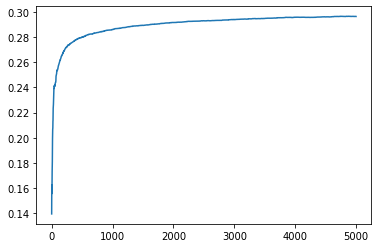

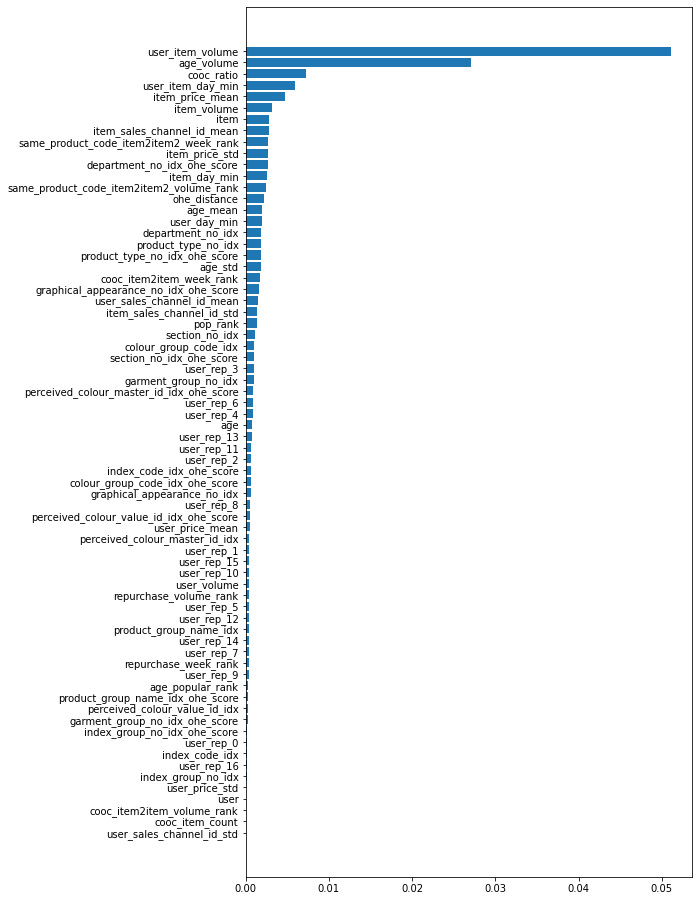

In [18]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_dataset = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
        'iterations': 5000,
    }
    model = catboost.CatBoost(params)
    model.fit(train_dataset, eval_set=valid_dataset)

    plt.plot(model.get_evals_result()['validation']['PFound'])

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])


del train, valid, train_dataset, valid_dataset
gc.collect()
with open('output/model_for_validation.pkl', 'wb') as f:
    pickle.dump(model, f)

In [19]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])

pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

merged.to_pickle(f'output/merged_{dataset}.pkl')
dataset_valid_all.to_pickle(f'output/valid_all_{dataset}.pkl')

print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.03512334121136148


In [20]:
# assert False

submission

In [21]:
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates))]

for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

train = concat_train(datasets, 0, CFG.train_weeks)

attach features (week: 1)


[user static fetaures] 0.544 s


[item stacic features] 1.280 s


[user dynamic features (transactions)] 3.232 s


[item dynamic features (transactions)] 1.291 s


[item dynamic features (user features)] 4.042 s


[item freshness features] 2.889 s


[item volume features] 1.364 s


[user freshness features] 4.086 s


[user volume features] 2.252 s


[user-item freshness features] 20.653 s


[user-item volume features] 4.640 s


[item age volume features] 2.283 s


[ohe dot products] 68.722 s


[lfm features] 3.465 s
attach features (week: 2)


[user static fetaures] 0.532 s


[item stacic features] 1.310 s


[user dynamic features (transactions)] 3.233 s


[item dynamic features (transactions)] 1.373 s


[item dynamic features (user features)] 4.100 s


[item freshness features] 2.891 s


[item volume features] 1.427 s


[user freshness features] 4.087 s


[user volume features] 2.352 s


[user-item freshness features] 20.626 s


[user-item volume features] 4.770 s


[item age volume features] 2.371 s


[ohe dot products] 80.966 s


[lfm features] 3.426 s
attach features (week: 3)


[user static fetaures] 0.575 s


[item stacic features] 1.404 s


[user dynamic features (transactions)] 3.276 s


[item dynamic features (transactions)] 1.414 s


[item dynamic features (user features)] 4.255 s


[item freshness features] 2.962 s


[item volume features] 1.460 s


[user freshness features] 4.200 s


[user volume features] 2.435 s


[user-item freshness features] 21.453 s


[user-item volume features] 4.922 s


[item age volume features] 2.485 s


[ohe dot products] 92.003 s


[lfm features] 3.560 s
attach features (week: 4)


[user static fetaures] 0.606 s


[item stacic features] 1.521 s


[user dynamic features (transactions)] 3.288 s


[item dynamic features (transactions)] 1.444 s


[item dynamic features (user features)] 4.176 s


[item freshness features] 2.993 s


[item volume features] 1.532 s


[user freshness features] 4.171 s


[user volume features] 2.427 s


[user-item freshness features] 20.824 s


[user-item volume features] 4.753 s


[item age volume features] 2.542 s


[ohe dot products] 86.216 s


[lfm features] 3.816 s
attach features (week: 5)


[user static fetaures] 0.520 s


[item stacic features] 1.211 s


[user dynamic features (transactions)] 3.231 s


[item dynamic features (transactions)] 1.309 s


[item dynamic features (user features)] 4.123 s


[item freshness features] 2.810 s


[item volume features] 1.387 s


[user freshness features] 3.955 s


[user volume features] 2.315 s


[user-item freshness features] 21.188 s


[user-item volume features] 4.599 s


[item age volume features] 2.329 s


[ohe dot products] 81.437 s


[lfm features] 3.349 s
attach features (week: 6)


[user static fetaures] 0.507 s


[item stacic features] 1.202 s


[user dynamic features (transactions)] 3.190 s


[item dynamic features (transactions)] 1.291 s


[item dynamic features (user features)] 4.111 s


[item freshness features] 2.814 s


[item volume features] 1.355 s


[user freshness features] 3.950 s


[user volume features] 2.275 s


[user-item freshness features] 20.830 s


[user-item volume features] 4.489 s


[item age volume features] 2.287 s


[ohe dot products] 77.740 s


[lfm features] 3.206 s
attach features (week: 7)


[user static fetaures] 0.525 s


[item stacic features] 1.181 s


[user dynamic features (transactions)] 3.157 s


[item dynamic features (transactions)] 1.273 s


[item dynamic features (user features)] 4.054 s


[item freshness features] 2.732 s


[item volume features] 1.348 s


[user freshness features] 3.877 s


[user volume features] 2.270 s


[user-item freshness features] 18.991 s


[user-item volume features] 4.455 s


[item age volume features] 2.310 s


[ohe dot products] 78.500 s


[lfm features] 3.210 s


In [22]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

del train, train_dataset
gc.collect()
with open('output/model_for_submission.pkl', 'wb') as f:
    pickle.dump(model, f)

0:	total: 6.34s	remaining: 8h 34m 55s


1:	total: 12.1s	remaining: 8h 9m 21s


2:	total: 17.5s	remaining: 7h 53m 9s


3:	total: 23.2s	remaining: 7h 50m 52s


4:	total: 28.7s	remaining: 7h 46m 39s


5:	total: 34.2s	remaining: 7h 43m 10s


6:	total: 39.7s	remaining: 7h 40m 8s


7:	total: 45.3s	remaining: 7h 39m 14s


8:	total: 50.8s	remaining: 7h 37m 44s


9:	total: 56.5s	remaining: 7h 37m 58s


10:	total: 1m 2s	remaining: 7h 37m 32s


11:	total: 1m 7s	remaining: 7h 37m 10s


12:	total: 1m 13s	remaining: 7h 36m 40s


13:	total: 1m 18s	remaining: 7h 35m 48s


14:	total: 1m 24s	remaining: 7h 36m 40s


15:	total: 1m 30s	remaining: 7h 37m 3s


16:	total: 1m 35s	remaining: 7h 36m 7s


17:	total: 1m 41s	remaining: 7h 35m 12s


18:	total: 1m 46s	remaining: 7h 35m 14s


19:	total: 1m 52s	remaining: 7h 34m 47s


20:	total: 1m 57s	remaining: 7h 34m 28s


21:	total: 2m 3s	remaining: 7h 33m 54s


22:	total: 2m 9s	remaining: 7h 33m 58s


23:	total: 2m 14s	remaining: 7h 33m 36s


24:	total: 2m 20s	remaining: 7h 33m 48s


25:	total: 2m 25s	remaining: 7h 33m 39s


26:	total: 2m 31s	remaining: 7h 34m 9s


27:	total: 2m 37s	remaining: 7h 34m 31s


28:	total: 2m 43s	remaining: 7h 34m 2s


29:	total: 2m 48s	remaining: 7h 33m 54s


30:	total: 2m 54s	remaining: 7h 33m 52s


31:	total: 2m 59s	remaining: 7h 33m 54s


32:	total: 3m 5s	remaining: 7h 33m 54s


33:	total: 3m 11s	remaining: 7h 33m 43s


34:	total: 3m 16s	remaining: 7h 33m 43s


35:	total: 3m 22s	remaining: 7h 33m 21s


36:	total: 3m 27s	remaining: 7h 33m 1s


37:	total: 3m 33s	remaining: 7h 33m 9s


38:	total: 3m 39s	remaining: 7h 32m 54s


39:	total: 3m 44s	remaining: 7h 32m 43s


40:	total: 3m 50s	remaining: 7h 32m 41s


41:	total: 3m 56s	remaining: 7h 32m 55s


42:	total: 4m 1s	remaining: 7h 32m 49s


43:	total: 4m 7s	remaining: 7h 32m 37s


44:	total: 4m 12s	remaining: 7h 32m 26s


45:	total: 4m 18s	remaining: 7h 32m 2s


46:	total: 4m 23s	remaining: 7h 31m 37s


47:	total: 4m 29s	remaining: 7h 31m 28s


48:	total: 4m 34s	remaining: 7h 31m 1s


49:	total: 4m 40s	remaining: 7h 30m 53s


50:	total: 4m 45s	remaining: 7h 30m 31s


51:	total: 4m 51s	remaining: 7h 30m 19s


52:	total: 4m 56s	remaining: 7h 30m 19s


53:	total: 5m 2s	remaining: 7h 30m 3s


54:	total: 5m 7s	remaining: 7h 29m 51s


55:	total: 5m 13s	remaining: 7h 29m 24s


56:	total: 5m 18s	remaining: 7h 28m 53s


57:	total: 5m 23s	remaining: 7h 28m 19s


58:	total: 5m 29s	remaining: 7h 28m 24s


59:	total: 5m 35s	remaining: 7h 28m 15s


60:	total: 5m 40s	remaining: 7h 27m 41s


61:	total: 5m 46s	remaining: 7h 27m 46s


62:	total: 5m 51s	remaining: 7h 27m 48s


63:	total: 5m 57s	remaining: 7h 27m 36s


64:	total: 6m 3s	remaining: 7h 27m 47s


65:	total: 6m 8s	remaining: 7h 27m 24s


66:	total: 6m 13s	remaining: 7h 26m 52s


67:	total: 6m 18s	remaining: 7h 26m 26s


68:	total: 6m 24s	remaining: 7h 26m 4s


69:	total: 6m 29s	remaining: 7h 26m 1s


70:	total: 6m 35s	remaining: 7h 25m 45s


71:	total: 6m 40s	remaining: 7h 25m 40s


72:	total: 6m 46s	remaining: 7h 25m 27s


73:	total: 6m 51s	remaining: 7h 25m 15s


74:	total: 6m 57s	remaining: 7h 24m 49s


75:	total: 7m 2s	remaining: 7h 24m 53s


76:	total: 7m 8s	remaining: 7h 24m 46s


77:	total: 7m 13s	remaining: 7h 24m 33s


78:	total: 7m 19s	remaining: 7h 24m 24s


79:	total: 7m 24s	remaining: 7h 24m 17s


80:	total: 7m 30s	remaining: 7h 24m 16s


81:	total: 7m 35s	remaining: 7h 24m 9s


82:	total: 7m 41s	remaining: 7h 24m 12s


83:	total: 7m 47s	remaining: 7h 24m 6s


84:	total: 7m 52s	remaining: 7h 24m 10s


85:	total: 7m 58s	remaining: 7h 24m 4s


86:	total: 8m 3s	remaining: 7h 23m 49s


87:	total: 8m 9s	remaining: 7h 23m 47s


88:	total: 8m 15s	remaining: 7h 23m 39s


89:	total: 8m 20s	remaining: 7h 23m 31s


90:	total: 8m 26s	remaining: 7h 23m 28s


91:	total: 8m 31s	remaining: 7h 23m 13s


92:	total: 8m 37s	remaining: 7h 23m 11s


93:	total: 8m 42s	remaining: 7h 22m 58s


94:	total: 8m 48s	remaining: 7h 23m 1s


95:	total: 8m 53s	remaining: 7h 22m 58s


96:	total: 8m 59s	remaining: 7h 22m 59s


97:	total: 9m 5s	remaining: 7h 23m 16s


98:	total: 9m 11s	remaining: 7h 23m 29s


99:	total: 9m 17s	remaining: 7h 23m 21s


100:	total: 9m 22s	remaining: 7h 23m 12s


101:	total: 9m 27s	remaining: 7h 22m 49s


102:	total: 9m 33s	remaining: 7h 22m 31s


103:	total: 9m 38s	remaining: 7h 22m 28s


104:	total: 9m 44s	remaining: 7h 22m 15s


105:	total: 9m 49s	remaining: 7h 22m 11s


106:	total: 9m 54s	remaining: 7h 21m 53s


107:	total: 10m	remaining: 7h 21m 52s


108:	total: 10m 6s	remaining: 7h 21m 50s


109:	total: 10m 11s	remaining: 7h 21m 40s


110:	total: 10m 17s	remaining: 7h 21m 40s


111:	total: 10m 23s	remaining: 7h 21m 43s


112:	total: 10m 28s	remaining: 7h 21m 31s


113:	total: 10m 34s	remaining: 7h 21m 18s


114:	total: 10m 39s	remaining: 7h 21m 5s


115:	total: 10m 44s	remaining: 7h 20m 58s


116:	total: 10m 50s	remaining: 7h 20m 54s


117:	total: 10m 56s	remaining: 7h 20m 59s


118:	total: 11m 1s	remaining: 7h 20m 54s


119:	total: 11m 7s	remaining: 7h 20m 55s


120:	total: 11m 13s	remaining: 7h 20m 46s


121:	total: 11m 19s	remaining: 7h 20m 57s


122:	total: 11m 24s	remaining: 7h 20m 45s


123:	total: 11m 30s	remaining: 7h 20m 51s


124:	total: 11m 35s	remaining: 7h 20m 36s


125:	total: 11m 41s	remaining: 7h 20m 41s


126:	total: 11m 47s	remaining: 7h 20m 33s


127:	total: 11m 52s	remaining: 7h 20m 14s


128:	total: 11m 57s	remaining: 7h 20m 3s


129:	total: 12m 2s	remaining: 7h 19m 46s


130:	total: 12m 8s	remaining: 7h 19m 37s


131:	total: 12m 13s	remaining: 7h 19m 27s


132:	total: 12m 19s	remaining: 7h 19m 18s


133:	total: 12m 24s	remaining: 7h 19m 14s


134:	total: 12m 30s	remaining: 7h 19m 20s


135:	total: 12m 36s	remaining: 7h 19m 12s


136:	total: 12m 41s	remaining: 7h 18m 55s


137:	total: 12m 46s	remaining: 7h 18m 46s


138:	total: 12m 52s	remaining: 7h 18m 30s


139:	total: 12m 57s	remaining: 7h 18m 15s


140:	total: 13m 2s	remaining: 7h 18m 7s


141:	total: 13m 8s	remaining: 7h 18m 12s


142:	total: 13m 14s	remaining: 7h 18m 4s


143:	total: 13m 20s	remaining: 7h 18m 7s


144:	total: 13m 25s	remaining: 7h 18m


145:	total: 13m 30s	remaining: 7h 17m 43s


146:	total: 13m 36s	remaining: 7h 17m 33s


147:	total: 13m 41s	remaining: 7h 17m 30s


148:	total: 13m 47s	remaining: 7h 17m 24s


149:	total: 13m 53s	remaining: 7h 17m 25s


150:	total: 13m 58s	remaining: 7h 17m 16s


151:	total: 14m 3s	remaining: 7h 17m 1s


152:	total: 14m 9s	remaining: 7h 16m 51s


153:	total: 14m 14s	remaining: 7h 16m 44s


154:	total: 14m 20s	remaining: 7h 16m 38s


155:	total: 14m 26s	remaining: 7h 16m 43s


156:	total: 14m 31s	remaining: 7h 16m 38s


157:	total: 14m 37s	remaining: 7h 16m 34s


158:	total: 14m 42s	remaining: 7h 16m 28s


159:	total: 14m 48s	remaining: 7h 16m 17s


160:	total: 14m 53s	remaining: 7h 16m 11s


161:	total: 14m 59s	remaining: 7h 16m 9s


162:	total: 15m 4s	remaining: 7h 15m 54s


163:	total: 15m 10s	remaining: 7h 15m 46s


164:	total: 15m 15s	remaining: 7h 15m 36s


165:	total: 15m 21s	remaining: 7h 15m 37s


166:	total: 15m 27s	remaining: 7h 15m 33s


167:	total: 15m 32s	remaining: 7h 15m 33s


168:	total: 15m 38s	remaining: 7h 15m 34s


169:	total: 15m 43s	remaining: 7h 15m 22s


170:	total: 15m 49s	remaining: 7h 15m 10s


171:	total: 15m 54s	remaining: 7h 15m 1s


172:	total: 16m	remaining: 7h 14m 54s


173:	total: 16m 5s	remaining: 7h 14m 43s


174:	total: 16m 11s	remaining: 7h 14m 40s


175:	total: 16m 16s	remaining: 7h 14m 28s


176:	total: 16m 22s	remaining: 7h 14m 30s


177:	total: 16m 27s	remaining: 7h 14m 19s


178:	total: 16m 32s	remaining: 7h 14m 6s


179:	total: 16m 38s	remaining: 7h 14m 9s


180:	total: 16m 44s	remaining: 7h 13m 59s


181:	total: 16m 49s	remaining: 7h 13m 51s


182:	total: 16m 55s	remaining: 7h 13m 54s


183:	total: 17m 1s	remaining: 7h 13m 56s


184:	total: 17m 6s	remaining: 7h 13m 48s


185:	total: 17m 12s	remaining: 7h 13m 45s


186:	total: 17m 18s	remaining: 7h 13m 43s


187:	total: 17m 23s	remaining: 7h 13m 42s


188:	total: 17m 28s	remaining: 7h 13m 28s


189:	total: 17m 34s	remaining: 7h 13m 25s


190:	total: 17m 40s	remaining: 7h 13m 18s


191:	total: 17m 45s	remaining: 7h 13m 9s


192:	total: 17m 51s	remaining: 7h 13m 2s


193:	total: 17m 56s	remaining: 7h 13m 2s


194:	total: 18m 2s	remaining: 7h 13m 4s


195:	total: 18m 8s	remaining: 7h 12m 58s


196:	total: 18m 13s	remaining: 7h 12m 55s


197:	total: 18m 19s	remaining: 7h 12m 47s


198:	total: 18m 24s	remaining: 7h 12m 43s


199:	total: 18m 30s	remaining: 7h 12m 32s


200:	total: 18m 36s	remaining: 7h 12m 35s


201:	total: 18m 41s	remaining: 7h 12m 35s


202:	total: 18m 47s	remaining: 7h 12m 24s


203:	total: 18m 52s	remaining: 7h 12m 21s


204:	total: 18m 58s	remaining: 7h 12m 14s


205:	total: 19m 4s	remaining: 7h 12m 11s


206:	total: 19m 9s	remaining: 7h 12m 8s


207:	total: 19m 15s	remaining: 7h 12m 10s


208:	total: 19m 21s	remaining: 7h 12m 8s


209:	total: 19m 26s	remaining: 7h 11m 57s


210:	total: 19m 31s	remaining: 7h 11m 46s


211:	total: 19m 37s	remaining: 7h 11m 43s


212:	total: 19m 43s	remaining: 7h 11m 34s


213:	total: 19m 49s	remaining: 7h 11m 39s


214:	total: 19m 54s	remaining: 7h 11m 32s


215:	total: 20m	remaining: 7h 11m 30s


216:	total: 20m 6s	remaining: 7h 11m 30s


217:	total: 20m 11s	remaining: 7h 11m 21s


218:	total: 20m 16s	remaining: 7h 11m 12s


219:	total: 20m 22s	remaining: 7h 11m 4s


220:	total: 20m 27s	remaining: 7h 10m 54s


221:	total: 20m 33s	remaining: 7h 10m 52s


222:	total: 20m 39s	remaining: 7h 10m 52s


223:	total: 20m 44s	remaining: 7h 10m 45s


224:	total: 20m 50s	remaining: 7h 10m 42s


225:	total: 20m 55s	remaining: 7h 10m 33s


226:	total: 21m 1s	remaining: 7h 10m 29s


227:	total: 21m 6s	remaining: 7h 10m 19s


228:	total: 21m 12s	remaining: 7h 10m 11s


229:	total: 21m 18s	remaining: 7h 10m 10s


230:	total: 21m 23s	remaining: 7h 9m 59s


231:	total: 21m 29s	remaining: 7h 9m 56s


232:	total: 21m 34s	remaining: 7h 9m 53s


233:	total: 21m 40s	remaining: 7h 9m 50s


234:	total: 21m 45s	remaining: 7h 9m 42s


235:	total: 21m 51s	remaining: 7h 9m 44s


236:	total: 21m 57s	remaining: 7h 9m 37s


237:	total: 22m 2s	remaining: 7h 9m 31s


238:	total: 22m 8s	remaining: 7h 9m 24s


239:	total: 22m 13s	remaining: 7h 9m 15s


240:	total: 22m 19s	remaining: 7h 9m 10s


241:	total: 22m 25s	remaining: 7h 9m 9s


242:	total: 22m 30s	remaining: 7h 9m 9s


243:	total: 22m 36s	remaining: 7h 9m 3s


244:	total: 22m 41s	remaining: 7h 8m 57s


245:	total: 22m 47s	remaining: 7h 8m 49s


246:	total: 22m 53s	remaining: 7h 8m 47s


247:	total: 22m 58s	remaining: 7h 8m 41s


248:	total: 23m 4s	remaining: 7h 8m 40s


249:	total: 23m 9s	remaining: 7h 8m 31s


250:	total: 23m 14s	remaining: 7h 8m 18s


251:	total: 23m 20s	remaining: 7h 8m 8s


252:	total: 23m 25s	remaining: 7h 7m 59s


253:	total: 23m 31s	remaining: 7h 7m 55s


254:	total: 23m 36s	remaining: 7h 7m 45s


255:	total: 23m 42s	remaining: 7h 7m 37s


256:	total: 23m 47s	remaining: 7h 7m 31s


257:	total: 23m 53s	remaining: 7h 7m 24s


258:	total: 23m 58s	remaining: 7h 7m 25s


259:	total: 24m 4s	remaining: 7h 7m 18s


260:	total: 24m 10s	remaining: 7h 7m 13s


261:	total: 24m 15s	remaining: 7h 7m 3s


262:	total: 24m 20s	remaining: 7h 6m 57s


263:	total: 24m 26s	remaining: 7h 6m 54s


264:	total: 24m 32s	remaining: 7h 6m 53s


265:	total: 24m 38s	remaining: 7h 6m 50s


266:	total: 24m 43s	remaining: 7h 6m 49s


267:	total: 24m 49s	remaining: 7h 6m 43s


268:	total: 24m 55s	remaining: 7h 6m 44s


269:	total: 25m 1s	remaining: 7h 6m 42s


270:	total: 25m 6s	remaining: 7h 6m 30s


271:	total: 25m 12s	remaining: 7h 6m 27s


272:	total: 25m 17s	remaining: 7h 6m 17s


273:	total: 25m 22s	remaining: 7h 6m 10s


274:	total: 25m 28s	remaining: 7h 6m 4s


275:	total: 25m 33s	remaining: 7h 5m 56s


276:	total: 25m 39s	remaining: 7h 5m 55s


277:	total: 25m 45s	remaining: 7h 5m 51s


278:	total: 25m 50s	remaining: 7h 5m 41s


279:	total: 25m 55s	remaining: 7h 5m 32s


280:	total: 26m 1s	remaining: 7h 5m 22s


281:	total: 26m 6s	remaining: 7h 5m 13s


282:	total: 26m 11s	remaining: 7h 5m 5s


283:	total: 26m 17s	remaining: 7h 5m 2s


284:	total: 26m 23s	remaining: 7h 4m 58s


285:	total: 26m 28s	remaining: 7h 4m 49s


286:	total: 26m 34s	remaining: 7h 4m 43s


287:	total: 26m 39s	remaining: 7h 4m 37s


288:	total: 26m 45s	remaining: 7h 4m 31s


289:	total: 26m 50s	remaining: 7h 4m 28s


290:	total: 26m 56s	remaining: 7h 4m 24s


291:	total: 27m 1s	remaining: 7h 4m 16s


292:	total: 27m 7s	remaining: 7h 4m 12s


293:	total: 27m 13s	remaining: 7h 4m 8s


294:	total: 27m 18s	remaining: 7h 4m 3s


295:	total: 27m 24s	remaining: 7h 3m 53s


296:	total: 27m 29s	remaining: 7h 3m 53s


297:	total: 27m 35s	remaining: 7h 3m 48s


298:	total: 27m 41s	remaining: 7h 3m 45s


299:	total: 27m 46s	remaining: 7h 3m 32s


300:	total: 27m 51s	remaining: 7h 3m 23s


301:	total: 27m 57s	remaining: 7h 3m 16s


302:	total: 28m 2s	remaining: 7h 3m 10s


303:	total: 28m 7s	remaining: 7h 3m 1s


304:	total: 28m 13s	remaining: 7h 2m 58s


305:	total: 28m 19s	remaining: 7h 2m 49s


306:	total: 28m 24s	remaining: 7h 2m 37s


307:	total: 28m 29s	remaining: 7h 2m 31s


308:	total: 28m 35s	remaining: 7h 2m 22s


309:	total: 28m 39s	remaining: 7h 2m 6s


310:	total: 28m 45s	remaining: 7h 2m 1s


311:	total: 28m 50s	remaining: 7h 1m 52s


312:	total: 28m 56s	remaining: 7h 1m 47s


313:	total: 29m 1s	remaining: 7h 1m 39s


314:	total: 29m 7s	remaining: 7h 1m 33s


315:	total: 29m 12s	remaining: 7h 1m 21s


316:	total: 29m 17s	remaining: 7h 1m 17s


317:	total: 29m 23s	remaining: 7h 1m 8s


318:	total: 29m 28s	remaining: 7h 1m


319:	total: 29m 34s	remaining: 7h 1m


320:	total: 29m 39s	remaining: 7h 50s


321:	total: 29m 45s	remaining: 7h 40s


322:	total: 29m 50s	remaining: 7h 38s


323:	total: 29m 56s	remaining: 7h 32s


324:	total: 30m 1s	remaining: 7h 22s


325:	total: 30m 7s	remaining: 7h 23s


326:	total: 30m 13s	remaining: 7h 18s


327:	total: 30m 19s	remaining: 7h 17s


328:	total: 30m 24s	remaining: 7h 12s


329:	total: 30m 29s	remaining: 7h 2s


330:	total: 30m 35s	remaining: 6h 59m 56s


331:	total: 30m 40s	remaining: 6h 59m 50s


332:	total: 30m 46s	remaining: 6h 59m 43s


333:	total: 30m 51s	remaining: 6h 59m 33s


334:	total: 30m 57s	remaining: 6h 59m 28s


335:	total: 31m 2s	remaining: 6h 59m 17s


336:	total: 31m 7s	remaining: 6h 59m 13s


337:	total: 31m 13s	remaining: 6h 59m 9s


338:	total: 31m 18s	remaining: 6h 59m 1s


339:	total: 31m 24s	remaining: 6h 58m 57s


340:	total: 31m 30s	remaining: 6h 58m 55s


341:	total: 31m 36s	remaining: 6h 58m 51s


342:	total: 31m 41s	remaining: 6h 58m 48s


343:	total: 31m 47s	remaining: 6h 58m 39s


344:	total: 31m 52s	remaining: 6h 58m 36s


345:	total: 31m 58s	remaining: 6h 58m 27s


346:	total: 32m 3s	remaining: 6h 58m 17s


347:	total: 32m 9s	remaining: 6h 58m 15s


348:	total: 32m 14s	remaining: 6h 58m 8s


349:	total: 32m 19s	remaining: 6h 57m 58s


350:	total: 32m 25s	remaining: 6h 57m 49s


351:	total: 32m 30s	remaining: 6h 57m 42s


352:	total: 32m 36s	remaining: 6h 57m 41s


353:	total: 32m 41s	remaining: 6h 57m 30s


354:	total: 32m 47s	remaining: 6h 57m 27s


355:	total: 32m 52s	remaining: 6h 57m 24s


356:	total: 32m 58s	remaining: 6h 57m 14s


357:	total: 33m 3s	remaining: 6h 57m 10s


358:	total: 33m 9s	remaining: 6h 57m


359:	total: 33m 14s	remaining: 6h 56m 52s


360:	total: 33m 19s	remaining: 6h 56m 46s


361:	total: 33m 25s	remaining: 6h 56m 41s


362:	total: 33m 31s	remaining: 6h 56m 37s


363:	total: 33m 36s	remaining: 6h 56m 29s


364:	total: 33m 41s	remaining: 6h 56m 20s


365:	total: 33m 46s	remaining: 6h 56m 9s


366:	total: 33m 52s	remaining: 6h 56m 3s


367:	total: 33m 58s	remaining: 6h 56m


368:	total: 34m 4s	remaining: 6h 56m 1s


369:	total: 34m 9s	remaining: 6h 55m 57s


370:	total: 34m 15s	remaining: 6h 55m 51s


371:	total: 34m 20s	remaining: 6h 55m 44s


372:	total: 34m 26s	remaining: 6h 55m 43s


373:	total: 34m 32s	remaining: 6h 55m 38s


374:	total: 34m 37s	remaining: 6h 55m 31s


375:	total: 34m 43s	remaining: 6h 55m 28s


376:	total: 34m 48s	remaining: 6h 55m 23s


377:	total: 34m 54s	remaining: 6h 55m 22s


378:	total: 35m	remaining: 6h 55m 18s


379:	total: 35m 6s	remaining: 6h 55m 15s


380:	total: 35m 11s	remaining: 6h 55m 8s


381:	total: 35m 16s	remaining: 6h 54m 59s


382:	total: 35m 22s	remaining: 6h 54m 56s


383:	total: 35m 28s	remaining: 6h 54m 54s


384:	total: 35m 34s	remaining: 6h 54m 47s


385:	total: 35m 39s	remaining: 6h 54m 42s


386:	total: 35m 45s	remaining: 6h 54m 40s


387:	total: 35m 51s	remaining: 6h 54m 38s


388:	total: 35m 57s	remaining: 6h 54m 35s


389:	total: 36m 3s	remaining: 6h 54m 34s


390:	total: 36m 8s	remaining: 6h 54m 32s


391:	total: 36m 14s	remaining: 6h 54m 30s


392:	total: 36m 20s	remaining: 6h 54m 23s


393:	total: 36m 25s	remaining: 6h 54m 16s


394:	total: 36m 31s	remaining: 6h 54m 15s


395:	total: 36m 37s	remaining: 6h 54m 12s


396:	total: 36m 42s	remaining: 6h 54m 6s


In [ ]:
del datasets, dataset_valid_all, candidates, candidates_valid_all
gc.collect()

In [ ]:
all_users = users['user'].values
all_users

In [ ]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    print(f"chunk: {i}")
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

In [ ]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [ ]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

In [ ]:
submission.to_csv('submission.csv', index=False)